<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Quantum**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0000.png)


##### <font color="blue">*Quantum Mechanics*

Video Course: [PHY361 Quantum Mechanics:
Spin And Discrete Systems](https://youtube.com/playlist?list=PLIKpuUo6d5pLdaGlx355xdH_RCZXRuWLK&si=2U2Uixe14tr1hIMm)

In [ ]:
!pip install pennylane qutip cirq -q
import pennylane as qml
import numpy as np

###### ***Expectation Value***

In [ ]:
import pennylane as qml
import numpy as np

# Define the number of qubits and the quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define an observable (this is Q in your equation)
obs = qml.Hermitian(np.array([[1, 0], [0, -1]]), wires=0)

# Define a quantum state (this is |ψ⟩ in your equation)
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Example state preparation (rotation)
    return qml.state()  # Returning the state vector |ψ⟩

# Retrieve the quantum state
state = circuit()

# Calculate the expectation value of the observable
@qml.qnode(dev)
def expectation_value():
    qml.RY(np.pi / 4, wires=0)  # Same state preparation as before
    return qml.expval(obs)  # Calculate the expectation value of Q

exp_val = expectation_value()

# Print the results
print(f"Quantum State: {state}")
print(f"Expectation Value of the observable: {exp_val}")

Quantum State: [0.92387953+0.j 0.        +0.j 0.38268343+0.j 0.        +0.j]
Expectation Value of the observable: 0.7071067811865475


The expectation value of $0.7071067811865475$ corresponds to the observable $Q$ in a specific quantum state.

Observable $Q$ (Pauli-Z or Hermitian matrix)
In the example, you have an observable defined as:

$$
Q = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

This matrix is the Pauli-Z operator, which has eigenvalues $+1$ and $-1$.

State $|\psi\rangle$
The quantum state is prepared using the rotation $RY(\theta)$ gate:

$$
|\psi\rangle = RY\left(\frac{\pi}{4}\right) |0\rangle
$$

The $RY(\theta)$ gate rotates the qubit state around the Y-axis of the Bloch sphere. Specifically, when $\theta = \frac{\pi}{4}$, the state $|\psi\rangle$ becomes:

$$
|\psi\rangle = \cos\left(\frac{\pi}{8}\right) |0\rangle + \sin\left(\frac{\pi}{8}\right) |1\rangle
$$

Numerically, this is:

$$
|\psi\rangle = \cos\left(22.5^\circ\right) |0\rangle + \sin\left(22.5^\circ\right) |1\rangle \approx 0.9239 |0\rangle + 0.3827 |1\rangle
$$

Expectation Value Calculation

The expectation value of an observable $Q$ in a quantum state $|\psi\rangle$ is given by:

$$
\langle Q \rangle_\psi = \langle \psi | Q | \psi \rangle
$$

Substitute $|\psi\rangle$:

$$
\langle Q \rangle_\psi = \left(0.9239^* \langle 0| + 0.3827^* \langle 1|\right) \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \left( 0.9239 |0\rangle + 0.3827 |1\rangle \right)
$$

Simplifying:

$$
\langle Q \rangle_\psi = 0.9239^2 \cdot 1 + 0.3827^2 \cdot (-1)
$$

This becomes:

$$
\langle Q \rangle_\psi = (0.9239)^2 - (0.3827)^2 = 0.8536 - 0.1464 = 0.7071
$$

The expectation value of the observable $Q$ is $0.7071$ because it depends on the overlap between the eigenstates of the Pauli-Z matrix (the computational basis states $|0\rangle$ and $|1\rangle$) and the rotated state $|\psi\rangle$. The specific angle $\pi/4$ for the rotation gate produces a superposition state that results in this non-trivial expectation value.

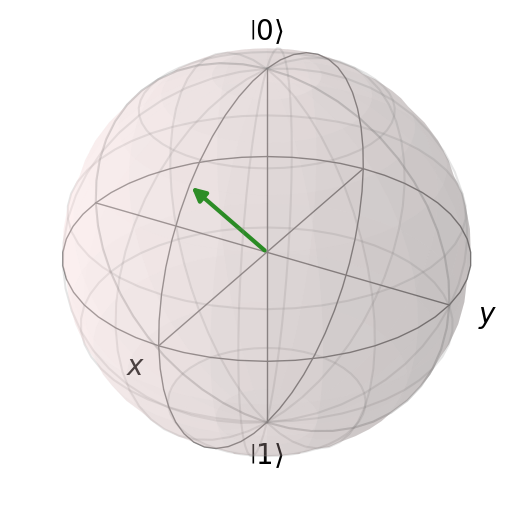

In [ ]:
import pennylane as qml
import numpy as np
from qutip import Bloch

# Define the quantum device with one qubit
dev = qml.device("default.qubit", wires=1)

# Define the quantum circuit
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Apply a rotation gate to prepare a state
    return qml.state()

# Get the quantum state (|ψ⟩)
state = circuit()

# Calculate Bloch sphere coordinates
def bloch_coords(state):
    # Expectation values of Pauli-X, Pauli-Y, Pauli-Z
    x = 2 * np.real(state[0] * np.conj(state[1]))
    y = 2 * np.imag(state[0] * np.conj(state[1]))
    z = np.abs(state[0])**2 - np.abs(state[1])**2
    return [x, y, z]

# Get the Bloch sphere coordinates from the state
coords = bloch_coords(state)

# Create a Bloch sphere and add the state vector
b = Bloch()
b.add_vectors(coords)
b.show()

###### ***Quantum Channel***

**A quantum channel is a mathematical description of quantum operations that can include both unitary evolution and non-unitary effects like noise.** [Quantum channels](https://en.m.wikipedia.org/wiki/Quantum_channel) are described mathematically as completely positive trace-preserving maps (CPTP). This ensures that they preserve the properties of quantum states.

**Each of the following quantum channels models different types of noise and decoherence that occur in real quantum systems:**

* Amplitude damping represents energy loss
* Phase damping represents loss of quantum information
* Bit/Phase flips represent discrete errors
* Thermal effects represent interaction with finite-temperature environments

In [34]:
################################
# Depolarizing Channel
################################

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def depolarizing_circuit(prob):
    qml.Hadamard(wires=0)
    qml.DepolarizingChannel(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nDepolarizing Channel:")
for p in [0.0, 0.5, 1.0]:
    result = depolarizing_circuit(p)
    print(f"\nProb {p}:")
    print(result)


Depolarizing Channel:

Prob 0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 0.5:
[[0.5       +0.j 0.16666667+0.j]
 [0.16666667+0.j 0.5       +0.j]]

Prob 1.0:
[[ 0.5       +0.j -0.16666667+0.j]
 [-0.16666667+0.j  0.5       +0.j]]


Here's a basic example that implements a depolarizing channel:
1. Creates a mixed-state quantum device
2. Implements a depolarizing channel that randomly applies Pauli gates with probability `prob`
3. Creates a quantum circuit that prepares a |+⟩ state and applies the channel
4. Returns the resulting density matrix

You can experiment with different probability values to see how the noise affects the quantum state. For a noiseless channel (prob=0), you should get the pure |+⟩ state, while for higher probabilities, the state becomes increasingly mixed. You should see different density matrices for different probabilities:
- When prob = 0.0, you'll get the pure |+⟩ state
- When prob = 1.0, you'll get the completely mixed state
- For probabilities in between, you'll get partially mixed states

In [35]:
################################
# Bit Flip Channel
################################

# Randomly flips the computational basis states (like classical bit errors)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def bit_flip_circuit(prob):
    qml.Hadamard(wires=0)
    qml.BitFlip(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nBit Flip Channel:")
for p in [0.0, 0.5, 1.0]:
    result = bit_flip_circuit(p)
    print(f"\nProb {p}:")
    print(result)


Bit Flip Channel:

Prob 0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 0.5:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 1.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


In [36]:
################################
# Phase Flip Channel
################################

# Randomly applies phase flips (Z gates)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def phase_flip_circuit(prob):
    qml.Hadamard(wires=0)
    qml.PhaseFlip(prob, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nPhase Flip Channel:")
for p in [0.0, 0.5, 1.0]:
    result = phase_flip_circuit(p)
    print(f"\nProb {p}:")
    print(result)


Phase Flip Channel:

Prob 0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 0.5:
[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Prob 1.0:
[[ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]]


In [37]:
################################
# Amplitude Dampening
################################

# This models energy dissipation in quantum systems, like when a qubit spontaneously decays from |1⟩ to |0⟩
# https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeDamping.html
# At gamma = 0, you'll see the pure state after the Hadamard gate
# As gamma increases, the state will decay towards the ground state |0⟩
#  At gamma = 1, you should see complete decay to the ground state

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def amplitude_damping_circuit(gamma):
    qml.Hadamard(wires=0)
    qml.AmplitudeDamping(gamma, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nAmplitude Dampening Channel:")
for p in [0.0, 0.5, 1.0]:
    result = amplitude_damping_circuit(p)
    print(f"\nProb {p}:")
    print(result)


Amplitude Dampening Channel:

Prob 0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 0.5:
[[0.75      +0.j 0.35355339+0.j]
 [0.35355339+0.j 0.25      +0.j]]

Prob 1.0:
[[1.e+00+0.j 5.e-08+0.j]
 [5.e-08+0.j 5.e-15+0.j]]


In [38]:
################################
# Phase Damping Channel
################################

# This represents pure decoherence without energy loss - quantum information is lost to the environment while preserving energy
# https://docs.pennylane.ai/en/stable/code/api/pennylane.PhaseDamping.html

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def phase_damping_circuit(gamma):
    qml.Hadamard(wires=0)
    qml.PhaseDamping(gamma, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nPhase Damping Channel:")
for p in [0.0, 0.5, 1.0]:
    result = phase_damping_circuit(p)
    print(f"\nProb {p}:")
    print(result)


Phase Damping Channel:

Prob 0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Prob 0.5:
[[0.5       +0.j 0.35355339+0.j]
 [0.35355339+0.j 0.5       +0.j]]

Prob 1.0:
[[5.e-01+0.j 5.e-08+0.j]
 [5.e-08+0.j 5.e-01+0.j]]


In [41]:
################################
# Generalized Amplitude Damping
################################

# Similar to amplitude damping but models systems at non-zero temperature
# https://docs.pennylane.ai/en/stable/code/api/pennylane.GeneralizedAmplitudeDamping.html
# The generalized amplitude damping channel models:
  # Energy dissipation (like regular amplitude damping) through gamma
  # Finite temperature effects through p (where p=0 reduces to regular amplitude damping)

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel
@qml.qnode(dev)
def gen_amplitude_circuit(gamma, p):
    qml.Hadamard(wires=0)
    qml.GeneralizedAmplitudeDamping(gamma, p, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nGeneralized Amplitude Damping:")
# Test with different combinations of gamma and p
test_params = [
    (0.0, 0.0),  # No damping, no excitation
    (0.5, 0.3),  # Partial damping, some excitation
    (1.0, 0.5)   # Full damping, balanced excitation
]

for gamma, p in test_params:
    result = gen_amplitude_circuit(gamma, p)
    print(f"\nGamma={gamma}, p={p}:")
    print(result)


Generalized Amplitude Damping:

Gamma=0.0, p=0.0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Gamma=0.5, p=0.3:
[[0.4       +0.j 0.35355339+0.j]
 [0.35355339+0.j 0.6       +0.j]]

Gamma=1.0, p=0.5:
[[5.e-01+0.j 5.e-08+0.j]
 [5.e-08+0.j 5.e-01+0.j]]


In [44]:
################################
# Reset Channel
################################

# Resets qubit to the |0⟩ state, modeling measurement and reset operations
# https://docs.pennylane.ai/en/stable/code/api/pennylane.ResetError.html

# --> ResetError is an error class, not a quantum channel operation <--
# We can simulate a reset channel using amplitude damping with gamma=1, which will reset the qubit to the |0⟩ state
  # 1. The reset operation doesn't need a probability parameter - it just resets the qubit
  # 2. We simulate it using amplitude damping with gamma=1
  # 3. We don't need a loop since the reset operation always does the same thing: forces the qubit to |0⟩

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Define Quantum Channel that simulates reset
@qml.qnode(dev)
def reset_circuit():
    qml.Hadamard(wires=0)
    # Use AmplitudeDamping with gamma=1 to reset to |0⟩
    qml.AmplitudeDamping(1.0, wires=0)
    return qml.density_matrix(wires=0)

# Test Quantum Channel
print("\nTest Reset Channel:")
result = reset_circuit()
print("\nDensity matrix after reset:")
print(result)

# When running this, you should see the density matrix corresponding to the |0⟩ state,
# regardless of what state the qubit was in before the reset (in this case, after the Hadamard gate).


Test Reset Channel:

Density matrix after reset:
[[1.e+00+0.j 5.e-08+0.j]
 [5.e-08+0.j 5.e-15+0.j]]


In [33]:
################################
# Thermal Relaxation Channel
################################

# Models both amplitude and phase damping with characteristic T1 and T2 times, common in real quantum hardware
# https://docs.pennylane.ai/en/stable/code/api/pennylane.ThermalRelaxationError.html

# --> ThermalRelaxationError is an error class, not a quantum channel operation <--
# We can simulate thermal relaxation using the basic quantum channels that are available in PennyLane
# We can combine amplitude and phase damping effects

# Create a device with 1 qubit
dev = qml.device('default.mixed', wires=1)

# Thermal Relaxation simulation using amplitude and phase damping
@qml.qnode(dev)
def thermal_circuit(t1, t2, time):
    # Calculate damping probabilities
    gamma_amp = 1 - np.exp(-time/t1)  # Amplitude damping parameter
    gamma_phase = 1 - np.exp(-time/t2)  # Phase damping parameter

    qml.Hadamard(wires=0)
    # Apply amplitude damping
    qml.AmplitudeDamping(gamma_amp, wires=0)
    # Apply additional dephasing
    qml.DepolarizingChannel(gamma_phase, wires=0)
    return qml.density_matrix(wires=0)

# Test with different parameters
print("\nThermal Relaxation Error:")
test_params = [
    (50, 30, 0),    # No evolution time
    (50, 30, 25),   # Half the T1 time
    (50, 30, 50)    # Full T1 time
]

for t1, t2, t in test_params:
    result = thermal_circuit(t1, t2, t)
    print(f"\nT1={t1}, T2={t2}, time={t}:")
    print(result)


Test:

T1=50, T2=30, time=0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

T1=50, T2=30, time=25:
[[0.54842249+0.j 0.09584349+0.j]
 [0.09584349+0.j 0.45157751+0.j]]

T1=50, T2=30, time=50:
[[ 0.47424134+0.j -0.02471588+0.j]
 [-0.02471588+0.j  0.52575866+0.j]]


ThermalRelaxationError is actually an error class, not a quantum channel operation. I apologize for my mistake earlier. We simulate thermal relaxation using the basic quantum channels that are available in PennyLane. We can combine amplitude and phase damping effects.

This code simulates thermal relaxation by:
1. Converting T1 and T2 times into damping probabilities using exponential decay
2. Applying amplitude damping for energy relaxation (T1)
3. Using a depolarizing channel to approximate phase damping (T2)

While this isn't exactly the same as a true thermal relaxation channel, it captures the main physical effects of both energy relaxation and decoherence. Let me know if you'd like to explore how different parameters affect the quantum state!

Important notes:
* Used more realistic test values (T1, T2 times are typically in microseconds)
* T2 must be less than or equal to T1 (this is a physical constraint)

The parameters represent:
- t1: amplitude damping time (T1 relaxation time)
- t2: dephasing time (T2 coherence time)
- time: evolution time

###### ***Arithmetics***

<font color="blue">*Simple Addition & Multiplication with Qubits*

https://summerofcode.withgoogle.com/programs/2022/projects/bYQLcqgf

**Task 1: Addition of 1 + 0 + 0 = 1 (01 in binary): We flip q0 and q1 from 0 to 1 with Pauli-X**

**Task 2: Addition of 1 + 1 + 0 = 2 (10 in binary): We flip q0 and q1 from 0 to 1 with Pauli-X**

**Task 3: Addition of 1 + 1 + 1 = 3 (11 in binary): We flip q0, q1 and q2 from 0 to 1 with Pauli-X**




https://qiskit.org/textbook/ch-states/atoms-computation.html#adder



In [ ]:
import cirq

# Create Circuit object
circuit = cirq.Circuit()

# Define 2 qubits - They start with 0 (if you measure no, you'll see a 0 in both)
(q0, q1, q2, q3) = cirq.LineQubit.range(4)



## Set up calculation:

# We flip q0 from 0 to 1 with Pauli-X
circuit.append([cirq.X(q0)])

# We flip q1 from 0 to 1 with Pauli-X
#circuit.append([cirq.X(q1)])

# We flip q2 from 0 to 1 with Pauli-X
#circuit.append([cirq.X(q2)])



# CNOT (Controlled Pauli X) for input q2 and target q0 (0 is same, 1 if different for target)
# since q2 is 0 and q0 is 1, result will stay 1
circuit.append([cirq.CNOT(q0, q2)])

# CNOT (Controlled Pauli X) for input q2 and target q1 (0 is same, 1 if different for target)
# since q2 is 0 and q1 is 1, result will stay 1
circuit.append([cirq.CNOT(q1, q2)])

# Toffoli (CCNOT) gate on q3 (if both inputs are equal, write 1, else 0) (perform a NOT on target qubit when both controls are in state 1)
circuit.append([cirq.CCX(q0, q1, q3)])

# Measure output quantum bits q2 and q3
circuit.append([cirq.measure(q2), cirq.measure(q3)])

# See what circuit has been produced (optional)
print(circuit)

                  ┌──┐
0: ───X───@────────@─────────
          │        │
1: ───────┼───@────@─────────
          │   │    │
2: ───────X───X────┼M────────
                   │
3: ────────────────X─────M───
                  └──┘


In [ ]:
# Step 6: Perform simulation of the circuit and read out result
sim = cirq.Simulator()
results = sim.run(circuit, repetitions=10)
print(results)

q(2)=1111111111
q(3)=0000000000


>* Read from rightmost qubit first (q3) and then next left (q2): result is 10 (binary) = 2 in decimal

<font color="blue">*Simple Multiplication with Qubits*

https://csferrie.medium.com/the-stupidest-most-technologically-and-resource-inefficient-way-to-multiply-by-two-fd6d0290f7b6

###### *Quantum Mechanics (Article)*

**Quantum States**

Quantum mechanics uses the Dirac notation, also known as "bra-ket",  introduced by Paul Dirac in the 1930s. This notation is a standard and efficient way of representing quantum states and operations, and is essential for understanding quantum computing.

\textbf{Hilbert spaces} are a crucial mathematical concept in quantum mechanics, providing the framework to describe systems with infinitely-many possible states and the operations performed upon them. Hilbert spaces allow for the description of quantum systems that can exist in superpositions, which often involve infinitely many possible states, unlike classical systems with their finitely-limited possibilities. Importantly, Hilbert spaces possess properties crucial for quantum mechanics: inner products allow us to calculate the probability of finding a system in a particular state, as well as expectation values of observables (like position or momentum). Completeness ensures that any valid quantum state can be represented within the Hilbert space and described by its mathematical framework. With these properties, Hilbert spaces provide the mathematical foundation to rigorously model quantum states and their evolution.

\textbf{Quantum states} encapsulate all the physically measurable information about a quantum system and probabilities related to its potential measurement outcomes. One way to describe a quantum state is the \textbf{wave function}, symbolized by the Greek letter $\psi$. It's a complex-valued function that encapsulates all conceivable information about a quantum system. This information is probabilistic rather than deterministic, marking a departure from classical mechanics by not specifying exact positions or momenta. Instead, it offers the probability densities for locating a particle in various positions or states of motion, with the square of the wavefunction's magnitude ($|\psi|^2$) representing the likelihood of finding the particle at a specific point in space and time.



Wavefunctions embody the principle of superposition, blending all potential states a system might inhabit. Through this, it communicates possible quantum states, observables (like position, momentum, and energy), and how these states evolve over time. To glean insights on observables, one applies corresponding mathematical operators to the wavefunction. Its temporal evolution is dictated by the Schrödinger equation, enabling predictions about the system's future behavior. However, the wavefunction itself isn't directly observable; we only infer its characteristics through the probability outcomes of measurements. In numerous quantum interpretations, the act of measurement forces the wavefunction to "collapse," narrowing the system down to a single possible state from the many it potentially occupied. This aspect of quantum mechanics, central yet subject to diverse interpretations, underscores the stark contrast between quantum and classical physics in conceptualizing reality.


Quantum states can exist in \textbf{superpositions} and become \textbf{entangled}. There are two main ways to represent quantum states. \textbf{Pure States} are represented by a ket-state $| \psi \rangle $, these describe systems where we know the exact superposition. \textbf{Mixed States} are represented by a density matrix $\rho$, these describe situations where there's uncertainty about the exact superposition a system is in.

A \textbf{pure state} $| \psi \rangle $ is an eigenstate of an observable, like spin up or spin down, meaning its measurement will always yield a specific value. It can be represented as a single ket vector $|\psi\rangle$. Kets are elements of a complex vector space called a Hilbert space, and they mathematically represent the system's wave function $\Psi$. A ket state is a vector whose elements represent the probability amplitudes associated with a quantum system's possible states. For example, a qubit in a superposition of its two basis states $|0\rangle$ and $|1\rangle$ can be represented by a general ket state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$, where $\alpha$ and $\beta$ are complex numbers representing probability amplitudes that satisfy the normalization condition: $|\alpha|^2$ +  $|\beta|^2$ = 1. Suppose $|\psi\rangle$ is an n-dimensional complex vector. It can be written in column form in \eq{bra2} for the two states spin up and spin down. We have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up with $|\psi_0\rangle$ in the z direction and the spin down with $|\psi_1\rangle$  direction, written as column vectors.


$|\psi_0\rangle =
|\uparrow \rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\psi_1\rangle =|\downarrow \rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)
$

A \textbf{mixed state} $\rho$ represents a quantum state when there is an unknown quantum system where you lack knowledge about the state, or decoherence due to hardware defects, or quantum systems that interact with the environment.  We need the concept of \textbf{density matrix} to represent mixed states. The density matrix $\rho$ contains all statistical information of a mixed state, such that it represents a statistical ensemble of several different possible states, rather than a single definite state. If a quantum system is in a state \( |\psi_i\rangle \) with probability \( p_i \), where \( \sum_i p_i = 1 \), the density matrix \( \rho \) of the mixed state is:

$
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|  = p_1 |\psi_1\rangle\langle\psi_1| + p_2 |\psi_2\rangle\langle\psi_2| \, ... + p_i |\psi_i\rangle\langle\psi_i|
$

The \textbf{tensor product} $\otimes$, also called the Kronecker product, is used to combine quantum states. It is essential for representing both superposition and entanglement in quantum computing. The tensor product generates a new vector in a larger Hilbert space that contains all pairwise products of the elements, unlike the dot product, which collapses vectors into a scalar, representing the degree of their parallelism. For example, if we have two qubits such that one qubit is in state $|0\rangle$ and the second qubit is in state $|1\rangle$, their combined state is represented by \eq{tensorproduct}. This combined state can represent both superpositions of separable states and entangled states, which are crucial for quantum computation.

$
|0\rangle \otimes|1\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right] \\
0 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}1 \otimes 0 \\ 1 \otimes 1 \\ 0 \otimes 0 \\ 0 \otimes 1\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]
$

A \textbf{product state} is is a particular type of pure state $| \psi \rangle $. It describes the combination of multiple \textit{separate} quantum systems where the subsystems are not entangled and can be described independently. This means that there is a precisely defined state for each subsystem. The overall state can be expressed as a tensor product $\otimes$ of the states of its individual subsystems. For example, if you have two quantum systems A and B, and the state of A is represented by \(|\psi_A\rangle\) and the state of B is represented by \(|\psi_B\rangle\), then the product state of the composite system would be \(|\psi_A\rangle \otimes |\psi_B\rangle\). Not all quantum states are product states, since most quantum states involve entanglement. Product states are often used as initial states in quantum algorithms since they are relatively easy to prepare. Quantum operations and measurements then create more complex, entangled states.


\textbf{Quantum observables} $\mathcal{A}$ represent measurable properties of a quantum system, like position, momentum, or spin of a particle. The \textbf{Hamiltonian} $\mathcal{H}$ is an important observable representing the total energy of the system. Its lowest eigenvalue describes the ground state, the most stable configuration a quantum system naturally tends toward. \textbf{Quantum operators} $\hat{A}$ mathematically represented quantum observables, or transformations in the quantum state space. These operators are 'Hermitian' and have real eigenvalues, which correspond to the possible physical solutions of a measurement. For example the eigenvalues of the momentum operator correspond to the possible momenta, or for a spin that is inherently quantized, taking on discrete values.

When a quantum observable is measured, the system collapses into an eigenstate of that observable, yielding the corresponding eigenvalue as the measurement result. Eigenstates are descriptions of physical states in quantum systems. The probability of collapsing into a particular eigenstate upon measurement is determined by the inner product between the system's quantum state and the corresponding eigenvector of the observable. Operators can change the state of a qubit, entangle multiple qubits, or perform other quantum manipulations. There are \textbf{discrete operators}, like the spin, (angular) momentum, ladder and projection operator, and \textbf{continuous quantum operators}, like the position and momentum operator.

\textbf{Super-operators} are a type of operator that acts on other operators, rather than on state vectors. Examples are quantum channels, CPTP map and Kraus operator. Super-operators are important to \textit{describe the dynamics of quantum systems, particularly in the presence of noise or other forms of quantum decoherence}. \textbf{Quantum channels} are a type of superoperator that describes the evolution of a quantum state interacting with a noisy or decohering environment. Mathematically, quantum channels are linear maps between operators spaces with the additional properties of being completely positive and trace-preserving maps, the \textbf{CPTP maps} $\mathcal{E}$. CPTP maps can be represented as a superoperator acting on the density matrix $\rho$ of a quantum state. Quantum machine learning applications involve the use of quantum channels $\mathcal{E}$, such as learning the function \eq{cptp} or its final state, where $x$ is a classical input, such as a chemical in a reaction.

$
f(x)=\operatorname{tr}(O \mathcal{E}(|x\rangle\langle x|))
$

\textbf{Kraus operators} provide a concrete way to represent quantum channels and describe \textit{discrete} time evolutions of quantum systems. Kraus operators are particularly useful for modeling noise in an open quantum system with effects that cannot be described by simple unitary evolution. \textit{Kraus's theorem} states that a linear map $\Lambda$ from the Hilbert space $\mathcal{H}$ to $\mathcal{G}$, denoted as $\Lambda: \mathcal{H} \rightarrow \mathcal{G}$ is CPTP if it can be expressed as the Kraus representation of the linear map $\Lambda$ given by \eq{kraus} where $\left\{K_\alpha\right\}$ are the Kraus operators.

$
\Lambda[\rho]=\sum_\alpha K_\alpha \rho K_\alpha^{\dagger},
$

\textbf{Lindblad operators} are another type of quantum operators used to model the effects of a system's interaction with its environment, leading to dissipation and decoherence in an open quantum system. In contrast to Kraus operators, who are used for discrete cases, Lindblad operators are applied to continuous time evolution. The time evolution of the density matrix (representing the state of a quantum system) under environmental influences is governed by the Lindblad master equation \eq{lindblad}, where $H$ is the system's Hamiltonian that describes its internal energy, $L_{i}$ are Lindblad operators that represent different environmental interactions, and $\rho$ is the density matrix of the system. The Lindblad master equation is also CPTP.

$
{\dot {\rho }}=- \frac{i}{\hbar} [H,\rho] + \sum _{i}^{}\gamma _{i}\left(L_{i}\rho L_{i}^{\dagger }-{\frac {1}{2}}\left\{L_{i}^{\dagger }L_{i},\rho \right\}\right)
$

The Lindblad master equations can be derived from the evolution described by Kraus operators in a continuous-time limit. Essentially, you break down a continuous evolution into tiny time steps, each described by Kraus operators, and then take the limit as the time steps become infinitesimally small. Furthermore, Lindblad operators offer a way to model specific types of system-environment interactions that are common in open quantum systems (like dephasing, energy relaxation, etc.).




**Quantum Measurements**

\textbf{Quantum measurement} is a fundamental tool for understanding and manipulating quantum systems. Measuring quantum systems is used to verify the presence of desired states, determine values of observables (like position, energy, or momentum, compare theoretical predictions with experimental outcomes, or reconstruct the full quantum state of a system through tomography.  There are different measurement techniques.

The \textit{Bra-ket} notation is used to calculate state similarity. \textit{Density matrices} are essential for calculating expectation values (average results of many measurements). \textit{Projective measurements} are a type of quantum measurement that collapse the wavefunction of a system into one of the eigenstates of the measured observable. This results in a measurement outcome that corresponds to one of the possible eigenvalues (outcomes) of that observable. \textit{POVMs} generalize measurements for situations where projective measurements are too restrictive. They allow for non-orthogonal outcomes that aren't strictly exclusive. \textit{Shadow tomography} is a technique that combines repeated measurements with classical machine learning to estimate the density matrix. Additionally there is the weak measurement, square root measurement, separable measurement, random clifford measurement, two-copy Bell basis measurement and more.


The \textit{Bra-Ket sandwich for State Overlap} is the simplest method for measuring quantum systems is the computing the similarity between two quantum states. This involves calculating their inner product, which is done using the \textbf{Bra-Ket} notation. A Bra $\langle \psi |$ is a row vector, specifically a special type of row vector used in quantum mechanics (a \textit{covector} or linear functional from the dual space $V^{*}$), and represents the conjugate transpose of a Ket $|\psi\rangle$. The conjugate transpose means taking the complex conjugate of each element in the original Ket $|\psi\rangle$: $\langle\psi| = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix}$.

$
\langle\psi|\psi\rangle = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix} \begin{pmatrix} a_1 \\ a_2 \\ \vdots \\ a_n \end{pmatrix} = a_1^*a_1 + a_2^*a_2 + \cdots + a_n^*a_n = 1
$

Combining a bra and a ket, such as $\langle\psi|\psi\rangle$ for identical states, or $\langle\phi|\psi\rangle$ for different states, creates a Bra-Ket, as denoted in \eq{braket} for a n-dimensional complex vector, where the quantum state vector is normalized, meaning:
$\langle\psi|\psi\rangle$ = 1. This forms an \textit{inner product}, which yields a scalar (a single number) that measures the similarity between quantum states. It can be either the 'self-overlap' of a quantum state $|\psi\rangle$ with itself $|\psi\rangle$, or the similarity between two different states $|\psi\rangle$ and $|\phi\rangle$. When the bra \(\langle \phi |\) and ket \(|\psi\rangle\) represent the same state, the bra-ket sandwich essentially calculates the inner product of the state with itself.

$
\langle \phi | A | \psi\rangle
$

The \textit{bra-ket sandwich} is an important key concept in quantum measurements and refers to a specific operation that is used to calculate the inner product and expectation values. It consists of three components: Bra, denoted as  \(\langle \phi | \), that represents the conjugate transpose (Hermitian adjoint) of a quantum state (ket). Ket, denoted as \( | \psi \rangle \), represents a quantum state itself. An operator $A$ that corresponds to the observable you want to measure and that is placed between the bra-ket \eq{braketsandwich}. In case of computing the similarity (overlap) between two quantum states, the operator would be the identity operator \(\langle \phi | I | \psi\rangle \). The identity operator is often omitted because it acts like a scalar 1 multiplying everything, but it is technically still implied. Practically, the Swap-test is used to determine the similarity, or overlap, between two quantum states \cite{10.1137/S0097539796302452, 10.1103/PhysRevLett.87.167902}.

$
|\langle \phi | \psi \rangle|^2
$

Using Bra-Ket notation to calculate the probability of finding a quantum system in state \(|\phi\rangle\) if it was initially prepared in state \(|\psi\rangle\) is given by the squared magnitude of the inner product between the two states as denoted in \eq{overlap}. It is used to calculate the \textit{state overlap}, expressing the degree to which one quantum state lies 'within' another. It is a bra-ket sandwich with the identity operator $I$ implied in the middle.

\textit{Bra-Ket sandwich for Expectation Values of Pure States}: If we generalize the bra-ket sandwich from \eq{overlap} by placing a specific operator $P$, corresponding to a desired observable, within it, we can calculate the \textit{expectation value} of that operator in a specific quantum state $|\psi\rangle$. This \textbf{expectation value}, denoted as  \eq{expectationvalue}, represents the average value you would expect to obtain over many repeated measurements of the quantity associated with operator $P$, when the system is prepared in the state $|\psi\rangle$. For example, if $P$ represents the momentum operator, then $\langle \psi | P | \psi \rangle$ gives us the average momentum of a particle in state $|\psi\rangle$.

$
\langle P \rangle = \langle \psi | P | \psi\rangle
$

To calculate the expectation value of a projection operator $P_i$ in the state $|\phi \rangle$, we use the expression $\langle P_i \rangle = \langle \psi | P_i | \psi\rangle$. This calculates the probability of finding the system in the state that the projector $P_i$ projects onto. The operator $P_i$ is represented as a projection operator $P_i = |\phi \rangle \langle \phi|$, and the probability is calculated by $\langle\psi| \phi\rangle\langle\phi|\psi\rangle = |\langle \phi | \psi \rangle|^2$. The expectation value of a projection operator corresponds to this probability. In the specific case where $P_i$ projects into the state $|\phi \rangle$ itself, this expectation value will always be 1, because $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2$. This reflects the certainty of finding the system in state $|\phi \rangle$ upon measurement if it is already prepared in that state.



\textit{Density Matrix Formulation for Expectation Values of Mixed States}: Now we want to expand to \textit{mixed states}. The expression \eq{expectationvalue} assumes the system is in a well-defined \textit{pure state} represented by the ket $|\psi\rangle$. Now we expand $\langle P \rangle = \langle \psi | P | \psi\rangle$ to include also \textit{mixed states}. A mixed state represents a statistical mixture of several possible pure states, each with a corresponding probability.

To calculate the expectation value in a mixed state, you need to use the \textbf{density matrix formulation}, where a mixed state is represented by a density matrix $\rho$. This is an operator that contains the probabilities of finding the system in various pure states. The density matrix \( \rho \)  is a weighted sum of outer products of state vectors \( |\psi_i\rangle \) with their corresponding dual vectors \( \langle\psi_i| \), where each weight \( p_i \) is the probability of the system being in the state \( |\psi_i\rangle \). The projection operator \( P_i \) projects any state onto a particular state \( |\phi\rangle \). It is defined as \( P_i = |\phi\rangle\langle\phi| \). The expectation value of an operator $P_i$ in a mixed state described by the density matrix \( \rho \) is calculated as $\langle P \rangle = \text{Tr}(\rho P_i)$, where Tr(...) is the trace of the matrix.


Expanding the density operator \( \rho \) as \( \sum_i p_i |\psi_i\rangle\langle\psi_i| \) and using the projection operator \( P_i = |\phi\rangle\langle\phi| \) becomes \eq{probabilitytrace}. It describes a quantum system that is in a probabilistic mixture of pure states $|\psi_i\rangle$, each with probability $p_i$. The trace is the sum of all Eigenvalues of an operator and corresponds to the possible measurement results of the observable that is represented by the operator. Now calculating the trace ($\text{Tr}$) of ($\rho P_i$) gives the total probability of finding the system in the state \( |\phi\rangle \) when you sum all states \( |\psi_i\rangle \) the system might be in, weighted by their respective probabilities \( p_i \), to get the average expectation value, denoted in \eq{probabilitytrace}.

$
\langle P \rangle = \text{Tr}(\rho P_i) = \text{Tr}\left(\sum_i p_i |\psi_i\rangle\langle\psi_i|\phi\rangle\langle\phi|\right)
$

This means that the expression $\langle P \rangle = \langle\phi|P_i|\phi\rangle$ from the Bra-Ket sandwich in \eq{expectationvalue} is a specific instance of the more general density matrix formulation for expectation values for a particular \textit{pure state} $ |\phi\rangle$. If the projection operator $P_i$ is projected onto the state $|\phi\rangle$, then $P_i = |\phi\rangle\langle\phi|$, and the density matrix can be written simply as $\rho =  |\phi\rangle\langle\phi|$, which results in $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2 = 1$ if you would use the density matrix formulation $\langle P \rangle = \text{Tr}(\rho P_i)$ for the a system in \textit{pure states}.

\( \text{Tr}(\rho P_i) \) from \eq{probabilitytrace} generalizes this concept to a \textit{mixed state} represented by the density matrix \( \rho \). The expectation value of mixed states is the trace of the product of the density matrix and the observable $\langle P \rangle = \text{Tr}(\rho P_i)$. The density matrix allows us to handle mixed states, but it reduces to the simple pure state form when the system is in a well-defined single state. In both cases \eq{expectationvalue} and \eq{probabilitytrace}, the focus is on calculating the probability of observing the system in a particular quantum state after a measurement.


\textit{Expectation Values of Observables under Unitary Transformations}: If you go a step further and want to measure the \textbf{expectation value} of an observable $B$, which undergoes a \textbf{(unitary) transformation $U(x)$}, you would use the expression \eq{expectedoutcome}. This often represents a single element within a larger parameterized quantum circuit. The value $(x)$ dictates the specific form of the unitary transformation, influencing the expectation value.

$
\langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
$

The system starts in state $|\psi \rangle$, and the unitary operator $U(x)$ transforms the state. The observable of interest, represented by the operator $B$, acts on the transformed state $U(x) |\psi \rangle$. The final step involves taking the expectation value of this transformed state with respect to the initial state $|\psi \rangle$. This is achieved by the \textit{bra-ket sandwich} and results in the expectation value $\langle B \rangle$ of the observable $B$ after the transformation. The bra-ket sandwich uses the reverse transformation $U^{\dagger}(x)$, which is the Hermitian adjoint (conjugate transpose) of $U(x)$.

How can equation \eq{expectedoutcome} be solved? There are two main approaches to calculating the eigenvalues of a Hermitian operator $B$: Either via \textit{Diagonalization}, which involves finding an orthonormal basis of eigenvectors of $B$. The eigenvalues of $B$ are then the corresponding eigenvalues of the Hermitian matrix representing $B$ in this basis. Or via \textit{Eigenvalue Solvers}, where there are various numerical methods for calculating eigenvalues of Hermitian operators, such as the Rayleigh-Ritz quotient, the Lanczos algorithm, and the Arnoldi algorithm. These methods can be used to calculate eigenvalues for large Hermitian matrices that cannot be diagonalized directly.

Since in $E(x) =\langle\psi| U^{\dagger}(x) B U(x) | \psi\rangle$, the observable $B$ is sandwiched between the unitary operator $U(x)$ and its conjugate transpose $U^{\dagger}(x)$, it means that $B$ can be expressed as a combination of powers of $U(x)$ and $U^{\dagger}(x)$. If we can find the eigenvalues of this combination of operators $U(x)$ and $U^{\dagger}(x)$, then we can calculate the eigenvalues of $E(x)$. The diagonalization method is accurate and but computational expensive. This involves finding a suitable basis for the Hilbert space of quantum states, and representing $U(x)$ and $U^{\dagger}(x)$ in this basis. The eigenvalues of $B$ can then be calculated by diagonalizing the matrix representing $B$ in this basis. On the other side, using an eigenvalue solver - efficient, but not super accurate. This involves choosing an appropriate numerical method, and applying it to the matrix representing B in the basis defined by $U(x)$ and $U^{\dagger}(x)$. The eigenvalues of $B$ can then be calculated by using the numerical method.

$
O' = U * O * U^{\dagger}
$

When a quantum observable undergoes a unitary transformation, the mathematical expression describing \eq{unitarytransformation}, where $O'$ represents the observable after the unitary transformation.
$O$ represents the original observable.
$U$ is the unitary operator describing the transformation, and $U^{\dagger}$ denotes the Hermitian adjoint (complex conjugate transpose) of $U$. You may noticed that the dagger placement is reversed in comparison to \eq{expectedoutcome}. The dagger placement depends on whether you are transforming the observable itself or calculating the expectation value of a transformed observable. In both cases, the unitary transformation plays a crucial role in understanding how quantum systems evolve. If you are simply describing the transformation of a physical object (observable) in space, the dagger on the second $U$ in \eq{unitarytransformation} ensures that the object is rotated or stretched consistently. When calculating the expectation value, we are essentially taking an average over the transformed object using a specific probability distribution (the state vector). The dagger on the first U achieves the correct conjugation for this averaging process.

$
\langle B \rangle = Tr(\rho U^{(\dagger)}(x) B U(x))
$

To calculate expectation values in \textit{mixed states}, where the system is in a probabilistic combination of pure states, you need the density matrix ($\rho$) formalism as denoted in \eq{expectedoutcome2}. Tr represents the trace operation, which sums the diagonal elements of the resulting matrix after the transformation.


\textit{Bra-Ket sandwich for Projective Measurements}: Another application of the bra-ket sandwich is calculating measurement probabilities in quantum systems using \textbf{projective measurement}. Imagine we have a quantum system in an unknown state represented by the wavefunction $|\psi\rangle$.  Our goal is to measure a specific observable $\mathcal{O}$ and determine the probability of finding it in a particular eigenstate, $|\phi\rangle$. To do this, we use the \textbf{corresponding projection operator} $P = |\phi \rangle\langle \phi |$, represented using \textbf{Ket-Bra notation} (outer products), which corresponds to one of the possible outcomes of the measurement. This operator acts like a filter.  When applied to the unknown quantum state $|\psi\rangle$, it extracts the component of $|\psi\rangle$ that aligns with the subspace spanned by the eigenstate $|\phi\rangle$, denoted in \eq{projection}.

\begin{equation}\label{eq:projection}
P |\psi \rangle = |{\phi}\rangle \langle{\phi}|{\psi}\rangle
\end{equation}

This projection, $| \phi \rangle\langle \phi |\psi \rangle$, holds information about the part of the unknown state $|\psi\rangle$ that overlaps with $|\phi\rangle$. To extract the probability of finding the system in this state, we take the inner product of this projection with itself. This is where the Bra-Ket sandwich comes in. It lets us calculate the magnitude squared of the resulting vector after the projection, which is the probability of finding the system in that eigenstate. Importantly, the act of measurement also causes the quantum state to collapse into the measured eigenstate. This means that we take the $|\phi\rangle$ component of $|\psi\rangle$, project it again onto $|\phi\rangle$, and calculate the length squared of this resulting vector. This length squared is the probability of finding the system in the state $|\phi\rangle$ after the measurement, denoted in \eq{projectivemeasurement}, where $P_i$ is the projector for this outcome, which is  $|\phi \rangle\langle \phi |$.

\begin{equation}\label{eq:projectivemeasurement}
P({\phi}) = \langle{\phi} | {\phi}\rangle \langle{\phi}| {\psi}\rangle |{\phi}\rangle = |\langle{\phi}|{\psi}\rangle|^2    = \langle{\phi} | P_i |{\phi}\rangle
\end{equation}

For a system with multiple possible measurement outcomes, each associated with a different eigenstate $ |\phi_i\rangle$, the overall projection operator can be expressed as a sum of individual projection operators: $\sum_i |\phi_i\rangle\langle\phi_i|$, where the sum is over all possible outcomes.  A projective basis is a set of projectors $\{ P_i \}$ that span the space of quantum states and are used for calculating outcomes of quantum measurements. Each $P_i$ projects onto a different one-dimensional subspace, and they satisfy the completeness relation $\sum_i P_i = I$, where $I$ is the identity operator. This means any quantum state can be expressed as a combination of these projectors.

As an example, the equation \eq{projectivemeasurement2} represents the probability of a specific measurement outcome '$\phi$' when the system could collapse into multiple possible eigenstates. $P(\phi)$ is the probability of finding the system in eigenstate $|\phi \rangle$ after the measurement. $P_j$ is the projection operator specifically corresponding to the outcome $|\phi\rangle$, i.e., $P_i = |\phi\rangle \langle \phi|$. The summation $\sum_i |\phi_i\rangle \langle \phi_i|$ represents the decomposition of the total measurement operator into projectors onto each potential outcome state $|\phi_i \rangle$.  Isolating $P_j = |\phi\rangle \langle\phi|$ within the overall measurement ensures that we calculate the probability specifically for the outcome '$\phi$'. The right-hand side of the equation demonstrates how the total measurement operator can be expressed as a sum of projection operators, each corresponding to a possible outcome. By using the projector $P_j$, we select the component of the summation that specifically corresponds to the probability of the outcome '$\phi$'.

$
P(\phi) = \langle \phi|P_j|\phi\rangle = \langle \phi| \sum_i |\phi_i\rangle \langle \phi_i| \phi\rangle
$

\textit{POVM (Positive Operator-Valued Measure)} is a more general framework for quantum measurements compared to projective measurements. It extends beyond the limitations of projective measurements, which are restricted to \textbf{orthogonal outcomes} and induce \textbf{state collapse}. POVMs allow for a wider range of measurement processes, including \textbf{non-orthogonal outcomes} and even those that cannot be described by simple state collapse. This makes them particularly useful in quantum information theory and for dealing with systems where you have partial or incomplete knowledge.

To obtain classical information from a quantum state represented by density matrix $\rho$, one can apply a POVM measurement. An $m$-outcome POVM is described by a set of positive semi-definite matrices $\left\{M_i\right\}_{i \in[m]}$, where $i$ iterates over the possible outcomes $i \in [m]$. These matrices satisfy the completeness relation $\sum_i M_i=\mathrm{Id}$ (identity). When measuring $\rho$ using this POVM, the probability of outcome $j$ is given by $\operatorname{Tr}\left(M_j \rho\right)$, where $Tr$ denotes the trace operation - essentially a sum over the diagonal elements of matrix $M_j$.  It's important to note that unlike projective measurements, some POVMs may not necessarily cause the system to collapse into a specific state after the measurement.

\textbf{Weak measurements} are a type of quantum measurement that partially collapse the quantum state, providing limited information while minimizing disturbance. This contrasts with strong measurements, which fully collapse the state.  Weak measurements are achieved by intentionally making the interaction between the system and the measuring device very weak. The measurement process transfers only a small amount of information from the system to the device, and the wave function of the quantum system is only slightly disturbed. This allows for extracting some information without significantly altering the system.

$
A_w = \frac{( \langle \phi_f | A |\psi_i \rangle )}{ ( \langle \phi_f | \psi_i \rangle )}
$

A weak measurement performed on a single qubit, where the observable being measured is the Pauli Z operator, where $\alpha$ and $\beta$ are complex numbers that represent the weights of the two terms in the sum. The value of $\alpha$ is related to the probability of measuring the outcome 0, while the value of $\beta$ is related to the probability of measuring the outcome 1. The magnitudes of $\alpha$ and $\beta$ represent the amount of information gained from the measurement. The weak value of an operator $A$ is often given by \eq{weakmeasurement}, where $|\psi_i \rangle$ is the initial pre-selected state, $|\phi_f \rangle$ is the final post-selected state, and $A$ is the operator corresponding to the observable being measured.




**Holevo's Bound**

Holevo's theorem (or Holevo's bound) is a fundamental principle in quantum information theory that reveals a crucial distinction: while a quantum system can exist in a superposition of many states (potentially encoding a vast amount of information), a single measurement can only reveal a limited amount of classical information. Specifically, Holevo's bound states that the maximum amount of classical information accessible from a single qubit is one bit, even if the qubit was initially prepared in a complex superposition \cite{621.391.1:535.14}. This emphasizes the difference between the potential information encoded within a quantum system and the information we can practically extract through classical measurements.


Holevo's theorem tells us that, despite the potentially vast information capacity of quantum systems, there is a strict upper limit on the amount of classical information that can be obtained from measuring those quantum systems. This means that you cannot always fully convert the rich information of quantum states into classical information.

###### ***Mathematical Formulation & Postulates of Quantum Mechanics***

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1698.jpg)

https://en.m.wikipedia.org/wiki/Bra–ket_notation

https://en.m.wikipedia.org/wiki/Quantum_state

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Wave_function

https://www.linkedin.com/pulse/math-quantum-computing-hard-concept-simple-terms-teddy-porfiris/

"There are (at least) two possible ways to formulate precisely (i.e. mathematically) elementary
QM. The eldest one, historically speaking, is due to von Neumann in essence, and is formulated using the language of Hilbert spaces and the spectral theory of unbounded operators. A more recent and mature formulation was developed by several authors in the attempt to solve quantum field theory problems in mathematical physics. It relies on the theory of abstract algebras (*-algebras and C* -algebras) that are built mimicking the operator algebras defined and studied, again, by von Neumann (nowadays known as W* -algebras or von Neumann algebras), but freed from the Hilbert-space structure. The core result is the celebrated GNS theorem (after Gelfand, Najmark and Segal), that we will prove in Chap. 14. The newer formulation can be considered an extension of the former one, in a very precise sense that we shall not go into here, also by virtue of the novel physical context it introduces and by the possibility of treating physical systems with infinitely many degrees of freedom, i.e. quantum fields. In particular, this second formulation makes precise sense of the demand for locality and covariance of relativistic quantum field theories, and allows to extend quantum field theories to a curved spacetime."
-Valter Moretti

https://www.cs.cmu.edu/~odonnell/quantum15/lecture17.pdf

https://quantum.phys.cmu.edu/QCQI/qitd463.pdf

https://quantum.phys.cmu.edu/QCQI/qitd412.pdf

*Ehrenfest and the Liouville correspondence*

* The Ehrenfest theorem and the Liouville's theorem provide important connections between the microscopic (quantum) and the macroscopic (classical) descriptions of physical systems.

* **Ehrenfest Theorem**: In quantum mechanics, the Ehrenfest theorem provides a link between the quantum mechanical description of the motion of particles and the classical motion as described by Newton's laws. Named after Paul Ehrenfest, who proved it in 1927, it demonstrates how the expectation values (average values) of quantum observables (like position and momentum) evolve with time. **Under some circumstances, when quantum effects are small, these expectation values follow trajectories similar to classical mechanics.**

* Mathematically, the Ehrenfest theorem states that the time derivative of the expectation value of an operator equals the expectation value of the time derivative of the operator. For position (x) and momentum (p), it can be written as:

* d〈x〉/dt = 〈p〉/m  (Ehrenfest's first theorem, analogous to velocity = momentum/mass)
d〈p〉/dt = -〈dV/dx〉  (Ehrenfest's second theorem, analogous to Newton's second law)

* where V is the potential energy and m is the mass of the particle.

* **Liouville's Theorem**: In classical statistical mechanics, Liouville's theorem describes the time evolution of phase space distribution function (a function that gives the probability of the system to be in a certain state with given position and momentum) in a Hamiltonian system (a system governed by Hamilton's equations). The theorem states that the distribution function is constant along the trajectories of the system. That is, the total phase space volume is conserved.

* This provides a bridge between microscopic (individual particle trajectories) and macroscopic (bulk or average behavior) properties of the system. The Liouville's theorem is a cornerstone in the development of statistical mechanics and the concept of entropy.

* Both of these theorems provide important links between classical and quantum descriptions of physics. They show that in certain limits, classical and quantum mechanical descriptions become similar, providing a physical intuition for the correspondence principle, which states that quantum mechanics must reproduce classical physics in the limit of large quantum numbers.

https://phys.org/news/2023-01-scientists-quantum-harmonic-oscillator-room.html

> Video: [Map of Quantum Physics](https://youtu.be/gAFAj3pzvAA)

https://phys.org/news/2022-11-common-misconceptions-quantum-physics.html

https://www.derstandard.de/story/2000140294674/wie-die-quantenphysik-mit-unserer-vorstellung-von-realitaet-aufraeumt

https://physicsworld.com/a/how-the-stern-gerlach-experiment-made-physicists-believe-in-quantum-mechanics/

[Korrespondenzprinzip](https://de.m.wikipedia.org/wiki/Korrespondenzprinzip): Klassische Größen werden durch Operatoren ersetzt. Die quantenmechanische Aufenthaltswahrscheinlichkeitsdichte eines Teilchens ist proportional zum Quadrat der Wellenfunktion der Materiewelle an jener Stelle. Für große Quantenzahlen geht die quantenmechanische Wahrscheinlichkeitsdichte asymptotisch in die klassische über.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Korrespondenzprinzip.svg/640px-Korrespondenzprinzip.svg.png)


*Postulate der Quantenmechanik (Kopenhagener Interpretation)*

1. **Zustand**: Der Zustand eines physikalischen Systems zu einem Zeitpunkt $t_{0}$ wird durch die Angabe eines zum Zustandsraum $\mathcal{H}$ gehörenden komplexen Zustandsvektors $\left|\psi\left(t_{0}\right)\right\rangle$ definiert. Vektoren, die sich nur um einen von 0 verschiedenen Faktor $c \in \mathbb{C}$ unterscheiden, beschreiben denselben Zustand. Der Zustandsraum des Systems ist ein Hilbertraum.

2. **Observable**: Jede Größe $A$, die physikalisch , gemessen" werden kann, ist durch einen im Zustandsraum wirkenden hermiteschen Operator $\hat{A}$ beschrieben. Dieser Operator wird als Observable bezeichnet und hat ein reelles Spektrum mit einer vollständigen sogenannten Spektralschar, bestehend aus einem , diskreten" Anteil mit Eigenvektoren und Eigenwerten (Punktspektrum) und aus einem Kontinuum.

3. **Messresultat**: Resultat der Messung einer physikalischen Größe $A$ kann nur einer der Eigenwerte der entsprechenden Observablen $\hat{A}$ sein oder bei kontinuierlichem Spektrum des Operators eine messbare Menge aus dem Kontinuum.

4. **Messwahrscheinlichkeit im Fall eines diskreten nichtentarteten Spektrums**: Wenn die physikalische Größe $A$ an einem System im Zustand $|\psi\rangle$ gemessen wird, ist die Wahrscheinlichkeit $P\left(a_{n}\right)$, den nichtentarteten Eigenwert $a_{n}$ der entsprechenden Observable $\hat{A}$ zu erhalten (mit dem zugehörigen Eigenvektor $\left|u_{n}\right\rangle$ ) $P\left(a_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$. Dabei seien $\psi$ und $u_{n}$ normiert.

5. **Die Zeitentwicklung des Zustandsvektors** $|\psi(t)\rangle$ ist gegeben durch die folgende Schrödingergleichung, wobei $\hat{H}(t)$ die der totalen Energie des Systems zugeordnete Observable ist:

>$\mathrm{i} \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}(t)|\psi(t)\rangle$

http://vergil.chemistry.gatech.edu/notes/quantrev/node20.html

* [Mathematical_formulation_of_quantum_mechanics](https://en.m.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics)
* [C*-algebra](https://en.m.wikipedia.org/wiki/C*-algebra)
* [Quantum_geometry](https://en.m.wikipedia.org/wiki/Quantum_geometry)
* [Noncommutative_geometry](https://en.m.wikipedia.org/wiki/Noncommutative_geometry)
* [Geometric_quantization](https://en.m.wikipedia.org/wiki/Geometric_quantization)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_209.png)


###### *Video: Crash course in density matrices*

**Video: [Crash course in density matrices](https://www.youtube.com/watch?v=1tserF6VGqI)**

**Single spin one half particle, focus on spin degrees of freedom & Pauli-matrices**

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\downarrow\rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**States we are used to use in quantum mechanics are called 'pure states'.**

* Any state can be written as the linear combination of the up and down vectors in the z-direction

> $|\psi\rangle=a|\uparrow\rangle+b|\downarrow\rangle$

* a and b are complex numbers whose modulus squared sum to 1

> $\langle\psi \mid \psi\rangle=|a|^{2}+|b|^{2}$

* a and b can be referred to as the probability amplitudes, where their modulus squared are the probabilities that the system is in a particular configuration.

* If we perform an ensemble of measurements on the system, we will find that the mean or expected value, for example of the Pauli-Z matrix, will be given by:

> $\left\langle\sigma^{Z}\right\rangle=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* the easiest way to solve this problem is to first solve the Eigenvalue problem, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* ... just pick up a phase in time depending on the energy they correspond to:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation:

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Propeties of the trace of a matrix**

* We have a basis of states labeled by j $|j\rangle, j=1,2$.. N that form a complete orthonormal basis. Then I write the trace of a matrix in the following way:

> $\operatorname{Tr}(A)=\sum_{j}\langle j|A| j\rangle$

* the trace is a linear mapping which tells us that we can separate the trace of the sum of two matrices apart like this, and we can also pull scalar multiples outside of the trace:

> $\operatorname{Tr}(A+B)=\operatorname{Tr} A+\operatorname{Tr} B$ with $\operatorname{Tr}(c A)=c \operatorname{Tr} A$

* When we take the trace of two matrices multiplied by each other, the trace is invariant under swapping the two matrices inside of the trace.

> $\operatorname{Tr}(A B)=\operatorname{Tr}(B A)$

**Density Matrices**

* Going from a pure state represented by a Ket we can introduce the density matrix which is a completely equivalent way to represent the state of a quantum system

* the density matrix in this context is just the outer product of the state with itself:

> $\rho=|\psi\rangle\langle\psi|$

* the expectation value is rewritten in terms of a trace, but it is mathematically equivalent to the earlier expression:

> $\left\langle\sigma^{Z}\right\rangle=\operatorname{Tr}\left(\rho \sigma^{2}\right)=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

* the density matrix has two fundamental properties: it's trace is 1 in the context of a pure state:

> $\operatorname{Tr} \rho=1$

> $\operatorname{Tr}|\psi\rangle\left\langle\left.\psi|=|\langle\psi \mid \psi\rangle\right|^{2}=1\right.$

* and it's a positive operator:

> $\rho \geq 0$

* If I take any state vector our state space and perform the following operation, then the result is always greater than or equal to zero:

> $\langle\phi|\rho| \phi\rangle=|\langle\phi \mid \psi\rangle|^{2} \geq 0$

**Dynamics: von Neumann equation of time evolution**

* show from the Schroedinger equation we can derive the von Neumann equation of time evolution:

> $i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]$

* It features the commutation relationship between the Hamiltonian and the density matrix itself

* then the expectation value for an observable in time can be rewritten in the following way:

> $\langle A(t)\rangle=\operatorname{Tr}(\rho(t) A)$

* where the density matrix $\rho$ evolves with the Hamiltonian being applied to it in time:

> $\rho(t)=e^{-i \hat{H} t} \rho e^{i \hat{H} t}$

*  similarly re-expressed in the basis of the energy Eigenvalues

> $\rho(t)=\sum_{m, n} \rho_{m, n} e^{-i\left(E_{m}-E_{n}\right) t}\left|E_{m}\right\rangle\left\langle E_{n}\right|$

* where $\rho_{m,n}$ can be written in the following way, where we have re-expressed its entries in terms of the energy Eigenbasis:

> $\rho_{m, n}=\left\langle E_{m}|\rho| E_{n}\right\rangle$


**Mixed States**

* what if we are unsure of what pure state our system is in? (We are somehow ignorant / unwissend to what pure state we are in)

* then we can describe a statistical ensemble of pure states which we call a mixed states

> $\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|$

* the ensemble is written as a sum of pure states with probabilities $p_j$ and the probabilities are greater than zero and sum up to one:

> $p_{j} \geq 0 \quad \sum_{j} p_{j}=1$

* Mixed states are also trace 1 and are positive operators:

> $\operatorname{Tr} \rho=1, \quad \rho \geq 0$

* Dynamics and the expectation values work in an identical way

**Non-uniqueness of mixed states decomposition**

* Interestingly it's not completely correct to interpret $p_j$ as the probability of being in a particular state labeled by j.

* To see this consider the following example let $\rho$ be a mixed state written in the following way:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* we say the system is in state down with probability 4/5 and in state up with 1/5.

* What if I prepared two other states with the following new state vectors a and b with the following probability amplitudes of being in down or up state:

> $|a\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle+\frac{1}{\sqrt{5}}|\uparrow\rangle$

> $|b\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle-\frac{1}{\sqrt{5}}|\uparrow\rangle$

* Then if we prepare these states with probability one-half:

> $\rho=\frac{1}{2}|a\rangle\left\langle a\left|+\frac{1}{2}\right| b\right\rangle\langle b|$

* We see that we get the same density matrix as before working this out expanding the definitions of a and b allows us to arrive at our original density matrix:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* Therefore two different ensembles of pure states can give rise to the same mixed state and we must be careful when we interpret $p_j$ as strictly probabilities of a particular system being strictly in its associated pure state in the sum.

* Finally, if you get a matrix how could you tell if it's pure or mixed? Mathematically quite simple way to check: square the matrix and take its trace. If the trace is still 1, we say that the density matrix is pure if it is less than one then we say it's mixed. This is actually independent of the time evolution.

> $\operatorname{Tr}\left(\rho^{2}\right) \leq 1$

###### *Video: Two qubit state: Separable vs Entangled vs Bell states*

Video: [Two qubit state: Separable vs Entangled vs Bell states](https://www.youtube.com/watch?v=4BRQsrh4oGw)

Suppose we have a composite quantum system made up of two qubits, how do we describe its state? In this video, we discuss how to describe such composite system in terms of its tensor product. We define the concept of separable versus entangled states in such composite two qubit system. We also explain how one can define a reduced density matrix for the subsystems, and from which a measure for the degree of entanglement can be established. We introduced the Bell states, which are two qubit states with maximum entanglement.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1798.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1799.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1800.png)

The following equation an example of bilinearity, because the first operator acts on the first quantum state and the second on the second and ignoring the other in both cases

Yes, this equation is an example of bilinearity. In this case, the tensor product axiom demonstrates how two operators A and B act independently on two separate quantum states ∣ψ⟩ and ∣ϕ⟩. This is a bilinear operation because: A⊗B acts on the combined state ∣ψ⟩⊗∣ϕ⟩.

A acts only on ∣ψ⟩, and B acts only on ∣ϕ⟩, ignoring the other state in each case. Thus, the operator on one system does not affect the other system, and the action is linear in each argument independently, which is the definition of bilinearity in this context.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1801.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1802.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1803.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1804.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1805.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1806.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1807.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1808.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1818.png)

How would the formula for the expectation value ⟨P⟩=Tr(ρPᵢ)  look like on the previous example with j and k, instead of computing the partial trace?

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1817.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1809.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1810.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1811.png)

All separable states have trace rho squared = 1. (At 'zero entanglement' slide)

A separable state has a reduced density that can be written as a single outer product.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1812.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1813.png)

When a reduced density matrix is in a perfectly mixed state then its density matrix is proportional to the identity matrix. Means there is equal likelihood for the quantum state to be in nay of the basis states.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1814.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1815.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1816.png)

###### ***Ket $|\psi\rangle$ - State Space $V$(Vector)*** *- also: Wave Function (Pure State, Postulate I)*

> <font color="blue">**<u>Postulate I of Quantum Mechanics</u>: The state of a physical system is characterized by a state vector that belongs to a complex vector space $\mathcal{V}$, called the state space of the system**

* State Space Formalism: unification of Schrodinger wave mechanics and matrix mechanics (Heisenberg, Born, Jordan), both are equivalent.

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin). Then it reduces to the rules of simple matrix multiplication**. Kronecker delta

* **Schrodinger wave mechanics: for continuous basis (like position)** Dirac delta function

* State Space: the vector space in which quantum systems live

  * Euclidean space: classical physics, 3D, real, inner product (Hilbert Space)

  * State space: quantum physics, infinite dimensions, complex numbers, inner product (Hilbert Space)

Video: [Dirac notation: state space and dual space](https://www.youtube.com/watch?v=hJoWM9jf0gU)

<font color="blue">*Ket Algebra - Quantum State Vector*

**A Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state', <u>represents</u> the wave function of a quantum system ("Psi")**, consisting of **probability amplitudes**. This Quantum state is a **stochastic vector**, written as a column vector.

> **A Ket is technically a pure quantum state**.

* Wave function notation to describe superposition of Pure States.

So, you have an (orthonormal) basis with 3 vectors and coefficients, to describe a vector in space (in Hilbert space):

> $\vec{v}=$<font color='blue'>$2$</font>$\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$<font color='blue'>$+3$</font>$\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$<font color='blue'>$+0$</font>$\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

The basis vectors will all entries in 0 and only one with 1 correspond to possibe measurement outcomes (spin up or down).

The coefficients can be collected in one vector and are complex numbers:

> $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font>

An arbitrary state for a qubit can be written as a linear combination of the Pauli matrices, which provide a basis for $2 \times 2$ self-adjoint matrices:

> $
\rho=\frac{1}{2}\left(I+r_{x} \sigma_{x}+r_{y} \sigma_{y}+r_{z} \sigma_{z}\right)
$

* where the real numbers $\left(r_{x}, r_{y}, r_{z}\right)$ are the coordinates of a point within the unit ball and

> $
\sigma_{x}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_{y}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_{z}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
$


Siehe auch: [Projective Hilbert Space](https://en.m.wikipedia.org/wiki/Projective_Hilbert_space) with rays or projective rays

<font color="blue">*Multiply Ket with a Scalar: Vector-Scalar-Multiplication*

Vector-Scalar:

$\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[y_{0}\right]=\left[\begin{array}{l}x_{0}\left[y_{0}\right] \\ x_{1}\left[y_{0}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} \\ x_{1} y_{0}\end{array}\right]$


<font color="blue">*Multiply Ket with another Ket: Ket - Tensor Product (Vector-Vector-Multiplication, Kronecker Product)*

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

*Zur Kombination von Quantum States:*

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$.

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

**How do we represent Ket's in a particular basis?**

> <font color="blue">$|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle \quad$ where: $c_{i}=\left\langle u_{i} \mid \psi\right\rangle$

Video: [Representations in quantum mechanics](https://www.youtube.com/watch?v=rp2k2oR5ZQ8)


> $\left\{c_{i}\right\}$ are the representation of $|\psi\rangle$ in the $\left\{\left|u_{i}\right\rangle\right\}$ basis

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_210.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_211.png)

* a und b coefficients in euclidean space sind wie $u_i$ coefficients in quantum state space. (difference is bra-ket, wo bra das conjugate complex ist als dot product mit ket: es ist im erstem argument antilinear!).

* expansion coefficients c are given by projection of the Ket onto the basis states u:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_212.png)

* Here we can take out $|\Psi\rangle$ because it doesnt explicitely depend on $_i$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_213.png)

**Additional Ket-Algebra**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_202.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_203.png)

For euclidean space: the scalar product is linear both in first and second argument:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_204.png)

For state space: the scalar product is only linear in the second argument (and antilinear in the first argument):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_205.png)

###### ***Bra $\langle \psi |$ - Dual Space $V^{*}$ (Covector)***

1. **$|\psi\rangle$**: This is a quantum state, often called a 'ket' in the Dirac notation. It represents the state of a quantum system, which could be a single qubit or a system of multiple qubits.
* **|ψ⟩:** This is the quantum state of the system. The state represents the configuration of the system's components, and it can be represented by a complex vector in a Hilbert space.

2. **$\langle\psi|$**: This is the bra corresponding to the ket $|\psi\rangle $. In Dirac notation, $\langle\psi|$) represents the conjugate transpose of $|\psi\rangle$.

* **⟨ψ|:** This denotes the inner product of the quantum state |ψ⟩ with itself. This inner product represents the overlap between the two states |ψ⟩ and |ψ⟩, which is a measure of their similarity.


**How do we represent Bra's in a particular basis?**

* Bra $\langle \Psi|$ is an element of the dual vector space $V^*$

* Bra Psi times the identity operator ($\langle \Psi| * \mathbb{I}$), and then write the identity operator out (its resolution in the u basis)

* psi doesnt explicitylt depend on i, so we can write it into the summation, which brings us to this expression

> $\sum_{i}\left\langle\psi \mid u_{i}\right\rangle\left\langle u_{i}\right|$

* This is an expression for the bra psi in terms of the basis bra's u, and then the expansion coefficients are the brackets between psi and u $\left\langle\psi \mid u_{i}\right\rangle$


If we look at these expansion coefficients $\left\langle\psi \mid u_{i}\right\rangle$, we can use the conjugation property of the scalar product to rewrite them like this:

> $\left\langle\psi \mid u_{i}\right\rangle$ = $\left\langle u_{i} \mid \psi \right\rangle^*$ = $c_i^*$

**The expansion coefficients are the complex conjugates of the expansion coefficients of the Ket**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_214.png)

###### ***Bra-Ket $\langle \psi |\psi\rangle = c$ - Linear Form (Covector-Vector)*** *- also: Projective Measurement*

> **Bra-Ket - Projective Measurement (Kovector-Vector-Multiplication, Born Rule)**

* Dirac delta function (a distribution!) = quantum measurement

* See also [wiki: Bra–ket notation](https://en.m.wikipedia.org/wiki/Bra–ket_notation)

* From 'Exterior algebra' $\rightarrow$ 'Multilinear Forms':

  * **A row vector can be thought of as a function (as a form), rather than a row vector, that acts on another vector.**

  * In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. Quantum mechanical systems are represented by Hilbert spaces, which are [anti–isomorphic](https://en.m.wikipedia.org/wiki/Antiisomorphism) to their own dual spaces. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

  * Bra-Ket $\langle\psi \mid \psi\rangle$: **Kovector-Vector-Multiplication**, Born Rule (Projective Measurement)

  * ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), zB $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$. Und ⟨0∣0⟩ und ⟨1∣1⟩ = 1.

*See also: [dot product between a covector and a vector is a scalar, after all!](https://cafephysics35698708.wordpress.com/2017/12/23/moving-away-from-ortho-land-vectors-covectors-and-all-that/) but read also why [There are a couple ways to view a dot product as a linear map by changing your view slightly](https://math.stackexchange.com/questions/2856198/is-dot-product-a-kind-of-linear-transformation)*

* Inner Product / Bra-Ket, conjugate transpose of Ket.
You get a scalar as output.

* The Bra-Ket $\langle\psi \mid \psi\rangle$  represents the inner product in the Hilbert space

* Zur Messung von Zustaenden in einer Basis (zB ich will die Probability wissen, mit der man den State=1 erhält)

* Quantum mechanical systems are represented by Hilbert spaces, which are anti–isomorphic to their own dual spaces.

* **A state of a quantum mechanical system can be identified with a linear functional**.

> $\mathbf{u}^{\top} \mathbf{v}=\left[\begin{array}{llll}u_{1} & u_{2} & \cdots & u_{n}\end{array}\right]\left[\begin{array}{c}v_{1} \\ v_{2} \\ \vdots \\ v_{n}\end{array}\right]=\left[u_{1} v_{1}+u_{2} v_{2}+\cdots+u_{n} v_{n}\right]$ = scalar

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_248.png)






**Case 1: Inner product of two basis vectors**:


* ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), im Detail fur $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$

* ⟨0∣0⟩ und ⟨1∣1⟩ ergeben inner product 1 (mit sich selbst multipliziert / die beiden Berechnungsbasisvektoren sind orthonormal)

**Case 2: Berechne Wahrscheinlichkeit fur Messung eines Eigenstates (Born's Rule)**

* Die orthonormalen Eigenschaften sind im folgenden Beispiel nützlich

* Es gibt einen Zustand mit der Wave Function / Wahrscheinlichkeit fur beide Zustaende $|\psi\rangle=\frac{3}{5}|1\rangle+\frac{4}{5}|0\rangle$

* die Wahrscheinlichkeit des Messens 1 ist dann (1 ist hierbei die basis, weil ich es messen will) [Source](https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation):

>$
|\langle 1 \mid \psi\rangle|^{2}=\left|\frac{3}{5}\langle 1 \mid 1\rangle+\frac{4}{5}\langle 1 \mid 0\rangle\right|^{2}=\frac{9}{25}
$

* weil $\langle 1 \mid 0\rangle=0$ faellt der zweite Term weg: $\frac{4}{5}\langle 1 \mid 0\rangle$ = $\frac{4}{5} * 0$

* Another example: $\left[\begin{array}{ll}2 & 1\end{array}\right]\left(\left[\begin{array}{l}x \\ y\end{array}\right]\right)=2 x+1 y$. **The covector [2, 1] can be thought of as a function, rather than a row vector, that acts on another vector.**

> <font color="red">*The probability of a particular measurement is then the absolute square of the scalar product with the basis vector that corresponds to the outcome (probability of measuring $X$ is). This is <u>Born's Rule</u>. This scalar product of the wave function with a basis vector is also sometimes called a <u>projection</u> on that basis vector:*

> $|\langle X \mid \Psi\rangle|^{2}=a_{1} a_{1}^{*}$

* where $\mid \Psi\rangle$ is the wavefunction of the probability superposition and $\langle X \mid$ is the basis vector of one outcome.

**Case 3: Sum over all basis vectors**

> $\langle\Psi^* |\Psi\rangle$ = $ (a{_1}^*, a{_2}^*, a{_3}^*) \left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$ = $(a{_1}^*a_1 + a{_2}^*a_2 + a{_2}^*a_2)$

**The probability to get ANY measurement outcome is equal to one, which means that the sum over the squared scalar products with all basis vectors has to be one. Which is just the length of the vector (all wave functions have length 1)**:

> $1=a_{1} a_{1}^{*}+a_{2} a_{2}^{*}+a_{3} a_{3}^{*}=|\langle \Psi \mid \Psi\rangle|^{2}$

* With this bra-ket notation it's now very easy to write dot products = the **inner product between Bra and Ket which is $\langle\psi \mid \psi\rangle$ = 1**, and it is normalized the result is 1(it's a particular way of writing the 2-norm when using complex inputs).

* With the dot product of bra and ket you will get a **scalar as a result**, like total probability is 1, here for the coefficients (probability amplitudes):

> $\langle\psi^* \mid \psi\rangle = \left|a_{0}\right|^{2}+\left|a_{1}\right|^{2}= 1$

* **We expand the Ket $\psi$ in the basis u**, where the expansion coefficients c are given by the Braket between u and psi:

> $|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle = c_{1} * u_{1} + c_{2} * u_{2} .. + c_{i}* u_{i} = c_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{c_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+.. c_{i}\left(\begin{array}{l}0 \\ 0 \\ i\end{array}\right) \quad =\left\langle u_{i} \mid \psi\right\rangle$

* <font color="red">This c cofficients are what we call **representation of the Ket psi in the u basis**.

> $\left(\begin{array}{c}\langle u_{1} \mid \psi\rangle \\ \left\langle u_{2} \mid \psi\right\rangle \\ \vdots \\ \left\langle u_{i} \mid \psi\right\rangle \\ \vdots\end{array}\right)=\left(\begin{array}{c}c_{1} \\ c_{2} \\ \vdots \\ c_{i} \\ \vdots \\ \end{array}\right)$

> **Quantum Measurements from an Observable (via its Operator) - Use Case: What is the most likely Eigenvalue of an Observable like Momentum or Position?**

Video: [Measurements in quantum mechanics || Concepts](https://www.youtube.com/watch?v=u1R3kRWh1ek)

> **$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$**

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

* Physical quantity $\mathcal{A} \longrightarrow$ Observable $\hat{A}$

* To understand what it means to measure $\hat{A}$ in quantum mechanics, the key equation to consider is the Eigenvalue equation of the operator $\hat{A}$ here:

> $
\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle
$

<font color ="blue">*$\rightarrow$ When you apply a measurement operator in an Eigenstate, you will measure /get the Eigenvalue of this Eigenstate (postulate III of quantum mechanics). Challenge: we just dont know in which Eigenstate our system $|\Psi\rangle$ is.*</font>

* with $\lambda_{n}$ Eigenvalues and $u_{n}$ Eigenstates

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**


* This means: when we want to measure property $\hat{A}$ we first need to solve the corresponding Eigenvalue equation, which allows us to find all Eigenvalues $\lambda_{1}$, $\lambda_{2}$, .. $\lambda_{n}$

* So the operator $\hat{A}$ encodes all the possible outcomes of the measurement, irrespective of what the state of the system is.

* **So the question is: if we measure $\hat{A}$ in state $|\Psi\rangle$: which Eigenvalue will we get?** (Postulate III will tell us we will get one of the Eigenvalues $\lambda_{n}$, but not which one)

> <font color="blue">**<u>Postulate VI of quantum mechanics</u>: The measurement of $\mathcal{A}$ in a system in normalized state $|\psi\rangle$ gives eigenvalue $\lambda_{n}$ with probability:**


> $
P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}
$ $\quad (= \left|c_{n}\right|^{2})$

<font color ="blue">*$\rightarrow$ $u_n$ are the possible Eigenstates to which we project our actual system state $|\Psi\rangle$. We square its norm and then see which one has the highest value = highest probability that the state is in this Eigenstate (with a givne Eigenvalue $\lambda_{n}$). For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$*</font>


* This means: for an operator $\hat{A}$ we have a list of Eigenvalues, where each of them corresponds to an Eigenstate:

  * $\lambda_{1}$ for $|u_1\rangle$,

  * $\lambda_{2}$ for $|u_2\rangle$,

  * ...

  * $\lambda_{n}$ for $|u_n\rangle$

* these relations and values come from the Eigenvalue equation of the specific operator $\mathcal{A}$ and are independent of the state of our system.

* **But when we measure $\mathcal{A}$, we measure it in a specific state $|\Psi\rangle$**. We will get $\lambda_{1}$ with $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

* So what we get as result depends (1) on the intrinsic properties $\mathcal{A}$ with its Eigenvalues and Eigenstates,  and (b) on the specific state $|\Psi\rangle$ in which our system is.

* So with postulate 4: rather then telling us the precise outcome of a measurement it tells us the probability associated with any given outcome

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$


**How does the state $|\Psi\rangle$ of a system encodes the possible outcomes of a measurement?**

> <font color ="blue">$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We can write the state $|\Psi\rangle$ in a complete basis of our state space and the Eigenstates $u_n$ over Hermitian operator like $\hat{A}$ provide such a basis

* this means we can write $|\Psi\rangle$ in the u-Basis (Eigenstates) like this:

> $|\psi\rangle=\sum_{n} c_{n}\left|u_{n}\right\rangle$

<font color ="blue">$\rightarrow$ $\left|c_{m}\right|^{2}$ is the probability and hence $c_n$ the squared root of the probability of a given Eigenvalue for each Eigenstate $\left|u_{n}\right\rangle$ from this part here above:

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$

* and these expansion coefficients c which we call **the representation of $|\Psi\rangle$ in the u-Basis**, are given by the projection of $|\Psi\rangle$ onto the u-Basis states:

> $c_{n}=\left\langle u_{n} \mid \psi\right\rangle$

* This means we can rewrite the probability p of measuring Eigenvalue $\lambda_n$ as also equal to absolute value of $c_n$ squared:

> $P\left(\lambda_{m}\right)=\left|\left\langle u_{m} \mid \psi\right\rangle\right|^{2}=\left|c_{m}\right|^{2}$

<font color ="blue">$\rightarrow$ For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

**What does this mean?**

* imagine our system is in state $\Psi\rangle$ and we want to measure a property $|\Psi\rangle$

> $|\psi\rangle \longrightarrow \hat{A} \longrightarrow ?$

* Then what we do is to write the state $|\Psi\rangle$ in the basis of Eigenstates of $\hat{A}$, and <font color ="blue">the expansion coefficient $c_n$ tell us the relative contribution of Eigenstate $|u_n\rangle$ to state $|\Psi\rangle$, which in turn tell us how likely it is to measure the associated Eigenvalue $\lambda_n$</font>

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

* mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m} \left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* <font color="red">here you can re-arrange and get an outer product (is this true???)

> $|\psi\rangle=\sum_{m} |u_{m}\rangle \langle u_{m}| \psi\rangle$

= create outer product of a certain eigenvector to take a measurement of it

Passt zu weiter unten (video prof m mit projection operators):

> $(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_199.png)

Imagine we have n copies of the state $|\Psi\rangle$ and measure each. We get an Eigenvalue from the Eigenvalue equation, but with different probabilities. As p approaches $\infty$ with N copies (= $p_n$), we will reach the most probable Eigenvalue P($\lambda_m$) (postulates 4):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_200.png)

**A special case if our system with state $|\Psi\rangle$ is in an Eigenstate of the property that we are measuring (the operator $\hat{A}$, for example momentum, positon etc), say $|u_m\rangle$**:

> $|\psi\rangle=\left|u_{m}\right\rangle$

* This corresponds to the expansion coefficient $c_m$ = 1, while all other coefficients vanish.

* In this particular case we do know with absolute certainty what the outcome of the measurement will be. Probability = 1:

> $P\left(\lambda_{m}\right)=\left|c_{m}\right|^{2}=1$

**This means: If the system is in an Eigenstate of the property that we are measuring (=momentum, position etc, measured by an operator), then the outcome of the measurement is the associated Eigenvalue with probability 1.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_287.png)

###### ***Ket-Bra $|\psi\rangle \langle \psi | = P$ - Linear Map (Vector-Covector) - Projection Operator***

**Use Case 1: Projection Operator (Outer Product)**

**A measurement outcome is actually a projection (to the first basis vector)**

* So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$> bzw. | 0 > < 0 | $\Phi$ >

* this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

> The probability of measuring a value with probability amplitude $\phi$ is $1 \geq|\phi|^{2} \geq 0$, where $|\cdot|$ is the [modulus](https://en.m.wikipedia.org/wiki/Absolute_value#Complex_numbers).

**Ket-Bra (also: Projection Operator, Outer Product or Density Matrix)**

* Use Case 1: used for mixed states

* Use Case 2: used when I want to measure a specific Eigenstate / Eigenvector to get its probability.

* Is a pair: Vector-Covector

> $\mathbf{u v}^{T}=\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right]\left[\begin{array}{llll}v_{1} & v_{2} & \cdots & v_{n}\end{array}\right]$= $\left[\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{1}\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \ldots \left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \right]$ = $\left[\begin{array}{cccc}u_{1} v_{1} & u_{1} v_{2} & \cdots & u_{1} v_{n} \\ u_{2} v_{1} & u_{2} v_{2} & \cdots & u_{2} v_{n} \\ \vdots & \vdots & & \vdots \\ u_{n} v_{1} & u_{n} v_{2} & \cdots & u_{n} v_{n}\end{array}\right]$

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

* A measurement outcome is actually a projection (to the first basis vector)

* If we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$>. This is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_307.jpg)

From this video: https://youtu.be/U6fn5LvevEE

**Example: if you want to measure with which probability the quantum system is in state 0, you apply $|0\rangle \langle0|$ operator which is $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$, because: $|0\rangle\langle 0|=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$**

* "Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

"Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since **we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix**. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

https://physics.stackexchange.com/questions/394258/what-is-the-standard-definition-of-projector-projection-and-projection-ope

The density matrix is a representation of a linear operator called the density operator. The density matrix is obtained from the density operator by choice of basis in the underlying space. In practice, the terms density matrix and density operator are often used interchangeably.

In operator language, a density operator for a system is a positive semidefinite, Hermitian operator of trace one acting on the Hilbert space of the system. This definition can be motivated by considering a situation where a pure state $\left|\psi_{j}\right\rangle$ is prepared with probability $p_{j}$, known as an ensemble. The probability of obtaining projective measurement result $m$ when using projectors $\Pi_{m}$ is given by

> $
p(m)=\sum_{j} p_{j}\left\langle\psi_{j}\left|\Pi_{m}\right| \psi_{j}\right\rangle=\operatorname{tr}\left[\Pi_{m}\left(\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|\right)\right]
$

which makes the density operator, defined as

> <font color="red">$
\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|
$

= probability of getting a state |0> for example with outer product / density matrix $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$ PLUS probability of getting state |1> etc.

<font color="red">*Projection Operator (Outer Product) & Eigenvalues in Systems of Linear Equations (HHL)*

Problem Statement:

> $A|x\rangle=|b\rangle \quad$ (System of linear equations in a quantum state)

And we want to find this:

>$
|x\rangle=A^{-1}|b\rangle \quad \text { (the solution is: }|x\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle \text { ) }
$

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:

> <font color="blue">$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

(if I want to know get the Eigenvector from a measurement, I create the outer product / density matrix of the Eigenvector like above. this is like a measurement)

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

> $
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

<font color="blue">**Case 1 - Bra-Ket (Inner Product)**: *I want to know the Eigenvalue of an observable (but I don't know which is the most probable Eigenvector)? Then I apply an operator to the quantum state (position operator, momentum operator etc). I will get the most probable Eigenvector / Eigenstate with an according Eigenvalue*

> $\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$

= apply a certain operator (=observable) on a quantum state and you get the Eigenvalue of this state (here u can also be considered the eigenstate / eigenvector)

<font color="blue">**Case 2 - Ket-Bra (Outer Product)**: *I want to measure a specific Eigenstate / Eigenvector to get its probability? Then I take the outer product / density matrix of the desired outcome and make a measurement on the quantum state / system (=project it onto the desired Eigenvector)*

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

*  mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m}\left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* here you can re-arrange and get an outer product (true?):

> $
|\psi\rangle=\sum_{m}\left|u_{m}\right\rangle\left\langle u_{m} \mid \psi\right\rangle$

= create outer product of a certain eigenvector to take a measurement of it


* Passt zu weiter unten (video prof $m$ mit projection operators):

> $
(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle
$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_250.png)

Video: [Projection operators in quantum mechanics](https://www.youtube.com/watch?v=M9V4hhqyrKQ)

> **Projection Operators project one quantum state on another or onto a subspace of the state space**

* for example: when we measure a property of a quantum particle, then the state of the particle collapses onto a different state

* the projection operator mathematically describes this collapse

> **projection operator associated with a Ket Psi: $| \Psi \rangle$ is the outer product of psi with itself: $|\Psi\rangle \langle \Psi|$**

* then we check what it does on an arbirary state phi

* the projection operator projects an arbitrary state (here Phi) onto the reference state (here Psi).

* the proportionality constant C is given by the overlap between the initial state phi and the state psi that defines the projection operator

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_264.png)

Properties of the projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_265.png)

Eigenvalues and Eigenstates of Projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_266.png)

The Projection operator allows us to write any Ket as a sum of two other Kets:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_267.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_268.png)

One common way in which the projection operator is used in quantum mechanics is to project onto a subspace of the whole state space.

* Most convenient way to write this down is in terms of basis states of our state space.

* For a basis u we consider a subset of basis states u1, to un which soon an n-dimensional subspace of the full state space.

* We then write the projection operator onto this n-dimensional subspace as pn

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_269.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_270.png)

**Projective measurement (PVM - Projection-valued measure)**

* See [this article](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Projective_measurement) and longer article on [PVM](https://en.m.wikipedia.org/wiki/Projection-valued_measure)

* The eigenvectors of a von Neumann observable form an orthonormal basis for the Hilbert space, and each possible outcome of that measurement corresponds to one of the vectors comprising the basis. A density operator is a positive-semidefinite operator on the Hilbert space whose trace is equal to 1.

> <font color ="red">**For each measurement that can be defined, the probability distribution over the outcomes of that measurement can be computed from the density operator. The procedure for doing so is the Born rule, which states that**</font>

> $
P\left(x_{i}\right)=\operatorname{tr}\left(\Pi_{i} \rho\right)
$

* where $\rho$ is the density operator, and $\Pi_{i}$ is the [projection operator](https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)) onto the basis vector corresponding to the measurement outcome $x_{i}$.

* The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the [expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)) of that observable. For an observable $A$, the expectation value given a quantum state $\rho$ is

>$
\langle A\rangle=\operatorname{tr}(A \rho)
$

* A density operator that is a rank-1 projection is known as a pure quantum state, and all quantum states that are not pure are designated mixed. Pure states are also known as wavefunctions.

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Mixed States (Density Matrix)***

***Use Case 2: Mixed States (Density Matrix)***

Die [Quantenstatistik](https://de.m.wikipedia.org/wiki/Quantenstatistik) wendet zur Untersuchung makroskopischer Systeme die Methoden und Begriffe der klassischen statistischen Physik an und berücksichtigt zusätzlich die quantenmechanischen Besonderheiten im Verhalten der Teilchen.

Wie die Quantenmechanik berücksichtigt auch die Quantenstatistik die folgende doppelte Unkenntnis:

> 1. Kennt man den Zustand eines Systems genau – liegt also ein **reiner Zustand (pure state)** vor – und ist dieser kein Eigenzustand der Observablen, so kann man den Messwert einer Einzelmessung dennoch nicht exakt vorhersagen.

* A pure state can be written in terms of a Ket state $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$

  * <font color ="blue">$|\psi\rangle$</font> $=\sum_{i} c_{i}\left|\varphi_{i}\right\rangle$

  * Spin up or spin down = **pure states**, can be written as a single wave function $\mid \psi\rangle$.

> 2. Kennt man den Zustand des Systems nicht genau, so muss von einem **gemischten Zustand (mixed state)** ausgegangen werden. Ebenso: when one wants to describe a physical system which is entangled with another, as its state can not be described by a pure state. For mixed states with noise in qubits.

* A mixed state can be described with a density matrix:

  * <font color ="blue">$\rho$ </font>$=\sum_{i} p_{i}\left|\varphi_{i} \times \varphi_{i}\right|$
  * Sum over probabilities times the corresponding projection operators onto certain basis states $\varphi_{i}$

  * It allows for the calculation of the probabilities of the outcomes of any measurement performed upon this system, using the Born rule.

**There are two more ways to distinguish a pure state from a mixed state:**

1. Take the trace of the square of the density matrix:

  * $\operatorname{Tr}\left[\rho^{2}\right]=1 \rightarrow$ Pure state (like Summe der Eigenwerte entlang der Spur: 1-0-0-0..)

  * $\operatorname{Tr}\left[\rho^{2}\right]< 1 \rightarrow$ Mixed state. <font color="red">But in the examples below the trace is always = 1? (and some off-diagonal elements)</font>

2. Geometricaly, pure states lie on the surface of the Blochsphere. Mixed states are confined within the Bloch sphere.

> $
\begin{array}{c|c|c}
& \begin{array}{c}
\text { Pure } \\
\text { State }
\end{array} & \begin{array}{c}
\text { Mixed } \\
\text { State }
\end{array} \\
\hline \begin{array}{c}
\text { Density } \\
\text { Matrix } \\
|\psi\rangle\langle\psi|
\end{array} & \color{green} ✔ & \color{green}✔ \\
\hline \begin{array}{c}
\text { Wave } \\
\text { Function } \\
|\Psi\rangle
\end{array} & \color{green}✔ & \color{red} ❌
\end{array}
$

**Why do we need this alternative formalism, these density matrices?**

* To illustrate the difference, think about this Ket $|\psi\rangle$, which is the equal superposition of 0 and 1. We can write out the vector form $\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right]$. And if we write the corresponding $\rho$, it will have 0.5 for every element in the matrix.

> $|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+(1\rangle)=\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right] \rightarrow $$\rho=\left[\begin{array}{ll}0.5 & 0.5 \\ 0.5 & 0.5\end{array}\right]$

* On the other hand if we create the uniform distribution over the density matrix corresponding to the 0-Ket and the density matrix corresponding to the 1-Ket, then this density matrix will be different:

> $\rho^{\prime}=\frac{1}{2}(|0 \times 0|+|1 \times 1|)=\left[\begin{array}{ll}0.5 & 0 \\ 0 & 0.5\end{array}\right]$

* It doesn't have off-diagonal elements. These off-diagonal elements are critical for many quantum operations, sometimes also called 'coherences'. This is then called a maximally mixed state = equivalent of a uniform distribution in classical probability theory. This means we have absolutely no predictive power of what's going to happen next. Entropy of the state is maximal.

* Ideally we want quantum states with a high coherence, but in reality noise affects, and these coherences disappear.

https://www.youtube.com/watch?v=BE8RxAESx5I&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47


**Explanation 1: Density Matrix for Mixed States**

*Source here point 2.1: https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html*

* Let's consider the case where we initialize a qubit in the |0⟩ state, and then apply a Hadamard gate.

* **Now, unlike the scenario we described for pure states, this Hadamard gate is not ideal: Due to errors in the quantum-computer hardware, only 80% of the times the state is prepared**, this Hadamard gate produces the desired state:

> $\left|\psi_{1}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

* The remaining $20 \%$ of the times, the pulse applied to rotate the state is either too short or too long by $\frac{\pi}{6}$ radians about the $x$-axis. This means that when we use this Hadamard gate, we could end up with following two undesired outcome states:

>$
\left|\psi_{2}\right\rangle=\frac{\sqrt{3}}{2}|0\rangle+\frac{1}{2}|1\rangle, \quad\left|\psi_{3}\right\rangle=\frac{1}{2}|0\rangle+\frac{\sqrt{3}}{2}|1\rangle
$

* The figure below shows the Bloch representation for the three possible states our qubit could take if the short pulse happens 10% of the time, and the long pulse the remaining 10% of the time:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_198.png)

* Since we do not know the outcome of our qubit everytime we prepare it, we can represent it as a mixed state of the form:

**Step 1: how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:**

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

in this case:

> $
\rho_{H}=\frac{4}{5}\left|\psi_{1}\right\rangle\left\langle\psi_{1}\left|+\frac{1}{10}\right| \psi_{2}\right\rangle\left\langle\psi_{2}\left|+\frac{1}{10}\right| \psi_{3}\right\rangle\left\langle\psi_{3}\right|$

* Here, the factors $\frac{4}{5}, \frac{1}{10}$ and $\frac{1}{10}$ correspond to the classical probabilities of obtaining the states $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle$ and $\left|\psi_{3}\right\rangle$, respectively.

**Step 2: Add the matrices together**: By replacing each of these three possible state vectors into  $\rho$ , we can find the density matrix that represents this mixture:

> $\rho_{H}=\frac{4}{5}\left[\begin{array}{ll}\frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{3}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{1}{4}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{1}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{3}{4}\end{array}\right]$
$\rho_{H}=\left[\begin{array}{cc}\frac{1}{2} & \frac{\sqrt{3}}{20}+\frac{2}{5} \\ \frac{\sqrt{3}}{20}+\frac{2}{5} & \frac{1}{2}\end{array}\right]$

**Explanation 2: Density Matrix for Mixed States**

*Source: Parth G: https://www.youtube.com/watch?v=ZAOc4eMTQiw*

* **Pain Point**:  when we see this notation for two states spin up and spin down: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$ we think of it as being in a superposition of both states. But sometimes we don't know if the system is actually in this superposition, or not already collapsed to one.

* So, in practice before we measure a system, it can be in following three states, because we lack information about it. This is a mixed state:

  * 33% probability: $|\psi\rangle=\mid \uparrow>$

  * 33% probability: $|\psi\rangle=\mid \downarrow>$

  * 33% probability: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$

* **Mixed state**: lack of information about the system, hence for example giving equal probability to each possible outcome.

* **When dealing with a mixed state we need to represent it with what's known as a density operator or density matrix**.

* Wave function notation $|\psi\rangle$ can only be used to describe pure states. But density matrices $|\psi\rangle\langle\psi|$ can be used to describe mixed and pure states.

* and how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

On top of that you can even add several mixed states to get one final mixed states. Mixed state: our knowledge of the system is limited. It could be either one of multiple psi states.

* Image 1: We have to add up the density matrices of each possible spin state whilst making sure that we weight it with the probability of it being in that psi state

* Image 2: That would give us the final density matrix, which is the mixture in the mixed state.

* Image 3: it is for this reason that there is no way to write a mixed state as a single wave function or a single vector. We have to deal with matrices that represent the different pure states in which our system could be. And each of these density matrices has to be weighted by how likely it is that our system is on that pure that.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_006a.png)

**what are 𝑘-body reduced density matrices?**

see also video

In quantum mechanics, the state of a system of particles can be represented by a density matrix, which is a complex, positive semi-definite matrix with a trace equal to 1.

For a system of N particles, the full density matrix lives in a high-dimensional Hilbert space (the tensor product of the individual particle's Hilbert spaces), and contains complete information about the state of the system. However, it can often be difficult to work with such high-dimensional objects.

A k-body reduced density matrix is a lower-dimensional object that contains information about only a subset of the particles in the system.

Formally, the k-body reduced density matrix is obtained by taking the partial trace over N-k of the particles in the system. This process "averages out" the information about these N-k particles, leaving behind a density matrix that describes the remaining k particles.

The k-body reduced density matrix is a useful tool in many areas of quantum physics, including quantum chemistry and quantum information theory. It allows us to study the behavior of small subsystems within a larger quantum system, even when we can't (or don't want to) keep track of the full state of all the particles. For example, the 1-body reduced density matrix (also known as the one-particle density matrix) is often used in quantum chemistry to describe electron behavior in molecular systems.

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Expectation Values***

**Expectation Value and Backpropagation**

The average value (expectation value) of the measurement result is given by the
Born rule: **bold text**

> $\langle B\rangle=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle$

Just linear algebra! Every step is a matrix-vector or matrix-matrix multiplication

Expectation values depend continuously on the gate parameters

**Backpropagating Through Quantum Circuits**

However, as long as we don't "zoom in" to what is happening in the quantum circuit, backpropagation can treat the quantum circuit as a single indivisible function

The expectation value of a quantum circuit is a differentiable function

> $
f(\theta)=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle=\langle B\rangle$

Running on hardware and using the parameter-shift rule, we can provide both ingredients needed by backpropagation

> $
\left(\langle B\rangle, \frac{\partial}{\partial \theta}\langle B\rangle\right)
$

An observable in quantum mechanics is represented by a Hermitian operator. The spectral norm (or operator norm) of a Hermitian operator is equal to its largest eigenvalue in absolute value.

<font color="blue">**<u>Density matrix formalism</u> to calculate Expectation Values**


* [Expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)): The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the expectation value of that observable. What is the average value of quantum measurement outcomes?

* Large number of particle interactions when we are trying to measure a total effect from an aggregation of subatomic particles: run an experiment involving the observation of energy levels in a type of atom N times under fixed conditions. The expectation value e of the experiment turns out to be an illegitimate energy level for that atom, but E = Ne will give the correct total energy assuming N is large enough.

* Expectation value of an observable $Q$ (like the momentum of a particle) in a (normalized) state $|\Psi\rangle$ gives the average of all possible values (weighted by their corresponding probabilities) that one may expect to observe in an experiment designed to measure $Q$ in state $|\Psi\rangle$ over many experiments where the average of all values of $Q$ will approach the expectation value $\langle\Psi|Q| \Psi\rangle$ (one set of measurement perturbs the system)

<font color="blue">**First: The expectation value of an operator $Q$ is given by $\langle Q\rangle=\langle\psi|Q| \psi\rangle$ = $\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$(spectral decomposition)**</font>

* Given a state vector for a pure state $|s\rangle$, with its complex-conjugate transpose is $\langle s|$, the operator whose expectation value you are evaluating could be written $|A|$ and $|s\rangle$ has a component which is a $\lambda$-eigenstate for $A$.


* A mixture of states is a weighted average of such operators, and its expectation value is the weighted average of the expectation values of the pure states.

* Suppose, $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle, \ldots$ be the orthonormal basis of eigenstates of observable $Q$ with corresponding eigenvalues $\lambda_{1}, \lambda_{2}, \ldots$ respectively. One can expand the given (normalized) state $|\Psi\rangle$ in the above basis as

> $
|\Psi\rangle=\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\cdots+\alpha_{n}\left|\psi_{n}\right\rangle+\ldots
$

* According to a basic postulate of Quantum mechanics the above expansion implies that upon measuring $Q$ in state $|\Psi\rangle$ the outcome of the experiment will be eigenvalue $\lambda_{1}$ with probability $\left|\alpha_{1}\right|^{2}$, eigenvalue $\lambda_{2}$ with probability $\left|\alpha_{2}\right|^{2}$ and so on. The (weighted) average of all possible values of $Q$ that can be observed in state $|\Psi\rangle$ will be the expectation value of $Q$ in state $|\Psi\rangle$:

> <font color="blue">$\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$ = $\left|\alpha_{1}\right|^{2} \lambda_{1}+\left|\alpha_{2}\right|^{2} \lambda_{2}+\ldots =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots| \, | \lambda_{1} \alpha_{1} \psi_{1}+\lambda_{2} \alpha_{2} \psi_{2}+\ldots\right\rangle =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots|Q| \alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots\right\rangle =\langle\Psi|Q| \Psi\rangle$

* This is because operator $Q$ can be written as a sum over its Eigenvalues $a_i$ times projection operators onto its Eigenstates.

> $Q=\sum_{i} \lambda_{n} \left| u_{n} \rangle \langle \ u_{n}\right|$ $\quad$ with $Q\left| u_{n}\right\rangle= \lambda_{n}\left| u_{n}\right\rangle$

* By using decomposition in the definition of the expectation value, we get this result:

> $\langle Q\rangle_{\psi}=\langle\psi|Q| \psi\rangle=$ $\sum_{i} \lambda_{n}\langle\psi| u_{n} \rangle $ <font color ="orange">$\langle u_{u}| \psi \rangle$</font> $=\sum_{i} \lambda_{n}$ <font color ="blue">$\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We sum over all Eigenvalues, which are the possible outcomes of a measurement, weighted by the probabilities that this particular Eigenvalue occurs if we start in the state $\Psi$.

  * <font color ="orange">$\langle u_{n} | \psi\rangle$</font> - this is called the **transition amplitude**

  * <font color ="blue">$|\langle u_{n} | \psi\rangle|^{2}$</font> - this is called the **transition probability** (absolute square of the transition amplitude)

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ and since: $P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$:

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|c_{n}\right|^{2}$</font>

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>


> $|\psi\rangle \longrightarrow\langle\hat{A}\rangle_{\psi}=\langle\hat{A}\rangle=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ <font color ="blue">$=\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$

* <font color ="blue">$\rightarrow$ die Summe der Eigenwerte $\lambda_{n}$ jeweils multipliziert mit der Wahrscheinlichkeit $P\left(\lambda_{n}\right) = \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$, den jeweiligen Eigenwert zu erhalten = Expectation Value</font>

* Beispielrechnung mit interessantem Ergebnis: Eigenwert -1 mit Amplitude 0.25 und Eigenwert +1 mit Amplitude 0.25

  * = $(-1) * (0.25)^2$ + $(+1) * (0.25)^2$

  * = $(-1) * (0,5)$ + $(+1) * (0.5)$ = -0.5 + 0.5

  * = 0 $\rightarrow$ Expectation value, aber kein erlaubtes physikalisches Ergebnis.





<font color="blue">**Second: The expectation value $\langle \psi|A| \psi\rangle$ can be evaluated as the trace of $|\psi\rangle\langle \psi| A$.**</font>

* The operator $|\psi\rangle\langle \psi|$ is an operator of trace 1, and the operator $|\psi\rangle\langle \psi|$ is an operator of trace 1.

* $\rho = |\psi\rangle \langle \psi|$ is an operator of trace=1. We can calculate the expectation value of $A$ by taking the trace over $\rho$ times $A$:

> **$\langle A\rangle_{\rho}:= \langle \psi|A| \psi\rangle = \operatorname{Tr}[\rho A] =\operatorname{Tr}[\, |\psi\rangle \langle \psi| \, A]$**</font>

* Taking the trace over an operator means to sum over the matrix elements of that operator between states of a complete basis $\operatorname{Tr}[B]=\sum_{i}\left\langle\eta_{i}|B| \eta_{i}\right\rangle$. We are adding $\rho = |\psi\rangle \langle \psi|$ and move the two complex numbers $\eta$, since they are not operators:

> $\langle A\rangle_{\rho}:=\operatorname{Tr}[\rho A]$ = $\sum_{i} {\left\langle\eta_{i}\right| \psi \rangle}{\left\langle\psi|A| \eta_{i}\right\rangle}$

* We sum over the basis states. Since $| \eta_{i} \rangle \langle \eta_{i} |$ = 1, we get $\langle\psi|A| \psi\rangle$, which is the same result from working with density matrices:

> $\sum_{i}\left\langle\psi|A| \eta_{i} \rangle \langle \eta_{i} | \psi\right\rangle$ = $\langle\psi|A| \psi\rangle=\langle A\rangle_{\psi}$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_195.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_201.png)

###### *Eigenvalues, Observables & Operators*

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**

Video: [Eigenvalues and eigenstates in quantum mechanics](https://www.youtube.com/watch?v=p1zg-c1nvwQ)

> We consider the action of $\hat{A}$ on a special Ket $|\Psi\rangle$ such that the only way in which $\hat{A}$ changes $|\Psi\rangle$ is by scaling it by a constant and we obtain $\lambda |\Psi\rangle$

The Eigenvector of an operator are those special directions in the vector space which the operator doesn't change.

The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue.

https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_257.png)

> [C$*$-algebras](https://en.m.wikipedia.org/wiki/C*-algebra) were first considered primarily for their use in quantum mechanics **to model algebras of physical observables**. This line of research began with Werner Heisenberg's matrix mechanics and in a more mathematically developed form with Pascual Jordan around 1933. See also [Quantum Group](https://en.m.wikipedia.org/wiki/Quantum_group).


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_251.png)


**(Anti-)Commutators, Quantum Numbers und "Vollständiger Satz kommutierender Observablen"**

Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.
Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

https://de.m.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen

**Solving: How to find Eigenvalues and Eigenvectors?**

* For an arbitrary operator (except the identity operator) it is generally not possible to figure out the eigenvalues and eigenstates simply by inspection of how the operator acts

* More general approach needed:

	* consider basis u that is orthonormal.

	* Then we write the Eigenvalue equation in the u basis (just project both sides of the equation onto the basis states u).

	* next we insert the identity operator after the A operator on left and side

	* then write the resolution of the identity in the u basis

	* then take sum on the beginning

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_260.png)

* the equation $\sum_{j}\left(A_{i j}-\lambda \delta_{i j}\right) c_{j}=0$ is equivalent to the original Eigenvalue equation $\hat{A}|\psi\rangle=\lambda|\psi\rangle$, but now written in the u representation

* finding the eigenvalues and eigenvectors now becomes finding the lambda and c in the new equation = "matrix diagonalization"

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_261.png)

> **All we really need to do quantum mechanics is to get enough practice in diagonalizing matrices**

* we have following operator A and state Psi

* we want to find the eigenvalues and eigenvectors of the operator A

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_263.png)

<font color="blue">**Operators acting on Quantum State Vectors: Matrix-Vector-Multiplication (Single Qubit)**

*Applying a Hadamard gate to a single qubit (matrix-vector multiplication) - Simple dot product! You get a vector out.*

$H |0\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 1 + 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right] = |+\rangle$

$H |1\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}0 + 1 \\ 0 -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right] = |-\rangle$

*Diese Zustände können auch mithilfe der Dirac-Notation als Summen von |0⟩ und |1⟩ erweitert werden:*

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

*Zusammenfassend, das ist alles das gleiche, sieht aber komplett anders aus:*

<font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

<font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*$|0\rangle$ und $|1\rangle$ stellen hier die Basis dar, in der die Quantenzustaende berechnet werden.* ***Man kann allerdings auch eine andere Basis waehlen, zB $|+\rangle$ und $|-\rangle$:***

$|0\rangle=\frac{1}{\sqrt{2}}(|+\rangle+|-\rangle)$ vergleiche: <font color="blue">$|+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

$|1\rangle=\frac{1}{\sqrt{2}}(|+\rangle-|-\rangle)$ vergleiche: <font color="blue">$|-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*Applying an Identity Operator:*

$I |0\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \left[\begin{array}{ll}1 + 0 \\ 0 + 0\end{array}\right]=\left[\begin{array}{c}1 \\ 0\end{array}\right]$

$I |1\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \left[\begin{array}{ll}0 + 0 \\ 0 + 1\end{array}\right]=\left[\begin{array}{c}0 \\ 1\end{array}\right]$

*Applying a Pauli-X Operator:*

$X|0\rangle=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\left[\begin{array}{l}1 \\ 0\end{array}\right]=\left[\begin{array}{ll}0 + 0 \\ 1 + 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1\end{array}\right]$


<font color="blue">**Matrix-Vector-Multiplication (Multi Qubit)**

> $A \mathbf{x}=\left[\begin{array}{cccc}a_{11} & a_{12} & \ldots & a_{1 n} \\ a_{21} & a_{22} & \ldots & a_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m 1} & a_{m 2} & \ldots & a_{m n}\end{array}\right]\left[\begin{array}{c}x_{1} \\ x_{2} \\ \vdots \\ x_{n}\end{array}\right]=\left[\begin{array}{c}a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n} \\ a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n} \\ \vdots \\ a_{m 1} x_{1}+a_{m 2} x_{2}+\cdots+a_{m n} x_{n}\end{array}\right]$

**First create the tensor product of two operators**: For construction of the desired two-qubit gate, you need the same tensor product operation as you used for the vectors. Here where $H_1$ is a one-qubit Hadamard gate in the two-qubit space $(\hat{H} \otimes \mathbf{I})$, where Hadamard is applied only to one Qubit:

> $H_{1} \equiv H_{0} \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

**Second, apply the new 'tensored' operator on the tensor product of two state vectors**:

See the tensor product of two vectors in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Now applying $H_1$ you mix up the first qubit states and keep the second qubit state unchanged:

> $H_{1}(|0\rangle \otimes|0\rangle)=H_{1}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$= <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right) \left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0 \\ 1 \\ 0\end{array}\right)$</font>= $\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|1\rangle \otimes|0\rangle)$

**Another way of writing this (=apply H to one qubit only in a 1 qubit in a 2 qubit system) for a joint state of two initialized qubits $
|0\rangle \otimes|0\rangle
$ is:**

> <font color="orange">$\hat{H}\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle$</font> = $
\mathbf{H}|0\rangle \otimes|0\rangle=\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes|0\rangle
$

The tensor product is distributive, which in this case means it acts much like multiplication:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\frac{1}{\sqrt{2}}|0\rangle \otimes|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \otimes|0\rangle
$

See [Tensor_product](https://en.wikipedia.org/wiki/Tensor_product)


<font color="blue">**Matrix-Matrix-Multiplication (Kronecker / Tensor)**

Zur Kombination von Operators in einem Timestep (zB H bei qubit 1 und I bei Qubit 2). Two systems being described as a joint system.

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] \otimes\left[\begin{array}{ll}e & f \\ g & h\end{array}\right]=\left[\begin{array}{lll}a\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & b\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] \\ c\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & d\left[\begin{array}{llll}e & f \\ g & h\end{array}\right]\end{array}\right]=\left[\begin{array}{llll}a e & a f & \text { be } & b f \\ a g & a h & b g & b h \\ c e & c f & d e & d f \\ c g & c h & d g & d h\end{array}\right]$

$H \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \otimes\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{rrrr}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

$I \otimes H=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \otimes \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \\ 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1\end{array}\right)$

$Y \otimes X=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right] \otimes\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & -i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \\ i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & 0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\end{array}\right]=\left[\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & -i & 0 \\ 0 & i & 0 & 0 \\ i & 0 & 0 & 0\end{array}\right]$

$X \otimes H=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \otimes \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] \\ 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cccc}0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0\end{array}\right] =\left[\begin{array}{cc}
0 & H \\
H & 0
\end{array}\right]$


**<font color="blue">Matrix-Matrix-Multiplication (Usual)**

> Used in serially wired gates (so NOT gates in one time step - here we use tensor product to combine them, but serial gates!)

A line in the circuit is considered as a quantum wire and basically represents a single qubit. The product of operators keeps the same dimension.


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Serially_wired_quantum_logic_gates.png/500px-Serially_wired_quantum_logic_gates.png)

For example, putting the Pauli X gate after the Pauli Y gate, both of which act on a single qubit, can be described as a single combined gate C:

>$
C=X \cdot Y=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right]=\left[\begin{array}{cc}
i & 0 \\
0 & -i
\end{array}\right]
$

>$
X \cdot X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

<font color="blue">**Hamiltonian Operator $\mathcal{H}$**

> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

* der [Hamiltonoperator](https://de.m.wikipedia.org/wiki/Hamiltonoperator) (Energieoperator) ist in der Quantenmechanik ein Operator, **der (mögliche) Energiemesswerte und die Zeitentwicklung angibt = describes the total energy of a system or particle**. <font color="red">Er liefert beispielsweise die Energieniveaus des Elektrons im Wasserstoffatom.</font>

* In der Quantenmechanik wird jeder Zustand des betrachteten physikalischen Systems durch einen zugehörigen Vektor $\psi$ im Hilbertraum angegeben. Seine Zeitentwicklung wird nach der Schrödingergleichung durch den Hamiltonoperator $\hat{H}$ bestimmt:

>$
\mathrm{i} \hbar \frac{\partial}{\partial t} \psi(t)=\hat{H} \psi(t)
$

* **For every problem there is a different Hamiltonian and a different corresponding Eigenspectrum**. Spektrum: Bereich der möglichen Messwerte. Eigenvalues = stabile Energielevel = Zustande, die die Elektronen in den Orbitalen beschreiben. Siehe auch [Hamilton-Funktion](https://de.m.wikipedia.org/wiki/Hamilton-Funktion).



<font color="blue">**Time Evolution Operator $\mathcal{U}$ bzw. $\mathcal{T}$**

* Der [Zeitentwicklungsoperator](https://de.m.wikipedia.org/wiki/Zeitentwicklungsoperator) $\mathcal{U}$ bzw. $\mathcal{T}$ ist ein quantenmechanischer Operator, mit dem sich die zeitliche Entwicklung eines physikalischen Systems berechnen lässt. Siehe auch [Time evolution](https://en.m.wikipedia.org/wiki/Time_evolution)

* Der quantenmechanische Operator ist eng verwandt mit dem [Propagator](https://de.m.wikipedia.org/wiki/Propagator) in der Quantenfeld- oder Vielteilchentheorie. Üblicherweise wird er als $U\left(t, t_{0}\right)$ geschrieben und bezeichnet die Entwicklung des Systems vom Zeitpunkt $t_{0}$ zum Zeitpunkt $t$.

Der Zeitentwicklungsoperator $U\left(t, t_{0}\right)$ wird definiert über die Zeitentwicklung eines beliebigen Zustandes $|\psi\rangle$ zu einem Zeitpunkt $t_{0}$ bis zum Zeitpunkt $t$ :

>$
|\psi(t)\rangle=U\left(t, t_{0}\right)\left|\psi\left(t_{0}\right)\right\rangle \quad \forall|\psi\rangle
$

Einsetzen in die Schrödingergleichung liefert einen Satz gewöhnlicher Differentialgleichungen 1. Ordnung:

>$\mathrm{i} \hbar \frac{\partial}{\partial t} U\left(t, t_{0}\right)=H(t) U\left(t, t_{0}\right)$

Diese Gleichungen sind zur Schrödingergleichung insofern äquivalent, als sie die Erweiterung des Zeitentwicklungsoperators um einen infinitesimalen Zeitschritt $\delta t$ beschreiben:

>$
U\left(t+\delta t, t_{0}\right)=\left(1-\frac{i}{\hbar} H(t) \delta t\right) U\left(t, t_{0}\right)+O\left(\delta t^{2}\right)
$

mit dem Hamiltonoperator $H$, der den Erzeuger der Zeitentwicklungen darstellt.

<font color="blue">**Position Operator $\hat{x}$**

Der [Ortsoperator](https://de.m.wikipedia.org/wiki/Ortsoperator) gehört in der Quantenmechanik zur Ortsmessung von Teilchen.

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch gegeben durch den zugehörigen Vektor eines Hilbertraumes $\mathrm{H}$.

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathrm{H}$ dargestellt.

Speziell ist der Ortsoperator die Zusammenfassung der drei Observablen $\hat{\mathbf{x}}=\left(\hat{x}_{1}, \hat{x}_{2}, \hat{x}_{3}\right)$, so dass

>$
E\left(\hat{x}_{j}\right)=\left\langle\hat{x}_{j} \Psi, \Psi\right\rangle_{\mathrm{H}}, \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der j-ten Ortskoordinate des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Momentum Operator $\hat{p}$**

Video: [Why Momentum in Quantum Physics is Complex](https://www.youtube.com/watch?v=kG-iihrYCG4&list=WL&index=22)

Classical Momentum

> p = m * v

Quantum Mechanics: apply a measurement operator on wave function (eigenvalue equation:)

> $\hat{p}|\Psi\rangle=\lambda|\Psi\rangle$

Momentum measurement operator

> $\hat{p}=-i \hbar \frac{\partial}{\partial x}$ $\quad$ with: $\, i=\sqrt{-1}$

Der [Impulsoperator](https://de.m.wikipedia.org/wiki/Impulsoperator) $\hat{p}$ ist in der Quantenmechanik der Operator zur Impulsmessung von Teilchen. In der Ortsdarstellung ist der Impulsoperator in einer Dimension gegeben durch (mit $\frac{\partial}{\partial x}$ die partielle Ableitung in Richtung der Ortskoordinate $x$):

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

Mit dem Nabla-Operator $\nabla$ erhält man in drei Dimensionen den Vektor:

>$
\hat{\mathbf{p}}=-\mathrm{i} \hbar \nabla
$

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch durch einen zugehörigen Vektor eines Hilbertraumes $\mathcal{H}$ gegeben. Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathcal{H}$ dargestellt. Speziell ist der Impuls-Operator die Zusammenfassung der drei Observablen $\hat{\mathbf{p}}=\left(\hat{p}_{1}, \hat{p}_{2}, \hat{p}_{3}\right)$, so dass

>$
E\left(\hat{p}_{j}\right)=\left\langle\Psi\left|\hat{p}_{j}\right| \Psi\right\rangle \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der $j$ -ten Komponente des Impulses des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Translation Operator $\hat{T}$**

* the translation operator is the operator that allows us to move quantum states from one point to another

* it allows us to understand many properties of wave functions:

> **the wave function in real space is related to the wave function in momentum space by a Fourier transform**

> $[\hat{x}, \hat{p}]=i \hbar$

* position $\hat{x}$ and momentum $\hat{p}$ operators. Their most important property is their commutator which is equal to $i \hbar$

* **Translation operator**:

> $\hat{T}(\alpha)=e^{-i \alpha \hat{p} / \hbar} \quad \alpha \in \mathbb{R}$

* this is an operator that translates by an amount $\alpha$

* What does it mean to have a **function of an operator**, like the exponential function here: the function of an operator is defined by its Taylor expansion

* adjoint of an operator: tells us about what the operator looks like in the dual space (NOT hermitian as you can see):

> $\begin{aligned} \hat{T}^{t}(\alpha)=& e^{i \alpha \hat{r}^{\dagger} / \hbar}=e^{i \alpha \hat{p} / \hbar}=e^{-i(-\alpha) \hat{p} / \hbar}=\hat{T}(-\alpha) \\ & \hat{p}^{+}=\hat{p} \end{aligned}$

* Let's look at the action of T dagger alpha on T alpha:

> $\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=\mathbb{1}$

> $[\hat{p}, \hat{p}]=0$

* remember: in general we cannot combine exponents of operators like if they were numbers, but here we can because the two exponents commute because the P operator commutes with itself

* An operator whose adjoint is equal to its inverse is called a unitary operator

> $\left.\begin{array}{l}\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=I \\ {[\hat{p}, \hat{p}]=0} \\ \hat{T}(\alpha) \hat{T}^{\dagger}(\alpha)=e^{-i \alpha \hat{p} / \hbar} e^{i \alpha \hat{p} / \hbar}=I\end{array}\right\} \hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)$

* Overall:

> $\hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)=\hat{T}(-\alpha)$

**Changing Basis (Map: Overlap Matrix)**

* <font color="blue">**For example: A particles position can be expressed as the superposition of momentum states**</font>

* Goal: choose a 'good' basis that makes the maths as simple as possible

Video: [Changing basis in quantum mechanics](https://www.youtube.com/watch?v=CDmXvPDMIFs)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_252.png)

If we go from one representation to another: we need to calculate the overlaps between the corresponding basis states, with the [overlap matrix](https://www.chemeurope.com/en/encyclopedia/Overlap_matrix.html):

* The Overlap matrix is used to calculate the overlap integral, which is a measure of the similarity between two basis functions. The overlap integral is important in quantum chemistry because it is used to construct the Hamiltonian matrix, which is used to solve the Schrödinger equation.
* The overlap matrix is a square matrix, used in quantum chemistry to describe the inter-relationship of a set of basis vectors of a quantum system.
* **If the vectors are orthogonal to one another, the overlap matrix will be diagonal.**
* In addition, if the basis vectors form an orthonormal set, the overlap matrix will be the identity matrix.
* The overlap matrix is always n×n, where n is the number of basis functions used. It is a kind of Gramian matrix.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_253.png)

How do we get back from the new to the old basis?

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_254.png)

How we do transform the representation of operators between basis? (resolve identities in the u basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_255.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_256.png)

**What are the eigenvalues of density matrix of quantum state?**

The eigenvalues of the density matrix of a quantum state represent the probabilities of finding the system in the corresponding eigenstates. The sum of all the eigenvalues must be equal to 1, which reflects the fact that the system must be in one of the eigenstates.

For a pure state, the density matrix is a projector onto the state vector, and therefore has only one eigenvalue of 1, with the rest being 0. This means that the system is certain to be in the corresponding eigenstate.

For a mixed state, the density matrix has at least two non-zero eigenvalues, indicating that the system has a non-zero probability of being in either of the corresponding eigenstates.

The eigenvalues of the density matrix can also be used to characterize the degree of mixedness of the state. A state with only one non-zero eigenvalue is a pure state, while a state with many non-zero eigenvalues is a highly mixed state.

Here are some examples of the eigenvalues of the density matrix for different quantum states:

* **Pure state:**
    * Spin-up state of a qubit: $\lambda_1 = 1, \lambda_2 = 0$
    * Ground state of a harmonic oscillator: $\lambda_0 = 1, \lambda_1 = 0, \lambda_2 = 0, ...$
* **Mixed state:**
    * Equal mixture of spin-up and spin-down states of a qubit: $\lambda_1 = \lambda_2 = 1/2$
    * Thermal state of a harmonic oscillator: $\lambda_0 > \lambda_1 > \lambda_2 > ... > 0$

The eigenvalues of the density matrix can be used to calculate the expectation values of observables, as well as the probabilities of different measurement outcomes. For example, the probability of measuring the outcome $a$ when measuring the observable $A$ is given by:

> $P(a) = \sum_i \lambda_i |\langle a | \psi_i \rangle|^2$

where $\lambda_i$ and $\psi_i$ are the eigenvalues and eigenstates of the density matrix, respectively.

The eigenvalues of the density matrix are an important tool for understanding and characterizing quantum states. They are used in a wide variety of quantum applications, including quantum information theory, quantum computation, and quantum statistical mechanics.

An $n$-dimensional **pure state** is $|\psi\rangle=\sum_{i=1}^n \alpha_i|i\rangle$, where $|i\rangle$ is the $n$-dimensional unit vector that has a 1 only at position $i$, the $\alpha_i$ 's are complex numbers called the amplitudes, and $\sum_{i \in \mid n]}\left|\alpha_i\right|^2=1$.

An $n$-dimensional **mixed state** (or density matrix) $\rho=\sum_{i=1}^n p_i\left|\psi_i\right\rangle \psi_i \mid$ is a mixture of pure states $\left|\psi_1\right\rangle, \ldots,\left|\psi_n\right\rangle$ prepared with probabilities $p_1, \ldots, p_n$, respectively. The eigenvalues $\lambda_1, \ldots, \lambda_n$ of $\rho$ are non-negative reals and satisfy $\sum_{i \in[n]} \lambda_i=1$.

If $\rho$ is pure (i.e., $\rho=|\psi\rangle \psi \mid$ for some $|\psi\rangle)$, then one of the eigenvalues is 1 and the others are 0 .

To obtain classical information from $\rho$, one could apply a **POVM (positive-operator-valued measure)** to the state $\rho$. An $m$-outcome POVM is specified by a set of positive semidefinite matrices $\left\{M_i\right\}_{i \in[m]}$ with the property $\sum_i M_i=I d$. When this POVM is applied to the mixed state $\rho$, the probability of the $j$-th outcome is given by $\operatorname{Tr}\left(M_j \rho\right)$.

###### *Schrödinger Equation*

Video: [Hamiltonian Time Evolution](https://youtu.be/1zrtUmXR7Ew?si=bL-UX6NIPzbu1zV2)

**Understand effects of environment (noise)**

A spin does not indefinitely precess around the magnetic field (according to the Schrödinger equation), because it interacts with the environment (electrons, photons, nuclear spins from outside), which makes it stop. (Lots of noise = degrees of freedom that interact)

[Universal Lindblad equation for open quantum systems - Frederik Nathan](https://www.youtube.com/watch?v=j5yW2MtOwwA&list=WL&index=10&t=294s)

Impossible to track evolution of entire universe: If the universe is 10^26 degrees of freedom then we need 2^10^26 numbers to just keep track of the wave function.

Impossible to solve the Schrodinger equation for an open quantum system

> $\begin{gathered}H=H_{\mathrm{S}}+H_{\mathrm{B}}+\sqrt{\gamma} X B \\ \left|\psi_0\right\rangle=\left|\psi_S\right\rangle \times\left|\psi_B\right\rangle \quad \partial_t|\psi(t)\rangle=-i H|\psi(t)\rangle\end{gathered}$

instead: use reduced density matrix that encodes all information of the system:

> $\rho(t)=\operatorname{Tr}_{\mathrm{B}}|\psi(t)\rangle(\psi(t) \mid, \quad\langle(t))=\operatorname{Tr}[O \rho(t)]$

> for fast moving electrons or electrons in electro-magnetic fields, the Schroedinger equation gives the wrong answers (see quantum field theory, spinor field)

<font color="blue">**From Newton's 2nd Law of Motion to the Schrödinger Equation**

**Step 1: Starting with Newton's 2nd law of motion**

* let's assume a particle is moving along an x-axis and we apply several forces on it $\overrightarrow{F}_1$, $\overrightarrow{F}_2$, .. $\overrightarrow{F}_n$

* these forces depend on the position $x$ of the particle and the time elapsed $t$

Then we can find the particle's position $x$ as a function of time using **Newton's 2nd law**:

> $\vec{F}_{net}=\sum \vec{F}_{i}(x, t)=m \vec{a}  \quad(\text { Newton's 2nd law })$

But the law of acceleration $\vec{a}$ can be also written as the second time derivative of position, so we end up with a [governing equation](https://en.wikipedia.org/wiki/Governing_equation) like this, the **Equation of Motion**:

> $m \frac{d^{2} x}{d t^{2}}=\sum_{i=1}^{n} F_{i}(x, t) \quad(\text { Equation of Motion })$

* (another way of writing it is: $m \ddot x = -kx$, see Colab 'Variationsrechnung')

* Once we solve this equation for the particle's position, we could infer many things about the particle's state, such as its velocity, kinetic energy etc.

* *Exkurs: The governing equations of a mathematical model describe how the values of the unknown variables (i.e. the dependent variables) change when one or more of the known (i.e. independent) variables change*

**Step 2: Schrödinger Equation & Operator /Functionals**
* The goal of quantum mechanics is to solve the Schrödinger Equation, which is very similar conceptually

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$


* in contrast to classical equation of motion, where we solve for position and then get velocity, kinetic energy etc about particle's state, **in the Schrodinger equation we solve for wavefunction** $\psi$! (because that is kind of it's position :)

  * $\frac{-\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}$ this is the Kinetic energy operator $L$ on the wavefunction $\psi$

  * $V$ represents the potential energy operator

<font color="red">**In quantum mechanics we use the term operator because you generally don't get fixed numerical values for kinetic and potential energy.**</font>

* Instead you need to perform operations on the wavefunction to extract those kinetic and potential energy values. That's what these operators do.

* You can think of Schrodinger equation as a statement of energy conservation: kinetic energy + potential energy = total energy (which is on the left side of the v)

**Step 3: Wavefunction & (Dirac) Delta Function**

* the wavefunction represents the state of a system - related to the probability of finding a particle at a particular region in the domain which it occupies

* the square of the norm of the wavefunction gives the probability density function of a particle.

* if you integrate this norm squared over the entire domain you will get 1

> $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$

* you can't tell exactly where the position of a particle is before measurement, just a probability, same for velocity, momentum, kinetic energy etc.

* But if you **apply the measurement operator, you change the wavefunction**! after one measurement, or further measurements will always get you the same result

**So instead of being a probability distribution that covers multiple values, <font color="red">by taking a measurement I change the wavefunction to a [delta function](https://de.wikipedia.org/wiki/Delta-Distribution) with one spike at what my measurement gave me. If I take more measurement on the same system, the delta function doesnt change.</font> This is called the wavefunction collapse.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_174.png)

* However, if I let the system settle so that it eventually occupies its original wavefunction it had and then if I take my measurement, I might get something different according to the probability distribution corresponding to my original wavefunction

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_175.png)

**Step 4: Partial Differential Equation**

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

* when solving a partial differential equation we also need auxiliary conditions in order to determine the unknown constants that you get from the integration process that's inherent in solving a differential equation

* auxiliary conditions = initial conditions and boundary conditions

* however the Schrodinger equation doesn't come with your typical boundary conditions that you might be used to seeing

**Instead,the auxiliary condition we have on our solution is the normalization constraint: $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$**

* Solutions to the Schrodinger equation have two be normalizable because they are wavefunctions, and in a way they represent probability density functions

	* if the solutions to Schrodinger's equation are not normalizable, we can't use them to represent a physical system

	* the trivial solution $\psi$ (x,t) = 0 is not normalizable, because its integral from negative infinity to infinity will always be 0, it can never be 1, which is why $\psi$ (x,t) = 0 is an unphysical solution, because the particle has to be somewhere

**Step 5: Solving Schrodinger's Equation under the normalization condition**

Let's say we solve Schrodinger's equation and we get following solution:

> $\Psi (x,t) = A f(x,t)$ with $A$ being an arbitrary constant

* The process of normalization is to find the value of the constant $A$ so that the solution obeys the normalization condition:

> $\int_{-\infty}^{\infty}|\psi|^{2} d x=\int_{-\infty}^{\infty}|A f|^{2} d x = 1$

* we might end up with a difficult task if the wavefunction is dependent on time, which means it has a different shape for different times, then wouldn't the normalization constant change with time as well?

* the answer is NO!

**Theorem**: If you normalize the wavefunction once then you don't need to normalize for other times = the normalization stays preserved !

**Proof**:

* the norm squared of a wavefunction is just the complex conjugate of that wavefunction time the wavefunction: $|\psi|^{2}=(\psi)^{*} \psi$

* if we go back to the Schrodinger equation we would see that the complex conjugate of the equation would be something like this with all they size turned into their conjugates and all the imaginary terms with their signs switched:

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

> $-i \hbar \frac{\partial \psi^{*}}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi^{*}}{\partial x^{2}}+V \psi^{*}$

* the goal of the proof is to show that this normalization integral $\int_{-\infty}^{\infty}|\psi|^{2} d x=$ const doesn't change with time, it stays the same:

* the way to do this is to take the time derivate: if we can show that the time derivative of the normalization integral is 0 then our proof is complete $\frac{d}{a t}\left[\int_{-\infty}^{\infty}|\varphi|^{2} d x\right]=0$

* see complete proof in [video](https://www.youtube.com/watch?v=kUm4q0UIpio&list=WL&index=72&t=651s)

<font color="blue">**Schrödinger Equation (Time Independent / Eigenvalue Equation)**</font>

Time independent = Total energy of a system does NOT change with time

**The Schroedinger equation can be written as a type of Eigenvalue equation**

> $\hat{H}|\psi\rangle= -i \hbar \frac{d}{d t}|\psi\rangle =\frac{\hbar}{i} \frac{d}{d t}|\psi\rangle$

**Simplified (when system is not changing over time: time-independent Schroedinger equation):**

> $\hat{H}|\psi\rangle=E |\psi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_151.png)

> $E \Psi(x)=\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}+V \Psi(x)$

* E = **Energy the electron** is allowed to have

* $\Psi$ = **Wavefunction** (most likely position of an electron)

* **Kinetic energy**: $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}$ (klassische Form: $K E=\frac{1}{2} m v^{2}$)

* **Potential energy**: $V \Psi(x)$


*What would a typical Schroedinger solution look like? - All the solutions to the wave function take these two forms:*

> $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$ when $n=1,3,5 \ldots$ (is odd $)$

> $\Psi(x)=\sqrt{\frac{2}{L}} \sin \left(\frac{\pi n x}{L}\right)$ when $n=2,4,6 \ldots$ (is even)

*Now looking at $\psi$, the probable position of an electron:*

* central question: where is the electron?

* n is the energy state / level of an electron (look above at quantum numbers)

* When an electron is state n=1 (its first energy state) we apply the first formula: $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$

* then we get wave function for the electron that is in a given box in this case:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_147.png)

* And if we square it, we get the probability distribution (the probable position of an electron):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_148.png)


* And here some wave functions and probability densities for other energy states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_149.png)

*And the solution that popped out was this:*

> $E=\frac{\hbar^{2} n^{2} \pi^{2}}{2 m L^{2}}$

* Everything is a constant ($\hbar$, $\pi$, 2, m, L) or a whole number (here: n, which stands for the different states of an electron)

* which means that energy E can ony have certain discrete (=quantum) values



<font color="blue">**How to solve the Schrödinger Equation (Time Independent)**

Assumption: particle is moving on one line between 0 and a and limited by infinite blocks left and right, where its probability is 0 and the potential energy infinite = this means that the particle can only be found on the line between 0 and a.

[SOLVING the SCHRODINGER EQUATION | Quantum Physics by Parth G](https://www.youtube.com/watch?v=sPZWtZ8vt1w)

**Step 1: Take Schrodinger Equation, remove $V$ and focus on differential equation of kinetic energy term**

* now we want to compute the wavefunction of this particle with the (Time Independent) Schrödinger Equation

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}+V \Psi=E \Psi$

* the potential energy V is zero between 0 and a because nothing influences the particle, so it becomes this **differential equation** that we need to solve:

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}=E \Psi$

* $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

We want to solve this equation:

> $\frac{-\hbar^{2}}{2 m}$ <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> $=E \Psi$

* Normally try to solve <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> which is second derivative of $\Psi$ with respect to x, when you know what $\Psi$ is,

* but we don't. We want to go the other way around, which is trickier.

**Step 2: Rearrange the constants**

Luckily we have two constants in our equation (blue):

> <font color="blue">$\frac{-\hbar^{2}}{2 m}$</font> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$E$</font> $\Psi$

Which means we can rearrange the equation to this:

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$

Now we can combine all constants in one constant $-k^2$ = $\frac{-2m E}{\hbar^{2}}$

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$

**Step 3: Identify suitable function for this equation**

* So which type of function obeys this relation $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$? - Would be a [sinusoid](https://de.wikipedia.org/wiki/Sinusoid)!

* $\frac{d^2 y}{d x^{2}}=-y$ - when you start with a sine and differentiate it twice you still end up with a sinusoidal term

* so if we carefully account for the constants in our equation, our solution is going to look like a sinusoid:

> $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ and replacing <font color="blue">$\frac{\sqrt{2 m E}}{\hbar}$</font> with $k$ $\rightarrow$ $\Psi$ = $\sin ($ <font color="blue">$k$</font> $x)$

*Compare this with before (above is no minus and root taken is first term):*

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$ =  <font color="blue">$-k^2$</font>  $\Psi$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_176.png)

**Step 4: Work our the boundaries to solve the differential equation, which means to get wavefunction**


**When x = 0 $\rightarrow$ $\Psi$ = 0**

* so at the wall at point a $\Psi$ = 0, so that we first derivative is not getting infinite!

* this works quite nice with sinusoidal, since $\Psi = sin(kx)$ $\rightarrow$ 0 = sin(k(0)) = 0

**When x = a $\rightarrow$ $\Psi$ = 0**

* 0 = sin(k(a)) since $\Psi$ = sin(kx) $\rightarrow$ 0 = sin(k(a)) = 0

* we essentially find a restriction on the kind of sine wave that we can have as a solution

* for example half a sine wave is a possible solution

  * it's y=0 at point x=0 and x=a (at the walls), so $sin(ka) = 0$

  * so we went through half a sine wave which means that this part in brackets (ka) must be equal to 180 degrees (because that's half a sine wave) $y = \frac{1}{2}sin(x)$

  * and if we use radians instead of degrees, which is the other unit of measuring angles, and a much more natural unit of measuring angles, then 180 degrees is actually equal to <font color="blue">$\pi$ radians = (ka)</font>

  * So: $y = \frac{1}{2}sin(x) = \pi$

* this means that this equation holds true if our wavefunction is half a sine wave <font color="blue">$(ka)$ = $\pi$ = $\frac{\sqrt{2m E}}{\hbar}a$</font> , recall: k = $\frac{\sqrt{2m E}}{\hbar}$

* from earlier: $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ =  $\sin ($ <font color="blue">$k$</font> $x)$

**Step 5: Rearrange that equation to get the energy value**


* and if we rearrange that <font color="blue">$(ka)$ = $\frac{\sqrt{2m E}}{\hbar}a$ = $\pi$ </font> we have something that tells us the value of the energy $E$:

> $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* (with reduced Planck constant: $\hbar=\frac{h}{2 \pi} =1.054571817 \ldots \times 10^{-34} \mathrm{~J} \cdot \mathrm{s}$)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_178.png)

* in other words: if our wavefunction looks like this (half a sine function), then the energy of our particle is this $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* another possibe solution is a full sine wave fitting into this region, just that the value at the end of the wall is 360 degrees, because we went through the whole sine wave = 2*$\pi$ radians

  * if the wavefunction looks like a whole sine wave <font color="blue">$\frac{\sqrt{2m E}}{\hbar}a$</font> = 2*$\pi$

  * then the  energy of the particle is $E=\frac{4h^{2} \pi^{2}}{2 m a^{2}}$

* We can continue doing this for lots of half sine waves, so we could have three or four half fine waves in our region - and in each case we can calculate the energy of a particle when its wavefunction looks like those sine waves.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_177.png)

* This phenomenom is called "Quantization".

  * because we can only have specific wave functions, and they correspond to specific energies, a particle can therefore only have specific energies

  * so it cannot be anyhting in between and it cannot be less than the minimum of half a sine wave $E_{1}=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

  * this is also why for this particular setup cosine doesnt work (normally it does though) $\Psi=\cos \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

**Step 6: Normalization to get probabilities**

*Normalization of the wavefunction*

* there is one more thing to consider when finding a solution to the Schrodinger equation: Normalization

> $\Psi = \sqrt{\frac{2}{a}} \sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

* it adds a factor of $\sqrt{\frac{2}{a}}$ to our solution

* physical meaning: if our particle is in the lowest energy level $E_1$. Then in our specific setup with the two walls the wavefunction looks like half a sine wave. And remember the wavefunction corresponds directly to the probability of us finding that particle at a particular point in space. And this relationshipn is if we square our wavefunction $|\Psi|^2$ (we take the square modulus), then we get the probability

<font color="blue">**Schrödinger Equation (Time Dependent)**

**Consider: Difference of probability in the position basis (changes over time) and the energy basis (doesn't change):**

> <font color="red">**The electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>\

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r})=E \psi(\vec{r})
$

The object on the left that acts on $\psi(x)$ is an example of an operator.

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right]
$ = Operator

In effect, what is says to do is "take the second derivative of $\psi(x)$, multiply the result by $-\left(\hbar^{2} / 2 m\right)$ and then add $V(x) \psi(x)$ to the result of that."

Quantum mechanics involves many different types of operators. This one, however, plays a special role because it appears on the left side of the Schrödinger equation. **It is called the Hamiltonian operator and is denoted as**

> $
\hat{H}=-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})
$

**Therefore the time-dependent Schrödinger equation can be written as**:

> $
\hat{H} \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

with $\hat{H}$ = $(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r}))$ will be:

> $
(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})) \; \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

bzw. rewritten:

> $\left[-\frac{\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}+V(x, t)\right] \Psi(x, t) = i \hbar \frac{\partial}{\partial t} \Psi(x, t)$

bzw written in another way (single particle variant):

> <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> + <font color="green">$V(x, t)$</font> ]
 <font color="blue">$|\psi\rangle$</font> = $i \hbar \frac{\partial}{\partial t}$ <font color="blue">$|\psi\rangle$</font>

* <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> Kinetic energy

* <font color="green">$V(x, t)$</font> Potential energy

* <font color="blue">$|\psi\rangle$</font>  the wave function

<font color="blue">*Schrodinger equation: Derivation and how to use it (in Time Evolution)*

Important rules of physics:

* Conservation of energy -> deeply integrated into Schrodinger equation
* total energy doesn't change
* you can't make of destroy energy

**Since we can write a quantum state $|\Psi \rangle$ in whatever basis we want, we can choose the energy Eigenbasis**. <font color="red">what is meant by that? is that the principle quantum number for example</font>

* We can write a state as the superposition of different energies.

* And if we measure the energy of the particle it will be one of these with their probability

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* with probability for example $|\beta|^2$ for measuring second state

**Say the state evolves in time, in other words we apply the time evolution $U$ (or $T$) to $|\Psi \rangle$, so $T |\Psi \rangle$**

* what condition do we want to impose on the new energies of the state?

* In other words: how we want conservation of energy to look in quantum mechanics?

**Let's start where a particle just has one energy $E$ when we start**

* means: it is an energy Eigenstart !!

* we evolve it forward in time and look at the energy of the new state. That energy should be also $E$, otherwise energy wouldn't be conserved (Like in classical mechanics).

> $|\Psi \rangle$ = $|1 \rangle$ $\rightarrow$ $T|\Psi \rangle$

* Now also the average energy shouldn't change after some time, otherwise the energy wouldn't be conserved either.

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* if you measured athe particle's energy initially with a certain probability $|\beta|^2$, and then after time evolution again, it should be the same probability to measure that energy!

* this is so strong, it gives us the schroedinger equation


**We need to how the coefficients have changed in the new equation after time evolution**:

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ (before)

> $T |\Psi \rangle$ = $\alpha' |\Psi \rangle + \beta' |\Psi \rangle + \gamma' |\Psi \rangle$ (after)

* We want the probability to be the same, but that probability is just the lenght of this compex number squared $|\gamma|^2 = |\gamma'|^2 = 1$

> <font color="red">**So each coefficient can be represented as an arrow with equal length $|\gamma|^2$ and $|\gamma'|^2$ (hence the probability of measuring that energy this state is still the same!!), BUT $|\gamma'|^2$ may be rotated by an angle $\phi$**. This angle is new vector = rotation * old vector:</font>

> <font color="red">$\gamma' = e^{i\phi}\gamma$</font>

Let's plug that rotation $e^{i\phi}$ in to our previous equation:

> <font color="red">$T |\Psi \rangle$ = $e^{i\phi_1}\alpha |\Psi \rangle + e^{i\phi_2}\beta |\Psi \rangle + e^{i\phi_3}\gamma |\Psi \rangle$</font>

* where the angles / rotations $e^{i\phi}$ are different for every energy = they are all rotated by a different amount !! Otherwise the rotation can be brought out and present and future state would be the essentially same:

> $T |\Psi \rangle$ = $e^{i\phi}\alpha |\Psi \rangle + e^{i\phi}\beta |\Psi \rangle + e^{i\phi}\gamma |\Psi \rangle$ = $e^{i\phi} (\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle)$ (this is showing that it's wrong!)

The overall rotation wouldn't affect any measurement outcomes. Means no matter in which crazy situation you brought the particle in, it does nothing, which can't be right.

> $T |\Psi \rangle$ = $e^{i\phi}|\Psi \rangle$ (this is showing that it's wrong!


* also the amount of rotation depends on time (little going forwardf = little rotation). That suggests the right amount of angle to rotate is Energy x Time. Plus some constants to deal with units and scaling etc.

> <font color="red">$\phi = \frac{E * t}{\hbar}$</font>

* And that's what the Schroedinger equation will tell you will happen to the state:

> $T |\Psi \rangle$ = $e^{i \frac{E * t}{\hbar}}\alpha |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\beta |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\gamma |\Psi \rangle$

* And that's the same: (with $\hat{H}$ for energy measurement operator, Hamiltonian):

> <font color="red">$T(t) |\Psi \rangle = e^{i \frac{\hat{H} * t}{\hbar}}|\Psi \rangle$</font>

*Common result for 2 observations:*

Time Evolution per each step, observer 1:

> $| \Psi \rangle$ $\rightarrow$ at $t_1$ = $e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$</font>

Time Evolution at the end for observer 2 (not seeing time step 1):


> $| \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font>

Where:

> <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font> = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$

Why? - because our angle of rotation depends on $t$ (and not $t^2$ or anything): $T\left(t_{1}+t_{2}\right)=T\left(t_{2}\right) T\left(t_{1}\right)$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

**Harmonic Oscillator (Hamiltonians / Solution of Schrodinger equation)**

* The nuclear motion Schrödinger equation can be solved in a space-fixed (laboratory) frame, **but then the translational and rotational (external) energies are not accounted for**. Only the (internal) atomic vibrations enter the problem.

* Further, for molecules larger than triatomic ones, it is quite common to introduce the **harmonic approximation, which approximates the potential energy surface** as a [quadratic function](https://en.m.wikipedia.org/wiki/Quadratic_function) of the atomic displacements. **This gives the harmonic nuclear motion Hamiltonian**.

* Making the harmonic approximation, we can **convert the Hamiltonian into a sum of uncoupled one-dimensional [harmonic oscillator](https://en.m.wikipedia.org/wiki/Harmonic_oscillator) Hamiltonians**.

> **The one-dimensional harmonic oscillator is one of the few systems that allows an exact solution of the Schrödinger equation.**

https://de.m.wikipedia.org/wiki/Nullpunktsenergie#Harmonischer_Oszillator

https://de.m.wikipedia.org/wiki/Harmonischer_Oszillator_(Quantenmechanik)

###### ***Matrix Mechanics*** *(Heisenberg, discrete basis, spin representation, Kronecker delta function)*

**Matrix Mechanics (spin representation - discrete basis) - (Heisenberg)**

* Matrix Mechanics (spin representation - discrete basis)

* Video: [Matrix formulation of quantum mechanics](https://www.youtube.com/watch?v=wIwnb1ldYTI)

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin representation).**

* **Matrix formulation of quantum mechanics reduces to the rules of simple matrix multiplication.**

> $\hat{A}=\sum_{i j} A_{i j}\left|u_{i}\right\rangle\left\langle u_{j}\right| \quad A_{i j}=\left\langle u_{i}|\hat{A}| u_{j}\right\rangle$

* An operator A can be written in the u basis as the sum over the outer products of the basis states
* And the expansion coefficients Aij are given by the matrix elements of A with respect to the basis states
* The expansion coefficients for an operator are labeled by 2 indices, so we will arrange them in a form of a square matrix, with the first index denoting the row of the matrix and the second index the column of the matrix
* There operators are written as matrices

> $\left(\begin{array}{ccccc}A_{11} & A_{12} & \cdots & A_{1 j} & \cdots \\ A_{21} & A_{22} & \cdots & A_{2 j} & \cdots \\ \vdots & \vdots & & \vdots & \\ A_{i 1} & A_{i 2} & \cdots & A_{i j} & \cdots \\ \vdots & \vdots & & \vdots & \end{array}\right)$

Kets are written as column vectors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_218.png)

Matrix formulation of Bra's: re-arrange complex, conjugate coefficient as a row vector:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_219.png)

An operator A can be written in the u basis as the sum over the outer products of the basis states. An Aij are the expansion coefficient in this case. Operators are written as matrices:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_220.png)

Summary of the matrix formulation of quantum mechanics for kets, bras and operators:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_221.png)

We will see how simple matrix multiplication rules work for the following 4 operations:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_222.png)

First, in the matrix formulation of quantum mechanics, a bracket is the matrix product of a row vector with a column vector, and gives a scalar:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_223.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_224.png)

Adjoint operator: describe the action of an operator in the dual space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_225.png)

Write an operator as an outer product of two states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_226.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_227.png)

###### ***Wave Mechanics*** *(Schrödinger, continuous basis, position representation, Dirac delta function)*

**First: let's go from discrete basis $u_i$ to continuous basis $v_{\alpha}$**

* Much used **discrete basis**: Spin of quantum particles

* Much used **continuous basis**: position of quantum particles (this one leads to the idea of wave function)

> **The generalization is straightforward: it amounts to replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$ of two continuous variables and sum over these indices by integrals over continuous indices**.

* first concept: we work with an orthonormal basis $\left\langle u_{i} \mid u_{j}\right\rangle=\delta_{i j}$. replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$

* then we look at the expansion of Ket in a particular basis: replacing a sum over i with an integral over alpha

* in yellow: just a proof why we would write a Dirac delta function only under an integral sign

* last part: representation of an operator in a particular basis (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_217.png)

**Wave Mechanics (Schrödinger)**

* Wave Mechanics: Wave Function (position representation - continuous basis)

* Check also part under Operator: Translation Operators (**Wave Mechanics: Translation Operator**)

* Video: [Wave functions in quantum mechanics](https://www.youtube.com/watch?v=2lr3aA4vaBs)

* https://en.m.wikipedia.org/wiki/Wave_function

* wave functions is one possible way looking at a quantum system

* is the so called position representation of quantum mechanics

* leads to wave mechanics (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_232.png)

Computing scalar between two states and the normalization:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_233.png)

How to get from the position representation to the momentum representation (via a first order differential equation):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_234.png)

**Transformation matrix $\langle x|p\rangle$ to go from the position representation to the momentum representation**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_235.png)

To change between both representations we use Fourier transform:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_236.png)

If we go to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_237.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_238.png)

**Wave Mechanics: Position and momentum operators acting on wave functions**

* Video: [Position and momentum operators acting on wave functions](https://www.youtube.com/watch?v=Yw2YrTLSq5U)

* Action of position and momentum operators on wave functions

* The action of the position operator: it multiplies a wave function by x:

> $x \psi(x)$

* the action of a momentum operator: it acts by calculating the derivative of a wave function

> $-i \hbar \frac{d \psi(x)}{d x}$

* First: describe the act of a position operator in the position basis, and the act of a momentum operator in the momentum basis:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_239.png)

Second: describe the act of the momentum operator on a state Psi when written in the position representation (=basis) is such that the momentum operator calculates the derivative of the wavefunction and then multiplies the result by minus i h-bar (we need the translation operator):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_240.png)

Third: what happens when we act with the position operator in the momentum basis (proof: the momentum space wavefunction is related to the real space wavefcunction by a Fourier transform):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_241.png)

Generalize this to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_242.png)

Summary: as you can see there are different representations for the same thing, but the maths is differently difficult. So the task is to find a representation that is easy for a certain problem:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_243.png)

###### *Wavefunction & Global Phase Difference (Why we factor it out and leave phase difference only)*

Video: [Mapping the qubit state onto the Bloch sphere](https://youtu.be/lqWSziZJsLs?si=awJysOES0ky6pOQL)

The global phase is irrelevant in quantum mechanics because it has no observable effects on the system's measurements. The reason for this is tied to how quantum measurements work: when we measure a quantum state, we are interested in the probabilities of different outcomes, which are derived from the squared magnitudes of the state's amplitude components.

Consider the quantum state in the image, where the state \(\lvert \psi \rangle = a\lvert 0 \rangle + b\lvert 1 \rangle\). When you apply a global phase factor, such as \(\lvert \psi' \rangle = e^{-i\Phi_a} \lvert \psi \rangle\), the state becomes:

\[
\lvert \psi' \rangle = e^{-i\Phi_a} (a\lvert 0 \rangle + b\lvert 1 \rangle)
\]

This transformation only multiplies the entire state by a constant complex factor \(e^{-i\Phi_a}\), which affects the phase of both components of the state. However, when we compute the probability amplitudes or expectation values for observables (as in the operator \(\mathcal{O}\) case), these are obtained from inner products of states, such as:

\[
\langle \psi' \rvert \mathcal{O} \lvert \psi' \rangle = e^{i\Phi_a} e^{-i\Phi_a} \langle \psi \rvert \mathcal{O} \lvert \psi \rangle = \langle \psi \rvert \mathcal{O} \lvert \psi \rangle
\]

The global phase cancels out, leaving the observable unchanged. This shows that the global phase does not affect the outcomes of measurements.

On the other hand, the **relative phase** between the components of a quantum superposition (i.e., the difference between \(\Phi_b\) and \(\Phi_a\)) does influence the interference effects and thus the probabilities of measurement outcomes. For example, in a superposition like \(\lvert \psi \rangle = r_a e^{i\Phi_a}\lvert 0 \rangle + r_b e^{i\Phi_b}\lvert 1 \rangle\), the relative phase \(\Phi_b - \Phi_a\) will affect the interference terms, influencing observable properties such as the probability of collapsing into state \(\lvert 0 \rangle\) or \(\lvert 1 \rangle\) upon measurement.

Thus, the relative phase carries physical information relevant to quantum measurements, while the global phase does not.

Maybe you have, but from where I stand it was the first time to see the global phase represented in a Bloch Sphere. Thanks Professor Ioannis G. Karafyllidis for this insight. ⬇

☸ The global phase is actually an inclination of the Bloch Sphere.

⚛ In quantum field theory, the concept of global phase in a one-qubit system can be understood in the context of symmetries, particularly the global U(1) phase symmetry. U(1) is a mathematical group that represents a continuous symmetry associated with global phase transformations. We can outline how quantum field theory incorporates this symmetry to explain the concept:

✅ Global U(1) Phase Symmetry:
In quantum field theory, we work with fields and operators that are often complex-valued. The global U(1) phase symmetry refers to the ability to multiply the entire quantum state by a complex phase factor without affecting the physical observables. Mathematically, for a one-qubit system, the global U(1) phase transformation can be represented as follows:
|ψ⟩ → e^(iθ)|ψ⟩ where, θ is a real number representing the phase transformation.

✅ No Observable Impact: The key feature of this global phase transformation is that it does not change the probabilities of measurement outcomes or any other physically observable quantities. The global phase is, in a sense, "gauged out" because it affects both the quantum state and its complex conjugate, so it cancels out in terms of probabilities.

✅ Conservation of Probability: The conservation of probability is ensured by the U(1) phase symmetry. The probabilities of measuring a qubit in any state remain constant under global phase transformations. This property is closely related to the conservation of probability in quantum systems.

✅ Interference and Relative Phases: While the global phase itself is not physically meaningful, relative phases between different quantum states are significant. Quantum field theory allows for interference effects, which arise from relative phases between states. This interference is crucial in understanding phenomena like quantum entanglement and quantum superposition.

✴ In summary, quantum field theory incorporates the global U(1) phase symmetry to explain the concept of global phase in a one-qubit system. This symmetry allows for phase transformations that do not affect the probabilities of measurement outcomes, highlighting the importance of relative phases in quantum interference effects and quantum phenomena.


**How does the Wavefunction (one type) look like?**

> $\psi=e^{\frac{1}{\hbar}(px - Et)}$

* p = momentum in direction x, x = position along x direction, E = energy, t = time

* e is the exponential function, normally it doesn't look like a wave, like $e^{-x}$ or $e^{x}$

* but the imaginary number $i=\sqrt{-1}$ turns an exponential function into a wave

* sinoisdal functions (sine and cosine) can be written in terms of the exponential function with $i$ in the exponent

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_244.png)

* we could take one complex wave function and break it down into simpler waves, then we apply same maths on the simpler waves:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_245.png)

Global phase factor $e^{i\theta}$:

* Eigenvalues and Eigenvectors exist also in other vector spaces than state spaces, but because state space is a complex vector space there is one important extra subtlety compared to real vector spaces which has to do with the global phase factor $e^{i\theta}$

* after choosing alpha to make the length of an Eigenstate equal to 1, we still have some extra freedom in the Eigenstate

* multiplying $|\Psi\rangle$ with a Global phase factor $e^{i\theta}$ makes the length of the resulting $|\Psi'\rangle$ still = 1

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_258.png)

Let's see what happens when we square the wave function:
* the function is an oscillation in quantum possibilities moving through space and time
* but it's a complex wave with one real and one imaginary component
* **the components oscillate in sync with each other - but they are offset, shifted in phase by a constant amount**
> phase is just the wave's current state in its up-down oscillation

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0964.png)

When we apply the Born rule we are squaring these two waves and adding them together
* but it turns out that this value doesn't depend on phase. The magnitude squared of the real and imaginary components stays the same, even as those components move up and down
* It is that magnitude squared that we can observe, it determines the particles position
* the phase itself is fundamentally unobservable. You can shift phase by any amount and you wouldnt change the resulting position of the particle, as long as you do the same shift to both the real and the imaginary components.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0965.png)


In fact as long as you make the same shift across the entire wave function, all the observables are unchanged.
* We call this form of transformation a global phase shift, and it's analogous to transforming our altitude zero point up or down by the same amount everywhere.
* the equations of quantum mechanics have what we call **global phase invariance**
* **Global phase is a Gauge symmetry of the system**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0966.png)



Reminder: Trigonometrie:

> $\begin{aligned} \mathrm{e}^{\mathrm{i} x} &=\sum_{k=0}^{\infty} \frac{(\mathrm{i} x)^{k}}{k !}=\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l}}{(2 l) !}+\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l+1}}{(2 l+1) !} \\ &=\underbrace{\sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l}}{(2 l) !}}_{\cos x}+\underbrace{\mathrm{i} \sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l+1}}{(2 l+1) !}}_{\sin x} \\  \mathrm{e}^{\mathrm{i} x}&=\cos x+\mathrm{i} \sin x \\  \mathrm{e}^{\mathrm{i} x}&=\cos \varphi+\mathrm{i} \sin \varphi \\ \mathrm{e}^{\mathrm{i} x}&=x+\mathrm{i} y \end{aligned}$ Das ist die sogenannte [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel)!


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_040.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif)

* The only reason phase is important is because it brings about interference effects. And interference effects are only dependent on the difference in phase between the two waves (we will abstract basis states to waves for now).

> **Therefore, we can say that it’s the difference that counts, and not the absolute value.**

* For example, if the phase difference is π radians then the waves would cancel each other out.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_179.jpg)

We can conclude that the absolute value of the phase shift for both waves is meaningless to the interference. For as long as they both retain the phase difference, then the interference effect will be constant, and that’s what matters!


**Why the global phase doesn’t matter**

As observed above, what matters is the phase difference. So think about it, if you’re describing the phase of two waves, it’s redundant to state both phases. **The better approach is to just state the phase difference**.

* The global phase is the absolute value of the phase shift for both waves.

* For example, wave one and two each have a phase of (π/2) radians and (3π/2) radians, respectively. In this case, the phase (π/2) is a global phase since the phase difference (what actually counts) is π radians → (3π/2 - π/2 ).

* Using the same example, we can define the relative phase (also known as the local phase) as the phase difference (π rad).

We’ve found a method to **bypass the need for a fourth dimension by factoring out the global phase** and replacing the second phase with the relative phase. We can represent this mathematically.

A general qubit state can be written

> $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$

with complex numbers, α and β, and the normalization constraint require that:


> $|\alpha|^{2}+|\beta|^{2}=1$

As previously stated, we can express the amplitudes in polar coordinates as (General equation for a qubit state):

> $|\psi\rangle=r_{\alpha} e^{i \phi_{\alpha}}|0\rangle+r_{\beta} e^{i \phi_{\beta}}|1\rangle$

with four real parameters:

> $r_{\alpha}, \phi_{\alpha}, r_{\beta}$ and $\phi_{\beta}$

**However, the only measurable quantities are the probabilities |α|² and |β|², so multiplying the state by an arbitrary factor $e^{iγ}$ (global phase) has no observable consequences, because**:

> $\left|e^{i \gamma} \alpha\right|^{2}=\left(e^{i \gamma} \alpha\right)^{*}\left(e^{i \gamma} \alpha\right)=\left(e^{-i \gamma} \alpha^{*}\right)\left(e^{i \gamma} \alpha\right)=\alpha^{*} \alpha=|\alpha|^{2}$

Therefore, we can factor out $e^{iΦ}$ from the general equation:

> $|\psi\rangle=e^{i \phi_{\alpha}}\left(r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle\right)$

Now, if you calculate the amplitude |ψ|², the factor ($e^{iΦ_α}$) in front will vanish by the argument above. This is why we called it the global phase. However, the relative phase is the phase difference noted as (Φ_α - Φ_β). This is an observable-ish quantity which manifests through interference effects.

Let’s consolidate the above equation into:

> $|\psi\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i \phi}|1\rangle$

> $r_{\alpha} \in \mathbb{R}, r_{\beta} \in \mathbb{R}, \phi \in \mathbb{R} \mid \phi=\phi_{\beta}-\phi_{\alpha}$

where r_α, r_β and Φ all real parameters.

**Notice that this equation can be represented in 3-D, as the global phase is gone.**



https://pavanjayasinha.medium.com/but-what-is-a-quantum-phase-factor-d05c15c321fe

**Physical Meaning of Phase**

> Remember: $e^{2 \pi i}$ = 1 (Identity)

* In quantum mechanics, a phase factor is a complex coefficient $e^{i \theta}$ that multiplies a ket $|\psi\rangle$ or bra $\langle\phi|$.

* <font color="blue">**It does not, in itself, have any physical meaning**, since the introduction of a phase factor does not change the expectation values of a Hermitian operator.

> That is, the values of $\langle\phi|A| \phi\rangle$ and $\left\langle\phi\left|e^{-i \theta} A e^{i \theta}\right| \phi\right\rangle$ are the same.

* <font color="red">However, differences in phase factors between two interacting quantum states can sometimes be measurable (such as in the Berry phase) and this can have important consequences.

https://en.wikipedia.org/wiki/Phase_factor

* When people say that the phase doesn't matter, they mean the overall, "global" phase. In other words, the state $|0\rangle$ is equivalent to $e^{i \theta}|0\rangle$, the state $|1\rangle$ is equivalent to $e^{i \theta^{\prime}}|1\rangle$, and the state $|0\rangle+|1\rangle$ is equivalent to $e^{i \theta^{\prime \prime}}(|0\rangle+|1\rangle)$.

> Siehe auch Eulersche Formel: $e^{i \phi}$ https://mathepedia.de/Eulersche_Formel.html

> Note that "equivalence" is not preserved under addition, since $e^{i \theta}|0\rangle+e^{i \theta^{\prime}}|1\rangle$ is not equivalent to $|0\rangle+|1\rangle$, because there can be a relative phase $e^{i\left(\theta-\theta^{\prime}\right)}$.

* If we wanted to describe this very simple fact with unnecessarily big words, we could say something like "the complex projective Hilbert space of rays, the set of equivalence classes of nonzero vectors in the Hilbert space under multiplication by complex phase, cannot be endowed with the structure of a vector space".

* Because the equivalence doesn't play nicely with addition, **it's best to just ignore the global phase ambiguity whenever you're doing real calculations**. Finally, when you're done with the entire calculation, and arrive at a state, you are free to multiply that final result by an overall phase.

https://physics.stackexchange.com/questions/552796/the-importance-of-the-phase-in-quantum-mechanics

* Phase: Any one point or portion in a recurring series of changes, as in the changes of motion of one of the particles constituting a wave or vibration; one portion of a series of such changes, in distinction from a contrasted portion, as the portion on one side of a position of equilibrium, in contrast with that on the opposite side.


https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers.

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

##### <font color="blue">*Quantum Complexity*

###### *Magic States*

**Magische Teilchenzustände am weltgrößten Beschleuniger gefunden**
* Wenn am LHC die schwersten bekannten Elementarteilchen entstehen, kommt es zu einem Quantenphänomen namens Magie. Dieser Effekt könnte fehlertolerante Quantencomputer ermöglichen.
* https://www.spektrum.de/news/quantenphysik-magische-teilchenzustaende-am-weltgroessten-beschleuniger/2247440
* https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.116016 Magic States of Top-Quarks

**Negative Wahrscheinlichkeiten erzeugen »Magie« in Qubits**
* Für verlässliche Berechnungen auf Quantencomputern sind komplizierte »magische Zustände« nötig. Forschende haben nun einen ungewöhnlichen Weg gefunden, diese zu erzeugen.
* https://www.spektrum.de/news/neue-methode-zur-herstellung-magischer-zustaende-fuer-quantencomputer/2234031
* https://www.nature.com/articles/s41567-024-02620-y.epdf?sharing_token=N-T9WCJqlZ9VQwC-IydEkdRgN0jAjWel9jnR3ZoTv0Pm4gIxIw-FwtWsJ_5b0vvlFrZX6JY3n_yLN5RBolHu9uqv_tSZFHdReIYqI_0d7LNTnhDnKeIiVsATHtwqDLN3IyR7H_T6VkSzk5itbvU1WZl2SPstLQPE8tYo8E___7BpEy91hisrZrzuaY9fbh19suqUNwU0OZkA7JUdG4X-yupDLVSmFE1ro65MbIPNcBQ%3D&tracking_referrer=www.spektrum.de
* Für wirklich leistungsfähige Quantencomputer reicht es nicht aus, die Recheneinheiten nur in überlagerte und miteinander verschränkte Zustände zu bringen. Damit die Geräte bei ihren Berechnungen klassischen Computern überlegen sind, braucht es weitere Quanteneigenschaften, die beispielsweise für eine geringere Anfälligkeit gegenüber Fehlern sorgen. Solche Eigenschaften heißen magisch. Andersherum gilt für ein physikalisches System: Je magischer es ist, desto schwieriger lässt es sich mit einem herkömmlichen Computer simulieren.

Der Schlüssel zu voll funktionsfähigen Quantencomputern ist Magie. Damit sind keine mysteriösen Glaskugeln oder übernatürliche Kräfte gemeint. Vielmehr bezeichnen Physiker so jene Quantenberechnungen, die sich nicht mit gewöhnlichen Rechnern durchführen lassen. Allerdings sind solche »magischen Zustände« sehr aufwändig herzustellen. Wie ein Forschungsteam um den Physiker Pradeep Niroula von der University of Maryland nun in der Fachzeitschrift »Nature Physics« berichtet, können Fehler in bestimmten Qubit-Anordnungen magische Zustände erzeugen. Tatsächlich beobachteten die Forschenden eine Art Phasenübergang: Die Stärke der Fehler übernimmt dabei die Rolle der Temperatur und führt zu einem Übergang von »nichtmagischen« zu magischen Zuständen, die teilweise mit negativen Wahrscheinlichkeiten behaftet sind. »Die Quanteninformatik schreitet weiter voran und das Verständnis und die Nutzung der Magie wird der Schlüssel sein, um das volle Potenzial der Quantentechnologien zu erschließen«, schreibt der Physiker Xhek Turkeshi von der Universität zu Köln in einem bei »Nature« erschienenen Begleitartikel zur Forschungsarbeit.

Neue Wirkstoffe, Wundermaterialien und ein tieferes Verständnis der Quantenwelt: Das sind nur einige der beeindruckenden Versprechungen von Quantencomputern. Im Gegensatz zu herkömmlichen Rechnern verarbeiten Quantencomputer quantenmechanische Informationseinheiten, so genannte Qubits. Diese können wie ihre klassischen Pendants die Werte eins und null annehmen – aber auch überlagerte Zustände aufweisen, bei denen sie beispielsweise mit 60-prozentiger Wahrscheinlichkeit null und mit 40-prozentiger eins sind. Zudem können Qubits durch eine Art unsichtbares Band selbst über große Distanzen hinweg untrennbar miteinander verbunden sein; ein Quantenphänomen, das als Verschränkung bekannt ist. Die seltsamen Regeln der Quantenmechanik ermöglichen es, völlig neue Arten von Berechnungen durchzuführen – und so einige Probleme zu lösen, die für gewöhnliche Rechner unerreichbar sind.

**»Oft wird behauptet, das Besondere an Quantencomputern seien die Überlagerung und die Verschränkung, aber das stimmt so nicht ganz«, schrieb die Physikerin Zaira Nazario vom IBM Watson Research Center in Yorktown Heights, New York, in einem »Spektrum«-Artikel. Tatsächlich können viele Quantenberechnungen effizient durch klassische Computer simuliert werden. Hierbei unterscheiden Quanteninformationstheoretiker zwei Arten von Qubit-Operationen: so genannte Clifford-Gatter und Nicht-Clifford-Gatter. Beide können die Quanteninformationseinheiten überlagern oder miteinander verschränken. Erstere sind einfacher umzusetzen – mit ihnen lassen sich aber nur Berechnungen durchführen, die auch klassische Computer bewältigen können. Damit bieten sie keinen Vorteil. »Für sich genommen können sie keinen universellen Quantencomputer bilden, da sie nicht alle möglichen Quantenzustände erzeugen können«, schreibt Xhek Turkeshi.**

Tatsächlich können Quantencomputer ihre gesamte Kraft erst entfalten, wenn sie Nicht-Clifford-Gatter enthalten. Diese entsprechen jenen Operationen, die nicht effizient durch gewöhnliche Rechner simuliert werden können; etwa die Vertauschung zweier Qubits oder die Änderung der Phase um π/4. Die berühmtesten Quantenalgorithmen wie der Shor-Algorithmus (der es Quantencomputern ermöglichen könnte, große Zahlen schnell in ihre Primteiler zu zerlegen) greifen in der Regel immer auf solche Operationen zurück. »In Quantencomputern lassen sich Nicht-Clifford-Gatter einfach umsetzen«, schreiben die Forschenden um Pradeep Niroula in ihrer Arbeit. Die Situation sieht allerdings anders aus, wenn man Quantenfehlerkorrekturen miteinbezieht.


Fehler loswerden

Quantencomputer haben einen entscheidenden Nachteil: Sie sind extrem empfindlich. Kleinste Umwelteinflüsse wie Erschütterungen oder Temperaturschwankungen können die Quantenzustände der Qubits zerstören und Fehler erzeugen. Daher sind Algorithmen zur Fehlerkorrektur für verlässliche Berechnungen unverzichtbar. Dabei verteilt man die Quanteninformation auf mehrere »physische« Qubits (zum Beispiel die Ionen oder die supraleitenden Schaltkreise, je nach Art des Quantencomputers) und codiert damit ein einzelnes »logisches« Qubit. Solche Algorithmen erhöhen also die Anzahl der benötigten Quanteninformationseinheiten.

Clifford-Gatter lassen sich mit Quantenfehlerkorrekturen einfach verbinden: Diese Gatter verarbeiten die vielen physischen Qubits, aus denen ein einzelnes logisches Qubits besteht, individuell. »Daher bleibt die Fehlerrate immer gleich und somit unter Kontrolle«, schrieb Zaira Nazario. »Das ist eine nützliche Eigenschaft, die verhindert, dass sich große Rechnungen nicht mehr bewältigen lassen.« Anders ist es hingegen bei Nicht-Clifford-Gattern. Wenn Fehler auftreten, lassen sich diese Gatter viel schwieriger korrigieren; sie sind so empfindlich, dass schon der kleinste Fehler bei diesen Operationen eine ganze Berechnung zunichtemachen kann. Doch Physikerinnen und Physiker haben einen Ausweg gefunden: Magie.

»Die komplizierten Nicht-Clifford-Gatter werden dabei durch Qubits ersetzt, die sich in einem magischen Zustand befinden«, schrieb Nazario. »Diese codieren dann die Wirkung der Nicht-Clifford-Operationen.« Indem man also solche magischen Zustände mit Clifford-Gattern verbindet, lassen sich theoretisch fehlertolerante Quantencomputer realisieren. Theoretisch. Denn die magischen Zustände reagieren nicht nur extrem empfindlich auf äußere Einflüsse, sondern sind auch in der Herstellung sehr aufwändig. In der Regel muss man sehr viele fehlerbehaftete magische Zustände herstellen und dann daraus die »reinsten« extrahieren.

»Das Verständnis der Mechanismen, durch die Magie erzeugt oder zerstört wird, ist ein wichtiger Schritt auf dem Weg zu einer effizienten und praktischen fehlertoleranten Berechnung«, schreibt das Team um Niroula. Deshalb haben sie das Phänomen genauer unter die Lupe genommen. Die Fachleute griffen dafür nicht nur auf computergestützte Simulationen zurück, sondern setzten ihre Überlegungen auch in einem 32 Qubits umfassenden Quantencomputer mit Ionenfallen um.

Die Fachleute haben dafür eine bestimmte Art von Fehlerkorrektur genutzt, so genannte zufällige Stabilisierungscodes. In diesen erfolgt die Codierung und Decodierung der Quanteninformation innerhalb eines logischen Qubits durch zufällig gewählte Clifford-Gatter mit wenigen magischen Zuständen. Die Forschenden speisten daraufhin gezielt bestimmte Fehler in das System ein, welche die Quantenzustände nicht direkt zerstören (so wird etwa die Überlagerung eines Qubits verändert). Das Team untersuchte, wie sich diese Fehler auf die Magie des logischen Quantenzustands auswirken.

Um die Magie zu vermessen, schauten sich die Physikerinnen und Physiker die Entropie des Systems an, deren Werte einer Wahrscheinlichkeitsverteilung folgen. Im Gegensatz zu gewöhnlichen Wahrscheinlichkeiten kann sie in diesem Fall auch negative Werte annehmen. »Diese Negativität ist wichtig«, erklärt Niroula auf X (Article
https://doi.org/10.1038/
Phase transition in magic with random
quantum circuits, https://x.com/NiroulaPradeep/status/1838194593117987113) ; denn sie deutet auf magische Zustände hin, wie bereits in früheren Arbeiten gezeigt wurde (https://www.nature.com/articles/s41534-022-00551-1). Dass die Quantenphysik den gewöhnlichen Regeln der Wahrscheinlichkeitslehre widerspricht, ist nicht neu: Es kommt manchmal vor, dass Quantenzustände »Pseudowahrscheinlichkeitsverteilungen« folgen, die teilweise negative Werte haben können.

Die Fachleute stellten fest, dass der Quantenzustand des logischen Qubits durch kleine Fehler nach Ausführen des Stabilisierungscodes wenig Magie enthält – so wie vor dem Anwenden des Codes. »Starke Fehler führen hingegen zu umfangreicher Magie im logischen Zustand«, schreibt Xhek Turkeshi. Wie das Forschungsteam herausfand, gleicht der Verlauf der Magie eines Systems bei Erhöhung der Fehler einem Phasenübergang, ähnlich wie der Übergang eines Festkörpers zu einer Flüssigkeit, wenn die Temperatur steigt.

»Das Ergebnis verdeutlicht einmal mehr, wie schwierig es ist, zu bestimmen, was etwas zu einem ›Quant‹ macht«
Xhek Turkeshi, Physiker

Damit haben Niroula und seine Kollegen und Kolleginnen einen neuen Weg gefunden, um magische Zustände zu erzeugen. »Allerdings beruht dieser Zustand auf zufälligen Fehlern und unterliegt damit nicht der Kontrolle des Experimentators«, schreibt Turkeshi. »Die Herausforderung besteht darin, den Zustand in einen Zustand zu verwandeln, der für Quantenberechnungen nützlich ist.« Dies könne gelingen, wenn man andere Stabilisierungscodes betrachtet.

Dennoch betont der Physiker, dass die neueste Arbeit der Forschenden überaus wichtig ist. »Das Ergebnis von Niroula und Kollegen verdeutlicht einmal mehr, wie schwierig es ist, zu bestimmen, was etwas zu einem ›Quant‹ macht. Vor einem Jahrhundert, bei der Geburt der Quantenmechanik, war diese Frage eine philosophische, aber jetzt ist sie mit Messungen untersuchbar.«


###### *Quantum Computing Complexity*

> **Complexity of Learning Quantum States**

<font color="blue">**Complexity of <u>Simulating</u> Quantum Circuit Distributions** (Computational Complexity)</font>

> Quantamagazine: [The Quest to Quantify Quantumness](https://www.quantamagazine.org/the-quest-to-quantify-quantumness-20231019/)


* **Entanglement**
  * Unentangled quantum states are easy to simulate classically
  * Entangled quantum states are hard to simulate on classical hardware
* **Entanglement + Non-Clifford Gates (magic states)**
  * 1998: Clifford group (stabilizer circuits) can be efficiently simulated, even entangled (Gottesman and Knill) with $n$ qubits and $m$ in $\mathcal{O}(n^2 m)$ including a small constant factor [Improved simulation of stabilizer circuits](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.70.052328).
  * 2004: One T-gate drastically increases simulation difficulty. In 2004, Bravyi and Kitaev proposed "**magic state distillation**" to create high-fidelity T-gates \cite{10.1103/PhysRevA.71.022316}. This technique, in theory, enables T-gate production on quantum computers, even those not yet large enough.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates**
  * 2016: Some T-gates are able to simulate: in 2016 allowed for the classical simulation of quantum circuits with T-gates, blurring the lines between classical and quantum capabilities \cite{10.1103/PhysRevLett.116.250501}.
  * Addition of **"Swap gates" introduces fermion interaction, significantly complicating computation**. Notably, matchgate circuits simulating free fermions (like electrons) remain easy to simulate classically (Free-fermion simulations (non-interacting)) \cite{10.1103/PhysRevA.65.032325}.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates + ...**
  * 2023: Recently, even this barrier has been challenged: simulations of circuits with 10 swap gates at speeds millions of times faster than previously thought, though still exponentially hard \cite{2307.12654, 10.22331/q-2024-05-21-1350, 2307.12702}.
* Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

<font color="blue">**Complexity of <u>Learning</u> Quantum Circuit Distributions** (Computational Complexity)</font>
* Quantum sampling  enables the generation of quantum data, can be considered generative models $\rightarrow$ Under what conditions can classical ML efficiently learn from quantum circuit samples, and when is there a quantum advantage?
* Quantum Circuit Sampling (random circuit sampling and boson sampling):
  * too hard for classical circuits in certain cases, [Q2B23 SV | The Future of Quantum Supremacy Experiments | Scott Aaronson](https://www.youtube.com/watch?v=WWll3y_iBQU)
  * And also: exponentially hard to verify classically, [Circuit Conspiracies](https://www.youtube.com/watch?v=CEdN1tI3NDw). Proposed approach by Aaronson: If **peaked random circuits** were indistinguishable from random and easy to generate, we could immediately use them for verifiable NISQ quantum advantage: "given as input a circuit C, is C random or peaked?"
* Easy to **learn** the output distribution of Clifford circuits.
  * Video: [Fundamental limits to quantum computation (Jens Eisert)](https://www.youtube.com/watch?v=NhNB_Z50vII)
* A single T-gate within a circuit can make distribution **learning** hard
  * [A single T-gate makes distribution learning hard](https://arxiv.org/abs/2207.03140)
  * Note difference: one can simulate several T-gates, but learn not even one classically efficiently)
  * an information retrieval decoder for black holes modeled by random Clifford circuits with T-gates \cite{10.1103/`PhysRevA`.106.062434}.
  * reconstruction of information lost in a black hole by observing its emitted radiation, assuming black hole does not possess excessive magic states \cite{10.1103/PhysRevLett.132.080402}.
* Constant-depth quantum circuits with exponential separation to classical counterparts
  * 2017: [Quantum advantage with shallow circuits](https://arxiv.org/abs/1704.00690)
  * 2024: [Learning shallow quantum circuits](https://arxiv.org/abs/2401.10095) provide speedups. [Video](https://www.youtube.com/watch?v=iwVgTihWr2c)
* Establishing quantum-classical separations in distribution learning [Superpolynomial quantum-classical separation for density modeling](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042416)

<font color="blue">$\hookrightarrow$ **Complexity of Random Circuit Learning (RCS)**
* Quantinuum wirth new record in Random Circuit Sampling: der H2-1-Quantenrechner knackte den Testalgorithmus innerhalb kürzester Zeit. Er benötigte dafür zudem 30.000-mal weniger Energie als ein Supercomputer. Das neue System erreichte bei der gängigen XEB-Benchmark für die Fehlerquote erstmals einen Wert von 0,35. Googles „Sycamore“ schaffte hingegen nur 0,002. Beim XEB steht 0 für 100 Prozent verrauscht und potenziell fehlerhaft und 1 für 100 Prozent fehlerfrei. (https://www.scinexx.de/news/technik/quantencomputer-knackt-rekord/)
* **The hardness of random quantum circuits**
  * https://www.nature.com/articles/s41567-023-02131-2: The hardness of random quantum circuits by Ramis Movassagh
  * https://www.reddit.com/r/QuantumComputing/comments/16c8lrg/the_hardness_of_random_quantum_circuits/?rdt=41385
  * IYH summary and evaluation of the paper "The hardness of random quantum circuits" published in Nature Physics:
  * Summary:
    * Proves that estimating output probabilities of random quantum circuits is #P-hard for classical computers.
    * Also shows instantaneous quantum polynomial-time (IQP) circuits are classically hard to simulate.
    * Achieves this via a worst-case to average-case reduction technique.
    * Result means there is an exponential hardness barrier for approximate classical simulation of most quantum circuits.
  * Approach:
    * Models quantum circuits as paths in unitary group and reduces circuit simulation to estimating path integrals.
    * Specifically, shows probability of bitstring is proportional to integral over path defined by circuit.
    * Relates this to counting problems by constructing circuit-parametrized families of polynomial systems.
    * Reduces #P-hard enumeration problems to approximating these path integrals.
    * Extends techniques to IQP circuits using properties of Clifford circuits.
  * Results:
    * Concrete proof that random circuit sampling is classically intractable, assuming reasonable complexity assumptions.
    * Holds even for approximate simulation with small relative error tolerance.
    * Provides theoretical foundation for quantum computational advantage.
  * Limitations:.
    * Does not quantify exactly where hardness threshold lies.
    * Noise and errors: The paper analyzes ideal circuit models without accounting for the noise, decoherence, and operational errors present in real quantum hardware. These practical errors can reduce the computational advantage of quantum systems. Accounting for noise models accurately in classical simulation remains an open challenge.
    * Restricted connectivity: The paper focuses on circuits with nearest-neighbor interactions on a 2D grid. However, many quantum processors have limited qubit connectivity, which can constrain circuit design and limit performance gains compared to ideal circuits. Simulators can potentially leverage these constraints.
    * Shallow circuits: The hardness result applies to circuits with sufficient depth. However, prior work has shown shallow circuits can be classically simulated more efficiently in some cases. The exact depth thresholds are not fully characterized.
    * Specialized simulation techniques: The paper does not analyze all known simulation techniques. Specialized methods like tensor network contractions, importance sampling, and autoregressive models could potentially outperform the analyzed techniques for certain circuits.
    * Sampling errors: The paper assumes perfect samplers. On real devices, finite sampling introduces errors that can reduce quantum advantage. Properly modeling the interplay between sampling and circuit errors in simulation remains an open problem.
    * Complexity assumptions: The average-case hardness reductions rely on complexity conjectures like #P-hardness that are not mathematically proven. These assumptions could potentially be challenged by new techniques.

<font color="blue">$\hookrightarrow$ **Complexity of Instantaneous Quantum Polynomial-Time (IQP) Circuits**
* These circuits consist only of gates that commute with each other, making them easier to simulate classically than general quantum circuits. However, sampling from certain IQP circuit distributions is still believed to be hard for classical computers, making them interesting for quantum advantage demonstrations.
* https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.IQP
* M. J. Bremner et al. Average-case complexity versus approximate simulation of commuting quantum computations, Phys. Rev. Lett. 117, 080501 (2016). arXiv:1504.0799 (https://arxiv.org/abs/1504.07999)


<font color="blue">$\hookrightarrow$ **Complexity of Other Quantum Circuits**
There are other quantum circuit distributions besides random circuit sampling that are aimed at learning and could be potentially hard for classical computers:
* **Quantum Approximate Optimization Algorithm (QAOA) Circuits**: QAOA is a variational algorithm designed to solve combinatorial optimization problems. QAOA circuits have a specific structure and are parameterized by a set of angles. Learning the optimal angles for a given problem is a challenging task that could be potentially hard for classical computers.
* **Circuits with Non-Clifford Gates**: As mentioned earlier, non-Clifford gates like the T gate introduce complexity and challenge classical simulation methods. Circuits with a combination of Clifford and non-Clifford gates, especially those with deep structure and high entanglement, are promising candidates for exploring quantum advantage in learning tasks.
* **Circuits for Quantum Machine Learning**: Variational quantum algorithms used in quantum machine learning often involve parameterized circuits that are trained to learn specific patterns or distributions in data. These circuits, with their complex structure and dependence on quantum effects, could be potentially hard for classical computers to simulate or learn efficiently




<font color="blue">**Complexity of Learning Parity with Noise (LPN)**

* **Learning Parity with Noise problem having quartic speedup**
* Google, recently published a work on quartic quantum speedups for planted inference: https://arxiv.org/abs/2406.19378
* They showcase a quantum algorithm for the Learning Parity with Noise problem having quartic speedup over the best known classical algorithm and exponential improvement in space.
* Their work suggests that certain cryptosystems that were previously thought to be quantum-safe are susceptible to super-quadratic quantum attacks!

Learning Parity with Noise (LPN) holds a special place in quantum computing for several reasons:

1. **Quantum Advantage:** LPN is one of the few problems where quantum algorithms have a proven exponential speedup compared to the best-known classical algorithms. This means quantum computers can solve LPN much faster than classical computers, potentially opening doors to new applications.

2. **Post-Quantum Cryptography:** LPN is considered a hard problem for both classical and quantum computers. It serves as the foundation for many post-quantum cryptographic schemes, which are designed to be secure even against attacks from future quantum computers.

3. **Connection to Error Correction:** LPN is closely related to the theory of error-correcting codes, which are essential for building reliable quantum computers. Understanding LPN can lead to better error correction techniques and more fault-tolerant quantum systems.

4. **Noise Tolerance:** Quantum computers are inherently noisy, and LPN is a problem that inherently involves noise. Studying LPN can help us understand how to design quantum algorithms that are robust to noise and errors.

5. **Practical Applications:** LPN has potential applications in various fields, such as cryptography, machine learning, and even drug discovery. For example, LPN-based cryptographic schemes could be used to secure communication channels, while LPN-based machine learning algorithms could be used to analyze noisy data.

**In summary:** LPN is a fascinating problem with both theoretical and practical significance in quantum computing. It highlights the potential advantages of quantum algorithms, provides a foundation for post-quantum cryptography, and offers insights into error correction and noise tolerance.




<font color="blue">**Computational Complexity of Finding Ground States**</font>

**Minimizing energy of quantum systems**
* Between very easy and very hard:
  * **Easy**: 1D gapped systems (Arad Landau Vazirani, Vidick 2017] or find local minimum under local unitary perturbations
  * **Quantum sweetspot**: ??
  * **Hard**: Global optimium is QMA hard (Kitaev et al 2002) or Finding ground states with exponential vanishing gap (PSpace hard)
* **Approach: look for local optimum, not global**! Interestingly: even nature doesn't always find it - Is it then necessary to look for global optimum, or just look for local? This is classically hard, but quantumly easy [Local minima in quantum systems_Leo Zhou](https://www.youtube.com/watch?v=-cHfyHHO_30&list=LL&index=2&t=1248s) and [arxiv paper](https://arxiv.org/abs/2309.16596).
  * Finding a local minimum under **local unitary** perturbations is **classically easy** (For any local Hamiltonian H, any random state is a local minima). There are exp(exp(n)) such local minima! (double exponentially)
  * Finding a local minimum under **thermal** perturbations is **classically hard**. Certain 2D Hamiltonians whose ground states encode universal quantum computation have no suboptimal local minima. **Assuming quantum circuits cannot be classically simulated, finding any local minimum of Hc must be classically HARD!** (<font color="blue">that's why important to focus in circuits, not use cases</font>)

**Finding ground states with exponential vanishing gap**
* **Lower Bound (Ω):** computationally hard, even for quantum computers, likely superpolynomial lower bound (e.g., $\Omega(n^c)$ for some constant c > 1).
  * **Exponential Vanishing Gap:** As the system size grows, the energy gap between the ground state and the first excited state shrinks exponentially. This makes it increasingly difficult to distinguish the ground state from other low-energy states.
  * **Quantum Phase Transitions:** Many systems with exponentially vanishing gaps exhibit quantum phase transitions. These transitions often involve complex quantum correlations that are challenging to simulate efficiently.
* **Upper Bound (O):** difficult to determine, likely to be at least exponential in the system size, but exact scaling behavior depends on the specific algorithm and the properties of the system.
  * **Adiabatic Quantum Computing (AQC):** AQC can sometimes find ground states by slowly evolving a system from a simple initial Hamiltonian to the desired final Hamiltonian. However, the runtime of AQC can scale exponentially with the inverse of the minimum energy gap, which is problematic for exponentially vanishing gaps.
  * **Variational Quantum Eigensolvers (VQE):** VQE is a hybrid quantum-classical algorithm that uses a quantum computer to prepare and measure quantum states and a classical computer to optimize a variational ansatz. VQE has shown promise for finding ground states of certain systems, but its scaling behavior for exponentially vanishing gaps is not fully understood.
  * **Quantum Approximate Optimization Algorithm (QAOA):** QAOA is another hybrid algorithm that attempts to find approximate solutions to optimization problems. Its applicability to finding ground states with exponentially vanishing gaps is still an active area of research.

* **Femoco**
  * Only subset can be efficiently simulated, otherwise taking too long (combine with classical)
  * Page 3: [Evaluating the evidence for exponential quantum advantage in ground-state quantum chemistry](https://www.nature.com/articles/s41467-023-37587-6) (power of classical heuristics)


<font color="blue">**Computational Complexity of Quantum Algorithms**</font>


<font color="blue">Shor's algorithm</font>

* **Circuit Complexity**: for factoring integers can be implemented with a circuit of depth O(log n). Shor's algorithm for factoring integers can be implemented with a circuit of depth O(log n).

* **Computational Complexity**: the time complexity of Shor's algorithm depends on the error rate of the quantum computer. If the error rate is low enough, then the time complexity of Shor's algorithm will be polynomial in the size of the integer being factored.

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg) und Paper [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://quantum-journal.org/papers/q-2021-04-15-433/#)

<font color="blue">Quantum Fourier transform</font>
*  Widely used in machine learning tasks like speech recognition, audio analysis, and vibration analysis, the Fourier Transform extracts frequency-based features from raw signals and aids in denoising, image filtering, and audio compression. Classically, it operates with a complexity of 𝑂(𝑁log⁡𝑁) for 𝑁 data points. The quantum version (Quantum Fourier Transform [5]) achieves this with a complexity of only 𝑂(log2⁡(𝑁)), offering an exponential advantage.
* can be implemented with a circuit of depth O(log n), where n is the number of qubits. The quantum Fourier transform can be implemented with a circuit of depth O(log n), where n is the number of qubits. However, the time complexity of the quantum Fourier transform depends on the architecture of the quantum computer.
* For example, if the quantum computer can implement the quantum Fourier transform using a parallel circuit, then the time complexity will be O(log n). However, if the quantum computer can only implement the quantum Fourier transform using a sequential circuit, then the time complexity will be O(n log n).

<font color="blue">Grover's Search</font>

* can be implemented with a circuit of depth $\mathcal{O}(\sqrt{N})$, where N is database size. However, time complexity of Grover's algorithm depends on number of queries that can be made to database. If number of queries is limited, then time complexity is higher than $\mathcal{O}(\sqrt{N})$
* **Upper Bound $\mathcal{O}(\sqrt{N} log N)$:** represents circuit complexity of best-known implementation of Grover's algorithm. The log N factor indicates a small overhead compared to the theoretical lower bound. This overhead is due to the additional operations needed for tasks like amplitude amplification and error correction.
* **Lower Bound $(\Omega \sqrt{N})$:** This is the theoretical limit for the circuit complexity of any quantum search algorithm, including Grover's. It's based on the minimum number of queries to the oracle function required to solve the search problem.
* **Potential improvements to reduce circuit complexity:** More Efficient Oracles: with fewer quantum gates. More efficient ways for amplitude amplification Novel quantum algorithms for quantum search.

<font color="blue">Quantum Phase Estimation</font>
* Estimate the eigenvalues (phases) of a unitary operator. Used to find ground state energy of a molecule by simulating its Hamiltonian.
* This algorithm [7] is used to estimate the eigenvalues of a unitary operator. In spectral graph theory applications, such as spectral clustering, QPE can be used to find the eigenvalues of the graph Laplacian, significantly speeding up the clustering process based on spectral properties. Principal component analysis, a method for dimensionality reduction, involves solving eigenvalue problems, which can also be accelerated using QPE. The classical complexity of these problems is around 𝑂(𝑁2), while the quantum complexity can be reduced to 𝑂(log2⁡(𝑁)), providing an exponential advantage.
* **Computational Complexity:**
  1. **Exponential Scaling in Some Cases**: Although QPE offers an exponential speedup in estimating eigenvalues with respect to precision, this speedup does not always translate into practical benefits. For instance, the overall complexity of the quantum algorithm might still scale poorly with the size of the problem.
  2. **Query Complexity**: **Lower Bounds**: Recent research has established tight lower bounds on the query complexity of QPE. For achieving a desired precision δ and error probability ε, the algorithm requires Ω((1/δ)log(1/ε)) queries to the unitary operator whose eigenvalue phase is being estimated. This lower bound matches the known upper bound, indicating that we have a good understanding of the optimal query complexity for QPE.  This lower bound means that there is a fundamental limit to how quickly QPE can converge to the true phase value, which is crucial for resource-constrained scenarios.
  3. **Preparation of Eigenstates**: QPE assumes the availability of an eigenstate of the unitary operator. Preparing such eigenstates can be computationally challenging. **Initial State Preparation**: Preparing a good approximation of the ground state is crucial for QPE success. This task can be resource-intensive and challenging, leading to incorrect phase estimation and energy values if not done properly.
* **Quantum Circuit Complexity**
  1. **Circuit Depth**: QPE requires a quantum circuit with a depth that scales linearly with the desired precision. High precision demands deeper circuits, increasing susceptibility to errors due to decoherence and noise.
  2. **Gate Complexity**: QPE requires long and complex quantum circuits, especially for high precision estimates. The depth of the circuit increases with the desired precision, which means more gates and thus more opportunities for errors to accumulate. It‘s a bottleneck for near-term quantum devices with limited gate fidelity.
  3. **Ancilla Qubits**: QPE typically requires additional ancillary qubits for the phase kickback operation. The number of ancilla qubits can be a limiting factor for current quantum computers.
  4. **Circuit Synthesis**: Efficiently synthesizing the quantum circuits required for QPE can be computationally challenging, especially for large systems, limiting practicality for complex problems.
  5. **Resource Requirements**: QPE demands a large number of qubits and gates, often exceeding current quantum hardware capabilities, particularly for simulating complex molecules.
  6. **Error Rates and Quantum Decoherence**: High error rates and limited coherence times in current quantum computers pose challenges for running long QPE circuits without significant errors.
* **Additional notes**
  * many applications based on Quantum Phase Estimation, but that has an upper limit, too low for industrial applications, e.g. in ground states finding for biochemistry
  * So, will #NISQ #variational algorithms solve industrial chemistry problems (read: cheaper, faster or with more accuracy, at the same run-time as their classical counterparts)- very likely not. (Or the other way round, there is no scientific proof whatsoever that this is possible!)
  * It’s time to invest into #ftqc - #algorithm research - because today’s #qubitzed algorithms have natural speed limits (based on Hamiltonian spectra! (https://lnkd.in/dgdth8iZ ) - so it’s time to look beyond #qpe and find smarter and faster ways towards ground states of single geometries! And once this is solved - the next piece is to get #expectation values efficiently (because a single ground state does seldomly help in an industrial application).
  * P450 starting point- https://www.pnas.org/doi/10.1073/pnas.2203533119 (72h)
  * Scdf optimization- https://arxiv.org/abs/2403.03502 (/2 36h)
  * Limits - https://arxiv.org/abs/2403.04737  (another /2)


<font color="blue">HHL for Linear Algebra</font>

* designed for solving linear systems of equations, remains a quantum algorithm with potential quantum advantage under certain conditions.
* This algorithm [6] solves linear systems of equations, a common requirement in many machine learning models such as support vector machines and recommender systems, which often involve matrix factorization. Classical algorithms, like the Conjugate Gradient method, have polynomial complexity 𝑂(𝑁⋅𝑘) where 𝑘 is the condition number of the matrix. The HHL algorithm, however, operates with a complexity of 𝑂(log⁡(𝑁)⋅poly(𝑘,1𝜖)), where 𝜖 is the desired precision of the solution. This represents an exponential speedup in terms of dimensionality, assuming 𝑘 and 1𝜖 are manageable.
* data structure properties more amenable to quantum speedups with HHL: sparse matrices, Low Condition Number, specific matrix structures (like those arising from certain graph problems or partial differential equations), large problem sizes
* Sparsity and Low Rank: Matrices with high rank tend to be dense (i.e., having few zero elements). HHL is specifically designed to leverage sparsity for efficiency. If a matrix is dense, the quantum advantage of HHL diminishes, as the algorithm's complexity scales with the number of non-zero elements.
* Condition Number and Rank: The condition number of a matrix is lower bounded by the ratio of the largest singular value to the smallest singular value.  High-rank matrices often have a wider range of singular values, which can lead to a higher condition number. As mentioned earlier, HHL's runtime depends logarithmically on the condition number, so high-rank matrices might not be the most suitable candidates for significant speedups.
* High-Rank Matrices: HHL Algorithm: As discussed earlier, HHL is not well-suited for high-rank matrices due to its reliance on sparsity and the inverse relationship between rank and condition number. High-rank matrices tend to be dense and ill-conditioned, leading to less efficient or even impractical implementations of HHL.
* Low-Rank Matrices: HHL Algorithm: HHL can potentially offer quantum speedups for low-rank matrices, especially if they are sparse and well-conditioned. The algorithm's complexity scales favorably with the sparsity and condition number, both of which are often associated with low-rank matrices.


<font color="blue">Quantum Singular Value Transformation (QSVT)</font>

* High-Rank Matrices: Potential for Quantum Speedup: There might still be specific scenarios where quantum algorithms could offer speedups for high-rank matrices. For instance, certain quantum linear algebra techniques, like quantum singular value transformation (QSVT), can potentially manipulate high-rank matrices more efficiently than classical methods. However, these applications are still under active research and their practicality for real-world problems is yet to be fully established.

* Low-Rank Matrices: Dequantization and Recommender Systems: As you rightly pointed out, Ewin Tang's work demonstrated that the quantum advantage of certain recommender system algorithms was primarily due to the low-rank nature of the underlying data. This highlights the importance of considering the inherent properties of the data when evaluating the potential for quantum speedups.

* Low-Rank Matrix Approximation: Tang observed that many recommendation systems operate on data matrices that are inherently low-rank or can be well-approximated by low-rank matrices. This means that the essential information in the data can be captured by a relatively small number of latent factors. | Randomized Linear Algebra:  Tang utilized randomized linear algebra techniques, specifically random sampling and projection methods, to efficiently find these low-rank approximations of the data matrices. These techniques are computationally efficient on classical computers.



<font color="Blue">**How to represent quantum information on a classical computer**

* State of quantum system described by vector in complex vector space. For $n$-qubit system, state vector $\psi$ is superposition of all possible $2^n$ basis states. Each basis state $|i\rangle$ (where $i$ ranges from 0 to $2^n - 1$) has associated **complex amplitude** $\alpha_i$, which is complex number.
* State vector can be written as: $|\psi\rangle = \sum_{i=0}^{2^n-1} \alpha_i |i\rangle$, where $\alpha_i$ are complex amplitudes, and the sum of the squares of their magnitudes equals 1: $\sum_{i=0}^{2^n-1} |\alpha_i|^2 = 1$
* **Memory requirement = 16 bytes per Amplitude** for storing 1 complex number in double-precision (8 bytes for real part + 8 bytes for imaginary part = complex number $\alpha$)
* **Total Memory Requirement** for Quantum States $n$-qubit quantum state with $2^n$ complex amplitudes = $2^n \times 16 \text{ bytes}$
* **16 Qubits:**
  - **Number of Amplitudes:** $2^{16} = 65,536$
  - **Total Memory:** $65,536 \times 16 = 1,048,576 \text{ bytes} = 1 \text{ MB}$
* **784 Qubits:**
  - **Number of Amplitudes:** $2^{784}$
  - **Total Memory:** $2^{784} \times 16 \text{ bytes}$ (astronomically large)

<font color="Blue">*How many qubits one can realistically simulate on classical hardware at the moment?*

Complexity of simulating quantum circuits grows exponentially with the number of qubits. Simulating $n$ qubits requires storing $2^n$ complex amplitudes and $16 \times 2^n$ bytes memory for storing state vector of $n$ qubits in double precision:
- **20 qubits:** Requires storing $2^{20} \approx 1$ million complex amplitudes $\approx$ 16 MB memory (16 x 2$^{20}$ bytes)
- **30 qubits:** Requires storing $2^{30} \approx 1$ billion complex amplitudes $\approx$ 16 GB memory (16 x 2$^{30}$ bytes)
- **40 qubits:** Requires storing $2^{40} \approx 1$ trillion complex amplitudes $\approx$ 16 TB memory (16 x 2$^{40}$ bytes)

**Alice and Bob**

Are there things that only a quantum computer can do?

The theoretical answer is... no.

Everything that can be computed by a quantum computer can also be computed by a classical computer.

The math is not very hard in theory:
- The state of a N-qubit quantum computer is just a vector with 2^N coefficients
- To perform an operation, you just multiply this vector by a square matrix of the same size

All these things can perfectly be replicated on a classical computer - and they are. We do have quantum computer emulators, which even often work better than real quantum computers.

So, why don't we even bother with building quantum hardware?

Well, everything lies in the 2^N.

If we assume we need 16 bits to store a coefficient:
- 10 qubits require 16 KB of memory
- 20 qubits require 16 MB
- 30 qubits require 16 GB
- 40 qubits require 16 TB
- 50 qubits require 16 PB

As you can see, this becomes quickly unbearable even for the biggest supercomputers, current and future.

Besides, if we take a problem like RSA encryption, the problem is not that we don't know how to break it. We know the classical algorithm and it is extremely easy to describe. The problem is that it would just take billions of years to run even for a modestly large key (~2000 qubit).

So, quantum computing is not about doing things that classical computers can't do in theory.

It is about doing things that classical computers can't do in practice.

We still have a bit of work to get there, but the 2^N is working for us 👀

> **Complexity of Preparing Quantum States**

<font color="blue">**Bounds on Implementing qRAM** (Circuit Complexity)</font>

* arxiv: [Quantum random access memory](https://arxiv.org/abs/0708.1879v2)

* arxiv: [Quantum Random Access Memory For Dummies](https://arxiv.org/abs/2305.01178)

* arxiv: [QRAM: A Survey and Critique](https://arxiv.org/abs/2305.10310)

* https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

* qRAM locates one memory cell in log n time. This means it takes n(n log n) time to access n memory cells.

* Loading n data can be done in n(log n) time.

* The storage of data in qRAM can be summarized using the following equation: $\sum_{i=0}^{N-1} \alpha_i|i\rangle_r \xrightarrow{Q R A M} \sum_{i=0}^{N-1} \alpha_i|i\rangle_r\left|X_i\right\rangle_o$


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1775.png)

https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1776.png)

https://www.researchgate.net/figure/QRAM-implementations-a-Quantum-router-The-router-directs-an-incident-qubit-b-at-its_fig1_351197680

<font color="blue">**Bounds on Implementing Gate Operations** (Circuit Complexity)</font>

**Any Gate Operation Complexity (NAND)**

* [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149): there is roughly a ten order of magnitude difference between the spacetime volume required for comparable operations on an error-corrected quantum computer and a classical computer.


**T-Gate operation complexity** (complexity of implementing a T-gate)
* reduced by deepmind
* Gate Decomposition Complexity:
  * In a universal quantum gate set (such as the Clifford+T set), the T-gate is considered a fundamental gate. Therefore, its implementation in terms of gate count is minimal when it is directly available in the hardware's gate set.
* Fault-Tolerant Quantum Computing
    * In fault-tolerant quantum computing, the T-gate is more complex to implement due to the necessity of error correction. The T-gate cannot be implemented transversally in most quantum error-correcting codes, such as the popular surface code. Instead, it typically requires a more complex process known as "magic state distillation" and "gate teleportation.
    * Magic state distillation is a resource-intensive process used to prepare high-fidelity T-states, which are then used to perform the T-gate operation. This process involves multiple rounds of distillation and can be quite costly in terms of qubits and operations.
* Resource Estimates in Fault-Tolerant Quantum Computing
    * Magic State Distillation: The process of producing a high-fidelity T-state requires multiple lower-fidelity T-states and a series of Clifford operations. The exact resource requirements depend on the desired fidelity of the T-gate and the error rates of the physical qubits. Estimates suggest that thousands of physical qubits might be needed to achieve fault-tolerant implementation of a T-gate.
    * Gate Teleportation: Once a high-fidelity magic state is prepared, the T-gate can be applied using gate teleportation, which generally involves a few ancillary qubits and a sequence of Clifford operations.

**Toffoli operation complexity**

* Paper: [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149)

<font color="blue">**Bounds on Implementing Circuit Operations**</font>

**Complexity of uncomputation**

* Erasing or reversing intermediate computational steps to return ancillary qubits (used as workspace) to their original state (typically the $|0\rangle$ state). Essential for ensuring that these ancillas do not carry any residual information that could interfere with future computations and is especially crucial in algorithms requiring reversible operations.
* **Gate Count**: If original computation requires $n$ gates, then uncomputation will also require $n$ gates. The total number of gates for both the computation and uncomputation will be $2n$.
* **Circuit Depth**: Similarly, if the original computation has a depth $d$, the depth for uncomputation will be $d$. Thus, the combined depth will be $2d$

**Complexity of contraction (to unitary)**

* Contraction to a unitary (simplification technique) refers to the process of reducing or simplifying a larger quantum system or a set of operations to a smaller, more manageable unitary matrix that represents the essential quantum operation, e.g. Simplifying a complex quantum circuit to a single unitary matrix that performs the same overall transformation on the input state.

**Complexity of state synthesis (algorithms)**
* Preparing a specific quantum state from a given set of initial states or resources using quantum operations (synthesizing states like the Bell states or GHZ states is essential for algorithms and protocols involving entanglement. Also crucial in quantum communication, where specific states are used for secure communication protocols like quantum key distribution (QKD).) Examples:
  * **Constructing a quantum state** is <u>focused</u> on Constructing a quantum state involves preparing a specific quantum state from an initial state using quantum operations or gates. This process requires designing a sequence of quantum gates that will transform the initial state into the desired target state, e.g. Preparing a Bell state from the initial state ∣00⟩ using a Hadamard gate followed by a CNOT gate.
  * **Implementing a unitary transformation** is <u>broader</u> on Implementing a unitary transformation means applying a unitary operator (which is represented by a unitary matrix) to a quantum state. This transformation changes the state of the quantum system while preserving the norm (total probability) of the state, e.g. Applying a unitary operator $U$ to an initial state $|ψ\rangle$ to get a new state $|ψ'\rangle$ = $U|ψ⟩\rangle$
* Paper: [Complexity of a unitary](https://www.cs.toronto.edu/~rosenthal/thesis.pdf) (Quantum State and Unitary Complexity)
  * <font color="blue">**Little is known about the computational complexity of problems like constructing a quantum state or implementing a unitary transformation</font> compared to that of computing boolean functions.**
  * We prove upper bounds on the complexity of constructing arbitrary states and implementing arbitrary unitaries with the help of a classical oracle.
* Paper: [Distributed Merlin-Arthur Synthesis of Quantum States and Its Applications](https://arxiv.org/abs/2210.01389)





<font color="blue">**Bounds on Implementing Algorithms**</font>

**Complexity of Implementing Shor's algorithms**

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg)
* use of windowed arithmetic and other approaches to bring down physical cost
  * In classical computing, windowed arithmetic is often used in algorithms like CRC parity checks or modular exponentiation. The idea is to precompute a table of values for different combinations of input bits, and then use those values as a lookup table during the calculation. This can significantly reduce the number of operations needed, at the cost of using more memory to store the lookup table.
  * In quantum computing, windowed arithmetic is applied to reduce the number of quantum gates required in a circuit. It involves using smaller lookup tables to control multiple qubits at once, rather than controlling each qubit individually. This optimization technique can help to improve the efficiency and accuracy of quantum algorithms, especially those involving complex arithmetic operations.


**Complexity of scaling of backpropagation**

* https://arxiv.org/abs/2305.13362, On quantum backpropagation, information reuse, and cheating measurement collapse

* https://arxiv.org/abs/2306.14962, Backpropagation scaling in parameterised quantum circuits



<font color="blue">**Bounds on Implementing Random Circuits**</font>

**Complexity in random quantum circuits**

* $\checkmark$ Paper: [Linear growth of quantum circuit complexity](https://arxiv.org/abs/2106.05305) (arXiv:2106.05305):
  * Consider constructing a unitary from Haar-random two-qubit quantum gates. **Implementing the unitary exactly requires a circuit of some minimal number of gates - the unitary's exact circuit complexity.**
  * Consider constructing deeper and deeper circuits for an n-qubit system, by applying random two-qubit gates. **At what rate does the circuit complexity increase?**.
  * Growth of complexity in random quantum circuits: complexity increases linearly with time until it reaches an exponential scale relative to the number of qubits.
  * It directly addresses a conjecture by Brown and Susskind concerning the **difficulty of constructing a unitary operation from a set of simpler gates in a quantum circuit**.
* $\checkmark$ Video: [Linear Growth of Quantum Circuit Complexity | Seminar Series with Nicole Yunger Halpern](https://www.youtube.com/watch?v=maT-dget9uM&list=WL&index=5&t=826s)
  * Lightcone in qubits
* Video: [QIP 2022: Linear Growth of Quantum Complexity](https://youtu.be/xUztt0MPPNw?feature=shared)


* Problems that are too hard even for quantum computers. Many problems in chemistry.

* No fast forward theory in chemistry (you can't simulate a quantum system faster than time evolves it). Except sampling can provide speedup.
  * As a newbie to Quantum, I was reading some of the articles and ran into a no-fast-forwarding theorem, which is described "Simulating the dynamics of a quantum system for time T typically requires Ω(T) gates so that a generic Hamiltonian evolution cannot be achieved in sublinear time. This result is known as the “no fast-forwarding theorem”, and holds both for a typical unknown Hamiltonian and for the query model setting"
  * Does this mean that "there won't be any shorter-time algorithm than the required T? I don't think I fully appreciate the implication or practical meaning of this.
  * There may be special classes of Hamiltonians that can be simulated by shorter time algorithms. For example, see this paper: [Fast-forwarding of Hamiltonians and Exponentially Precise Measurements](https://arxiv.org/abs/1610.09619). But, as this paper proves, if all generic physically realizable Hamiltonians can be fast-forwarded, then BQP=PSPACE, which is thought to be highly unlikely

* *Paper: [Models of Quantum Complexity Growth](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030316)*
  * quantum complexity of a **unitary transformation or quantum state** is defined as the size of the **shortest quantum computation that executes the unitary or prepares the state**.
  * reasonable to expect that the **complexity of a quantum state governed by a chaotic many-body Hamiltonian** grows **linearly with time for a time that is exponential** in the system size;
  * however, because it is **hard to rule out a shortcut that improves the efficiency** of a computation, it is notoriously **difficult to derive lower bounds on quantum complexity** for particular unitaries or states without making additional assumptions.

* *Paper: [Complexity of quantum circuits via sensitivity, magic, and coherence](https://arxiv.org/abs/2204.12051)*
  * A central problem in the field of quantum information and computation is to compute the complexity required to implement a target unitary operation U .
    * One usually defines this to be the **minimum number of basic gates needed to synthesize U** from some initial fiducial state [1–3].
    * To determine the so-called quantum circuit complexity of a given unitary operation, a closely related concept, called the circuit cost, was proposed and investigated in a series of seminal papers by Nielsen et al. [4–7].
    * Surprisingly, the <font color="blue">**circuit cost, defined as the minimal geodesic distance between the target unitary operation and the identity operation in some curved geometry**</font>, was shown to provide a useful lower bound for the quantum circuit complexity [5, 6].
  * Quantum circuit complexity, and circuit cost important high-energy physics [8–12].
    * <font color="blue">**its evolution was found to exhibit identical patterns to how the geometry hidden inside black hole horizons evolves.**</font>
    * Further studies have also investigated the circuit complexity in the context of quantum field theories [13–15], including conformal field theory [16, 17] and topological quantum field theory [18].
    * Recently, Brown and Susskind argue that the prop- erty of possessing less-than-maximal entropy, or uncomplexity, could be thought of as a resource for quantum computation [8]. This was supported by Yunger Halpern et al. who present a resource theory of quantum uncomplexity [19].
    * Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

###### *Quantum Complexity*

###### **Complexity of Learning Quantum States**

Tensor networks are methods to eﬃciently represent quantum states in terms of smaller interconnected tensors

https://www.reddit.com/r/QuantumComputing/comments/1glronz/why_ai_could_eat_quantum_computings_lunch/?rdt=56719

https://www.technologyreview.com/2024/11/07/1106730/why-ai-could-eat-quantum-computings-lunch/

https://www.reddit.com/r/singularity/comments/1c9ulos/ai_winter_no_even_if_gpt5_plateaus_robotics_hasnt/?chainedPosts=t3_1glronz&rdt=42613

https://www.computerbase.de/news/apps/gpt-4-nachfolger-enttaeuscht-neuen-ki-modellen-von-openai-anthropic-und-google-stossen-an-grenzen.90320/

https://the-decoder.de/praezision-und-scaling-laws-ki-forscher-sieht-perfekten-sturm-fuer-das-ende-des-skalierens/

https://the-decoder.de/nvidia-blackwell-liefert-in-ersten-benchmarks-doppelte-ki-trainingsleistung/

https://www.derstandard.de/story/3000000244893/sprach-ki-kann-funktionale-dna-entwerfen

https://the-decoder.de/google-will-neues-gemini-modell-angeblich-im-dezember-veroeffentlichen/

<font color="blue">**Complexity of <u>Simulating</u> Quantum Circuit Distributions** (Computational Complexity)</font>

> Quantamagazine: [The Quest to Quantify Quantumness](https://www.quantamagazine.org/the-quest-to-quantify-quantumness-20231019/)


* **Entanglement**
  * Unentangled quantum states are easy to simulate classically
  * Entangled quantum states are hard to simulate on classical hardware
* **Entanglement + Non-Clifford Gates (magic states)**
  * 1998: Clifford group (stabilizer circuits) can be efficiently simulated, even entangled (Gottesman and Knill) with $n$ qubits and $m$ in $\mathcal{O}(n^2 m)$ including a small constant factor [Improved simulation of stabilizer circuits](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.70.052328).
  * 2004: One T-gate drastically increases simulation difficulty. In 2004, Bravyi and Kitaev proposed "**magic state distillation**" to create high-fidelity T-gates \cite{10.1103/PhysRevA.71.022316}. This technique, in theory, enables T-gate production on quantum computers, even those not yet large enough.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates**
  * 2016: Some T-gates are able to simulate: in 2016 allowed for the classical simulation of quantum circuits with T-gates, blurring the lines between classical and quantum capabilities \cite{10.1103/PhysRevLett.116.250501}.
  * Addition of **"Swap gates" introduces fermion interaction, significantly complicating computation**. Notably, matchgate circuits simulating free fermions (like electrons) remain easy to simulate classically (Free-fermion simulations (non-interacting)) \cite{10.1103/PhysRevA.65.032325}.
* **Entanglement + Non-Clifford Gates (magic states) + Swap Gates + ...**
  * 2023: Recently, even this barrier has been challenged: simulations of circuits with 10 swap gates at speeds millions of times faster than previously thought, though still exponentially hard \cite{2307.12654, 10.22331/q-2024-05-21-1350, 2307.12702}.
* Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

<font color="blue">**Complexity of <u>Learning</u> Quantum Circuit Distributions** (Computational Complexity)</font>
* Quantum sampling  enables the generation of quantum data, can be considered generative models $\rightarrow$ Under what conditions can classical ML efficiently learn from quantum circuit samples, and when is there a quantum advantage?
* Quantum Circuit Sampling (random circuit sampling and boson sampling):
  * too hard for classical circuits in certain cases, [Q2B23 SV | The Future of Quantum Supremacy Experiments | Scott Aaronson](https://www.youtube.com/watch?v=WWll3y_iBQU)
  * And also: exponentially hard to verify classically, [Circuit Conspiracies](https://www.youtube.com/watch?v=CEdN1tI3NDw). Proposed approach by Aaronson: If **peaked random circuits** were indistinguishable from random and easy to generate, we could immediately use them for verifiable NISQ quantum advantage: "given as input a circuit C, is C random or peaked?"
* Easy to **learn** the output distribution of Clifford circuits.
  * Video: [Fundamental limits to quantum computation (Jens Eisert)](https://www.youtube.com/watch?v=NhNB_Z50vII)
* A single T-gate within a circuit can make distribution **learning** hard
  * [A single T-gate makes distribution learning hard](https://arxiv.org/abs/2207.03140)
  * Note difference: one can simulate several T-gates, but learn not even one classically efficiently)
  * an information retrieval decoder for black holes modeled by random Clifford circuits with T-gates \cite{10.1103/`PhysRevA`.106.062434}.
  * reconstruction of information lost in a black hole by observing its emitted radiation, assuming black hole does not possess excessive magic states \cite{10.1103/PhysRevLett.132.080402}.
* Constant-depth quantum circuits with exponential separation to classical counterparts
  * 2017: [Quantum advantage with shallow circuits](https://arxiv.org/abs/1704.00690)
  * 2024: [Learning shallow quantum circuits](https://arxiv.org/abs/2401.10095) provide speedups. [Video](https://www.youtube.com/watch?v=iwVgTihWr2c)
* Establishing quantum-classical separations in distribution learning [Superpolynomial quantum-classical separation for density modeling](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042416)

<font color="blue">$\hookrightarrow$ **Complexity of Random Circuit Learning (RCS)**
* Quantinuum wirth new record in Random Circuit Sampling: der H2-1-Quantenrechner knackte den Testalgorithmus innerhalb kürzester Zeit. Er benötigte dafür zudem 30.000-mal weniger Energie als ein Supercomputer. Das neue System erreichte bei der gängigen XEB-Benchmark für die Fehlerquote erstmals einen Wert von 0,35. Googles „Sycamore“ schaffte hingegen nur 0,002. Beim XEB steht 0 für 100 Prozent verrauscht und potenziell fehlerhaft und 1 für 100 Prozent fehlerfrei. (https://www.scinexx.de/news/technik/quantencomputer-knackt-rekord/)
* **The hardness of random quantum circuits**
  * https://www.nature.com/articles/s41567-023-02131-2: The hardness of random quantum circuits by Ramis Movassagh
  * https://www.reddit.com/r/QuantumComputing/comments/16c8lrg/the_hardness_of_random_quantum_circuits/?rdt=41385
  * IYH summary and evaluation of the paper "The hardness of random quantum circuits" published in Nature Physics:
  * Summary:
    * Proves that estimating output probabilities of random quantum circuits is #P-hard for classical computers.
    * Also shows instantaneous quantum polynomial-time (IQP) circuits are classically hard to simulate.
    * Achieves this via a worst-case to average-case reduction technique.
    * Result means there is an exponential hardness barrier for approximate classical simulation of most quantum circuits.
  * Approach:
    * Models quantum circuits as paths in unitary group and reduces circuit simulation to estimating path integrals.
    * Specifically, shows probability of bitstring is proportional to integral over path defined by circuit.
    * Relates this to counting problems by constructing circuit-parametrized families of polynomial systems.
    * Reduces #P-hard enumeration problems to approximating these path integrals.
    * Extends techniques to IQP circuits using properties of Clifford circuits.
  * Results:
    * Concrete proof that random circuit sampling is classically intractable, assuming reasonable complexity assumptions.
    * Holds even for approximate simulation with small relative error tolerance.
    * Provides theoretical foundation for quantum computational advantage.
  * Limitations:.
    * Does not quantify exactly where hardness threshold lies.
    * Noise and errors: The paper analyzes ideal circuit models without accounting for the noise, decoherence, and operational errors present in real quantum hardware. These practical errors can reduce the computational advantage of quantum systems. Accounting for noise models accurately in classical simulation remains an open challenge.
    * Restricted connectivity: The paper focuses on circuits with nearest-neighbor interactions on a 2D grid. However, many quantum processors have limited qubit connectivity, which can constrain circuit design and limit performance gains compared to ideal circuits. Simulators can potentially leverage these constraints.
    * Shallow circuits: The hardness result applies to circuits with sufficient depth. However, prior work has shown shallow circuits can be classically simulated more efficiently in some cases. The exact depth thresholds are not fully characterized.
    * Specialized simulation techniques: The paper does not analyze all known simulation techniques. Specialized methods like tensor network contractions, importance sampling, and autoregressive models could potentially outperform the analyzed techniques for certain circuits.
    * Sampling errors: The paper assumes perfect samplers. On real devices, finite sampling introduces errors that can reduce quantum advantage. Properly modeling the interplay between sampling and circuit errors in simulation remains an open problem.
    * Complexity assumptions: The average-case hardness reductions rely on complexity conjectures like #P-hardness that are not mathematically proven. These assumptions could potentially be challenged by new techniques.

<font color="blue">$\hookrightarrow$ **Complexity of Instantaneous Quantum Polynomial-Time (IQP) Circuits**
* These circuits consist only of gates that commute with each other, making them easier to simulate classically than general quantum circuits. However, sampling from certain IQP circuit distributions is still believed to be hard for classical computers, making them interesting for quantum advantage demonstrations.
* https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.IQP
* M. J. Bremner et al. Average-case complexity versus approximate simulation of commuting quantum computations, Phys. Rev. Lett. 117, 080501 (2016). arXiv:1504.0799 (https://arxiv.org/abs/1504.07999)


<font color="blue">$\hookrightarrow$ **Complexity of Other Quantum Circuits**
There are other quantum circuit distributions besides random circuit sampling that are aimed at learning and could be potentially hard for classical computers:
* **Quantum Approximate Optimization Algorithm (QAOA) Circuits**: QAOA is a variational algorithm designed to solve combinatorial optimization problems. QAOA circuits have a specific structure and are parameterized by a set of angles. Learning the optimal angles for a given problem is a challenging task that could be potentially hard for classical computers.
* **Circuits with Non-Clifford Gates**: As mentioned earlier, non-Clifford gates like the T gate introduce complexity and challenge classical simulation methods. Circuits with a combination of Clifford and non-Clifford gates, especially those with deep structure and high entanglement, are promising candidates for exploring quantum advantage in learning tasks.
* **Circuits for Quantum Machine Learning**: Variational quantum algorithms used in quantum machine learning often involve parameterized circuits that are trained to learn specific patterns or distributions in data. These circuits, with their complex structure and dependence on quantum effects, could be potentially hard for classical computers to simulate or learn efficiently




<font color="blue">**Complexity of Learning Parity with Noise (LPN)**

* **Learning Parity with Noise problem having quartic speedup**
* Google, recently published a work on quartic quantum speedups for planted inference: https://arxiv.org/abs/2406.19378
* They showcase a quantum algorithm for the Learning Parity with Noise problem having quartic speedup over the best known classical algorithm and exponential improvement in space.
* Their work suggests that certain cryptosystems that were previously thought to be quantum-safe are susceptible to super-quadratic quantum attacks!

Learning Parity with Noise (LPN) holds a special place in quantum computing for several reasons:

1. **Quantum Advantage:** LPN is one of the few problems where quantum algorithms have a proven exponential speedup compared to the best-known classical algorithms. This means quantum computers can solve LPN much faster than classical computers, potentially opening doors to new applications.

2. **Post-Quantum Cryptography:** LPN is considered a hard problem for both classical and quantum computers. It serves as the foundation for many post-quantum cryptographic schemes, which are designed to be secure even against attacks from future quantum computers.

3. **Connection to Error Correction:** LPN is closely related to the theory of error-correcting codes, which are essential for building reliable quantum computers. Understanding LPN can lead to better error correction techniques and more fault-tolerant quantum systems.

4. **Noise Tolerance:** Quantum computers are inherently noisy, and LPN is a problem that inherently involves noise. Studying LPN can help us understand how to design quantum algorithms that are robust to noise and errors.

5. **Practical Applications:** LPN has potential applications in various fields, such as cryptography, machine learning, and even drug discovery. For example, LPN-based cryptographic schemes could be used to secure communication channels, while LPN-based machine learning algorithms could be used to analyze noisy data.

**In summary:** LPN is a fascinating problem with both theoretical and practical significance in quantum computing. It highlights the potential advantages of quantum algorithms, provides a foundation for post-quantum cryptography, and offers insights into error correction and noise tolerance.




<font color="blue">**Computational Complexity of Finding Ground States**</font>

**Minimizing energy of quantum systems**
* Between very easy and very hard:
  * **Easy**: 1D gapped systems (Arad Landau Vazirani, Vidick 2017] or find local minimum under local unitary perturbations
  * **Quantum sweetspot**: ??
  * **Hard**: Global optimium is QMA hard (Kitaev et al 2002) or Finding ground states with exponential vanishing gap (PSpace hard)
* **Approach: look for local optimum, not global**! Interestingly: even nature doesn't always find it - Is it then necessary to look for global optimum, or just look for local? This is classically hard, but quantumly easy [Local minima in quantum systems_Leo Zhou](https://www.youtube.com/watch?v=-cHfyHHO_30&list=LL&index=2&t=1248s) and [arxiv paper](https://arxiv.org/abs/2309.16596).
  * Finding a local minimum under **local unitary** perturbations is **classically easy** (For any local Hamiltonian H, any random state is a local minima). There are exp(exp(n)) such local minima! (double exponentially)
  * Finding a local minimum under **thermal** perturbations is **classically hard**. Certain 2D Hamiltonians whose ground states encode universal quantum computation have no suboptimal local minima. **Assuming quantum circuits cannot be classically simulated, finding any local minimum of Hc must be classically HARD!** (<font color="blue">that's why important to focus in circuits, not use cases</font>)

**Finding ground states with exponential vanishing gap**
* **Lower Bound (Ω):** computationally hard, even for quantum computers, likely superpolynomial lower bound (e.g., $\Omega(n^c)$ for some constant c > 1).
  * **Exponential Vanishing Gap:** As the system size grows, the energy gap between the ground state and the first excited state shrinks exponentially. This makes it increasingly difficult to distinguish the ground state from other low-energy states.
  * **Quantum Phase Transitions:** Many systems with exponentially vanishing gaps exhibit quantum phase transitions. These transitions often involve complex quantum correlations that are challenging to simulate efficiently.
* **Upper Bound (O):** difficult to determine, likely to be at least exponential in the system size, but exact scaling behavior depends on the specific algorithm and the properties of the system.
  * **Adiabatic Quantum Computing (AQC):** AQC can sometimes find ground states by slowly evolving a system from a simple initial Hamiltonian to the desired final Hamiltonian. However, the runtime of AQC can scale exponentially with the inverse of the minimum energy gap, which is problematic for exponentially vanishing gaps.
  * **Variational Quantum Eigensolvers (VQE):** VQE is a hybrid quantum-classical algorithm that uses a quantum computer to prepare and measure quantum states and a classical computer to optimize a variational ansatz. VQE has shown promise for finding ground states of certain systems, but its scaling behavior for exponentially vanishing gaps is not fully understood.
  * **Quantum Approximate Optimization Algorithm (QAOA):** QAOA is another hybrid algorithm that attempts to find approximate solutions to optimization problems. Its applicability to finding ground states with exponentially vanishing gaps is still an active area of research.

* **Femoco**
  * Only subset can be efficiently simulated, otherwise taking too long (combine with classical)
  * Page 3: [Evaluating the evidence for exponential quantum advantage in ground-state quantum chemistry](https://www.nature.com/articles/s41467-023-37587-6) (power of classical heuristics)


<font color="blue">**Computational Complexity of Quantum Algorithms**</font>


<font color="blue">Shor's algorithm</font>

* **Circuit Complexity**: for factoring integers can be implemented with a circuit of depth O(log n). Shor's algorithm for factoring integers can be implemented with a circuit of depth O(log n).

* **Computational Complexity**: the time complexity of Shor's algorithm depends on the error rate of the quantum computer. If the error rate is low enough, then the time complexity of Shor's algorithm will be polynomial in the size of the integer being factored.

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg) und Paper [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://quantum-journal.org/papers/q-2021-04-15-433/#)

<font color="blue">Quantum Fourier transform</font>
*  Widely used in machine learning tasks like speech recognition, audio analysis, and vibration analysis, the Fourier Transform extracts frequency-based features from raw signals and aids in denoising, image filtering, and audio compression. Classically, it operates with a complexity of 𝑂(𝑁log⁡𝑁) for 𝑁 data points. The quantum version (Quantum Fourier Transform [5]) achieves this with a complexity of only 𝑂(log2⁡(𝑁)), offering an exponential advantage.
* can be implemented with a circuit of depth O(log n), where n is the number of qubits. The quantum Fourier transform can be implemented with a circuit of depth O(log n), where n is the number of qubits. However, the time complexity of the quantum Fourier transform depends on the architecture of the quantum computer.
* For example, if the quantum computer can implement the quantum Fourier transform using a parallel circuit, then the time complexity will be O(log n). However, if the quantum computer can only implement the quantum Fourier transform using a sequential circuit, then the time complexity will be O(n log n).

<font color="blue">Grover's Search</font>

* can be implemented with a circuit of depth $\mathcal{O}(\sqrt{N})$, where N is database size. However, time complexity of Grover's algorithm depends on number of queries that can be made to database. If number of queries is limited, then time complexity is higher than $\mathcal{O}(\sqrt{N})$
* **Upper Bound $\mathcal{O}(\sqrt{N} log N)$:** represents circuit complexity of best-known implementation of Grover's algorithm. The log N factor indicates a small overhead compared to the theoretical lower bound. This overhead is due to the additional operations needed for tasks like amplitude amplification and error correction.
* **Lower Bound $(\Omega \sqrt{N})$:** This is the theoretical limit for the circuit complexity of any quantum search algorithm, including Grover's. It's based on the minimum number of queries to the oracle function required to solve the search problem.
* **Potential improvements to reduce circuit complexity:** More Efficient Oracles: with fewer quantum gates. More efficient ways for amplitude amplification Novel quantum algorithms for quantum search.

<font color="blue">Quantum Phase Estimation</font>
* Estimate the eigenvalues (phases) of a unitary operator. Used to find ground state energy of a molecule by simulating its Hamiltonian.
* This algorithm [7] is used to estimate the eigenvalues of a unitary operator. In spectral graph theory applications, such as spectral clustering, QPE can be used to find the eigenvalues of the graph Laplacian, significantly speeding up the clustering process based on spectral properties. Principal component analysis, a method for dimensionality reduction, involves solving eigenvalue problems, which can also be accelerated using QPE. The classical complexity of these problems is around 𝑂(𝑁2), while the quantum complexity can be reduced to 𝑂(log2⁡(𝑁)), providing an exponential advantage.
* **Computational Complexity:**
  1. **Exponential Scaling in Some Cases**: Although QPE offers an exponential speedup in estimating eigenvalues with respect to precision, this speedup does not always translate into practical benefits. For instance, the overall complexity of the quantum algorithm might still scale poorly with the size of the problem.
  2. **Query Complexity**: **Lower Bounds**: Recent research has established tight lower bounds on the query complexity of QPE. For achieving a desired precision δ and error probability ε, the algorithm requires Ω((1/δ)log(1/ε)) queries to the unitary operator whose eigenvalue phase is being estimated. This lower bound matches the known upper bound, indicating that we have a good understanding of the optimal query complexity for QPE.  This lower bound means that there is a fundamental limit to how quickly QPE can converge to the true phase value, which is crucial for resource-constrained scenarios.
  3. **Preparation of Eigenstates**: QPE assumes the availability of an eigenstate of the unitary operator. Preparing such eigenstates can be computationally challenging. **Initial State Preparation**: Preparing a good approximation of the ground state is crucial for QPE success. This task can be resource-intensive and challenging, leading to incorrect phase estimation and energy values if not done properly.
* **Quantum Circuit Complexity**
  1. **Circuit Depth**: QPE requires a quantum circuit with a depth that scales linearly with the desired precision. High precision demands deeper circuits, increasing susceptibility to errors due to decoherence and noise.
  2. **Gate Complexity**: QPE requires long and complex quantum circuits, especially for high precision estimates. The depth of the circuit increases with the desired precision, which means more gates and thus more opportunities for errors to accumulate. It‘s a bottleneck for near-term quantum devices with limited gate fidelity.
  3. **Ancilla Qubits**: QPE typically requires additional ancillary qubits for the phase kickback operation. The number of ancilla qubits can be a limiting factor for current quantum computers.
  4. **Circuit Synthesis**: Efficiently synthesizing the quantum circuits required for QPE can be computationally challenging, especially for large systems, limiting practicality for complex problems.
  5. **Resource Requirements**: QPE demands a large number of qubits and gates, often exceeding current quantum hardware capabilities, particularly for simulating complex molecules.
  6. **Error Rates and Quantum Decoherence**: High error rates and limited coherence times in current quantum computers pose challenges for running long QPE circuits without significant errors.
* **Additional notes**
  * many applications based on Quantum Phase Estimation, but that has an upper limit, too low for industrial applications, e.g. in ground states finding for biochemistry
  * So, will #NISQ #variational algorithms solve industrial chemistry problems (read: cheaper, faster or with more accuracy, at the same run-time as their classical counterparts)- very likely not. (Or the other way round, there is no scientific proof whatsoever that this is possible!)
  * It’s time to invest into #ftqc - #algorithm research - because today’s #qubitzed algorithms have natural speed limits (based on Hamiltonian spectra! (https://lnkd.in/dgdth8iZ ) - so it’s time to look beyond #qpe and find smarter and faster ways towards ground states of single geometries! And once this is solved - the next piece is to get #expectation values efficiently (because a single ground state does seldomly help in an industrial application).
  * P450 starting point- https://www.pnas.org/doi/10.1073/pnas.2203533119 (72h)
  * Scdf optimization- https://arxiv.org/abs/2403.03502 (/2 36h)
  * Limits - https://arxiv.org/abs/2403.04737  (another /2)


<font color="blue">HHL for Linear Algebra</font>

* designed for solving linear systems of equations, remains a quantum algorithm with potential quantum advantage under certain conditions.
* This algorithm [6] solves linear systems of equations, a common requirement in many machine learning models such as support vector machines and recommender systems, which often involve matrix factorization. Classical algorithms, like the Conjugate Gradient method, have polynomial complexity 𝑂(𝑁⋅𝑘) where 𝑘 is the condition number of the matrix. The HHL algorithm, however, operates with a complexity of 𝑂(log⁡(𝑁)⋅poly(𝑘,1𝜖)), where 𝜖 is the desired precision of the solution. This represents an exponential speedup in terms of dimensionality, assuming 𝑘 and 1𝜖 are manageable.
* data structure properties more amenable to quantum speedups with HHL: sparse matrices, Low Condition Number, specific matrix structures (like those arising from certain graph problems or partial differential equations), large problem sizes
* Sparsity and Low Rank: Matrices with high rank tend to be dense (i.e., having few zero elements). HHL is specifically designed to leverage sparsity for efficiency. If a matrix is dense, the quantum advantage of HHL diminishes, as the algorithm's complexity scales with the number of non-zero elements.
* Condition Number and Rank: The condition number of a matrix is lower bounded by the ratio of the largest singular value to the smallest singular value.  High-rank matrices often have a wider range of singular values, which can lead to a higher condition number. As mentioned earlier, HHL's runtime depends logarithmically on the condition number, so high-rank matrices might not be the most suitable candidates for significant speedups.
* High-Rank Matrices: HHL Algorithm: As discussed earlier, HHL is not well-suited for high-rank matrices due to its reliance on sparsity and the inverse relationship between rank and condition number. High-rank matrices tend to be dense and ill-conditioned, leading to less efficient or even impractical implementations of HHL.
* Low-Rank Matrices: HHL Algorithm: HHL can potentially offer quantum speedups for low-rank matrices, especially if they are sparse and well-conditioned. The algorithm's complexity scales favorably with the sparsity and condition number, both of which are often associated with low-rank matrices.


<font color="blue">Quantum Singular Value Transformation (QSVT)</font>

* High-Rank Matrices: Potential for Quantum Speedup: There might still be specific scenarios where quantum algorithms could offer speedups for high-rank matrices. For instance, certain quantum linear algebra techniques, like quantum singular value transformation (QSVT), can potentially manipulate high-rank matrices more efficiently than classical methods. However, these applications are still under active research and their practicality for real-world problems is yet to be fully established.

* Low-Rank Matrices: Dequantization and Recommender Systems: As you rightly pointed out, Ewin Tang's work demonstrated that the quantum advantage of certain recommender system algorithms was primarily due to the low-rank nature of the underlying data. This highlights the importance of considering the inherent properties of the data when evaluating the potential for quantum speedups.

* Low-Rank Matrix Approximation: Tang observed that many recommendation systems operate on data matrices that are inherently low-rank or can be well-approximated by low-rank matrices. This means that the essential information in the data can be captured by a relatively small number of latent factors. | Randomized Linear Algebra:  Tang utilized randomized linear algebra techniques, specifically random sampling and projection methods, to efficiently find these low-rank approximations of the data matrices. These techniques are computationally efficient on classical computers.



###### **Complexity of Preparing Quantum States**

<font color="blue">**Bounds on Implementing qRAM** (Circuit Complexity)</font>

* arxiv: [Quantum random access memory](https://arxiv.org/abs/0708.1879v2)

* arxiv: [Quantum Random Access Memory For Dummies](https://arxiv.org/abs/2305.01178)

* arxiv: [QRAM: A Survey and Critique](https://arxiv.org/abs/2305.10310)

* https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

* qRAM locates one memory cell in log n time. This means it takes n(n log n) time to access n memory cells.

* Loading n data can be done in n(log n) time.

* The storage of data in qRAM can be summarized using the following equation: $\sum_{i=0}^{N-1} \alpha_i|i\rangle_r \xrightarrow{Q R A M} \sum_{i=0}^{N-1} \alpha_i|i\rangle_r\left|X_i\right\rangle_o$


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1775.png)

https://quantumcomputing.stackexchange.com/questions/18518/what-is-the-complexity-of-loading-n-inputs-using-a-qram

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1776.png)

https://www.researchgate.net/figure/QRAM-implementations-a-Quantum-router-The-router-directs-an-incident-qubit-b-at-its_fig1_351197680

<font color="blue">**Bounds on Implementing Gate Operations** (Circuit Complexity)</font>

**Any Gate Operation Complexity (NAND)**

* [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149): there is roughly a ten order of magnitude difference between the spacetime volume required for comparable operations on an error-corrected quantum computer and a classical computer.


**T-Gate operation complexity** (complexity of implementing a T-gate)
* reduced by deepmind
* Gate Decomposition Complexity:
  * In a universal quantum gate set (such as the Clifford+T set), the T-gate is considered a fundamental gate. Therefore, its implementation in terms of gate count is minimal when it is directly available in the hardware's gate set.
* Fault-Tolerant Quantum Computing
    * In fault-tolerant quantum computing, the T-gate is more complex to implement due to the necessity of error correction. The T-gate cannot be implemented transversally in most quantum error-correcting codes, such as the popular surface code. Instead, it typically requires a more complex process known as "magic state distillation" and "gate teleportation.
    * Magic state distillation is a resource-intensive process used to prepare high-fidelity T-states, which are then used to perform the T-gate operation. This process involves multiple rounds of distillation and can be quite costly in terms of qubits and operations.
* Resource Estimates in Fault-Tolerant Quantum Computing
    * Magic State Distillation: The process of producing a high-fidelity T-state requires multiple lower-fidelity T-states and a series of Clifford operations. The exact resource requirements depend on the desired fidelity of the T-gate and the error rates of the physical qubits. Estimates suggest that thousands of physical qubits might be needed to achieve fault-tolerant implementation of a T-gate.
    * Gate Teleportation: Once a high-fidelity magic state is prepared, the T-gate can be applied using gate teleportation, which generally involves a few ancillary qubits and a sequence of Clifford operations.

**Toffoli operation complexity**

* Paper: [Focus beyond quadratic speedups for error-corrected quantum advantage](https://arxiv.org/abs/2011.04149)

<font color="blue">**Bounds on Implementing Circuit Operations**</font>

**Complexity of uncomputation**

* Erasing or reversing intermediate computational steps to return ancillary qubits (used as workspace) to their original state (typically the $|0\rangle$ state). Essential for ensuring that these ancillas do not carry any residual information that could interfere with future computations and is especially crucial in algorithms requiring reversible operations.
* **Gate Count**: If original computation requires $n$ gates, then uncomputation will also require $n$ gates. The total number of gates for both the computation and uncomputation will be $2n$.
* **Circuit Depth**: Similarly, if the original computation has a depth $d$, the depth for uncomputation will be $d$. Thus, the combined depth will be $2d$

**Complexity of contraction (to unitary)**

* Contraction to a unitary (simplification technique) refers to the process of reducing or simplifying a larger quantum system or a set of operations to a smaller, more manageable unitary matrix that represents the essential quantum operation, e.g. Simplifying a complex quantum circuit to a single unitary matrix that performs the same overall transformation on the input state.

**Complexity of state synthesis (algorithms)**
* Preparing a specific quantum state from a given set of initial states or resources using quantum operations (synthesizing states like the Bell states or GHZ states is essential for algorithms and protocols involving entanglement. Also crucial in quantum communication, where specific states are used for secure communication protocols like quantum key distribution (QKD).) Examples:
  * **Constructing a quantum state** is <u>focused</u> on Constructing a quantum state involves preparing a specific quantum state from an initial state using quantum operations or gates. This process requires designing a sequence of quantum gates that will transform the initial state into the desired target state, e.g. Preparing a Bell state from the initial state ∣00⟩ using a Hadamard gate followed by a CNOT gate.
  * **Implementing a unitary transformation** is <u>broader</u> on Implementing a unitary transformation means applying a unitary operator (which is represented by a unitary matrix) to a quantum state. This transformation changes the state of the quantum system while preserving the norm (total probability) of the state, e.g. Applying a unitary operator $U$ to an initial state $|ψ\rangle$ to get a new state $|ψ'\rangle$ = $U|ψ⟩\rangle$
* Paper: [Complexity of a unitary](https://www.cs.toronto.edu/~rosenthal/thesis.pdf) (Quantum State and Unitary Complexity)
  * <font color="blue">**Little is known about the computational complexity of problems like constructing a quantum state or implementing a unitary transformation</font> compared to that of computing boolean functions.**
  * We prove upper bounds on the complexity of constructing arbitrary states and implementing arbitrary unitaries with the help of a classical oracle.
* Paper: [Distributed Merlin-Arthur Synthesis of Quantum States and Its Applications](https://arxiv.org/abs/2210.01389)





<font color="blue">**Bounds on Implementing Algorithms**</font>

**Complexity of Implementing Shor's algorithms**

* Video: [How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits](https://www.youtube.com/watch?v=upTipX9yXNg)
* use of windowed arithmetic and other approaches to bring down physical cost
  * In classical computing, windowed arithmetic is often used in algorithms like CRC parity checks or modular exponentiation. The idea is to precompute a table of values for different combinations of input bits, and then use those values as a lookup table during the calculation. This can significantly reduce the number of operations needed, at the cost of using more memory to store the lookup table.
  * In quantum computing, windowed arithmetic is applied to reduce the number of quantum gates required in a circuit. It involves using smaller lookup tables to control multiple qubits at once, rather than controlling each qubit individually. This optimization technique can help to improve the efficiency and accuracy of quantum algorithms, especially those involving complex arithmetic operations.


**Complexity of scaling of backpropagation**

* https://arxiv.org/abs/2305.13362, On quantum backpropagation, information reuse, and cheating measurement collapse

* https://arxiv.org/abs/2306.14962, Backpropagation scaling in parameterised quantum circuits



<font color="blue">**Bounds on Implementing Random Circuits**</font>

**Complexity in random quantum circuits**

* $\checkmark$ Paper: [Linear growth of quantum circuit complexity](https://arxiv.org/abs/2106.05305) (arXiv:2106.05305):
  * Consider constructing a unitary from Haar-random two-qubit quantum gates. **Implementing the unitary exactly requires a circuit of some minimal number of gates - the unitary's exact circuit complexity.**
  * Consider constructing deeper and deeper circuits for an n-qubit system, by applying random two-qubit gates. **At what rate does the circuit complexity increase?**.
  * Growth of complexity in random quantum circuits: complexity increases linearly with time until it reaches an exponential scale relative to the number of qubits.
  * It directly addresses a conjecture by Brown and Susskind concerning the **difficulty of constructing a unitary operation from a set of simpler gates in a quantum circuit**.
* $\checkmark$ Video: [Linear Growth of Quantum Circuit Complexity | Seminar Series with Nicole Yunger Halpern](https://www.youtube.com/watch?v=maT-dget9uM&list=WL&index=5&t=826s)
  * Lightcone in qubits
* Video: [QIP 2022: Linear Growth of Quantum Complexity](https://youtu.be/xUztt0MPPNw?feature=shared)


* Problems that are too hard even for quantum computers. Many problems in chemistry.

* No fast forward theory in chemistry (you can't simulate a quantum system faster than time evolves it). Except sampling can provide speedup.
  * As a newbie to Quantum, I was reading some of the articles and ran into a no-fast-forwarding theorem, which is described "Simulating the dynamics of a quantum system for time T typically requires Ω(T) gates so that a generic Hamiltonian evolution cannot be achieved in sublinear time. This result is known as the “no fast-forwarding theorem”, and holds both for a typical unknown Hamiltonian and for the query model setting"
  * Does this mean that "there won't be any shorter-time algorithm than the required T? I don't think I fully appreciate the implication or practical meaning of this.
  * There may be special classes of Hamiltonians that can be simulated by shorter time algorithms. For example, see this paper: [Fast-forwarding of Hamiltonians and Exponentially Precise Measurements](https://arxiv.org/abs/1610.09619). But, as this paper proves, if all generic physically realizable Hamiltonians can be fast-forwarded, then BQP=PSPACE, which is thought to be highly unlikely

* *Paper: [Models of Quantum Complexity Growth](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030316)*
  * quantum complexity of a **unitary transformation or quantum state** is defined as the size of the **shortest quantum computation that executes the unitary or prepares the state**.
  * reasonable to expect that the **complexity of a quantum state governed by a chaotic many-body Hamiltonian** grows **linearly with time for a time that is exponential** in the system size;
  * however, because it is **hard to rule out a shortcut that improves the efficiency** of a computation, it is notoriously **difficult to derive lower bounds on quantum complexity** for particular unitaries or states without making additional assumptions.

* *Paper: [Complexity of quantum circuits via sensitivity, magic, and coherence](https://arxiv.org/abs/2204.12051)*
  * A central problem in the field of quantum information and computation is to compute the complexity required to implement a target unitary operation U .
    * One usually defines this to be the **minimum number of basic gates needed to synthesize U** from some initial fiducial state [1–3].
    * To determine the so-called quantum circuit complexity of a given unitary operation, a closely related concept, called the circuit cost, was proposed and investigated in a series of seminal papers by Nielsen et al. [4–7].
    * Surprisingly, the <font color="blue">**circuit cost, defined as the minimal geodesic distance between the target unitary operation and the identity operation in some curved geometry**</font>, was shown to provide a useful lower bound for the quantum circuit complexity [5, 6].
  * Quantum circuit complexity, and circuit cost important high-energy physics [8–12].
    * <font color="blue">**its evolution was found to exhibit identical patterns to how the geometry hidden inside black hole horizons evolves.**</font>
    * Further studies have also investigated the circuit complexity in the context of quantum field theories [13–15], including conformal field theory [16, 17] and topological quantum field theory [18].
    * Recently, Brown and Susskind argue that the prop- erty of possessing less-than-maximal entropy, or uncomplexity, could be thought of as a resource for quantum computation [8]. This was supported by Yunger Halpern et al. who present a resource theory of quantum uncomplexity [19].
    * Furthermore, a connection between quantum entanglement and quantum circuit com- plexity was revealed by Eisert, who proved that the entangling power of a unitary transformation provides a lower bound for its circuit cost [20]

###### **Complexity of Representing Quantum Information**

<font color="Blue">**How to represent quantum information on a classical computer**

* State of quantum system described by vector in complex vector space. For $n$-qubit system, state vector $\psi$ is superposition of all possible $2^n$ basis states. Each basis state $|i\rangle$ (where $i$ ranges from 0 to $2^n - 1$) has associated **complex amplitude** $\alpha_i$, which is complex number.
* State vector can be written as: $|\psi\rangle = \sum_{i=0}^{2^n-1} \alpha_i |i\rangle$, where $\alpha_i$ are complex amplitudes, and the sum of the squares of their magnitudes equals 1: $\sum_{i=0}^{2^n-1} |\alpha_i|^2 = 1$
* **Memory requirement = 16 bytes per Amplitude** for storing 1 complex number in double-precision (8 bytes for real part + 8 bytes for imaginary part = complex number $\alpha$)
  * **Double-Precision Floating-Point:** (Why 8 bytes?) The common standard for representing real numbers in computers is "double-precision floating-point". This format uses 64 bits (8 bytes) to store a single real number.  It's a balance between precision (how many decimal places can be represented) and range (how large or small the number can be)
  * Why 8 Bytes?  Using 8 bytes for each part of the complex number (real and imaginary) follows this convention. It provides a good level of precision for most quantum simulations and calculations.
  * See: https://www.amd.com/en/resources/articles/single-precision-vs-double-precision-main-differences.html
* **Total Memory Requirement** for Quantum States $n$-qubit quantum state with $2^n$ complex amplitudes = $2^n \times 16 \text{ bytes}$
* **16 Qubits:**
  - **Number of Amplitudes:** $2^{16} = 65,536$
  - **Total Memory:** $65,536 \times 16 = 1,048,576 \text{ bytes} = 1 \text{ MB}$
* **784 Qubits:**
  - **Number of Amplitudes:** $2^{784}$
  - **Total Memory:** $2^{784} \times 16 \text{ bytes}$ (astronomically large)

<font color="Blue">*How many qubits one can realistically simulate on classical hardware at the moment?*

Complexity of simulating quantum circuits grows exponentially with the number of qubits. Simulating $n$ qubits requires storing $2^n$ complex amplitudes and $16 \times 2^n$ bytes memory for storing state vector of $n$ qubits in double precision:
- **20 qubits:** Requires storing $2^{20} \approx 1$ million complex amplitudes $\approx$ 16 MB memory (16 x 2$^{20}$ bytes)
- **30 qubits:** Requires storing $2^{30} \approx 1$ billion complex amplitudes $\approx$ 16 GB memory (16 x 2$^{30}$ bytes)
- **40 qubits:** Requires storing $2^{40} \approx 1$ trillion complex amplitudes $\approx$ 16 TB memory (16 x 2$^{40}$ bytes)

**Alice and Bob**

Are there things that only a quantum computer can do?

The theoretical answer is... no.

Everything that can be computed by a quantum computer can also be computed by a classical computer.

The math is not very hard in theory:
- The state of a N-qubit quantum computer is just a vector with 2^N coefficients
- To perform an operation, you just multiply this vector by a square matrix of the same size

All these things can perfectly be replicated on a classical computer - and they are. We do have quantum computer emulators, which even often work better than real quantum computers.

So, why don't we even bother with building quantum hardware?

Well, everything lies in the 2^N.

If we assume we need 16 bits to store a coefficient:
- 10 qubits require 16 KB of memory
- 20 qubits require 16 MB
- 30 qubits require 16 GB
- 40 qubits require 16 TB
- 50 qubits require 16 PB

As you can see, this becomes quickly unbearable even for the biggest supercomputers, current and future.

Besides, if we take a problem like RSA encryption, the problem is not that we don't know how to break it. We know the classical algorithm and it is extremely easy to describe. The problem is that it would just take billions of years to run even for a modestly large key (~2000 qubit).

So, quantum computing is not about doing things that classical computers can't do in theory.

It is about doing things that classical computers can't do in practice.

We still have a bit of work to get there, but the 2^N is working for us 👀

**What is 6 x 2^(30) bytes in GB?**

First, note that \(2^{30}\) bytes = 1,073,741,824 bytes (which is 1 GiB).

So:
$
6 \times 2^{30} \text{ bytes} = 6 \times 1,073,741,824 \text{ bytes} = 6{,}442{,}450{,}944 \text{ bytes}.
$

If we use the decimal definition of a gigabyte (GB) as \(10^9\) bytes = 1,000,000,000 bytes, then

$
\frac{6{,}442{,}450{,}944 \text{ bytes}}{10^9 \text{ bytes/GB}} \approx 6.44\ \text{GB}.
$

Hence, $6 \times 2^{30}$ bytes is about **6.44 GB** (in decimal GB).

**This is a great question about the practical limitations of quantum data loading. Let me help break this down:**

Your notes are spot-on about the memory requirements. For MNIST images (28x28 = 784 pixels), we'd face significant challenges. Let's think through some practical approaches:

1. Downsampling Strategies:
- Reduce to 8x8 (64 pixels) - would require 6 qubits for pixel positions
- Further reduce to 4x4 (16 pixels) - would need 4 qubits for positions
- Use grayscale binning (e.g., map 256 levels to 2-4 levels) to reduce amplitude encoding requirements

2. Partial Image Loading:
- Load only the most informative regions of the image
- Use classical preprocessing to identify key features
- Consider edge detection to get binary representations

3. Quantum Feature Maps:
Instead of loading full images, you could:
- Extract classical features first (e.g., PCA components)
- Encode only the most significant features into quantum states
- Use amplitude encoding for the reduced feature set

This implementation demonstrates several key points:

1. Image Preprocessing:
   - Downsample to 4x4 (requiring only 4 qubits for position encoding)
   - Quantize to binary values (requiring 1 qubit for value encoding)
   - Total qubit requirement: 5 qubits (very NISQ-friendly)

2. Quantum Encoding:
   - Uses position + value encoding scheme
   - Implements controlled operations for pixel values
   - Includes uncomputation to maintain quantum coherence

3. Memory Efficiency:
   - Original MNIST: 784 pixels × 256 levels = 6,272 bits classical
   - Reduced: 16 pixels × 1 bit = 16 bits quantum
   - Quantum circuit depth is O(n) where n is the number of pixels


**Explain the relationship between bits and qubits, building from the fundamentals up to a specific MNIST case.**

First, let's understand classical bits versus qubits. A classical bit can be either 0 or 1, while a qubit can exist in a superposition of states, represented by a complex amplitude for |0⟩ and another for |1⟩. When we have multiple qubits, the number of amplitudes grows exponentially.

For n qubits, we need 2^n complex amplitudes to describe the quantum state. Each complex amplitude requires two double-precision numbers (16 bytes total):
- 8 bytes for the real part
- 8 bytes for the imaginary part

Let's work through the MNIST example step by step:

Original MNIST Image (Classical):
- Size: 28 × 28 = 784 pixels
- Each pixel: 8 bits (256 grayscale levels)
- Total classical storage: 784 × 8 = 6,272 bits

If we tried to encode this directly into qubits:
1. Position encoding: We need enough qubits to specify pixel positions
   - Need to address 784 positions
   - log₂(784) ≈ 10 qubits needed for position
2. Value encoding: We need enough qubits to encode grayscale levels
   - 256 levels = 8 bits
   - Would need 8 qubits for full grayscale

Total: 18 qubits would be needed. However, this would result in:
- Number of amplitudes: 2^18 = 262,144
- Memory needed: 262,144 × 16 bytes = 4,194,304 bytes ≈ 4 MB

This is why we downsample in our implementation:
1. Reduced image (4 × 4 = 16 pixels):
   - Position encoding: log₂(16) = 4 qubits
   - Binary value (black/white): 1 qubit
   - Total: 5 qubits

With 5 qubits:
- Number of amplitudes: 2^5 = 32
- Memory needed: 32 × 16 bytes = 512 bytes

This dramatic reduction (from 4 MB to 512 bytes) makes it feasible for NISQ devices, which typically have 50-100 qubits but are limited by decoherence and gate errors.

Would you like me to explain more about how we encode the actual pixel values into the quantum circuit, or would you prefer to explore other aspects of the qubit calculations?

**Calculate the maximum feasible image size we could work with given 50 GB of RAM**

First, let's recall our memory formula:
For n qubits, we need $2^n$ complex amplitudes, and each amplitude needs 16 bytes (8 for real + 8 for imaginary part).

Total memory = $2^n$ × 16 bytes

With 50 GB available RAM, we have:
50 GB = 50 × 1024³ bytes = 53,687,091,200 bytes

Let's solve for n:
53,687,091,200 = 2^n × 16
3,355,443,200 = 2^n
log₂(3,355,443,200) = n
n ≈ 31.64

This means we can use up to 31 qubits while staying within our 50 GB RAM constraint.

Now, let's see what image size this allows for. In our quantum encoding scheme, we need:
1. Position qubits: log₂(number of pixels) qubits
2. Value qubits: log₂(grayscale levels) qubits

If we maintain all 256 grayscale levels (8 qubits for values), we have:
31 - 8 = 23 qubits available for position encoding

This means we can address 2^23 = 8,388,608 pixel positions.

For a square image, we can calculate the maximum dimensions:
√8,388,608 ≈ 2,896

Therefore, with 50 GB of RAM, we could theoretically handle:
- An image up to 2,896 × 2,896 pixels (maintaining full grayscale)
- Or the original MNIST size (28 × 28) with room to spare

For the MNIST case (28 × 28 = 784 pixels):
- Position encoding: log₂(784) ≈ 10 qubits
- Value encoding: 8 qubits
- Total: 18 qubits

This would require:
2^18 × 16 = 4,194,304 bytes ≈ 4 MB

This means you could actually process the full MNIST images without downsampling! You'd even have enough RAM to process multiple images in parallel or implement more sophisticated quantum operations.

Would you like me to help modify our earlier code to handle the full MNIST resolution, or would you prefer to explore other aspects of the quantum encoding scheme?

**how many MNIST images in full size I can process in qubits both for 256 grayscale levels And for grayscale binning with 4 bins?**

Let's calculate for both cases with 50GB RAM (53,687,091,200 bytes):

For 256 grayscale levels (8 value qubits + 10 position qubits = 18 qubits per image):
- Memory per image: 2^18 × 16 bytes = 4,194,304 bytes
- Number of images: 53,687,091,200 ÷ 4,194,304 ≈ 12,800 images

For 4 grayscale levels (2 value qubits + 10 position qubits = 12 qubits per image):
- Memory per image: 2^12 × 16 bytes = 65,536 bytes
- Number of images: 53,687,091,200 ÷ 65,536 ≈ 819,200 images

So using 4 grayscale levels instead of 256 allows processing about 64x more images simultaneously.

<font color="Blue">**Simulate quantum information on a classical computer**

* The state of quantum system is described by vector in complex vector space. For $n$-qubit system, state vector $\psi$ is superposition of all possible $2^n$ basis states. Each basis state $|i\rangle$ (where $i$ ranges from 0 to $2^n - 1$) has associated **complex amplitude** $\alpha_i$, which is complex number. State vector can be written as: $|\psi\rangle = \sum_{i=0}^{2^n-1} \alpha_i |i\rangle$, where $\alpha_i$ are complex amplitudes, and the sum of the squares of their magnitudes equals 1: $\sum_{i=0}^{2^n-1} |\alpha_i|^2 = 1$
* **Memory requirement = 16 bytes per Amplitude** for storing 1 complex number in **double-precision** (8 bytes for real part + 8 bytes for imaginary part = complex number $\alpha$). This is a good level of precision for most quantum simulations and calculations.
* **Total Memory Requirement** for Quantum States $n$-qubit quantum state with $2^n$ complex amplitudes = $2^n \times 16 \text{ bytes}$. $n$ is the number of qubits and hence required amplitudes
* **Complexity of simulating quantum circuits** grows exponentially with the number of qubits. Simulating $n$ qubits requires storing $2^n$ complex amplitudes and $16 \times 2^n$ bytes memory for storing state vector of $n$ qubits in double precision. If we assume we need 16 bits to store a coefficient:
  - **10 qubits:** Requires storing $2^{10} \approx 1$ thousand complex amplitudes $\approx$ 16 KB memory (10 x 2$^{16}$ bytes)
  - **20 qubits:** Requires storing $2^{20} \approx 1$ million complex amplitudes $\approx$ 16 MB memory (16 x 2$^{20}$ bytes)
  - **30 qubits:** Requires storing $2^{30} \approx 1$ billion complex amplitudes $\approx$ 16 GB memory (16 x 2$^{30}$ bytes)
  - **40 qubits:** Requires storing $2^{40} \approx 1$ trillion complex amplitudes $\approx$ 16 TB memory (16 x 2$^{40}$ bytes)
  - **50 qubits:** Requires storing $2^{50} \approx 1$ quadrillion complex amplitudes $\approx$ 16 PB memory (16 x 2$^{50}$ bytes)

<font color="Blue">**Number of MNIST images we can process with 50GB of RAM**

* Original MNIST image (Classical):
  * Size: 28 x 28 = 784 pixels
  * Each pixel: 8 bits (256 grayscale levels)
  * Total classical storage: 784 x 8 = 6,272 bits
* Encoding into qubits
  * Pixel position encoding (784 positions): log₂(784) ≈ 10 qubits
  * Value (grayscale) encoding: 256 levels = 8 bits = 8 qubits for full grayscale
  * 18 qubits needed: 2^18 = 262,144 amplitudes × 16 bytes = 4,194,304 bytes ≈ 4 MB memory for one image
* For 50GB RAM: Total memory = $2^n$ x 16 bytes. With 50 GB available RAM, we have: 50 GB = 50 × 1024³ bytes = 53,687,091,200 bytes. Solving for n:
  * 53,687,091,200 = 2^n × 16
  * 3,355,443,200 = 2^n
  * log₂(3,355,443,200) = n
  * n ≈ 31.64 qubits possible for 50GB RAM
* Total number of MNIST images with 50 GB RAM (53,687,091,200 bytes):
  * For 256 grayscale levels (8 value qubits + 10 position qubits = 18 qubits per image):
    * Memory per image: 2^18 × 16 bytes = 4,194,304 bytes
    * Number of images: 53,687,091,200 ÷ 4,194,304 ≈ 12,800 images
  * For 4 grayscale levels (2 value qubits + 10 position qubits = 12 qubits per image):
    * Memory per image: 2^12 × 16 bytes = 65,536 bytes
    * Number of images: 53,687,091,200 ÷ 65,536 ≈ 819,200 images
  * We could fit all MNIST data into 50GB RAM for processing. Using downsampling to 4 grayscale levels instead of 256 allows processing about 64x more images simultaneously.

##### <font color="blue">*Computational Complexity*

In 1994, the computer scientists Noam Nisan and Avi Wigderson helped resolve this confusion by demonstrating that randomness, though useful, probably isn’t necessary. They proved (opens a new tab) that one of two things must be true: Either all problems that can be efficiently solved using randomness also have fast deterministic algorithms, or many notoriously difficult problems are secretly easy. Computer scientists consider the second possibility very unlikely.

https://www.quantamagazine.org/how-randomness-improves-algorithms-20230403/

> [**Computational complexity theory**](https://en.m.wikipedia.org/wiki/Computational_complexity_theory) = <u>**Is it possible to compute a function efficiently?**</u>

* Read: [A Short History of Computational Complexity](https://www.uni-ulm.de/fileadmin/website_uni_ulm/iui.inst.190/Mitarbeiter/toran/beatcs/column80.pdf)

* **Definition**: Computational complexity theory asks "How efficiently can a problem be solved"? (NP-complete, NP-hard, P problems, etc. on Turing machine). It studies the resources (time, space, etc.) required to solve different computational problems. For **Quantum Computing: understand the ultimate physical limits to computation**

* **Origin**: Hartmanis and Stearns showed that computational problems have an inherent complexity, which can be quantified in terms of the number of steps needed on a simple model of a computer, the multi-tape Turing machine. efficient reductions... collapse in equivalent classes, to natural complexity classes. motion of reducability. [Yablonsky](https://en.m.wikipedia.org/wiki/Sergey_Yablonsky) one of first to raise issues of potentially **inherent unavoidability of brute force search for some problems**, precursor of P = NP problem

* **Special - Quantum**: [Quantum circuit complexity](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory): subfield of computational complexity theory that deals with complexity classes defined using quantum computers. Studies hardness of computational problems and relationship between complexity classes. Two important: BQP and QMA.

* **Ausgangspunkt**: [Quantum many body problem](https://en.m.wikipedia.org/wiki/Many-body_problem): seems exponentially difficult for classical computers to simulate quantum systems ([Source](https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem#Notes)). Quantum computers can simulate many Hamiltonians in [polynomial time with bounded errors](https://en.m.wikipedia.org/wiki/BQP) (BQP): chemical simulations, drug discovery, energy production, [climate modeling](https://en.m.wikipedia.org/wiki/Climate_model) and [FeMoco](https://en.m.wikipedia.org/wiki/FeMoco). [Finally, a Problem That Only Quantum Computers Will Ever Be Able to Solve](https://www.quantamagazine.org/finally-a-problem-that-only-quantum-computers-will-ever-be-able-to-solve-20180621/). **Iterative improvements in classical algorithm are not enough**. Quantum computing: an “easy” problem can be solved on QC in polynomial time is class BQP (Bounded-error Quantum Polynomial time), and a hard problem which can only be verified in polynomial time is class QMA (the playfully named [Quantum Merlin Arthur](https://en.m.wikipedia.org/wiki/QMA)).  Hope in field is that there is overlap between NP and BQP: a hard problem can be transformed into an easy one.

* **Limitations**: ["The Limits of Quantum Computers"](https://www.scientificamerican.com/article/the-limits-of-quantum-computers/): Quantum computers may provide a massive speedup for problems in the BQP complexity class. Nothing more. They are no more powerful than a Turing machine (in terms of the problems that can be solved). [The_Limits_of_Quantum_Computers](https://www.cs.virginia.edu/~robins/The_Limits_of_Quantum_Computers.pdf). [How Big are Quantum States?](https://www.scottaaronson.com/democritus/lec13.html).


* **Computational Problems**: Decision, Sampling, Counting, Verifying, Optimization, Function etc. [Decision Problems](https://en.m.wikipedia.org/wiki/Decision_problem) see also [Search Problem](https://en.m.wikipedia.org/wiki/Search_problem) wie PH oder RP, Sampling Problem wie RP oder Boson Sampling, Proof Verifier Problems wie P, IP oder MIP* = RE, [Counting Problems](https://en.m.wikipedia.org/wiki/Counting_problem_(complexity)), wie Sharp-P oder P#P.

* **Further reading:**
  * Wiki: [Quantum complexity theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory). [Quantum_supremacy: Computational_complexity](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Computational_complexity). [Computational_problem](https://en.m.wikipedia.org/wiki/Computational_problem).
  * Five worlds of Hardness: [Which Computational Universe Do We Live In?](https://www.quantamagazine.org/which-computational-universe-do-we-live-in-20220418/) and [The Researcher Who Explores Computation by Conjuring New Worlds](https://www.quantamagazine.org/the-researcher-who-explores-computation-by-conjuring-new-worlds-20240327/])
  * [A Short Guide to Hard Problems](https://www.quantamagazine.org/a-short-guide-to-hard-problems-20180716/). [A New Map Traces the Limits of Computation](https://www.quantamagazine.org/edit-distance-reveals-hard-computational-problems-20150929/).
  * Diagonalization remains one of key tools in complexity theorists’ arsenal [Alan Turing and the Power of Negative Thinking](https://www.quantamagazine.org/alan-turing-and-the-power-of-negative-thinking-20230905/).
  * $\checkmark$ [Complexity Theory’s 50-Year Journey to the Limits of Knowledge](https://www.quantamagazine.org/complexity-theorys-50-year-journey-to-the-limits-of-knowledge-20230817/)
  * $\checkmark$ Video: [P vs. NP: The Biggest Puzzle in Computer Science](https://youtu.be/pQsdygaYcE4?si=XzMfa9noleP0BIxo)
  * [Avi Wigderson, Complexity Theory Pioneer, Wins Turing Award](https://www.quantamagazine.org/avi-wigderson-complexity-theory-pioneer-wins-turing-award-20240410/)

*Current state of quantum algorithms research*

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1773.png)

*Video: [Q2B23 SV | The Future of Quantum Supremacy Experiments | Scott Aaronson](https://www.youtube.com/watch?v=WWll3y_iBQU) and Video: [Circuit Conspiracies](https://www.youtube.com/watch?v=CEdN1tI3NDw). Proposed approach by Aaronson: If **peaked random circuits** were indistinguishable from random and easy to generate, we could immediately use them for verifiable NISQ quantum advantage: "given as input a circuit C, is C random or peaked?"*

<font color="blue">**Computer Efficiency & Spacetime Complexity**</font>

*How to calculate Computer Performance?*: [Frontier supercomputer](https://en.m.wikipedia.org/wiki/Frontier_(supercomputer)) is capable of making 1,102,000 [TFLOPs](https://en.m.wikipedia.org/wiki/FLOPS) (1.1 quintillion calculations per second).  [Exascale_computing](https://en.m.wikipedia.org/wiki/Exascale_computing). [Floating-point_arithmetic](https://en.m.wikipedia.org/wiki/Floating-point_arithmetic). [Instructions_per_second](https://en.m.wikipedia.org/wiki/Instructions_per_second). [Gleitkommazahl](https://de.m.wikipedia.org/wiki/Gleitkommazahl) (floating point). [Floating_point_numbers](https://en.wikibooks.org/wiki/A-level_Computing/AQA/Paper_2/Fundamentals_of_data_representation/Floating_point_numbers). [Double-precision_floating-point_format](https://en.m.wikipedia.org/wiki/Double-precision_floating-point_format)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1273.png)


* **Time complexity vs Space complexity**: [Time Complexity](https://en.m.wikipedia.org/wiki/Time_complexity): Big O notation.
  * The time complexity is the [computational complexity](https://en.m.wikipedia.org/wiki/Computational_complexity) that describes the amount of computer time it takes to run an algorithm. Time complexity is commonly estimated by counting the number of elementary operations performed by the algorithm. See also [Time hierarchy theorem](https://en.m.wikipedia.org/wiki/Time_hierarchy_theorem). [Space complexity](https://en.m.wikipedia.org/wiki/Space_complexity) is generally expressed as the amount of memory required by an algorithm on an input of size n. See also [Space hierarchy theorem](https://en.m.wikipedia.org/wiki/Space_hierarchy_theorem).
  * [Time complexity](https://en.m.wikipedia.org/wiki/Time_complexity), Space Complexity = Auxiliary Space + Space used for input values, [Space time tradeoff](https://en.m.wikipedia.org/wiki/Space–time_tradeoff), [Garbage collection](https://de.m.wikipedia.org/wiki/Garbage_Collection), [Time and Space Complexity Analysis of Algorithm](https://afteracademy.com/blog/time-and-space-complexity-analysis-of-algorithm), [How to compute Time Complexity or Order of Growth of any program](https://www.rookieslab.com/posts/how-to-compute-time-complexity-order-of-growth-of-any-program)

* Time Complexity: The amount of time it takes a learning algorithm to learn a concept. **"quantum time complexity, defined as the total number of gates used by the algorithm**". (Source: Survey on the complexity of learning quantum states)
  * low sample complexity is a necessary condition for efficient learning, but information-theoretic sufficiency of a small sample is not much help in practice if finding a good hypothesis still takes much time (time complexity of best quantum learner vs best known classical learner)
  * "despite several distribution-specific speedups, quantum examples do not signifi- cantly reduce sample complexity if we require our learner to work for all distributions D. This should be contrasted with the situation when considering the time complexity of learning"
  * "Exponential sample complexity when data is from quantum sensors. Time complexity is more subtle."

* **Worst-case vs Average-case complexity**: [Worst-case_complexity](https://en.m.wikipedia.org/wiki/Worst-case_complexity) and [Average-case_complexity](https://en.m.wikipedia.org/wiki/Average-case_complexity)

* [Big O notation (Landau)](https://en.m.wikipedia.org/wiki/Big_O_notation): Big (O) worste case / Big Ω (Omega) best case / Big θ (Theta), [Examples of runtime with big O](https://stackoverflow.com/questions/2307283/what-does-olog-n-mean-exactly), [Brilliant: Complexity Theory](https://brilliant.org/wiki/complexity-theory/), [Theory of computation](https://en.m.wikipedia.org/wiki/Theory_of_computation)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1630.png)





<font color="blue">**Computational Meta Complexity**</font>

* [Meta-complexity](https://simons.berkeley.edu/programs/Meta-Complexity2023) (Example: Minimum Circuit Size Problem)

* **Quantum Complexity**: Min number of quantum gates required to implement a quantum algorithm or to prepare a quantum state.

* **Meta-Complexity**: Assessing how difficult it is to measure, estimate, or calculate the complexity of quantum algorithms and systems.
  * The complexity of processes involved in evaluating or determining quantum complexity itself.
  * It requires understanding algorithmic steps and resources needed to evaluate these steps.
  * The complexity of determining the complexity of quantum complexity (meta-complexity) is generally high, often ranging from exponential to even harder complexity classes. Understanding and addressing these meta-complexity challenges is crucial for the advancement of quantum computing theory and practice.

* <font color="red">Determining the minimal circuit to implement a unitary operation or a quantum state is often computationally intensive and can be NP-hard.</font> Example: Finding the shortest quantum circuit that prepares a specific state.

* Measuring complexity is often exponentially hard (=meta complexity statement), Leonard Susskind in Video [How Quantum Complexity Found Its Way into Black Hole Physics | Special Lecture](https://www.youtube.com/live/Ayp1yFAFoKQ?si=T_xRZMckvac84S_p)

* Video: [How Complex Is Complexity? Or What’s a ‘Meta’ for?](https://www.youtube.com/watch?v=7cgcPNUNgxQ) by Eric Allender at Somons Institute

* https://www.cs.ox.ac.uk/seminars/2509.html: Meta-complexity of circuit complexity and its applications. In this talk, **we prove NP-completeness of MCSP, the problem of computing the circuit complexity of partial functions**.  More broadly, we present an emerging paradigm of meta-complexity, which suggests that studying meta-complexity would lead to the resolution of worst-case versus average-case complexities of NP.

* **Meta-complexity**: [Complexity Theory’s 50-Year Journey to the Limits of Knowledge](https://www.quantamagazine.org/complexity-theorys-50-year-journey-to-the-limits-of-knowledge-20230817/). It is concerned with difficulty of computational problems, both directly and indirectly. **How hard is it to prove that problems are hard to solve?**

  * **Computational complexity theory**:	Difficulty of computational problems
  * **Meta-complexity theory**:	Difficulty of determining the difficulty of computational problems

* Example: [Minimum Circuit Size Problem](https://en.m.wikipedia.org/wiki/Circuit_complexity) (MCSP - Circuit Complexity), is concerned with complexity of Boolean functions. Bit string $2^n$ is a truth table of a function, and a number s. Does that function has a small circuit (of size at most s)?

  * (f,s) : f has a circuit of size ≤ s, where f is represented by a bit string of length $2^n$ (seems intractable, is hard)

  * **Complexity question**: Show f is hard

  * **Meta-Complexity question**: show that it is hard to show that f is hard

* Difference between computational complexity and algorithmic information theory on MCSP:

  * In **computational complexity theory**, MCSP asks whether a given Boolean function can be computed by a circuit of a certain size (NP-hard, but not known whether NP-complete) - Is it possible to **compute efficiently** a given Boolean function?

  * In **algorithmic information theory**, MCSP asks for Kolmogorov complexity of a given Boolean function (how difficult it is to describe object using a computer program?) - How difficult it is to **describe concisely** a given Boolean function?




<font color="blue">**(Quantum) Circuit Complexity**</font>

* [Circuit Complexity](https://en.m.wikipedia.org/wiki/Circuit_complexity) and [Quantum Turing Machine](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine)

  * https://en.m.wikipedia.org/wiki/AC0

  * https://en.m.wikipedia.org/w/index.php?title=ACC0

* **Quantum Circuit complexity** is a measure of the minimal resources (gates, depth) required to implement a given unitary transformation (a particular quantum algorithm or operation) on a quantum circuit to solve a proble .

* e.g. Not all gates are created equal. Some gates are more complex than others (T-gate) , and it may take multiple gates to implement a single unitary transformation. Algorithms have different gate numbers and depths.

* "*Quantum circuit complexity, by quantifying the minimal size of any circuit that implements a given unitary, is closely related to computational notions of complexity. The latter quantify the difficulty of solving a given computational task with a quantum computer and determine quantum complexity classes.*" [Nature: Linear growth of quantum circuit complexity](https://www.nature.com/articles/s41567-022-01539-6)

* *What is the complexity of a circuit? In theoretical computer science, circuit complexity is a branch of computational complexity theory in which Boolean functions are classified according to the size or depth of the Boolean circuits that compute them.* [Source](https://web.vu.lt/mif/s.jukna/circuit-complexity.html)

> <font color="blue">**Quantum circuit complexity** is a fundamental concept in quantum computation: widespread applications ranging from **determining running time of quantum algorithms to understanding the physics of black holes**</font>.

* <font color="red">Quantum circuit complexity tells you about **physical limits of computation** (literally, because quantum computers are most powerful computers we know). From solving industry problems to black hole complexity (gravity).</font> Quantum circuit complexity give us a fundamental limit on how efficiently a problem can be solved on a quantum computer.

* Quantum Circuit complexity is a special case of computational complexity. **Circuit complexity represents a lower bound on computational capacity**.

* Two relevant complexity classes are P/poly and NC. See also [Quantum Complexity Theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory) and [Circuit complexity](https://en.m.wikipedia.org/wiki/Circuit_complexity).

> <font color="blue">**Goal: Understand complexity (cost and growth / asymptotic behavior) of:**
* **efficient implementation of quantum <font color="red">algorithms</font>** (eg improvements for Shor and Femoco, number of t-gates, toffoli gates, swap gates etc),
  * **upper bounds** what QC can achieve (cases in complexity class),
  * **lower bounds** (when not classically simulatable anymore?) and how classical dequantization works (e.g. using random linear algebra)
* **complexity of <font color="red">components</font>**, eg. cost of contraction (to unitary), uncomputation, distillation (T gate), decomposition (toffoli etc), Swap gates with fermion interaction (opposed to matchgate circuits simulating free fermions). Improvements in complexity of components leads to reduction of lower and upper bounds in practical algorithms above.



<font color="blue">**Measures in Quantum Circuit Complexity**</font>

* **Influence Factors on Quantum Circuit Complexity**
  * Practical limitations to achieve lower bound on circuit complexity* (Runtime complexity of a quantum algorithm depends on circuit complexity of algorithm, the architecture of the quantum computer, and the error rate of the quantum computer.)
  * noise and errors in quantum operations
  * overhead in components like gate set (number of T gates, number of T gates to build Toffoli gate)
  * overhead in overall algorithms (garbage qubits for uncomputation)
  * specific hardware architecture

* **Nielsen's complexity**: a measure of the difficulty of implementing a quantum operation using a given set of quantum gates. A concept related to quantum gate synthesis and circuit complexity (Nielsen's complexity directly quantifies the efficiency of implementing quantum operations using a minimal number of gates)
  * **Nielsen's complexity specifically deals with the resources required to implement a quantum operation using a given set of quantum gates.** (Related to quantum resource theory)
  * Nielsen's complexity measures the **minimum number of quantum gates required to implement a desired unitary operation**, analogous to finding the shortest path in the space of unitary operations. Nielsen's complexity considers the context of a specific gate set, evaluating which operations are available and how costly they are in terms of implementation.
  * Involves determining the minimum resources required for certain tasks (bounds). Nielsen's complexity is based on the idea of finding the shortest possible path (in terms of a given metric) in the space of unitary operations that takes a starting unitary (often the identity operation) to a target unitary. The metric typically used is related to the number of quantum gates required to approximate the desired unitary operation within a certain accuracy. This concept is closely related to the field of quantum circuit optimization, where the goal is to minimize the number of gates or the depth of the quantum circuit.
  * Closest fit: Set Complexity: This category deals with the complexity of sets and covers notions of minimal coverings, packings, and other structural properties of sets. Nielsen's complexity involves finding the minimal "covering" or sequence of quantum gates that can implement a given quantum operation. This is conceptually similar to covering and packing problems, where the goal is to cover a space efficiently with minimal resources.

* **Lightcone structure of qubits**: for optimization and efficiency of quantum circuit design. Understanding the lightcone of qubits helps in identifying dependencies and potential parallelism in the circuit. By analyzing the lightcone, one can find ways to minimize unnecessary gates and interactions, thus reducing the overall complexity. Efficient gate sequencing, as sought in Nielsen's complexity, can be informed by the lightcone structure. Knowing which qubits influence each other helps in organizing gates to minimize depth and gate count, ensuring that operations are only applied when necessary and in an optimal order.

* **Gate Depth** (Measure the complexity of a quantum gate): Refers to the number of layers of quantum gates in a quantum circuit. Minimizing gate depth is crucial for reducing the overall runtime and error rates in quantum computations.

* **Circuit Size** (Measure the complexity of a quantum gate): total number of gates in a quantum circuit. Like Nielsen's complexity, circuit size measures the resource requirements for implementing quantum operations.

* **Quantum Volume**: A metric proposed by IBM to measure the overall capability of a quantum computer, considering factors like the number of qubits, gate fidelity, connectivity, and error rates. Although more comprehensive, it indirectly relates to the complexity of implementing quantum operations.

* **Geodesic Complexity**: In the context of quantum operations, it refers to the shortest path (geodesic) in the space of unitary operations between two points (unitaries). This is closely related to Nielsen's approach of finding minimal gate sequences.

* **T-count**: The number of T gates (a specific type of quantum gate) used in a quantum circuit. T-count is a measure of complexity, especially relevant in fault-tolerant quantum computing.

* **Solovay-Kitaev Theorem**: Provides a method for approximating any quantum gate to arbitrary accuracy using a finite set of gates. The complexity of achieving this approximation is related to the concepts underlying Nielsen's complexity.

* **Hamiltonian Complexity:** Studies the complexity of simulating quantum systems governed by a Hamiltonian. Related to Nielsen's complexity in terms of understanding the resources needed for accurate quantum simulation.

* **Unitary Design:** A measure of how well a set of unitary operations approximates the uniform distribution over all unitaries. Involves considerations of complexity similar to those in Nielsen's framework for constructing efficient quantum circuits.

* **Path Length in Quantum Control**: Measures the complexity of transitioning between quantum states using control fields. This is analogous to finding efficient gate sequences in Nielsen's complexity.

* **Entanglement** is an important factor: higher entanglement can reduce the need for deep circuits or a large number of gates, but it may require more qubits. Highly entangled states are often associated with quantum circuits that belong to complexity classes like BQP (Bounded-error Quantum Polynomial time). Understanding the entanglement structure in a quantum circuit helps in characterizing the complexity of the problem it solves. For example, circuits solving problems in QMA (Quantum Merlin-Arthur) complexity class often require more sophisticated entanglement patterns. Measures like **entanglement entropy** quantify the amount of entanglement in a quantum state and help in analyzing the circuit's complexity.

*Example: Main metrics to evaluate complexity in the inference phase for NN-equalizers* [Source](https://arxiv.org/html/2206.12191)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1772.png)



<font color="blue">**Algebraic Complexity Theory**

* Computational complexity of algebraic problems: minimum number of arithmetic operations (addition, subtraction, multiplication, and division) needed to solve them. ACT analyzes the complexity of algorithms that can be expressed in terms of these fundamental arithmetic operations. This includes tasks like:
  * **Polynomial evaluation**: Determining the value of a polynomial at a given point.
  * **Matrix multiplication**: Calculating the product of two matrices.
  * **Polynomial factorization**: Finding the irreducible factors of a polynomial.

* [Algebraic Complexity Theory: Restrictions and **Complexity of matrix multiplication**](https://youtu.be/qKwvG-MQUvY?si=ZgASab1lldAN1nmK) - Ressource theory of Tensor Networks

* Paper: [Algebraic complexity theory and matrix multiplication](https://arxiv.org/abs/1401.7714)

* Paper: [On the complexity of the multiplication of matrices of small formats](https://www.sciencedirect.com/science/article/pii/S0885064X02000079?via%3Dihub)

* Simons Foundation: [Algebraic Complexity Theory: Where the Abstract and the Practical Meet](https://www.simonsfoundation.org/2021/02/24/algebraic-complexity-theory-where-the-abstract-and-the-practical-meet/)

* Book [Algebraic Complexity Theory](https://link.springer.com/book/10.1007/978-3-662-03338-8)

* Algebraic Complexity Theory (ACT) is a branch of mathematics and theoretical computer science that studies the computational complexity of algebraic problems, primarily focusing on the minimum number of operations required to solve them.

* Complexity theory is generally the study of algorithms, and the notion of an algorithm is mathematically not among the most accessible. In many cases however, we want to solve problems with an inherent mathematical structure, like multiplication of matrices. In algebraic complexity theory, we only look at very special classes of algorithms, those which have algebraic descriptions and interpretations. This way, stronger mathematical tools can be employed to answer computational questions. We give a short introduction to some of these algebraic models.

**Key concepts and areas of study within ACT:**

* **Arithmetic circuits:**  A fundamental model used in ACT to represent computations. An arithmetic circuit is a directed acyclic graph where nodes represent operations (addition, subtraction, multiplication, division) and edges represent the flow of intermediate results.
* **Complexity measures:** ACT investigates various complexity measures for arithmetic circuits, such as size (number of nodes), depth (longest path from input to output), and formula size (for circuits with a tree-like structure).
* **Lower bounds:** A major goal of ACT is to prove lower bounds on the complexity of specific problems, showing that there are no efficient algorithms (small circuits) for solving them.
* **Algebraic varieties and geometric degree:** These concepts from algebraic geometry have been used to prove lower bounds in ACT, establishing connections between the complexity of a problem and the geometric properties of its solutions.
* **Permanent versus Determinant:** A famous problem in ACT is the comparison of the complexity of computing the permanent and determinant of a matrix. While the determinant has efficient algorithms, it is believed that the permanent does not.

**Applications of ACT:**

* **Theoretical computer science:** ACT has implications for understanding the limitations of efficient computation and the complexity of various computational models.
* **Cryptography:** The security of many cryptographic schemes relies on the hardness of certain algebraic problems, making ACT relevant for designing and analyzing secure systems.
* **Optimization:**  Understanding the complexity of algebraic problems can help design efficient algorithms for optimization problems arising in various fields.

**(Time) Complexity of 10 Most Popular ML Algorithms**

> [Computational complexity of mathematical operations](https://en.m.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra)

> [Computational complexity of matrix multiplication](https://en.m.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1739.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1740.png)


* https://www.quantamagazine.org/computer-scientists-discover-limits-of-major-research-algorithm-20210817/

* https://www.quantamagazine.org/scientists-find-a-fast-way-to-describe-quantum-systems-20240501/

* https://www.quantamagazine.org/thirty-years-later-a-speed-boost-for-quantum-factoring-20231017/

* https://www.quantamagazine.org/machine-learning-aids-classical-modeling-of-quantum-systems-20230914/

* https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/

* https://www.quantamagazine.org/new-breakthrough-brings-matrix-multiplication-closer-to-ideal-20240307/

* https://www.quantamagazine.org/researchers-approach-new-speed-limit-for-seminal-problem-20240129/

* Video: [The Complexity of Dynamic Least-Squares Regression](https://www.youtube.com/watch?v=GLE3hjDRbQw) by Shunhua Jiang (Columbia University)

* Video: [Fast Algorithms for Regression Problems](https://www.youtube.com/watch?v=FqLCImQNpeg)



[**Complexity Classes**](https://en.m.wikipedia.org/wiki/Complexity_class)

The relationship of BQP to essential classical complexity classes [(Source)](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory):

> ${\mathsf {P\subseteq BPP\subseteq BQP\subseteq PP\subseteq PSPACE}}$

Relationships between fundamental time and space complexity classes [(S1)](https://en.m.wikipedia.org/wiki/PSPACE) and [(S2)](https://en.m.wikipedia.org/wiki/Complexity_class):

> ${\mathsf {NL\subseteq P\subseteq NP\subseteq PH\subseteq PSPACE\subseteq EXPTIME\subseteq EXPSPACE}}$

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1768.png)


* [P](https://en.m.wikipedia.org/wiki/P_(complexity)): Can be solved by a deterministic classical computer in polynomial time. P $\subseteq$ BQP (i.e. anything you can do with a classic computer you can do with a quantum computer). We don't know if that is a strict inequality! [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)

* [RP](https://en.m.wikipedia.org/wiki/RP_(complexity)) und [ZPP](https://en.m.wikipedia.org/wiki/ZPP_(complexity)). Unsolved problem in computer science: $\displaystyle {\mathsf {P}}{\overset {?}{=}}{\mathsf {RP}}$. [RP](https://en.m.wikipedia.org/wiki/RP_(complexity)): Sampling Problem. Randomized polynomial time (RP) is the complexity class of problems for which a [probabilistic Turing machine](https://en.m.wikipedia.org/wiki/Probabilistic_Turing_machine) exists with these properties. Class of problems for which a randomized algorithm can give the correct answer in polynomial time, with a probability of at least 1/2 for "yes" instances. Ask for samples from probability distributions. [Source](https://en.m.wikipedia.org/wiki/Quantum_supremacy).
  * [Boson sampling](https://en.m.wikipedia.org/wiki/Boson_sampling) Boson sampling is believed to be an RP complexity problem (randomized polynomial time - not proven): solve it in polynomial time with a high probability of success. Randomized algorithm is quantum computer that sample from Boson sampling distribution, which exponentially hard to sample from classically, but maybe polynomial for QC. Showing that Boson sampling is RP -> demonstrate quantum supremacy.
  * [Sampling the output distribution of random quantum circuits
  ](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Sampling_the_output_distribution_of_random_quantum_circuits) (Google experiment)
  * [Solving the sampling problem of the Sycamore quantum circuits](https://arxiv.org/abs/2111.03011)
  * [Quantum Sampling Problems, Boson Sampling and Quantum Supremacy](https://arxiv.org/abs/1702.03061)
  * [Computational advantage of quantum random sampling](https://arxiv.org/abs/2206.04079)
  
* [BPP](https://de.m.wikipedia.org/wiki/BPP_(Komplexitätsklasse)): Decision problems, that can be solved by a probabilistic classical computer in polynomial time

* [BQP](https://en.m.wikipedia.org/wiki/BQP): Decision problems, that can be solved by a quantum computer in polynomial time (with quantum probability).
  * BQP are not in [BPP](https://de.m.wikipedia.org/wiki/BPP_(Komplexitätsklasse)): [Factorization](https://de.m.wikipedia.org/wiki/Faktorisierung) with [Shor's algorithm](https://de.m.wikipedia.org/wiki/Shor-Algorithmus). BQP = P? - Open Question. Dequantized algorithms for such problems – high-rank matrix inversion, for example – would imply that classical computers can efficiently simulate quantum computers, i.e., BQP = P, which is **not** currently considered to be likely. [Source](https://arxiv.org/abs/1905.10415)

* [PP](https://de.m.wikipedia.org/wiki/Probabilistische_Polynomialzeit) - Decision problems, die in von einer probabilistischen Turingmaschine in Polynomialzeit lösbar ist und die Antwort in mindestens der Hälfte der Fälle richtig ist. [PostBQP](https://en.m.wikipedia.org/wiki/PostBQP) = [PP](https://de.m.wikipedia.org/wiki/Probabilistische_Polynomialzeit).

* [PSPACE](https://de.m.wikipedia.org/wiki/PSPACE) - Problems that can be solved using a polynomial amount of memory, and possibly exponential time.

* [IP](https://en.m.wikipedia.org/wiki/IP_(complexity)) interactive proof) is the class of problems solvable by an interactive proof system. It is equal to the class PSPACE.

* [NP](https://en.m.wikipedia.org/wiki/NP_(complexity)): Solution can be checked by a deterministic classical computer in polynomial time. [List of NP problems](https://en.m.wikipedia.org/wiki/List_of_NP-complete_problems).
  * [NP-Hard](https://en.m.wikipedia.org/wiki/NP-hardness): [travelling salesman](https://en.m.wikipedia.org/wiki/Travelling_salesman_problem). [Sign Problem](https://en.m.wikipedia.org/wiki/Numerical_sign_problem), zB [Sign-Problem-Free Fermionic Quantum Monte Carlo](https://arxiv.org/pdf/1805.08219.pdf)
    * [PCP theorem](https://en.m.wikipedia.org/wiki/PCP_theorem): states that every decision problem in the NP complexity class has probabilistically checkable proofs (proofs that can be checked by a randomized algorithm) of constant query complexity and logarithmic randomness complexity (uses a logarithmic number of random bits). The PCP theorem is the cornerstone of the theory of computational [hardness of approximation](https://en.m.wikipedia.org/wiki/Hardness_of_approximation), which investigates the inherent difficulty in designing efficient [approximation algorithms](https://en.m.wikipedia.org/wiki/Approximation_algorithm) for various [optimization problems](https://en.m.wikipedia.org/wiki/Computational_problem).
  * [NP-Complete](https://en.m.wikipedia.org/wiki/NP-completeness): hardest of problems to which solutions can be verified quickly, like [Halting problem](https://en.m.wikipedia.org/wiki/Halting_problem) or [3SAT](https://en.m.wikipedia.org/wiki/Boolean_satisfiability_problem) (except, one manages to create a reduction of Grovers algorithm on this NP-Complete algorithm). Can quantum computer solve NP-complete problems? - if you solve any NP-complete problem, all other NP problems come as a 'freebie' (not just the NP-complete ones). In that sense, it would be a huge milestone. It is widely believed that quantum computers cannot solve NP-complete problems, but it has never been proven [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)
  * [Co-NP](https://de.m.wikipedia.org/wiki/Co-NP): Complement of NP. Problems for which a "no" answer can be verified in polynomial time
  * [P versus NP](https://en.m.wikipedia.org/wiki/P_versus_NP_problem): Open question, [video1](https://youtu.be/EHp4FPyajKQ), [video2](https://youtu.be/YX40hbAHx3s)
  * [BQNP: The quantum analogue of NP](https://medium.com/mit-6-s089-intro-to-quantum-computing/bqnp-the-quantum-analogue-of-np-486ed2469c1d) and [What is the relationship between BQP and NP?](https://www.quora.com/What-is-the-relationship-between-BQP-and-NP-1)
  * Kolmogorov suggested, even before the notions of P, NP, and NP-completeness existed, that lower bound efforts might best be focused on sets that are relatively devoid of simple structure. That is, the NP-complete problems are probably too structured to be good candidates for separating P from NP. One should rather focus on the intermediate less-structured sets that somehow are complex enough to prove separations. As a candidate of such a set he proposed to look at the set of what we call nowadays the **resource-bounded Kolmogorov random strings.** His student Levin looked at "Time-bounded Kolmogorov Complexity"

* NP-hard: If you can solve it, then you can solve every NP problem
* NP-complete: NP-hard and in NP
* **There are problems that are NP-hard but not in NP:**
    * **The Halting Problem**: The Halting Problem is a classic example of a problem that is NP-hard but not in NP. The Halting Problem asks whether a given computer program will eventually halt (finish running) or continue to run forever. This problem is undecidable, meaning there is no algorithm that can solve all instances of the problem. However, if there were an oracle (a hypothetical black box that can solve the Halting Problem), one could use it to solve any problem in NP, making the Halting Problem NP-hard. But since it is undecidable, it is not in NP.
    * **Certain Optimization Problems**: Some optimization problems are NP-hard but not in NP because they cannot be framed as decision problems where a solution can be verified in polynomial time. For example, the problem of finding the shortest program that produces a given output (Kolmogorov complexity) is NP-hard but not in NP.


* [PH](https://en.m.wikipedia.org/wiki/PH_(complexity)) union of all complexity classes in polynomial hierarchy. Generalizations of NP.


* [QMA](https://en.m.wikipedia.org/wiki/QMA): Solution can be checked by a quantum computer in polynomial time.
  * QMA is the quantum analog of the NP complexity class.
  * HeurBQP/qpoly ⊆ HeurQMA/poly (The Learnability of Quantum States, 2004)
  * Many interesting classes are contained in QMA, such as P, BQP and NP, all problems in those classes are also in QMA. However, there are problems that are in QMA but not known to be in NP or BQP. A [list of known QMA-complete problems](https://arxiv.org/abs/1212.6312)
    * Quantum circuit/channel property verification (V)
    * Hamiltonian ground state estimation (H), icl. Quantum k-SAT (S)
    * Density matrix consistency (C)
  * The **Local Hamiltonian problem** is a complexity class in quantum computing. It is the problem of determining the ground state energy of a local Hamiltonian. It is QMA-complete, which means that there exists a quantum algorithm that can solve the problem with a polynomial number of queries to a quantum oracle, and no classical algorithm can solve the problem with a polynomial number of queries to a classical oracle, unless P=BQP. The Local Hamiltonian problem is a fundamental problem in quantum computing. It is a key problem in the study of quantum algorithms for solving optimization problems.
* [RE](https://en.m.wikipedia.org/wiki/RE_(complexity)) recursively enumerable, is the class of decision problems for which a 'yes' answer can be verified by a Turing machine in a finite amount of time. RE-complete problem: Halting problem.
* [MIP* = RE ?](https://medium.com/mit-6-s089-intro-to-quantum-computing/mip-re-6e903720c82f), bzw [MIP* = RE (arXiv)](https://arxiv.org/abs/2001.04383) (aus Spektrum der Wissenschaft 7/20): enthält MIP* sämtliche berechenbaren Probleme der Informatik! Dem Beweis zufolge ist MIP identisch mit der riesigen Komplexitätsklasse RE. Sie umfasst alle Entscheidungsprobleme (solche, deren Antwort Ja oder Nein lautet), die ein Computer in endlicher Zeit bejahen kann. Darunter fällt unter anderem die hartnäckigste aller Aufgaben, das berühmte Halteproblem. Dabei geht es darum, zu bestimmen, ob ein Computer bei einer Berechnung jemals anhalten kann – oder für immer weiterrechnet.

*Further important complexity classes*

* [DQC1](https://en.m.wikipedia.org/wiki/One_Clean_Qubit): Deterministic quantum computation with one clean qubit is the class of decision problems solvable by a one clean qubit machine in polynomial time, upon measuring the first qubit, with an error probability of at most 1/poly(n) for all instances
* [Optimization problems](https://en.m.wikipedia.org/wiki/Optimization_problem), see [Complexity Classes for Optimization Problems](https://home.in.tum.de/~kugele/files/JoBSIS.pdf): [PLS](https://en.m.wikipedia.org/wiki/PLS_(complexity)): a local optimal solution can be found in polynomial time, but it might not be the global optimal solution. **NPO** is the optimization equivalent to NP (candidate solution can be checked in polynomial time). [APX](https://en.m.wikipedia.org/wiki/APX) for problems that can be approximated within a constant factor in polynomial time.
* [Function problems](https://en.m.wikipedia.org/wiki/Function_problem): [FP](https://en.m.wikipedia.org/wiki/FP_(complexity)): The function problem equivalent of P, where the task is to compute a specific output rather than just deciding yes/no.
* [Sharp-P](https://de.m.wikipedia.org/wiki/Sharp-P) How many solutions are there? Sharp P complete problems: #SAT oder Anzahl der perfekten Matchings eines bipartiten Graphen
* More: https://complexityzoo.net/Complexity_Zoo


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1655.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1646.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1274.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1769.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1646.jpg)

##### <font color="blue">*Computability Theory*

> [Computability_theory](https://en.m.wikipedia.org/wiki/Computability_theory) = <u>**Can a function be computed (solved) on a Turing machine?**</u>

* What problems can be solved? (Halting, Entscheidungsproblem, etc. with Turing machine, finite automata..)

* [An Easy-Sounding Problem Yields Numbers Too Big for Our Universe](https://www.quantamagazine.org/an-easy-sounding-problem-yields-numbers-too-big-for-our-universe-20231204/) - Researchers prove that navigating certain systems of vectors is among the most complex computational problems.

* Video: [Extended Church Turing thesis](https://youtu.be/gs2Pv2vHqn8?si=bkcy04UGegfa7_yd): The Extended Church-Turing Thesis, or ECT, asserts that every physical process can be simulated by a deterministic or probabilistic Turing machine with at most polynomial overhead. Since the 1980s—and certainly since the discovery of Shor’s algorithm [Sho97] in the 1990s—computer scientists have understood that quantum mechanics might refute the ECT in principle. Source: [Complexity-Theoretic Foundations of Quantum Supremacy Experiments](https://arxiv.org/abs/1612.05903)

* COMPUTABILITY: [How to Build an Origami Computer](https://www.quantamagazine.org/how-to-build-an-origami-computer-20240130/) (quantamagazine)

* Computability_theory **studies the theoretical limits of what can be computed by an idealized computing device**, such as a [Turing machine](https://en.m.wikipedia.org/wiki/Turing_machine). [Church Turing Thesis](https://en.m.wikipedia.org/wiki/Church%E2%80%93Turing_thesis): all algorithms may be thought of as Turing machines. apply to all function. you cannot short cut computation: Halting problem.

  * **Turing**: functions that can be computed by Turing machine is computable by humans using paper and pencil

  * **Gödel**: there are certain statements that cannot be proven or disproven within any formal system (incompleteness theorem). Implications for computability theory: **there are some functions that cannot be computed by any Turing machine (Halting problem, Collatz conjecture, Turing degrees)**

* Video: [Church-Turing Thesis Cannot Possibly Be True
](https://www.youtube.com/watch?v=egK4xhuWsVY&t=61s):
  * The thesis asserts this: If an algorithm A computes a partial function f from natural numbers to natural numbers then f is partially recursive, i.e., the graph of f is recursively enumerable.
  * The thesis has been formulated in 1930s. The only algorithms at the time were sequential algorithms. Sequential algorithms were axiomatized in 2000. This axiomatization was used in 2008 to prove the thesis for sequential algorithms, i.e., for the case where A ranges over sequential algorithms.
  * These days, in addition to sequential algorithms, there are parallel algorithms, distributed algorithms, probabilistic algorithms, quantum algorithms, learning algorithms, etc.
  * The question whether the thesis is true in full generality is actively discussed from 1960s. We argue that, in full generality, the thesis cannot possibly be true.

* Computability theory provides the theoretical foundation for computational complexity theory (CCT), and many of the problems studied in CCT are motivated by questions in computability theory.

* A computable **number** a real number that can be calculated to any desired precision by finite, terminating algorithm. But: almost no real numbers are computable.
* A computable **function** requires a finite number of steps to produce the output. The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known.

*See [Computability (Berechenbarkeit)](https://en.m.wikipedia.org/wiki/Computability), [Analysis of algorithms](https://en.m.wikipedia.org/wiki/Analysis_of_algorithms), [Model of Computation](https://en.m.wikipedia.org/wiki/Model_of_computation), [Theory of Computation](https://en.m.wikipedia.org/wiki/Theory_of_computation), [Algorithmic Information Theory](https://en.m.wikipedia.org/wiki/Algorithmic_information_theory), [Undecidable problem](https://en.m.wikipedia.org/wiki/Undecidable_problem), [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems), [Limits of Computation](https://en.m.wikipedia.org/wiki/Limits_of_computation), [Pfeilschreibweise](https://de.m.wikipedia.org/wiki/Pfeilschreibweise), [Hyper-Operator](https://de.m.wikipedia.org/wiki/Hyper-Operator), [Potenzturm](https://de.m.wikipedia.org/wiki/Potenzturm), [Long_and_short_scales](https://en.m.wikipedia.org/wiki/Long_and_short_scales)*

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1647.png)

*Source [here](https://www.researchgate.net/figure/Computability-hierarchy-and-computational-complexity-classes_fig5_341817215)*

**Quantum Extended Church Turing thesis (qECTT)**
* Quantum Extension: The qECTT proposes that any physically realizable computational device can be efficiently simulated by a quantum Turing machine. **In essence, it posits that quantum computers, though vastly more powerful than classical computers, still operate within limits that can be, in principle, simulated**.
* Most researchers think it's valid. If yes, it would forbid "supertasks" like solving the halting problem (Quantum computers remain fundamentally powerful but seem unlikely to enable true hypercomputation).
* Open Question: However, the door isn't fully closed. Exotic models of quantum mechanics or yet-undiscovered physics could offer surprises, and philosophical debates over the definition of computation itself contribute to the ongoing discussion.

* The **quantum extended Church-Turing thesis** (qECTT) states that any physical system that can compute any function computable by a quantum Turing machine can be efficiently simulated by a quantum Turing machine.

> **In other words, the qECTT asserts that quantum computers are the most powerful physical computers possible, and that no other physical system can compute any function that a quantum computer cannot efficiently compute.**

The qECTT is based on the following two premises:

1. Quantum computers are more powerful than classical computers, in the sense that they can efficiently solve certain problems that are intractable for classical computers.
  * The first premise is well-established, and has been demonstrated by the development of quantum algorithms that can efficiently solve certain problems that are intractable for classical computers, such as Shor's algorithm for factoring large numbers and Grover's algorithm for searching unsorted databases.
2. Any physical system that can compute any function can be efficiently simulated by a quantum Turing machine.
  * The second premise is more speculative, but it is supported by the fact that quantum Turing machines are a universal model of computation, meaning that they can simulate any other physical system of computation.

> <font color="blue">**The qECTT is still an open question**, but it is a very important one, as it has **implications for the limits of what is computable in the physical world**</font>. If the qECTT is true, then it means that quantum computers are the most powerful physical computers possible, and that there are certain problems that cannot be efficiently solved by any physical computer.

* Interesting example and contradiction of the qECTT:

  * Suppose that there is a physical system, such as a black hole, that can compute some function that cannot be efficiently computed by a quantum Turing machine. Then, the qECTT predicts that there is a quantum Turing machine that can efficiently simulate the black hole, and thus also compute the function.

  * This is a very powerful prediction, and it is still not known whether it is true. However, <font color="blue">**if the qECTT is true, then it would have implications for our understanding of the nature of computation and the limits of what is possible in the universe**</font>.

  * This is a contradiction because it implies that there is a quantum Turing machine that can compute any function, which is not possible. The Church-Turing thesis states that there are some functions that cannot be computed by any Turing machine, and the qECTT is an extension of the Church-Turing thesis to quantum computers.

  * So, the contradictory example of the qECTT shows that the qECTT itself is not a valid thesis. However, it is still an interesting and important question to ask whether there are any physical systems that can compute functions that cannot be efficiently computed by quantum computers.

* ***One possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are consistent with the laws of physics***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that violates the laws of physics.

* ***Another possible resolution to the contradiction is to say that the qECTT only applies to physical systems that are efficient***. If there is a physical system that can compute a function that cannot be efficiently computed by a quantum Turing machine, then it must be a system that is very inefficient.

> Ultimately, the question of whether the qECTT is valid or not is an open one. It is a very important question, as it has implications for the limits of what is computable in the physical world.

**Chomsky-Hierarchy and Automata Theory**

* [Formal language](https://en.m.wikipedia.org/wiki/Formal_language) consists of words from letters from an alphabet and are well-formed acc. to specific set of rules
* Automata theory and [Chomsky hierarchy](https://en.m.wikipedia.org/wiki/Chomsky_hierarchy) are used to **classify the complexity of languages**.
* [Automata theory](https://en.m.wikipedia.org/wiki/Automata_theory) is study of abstract machines and automata, and computational problems that can be solved

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1651.png)


**Beyond Turing Machines**: [Undecidable function](https://en.m.wikipedia.org/wiki/Undecidable_problem) with [List of undecidable problems](https://en.m.wikipedia.org/wiki/List_of_undecidable_problems)

  * Undecidable functions can be used to show that certain languages are not in the Chomsky hierarchy. For example, the language of all strings that encode a Turing machine that halts on its own input is not context-sensitive. This is because if there were a context-sensitive grammar for this language, then we could use it to solve the halting problem by simply constructing a Turing machine from the grammar.

  * In general, undecidable functions can be used to show that certain problems are not solvable by any algorithm. This is a powerful tool for understanding the limits of computation.


**0. Type:** [Recursively enumerable](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language) grammar = [Turing Machine](https://en.m.wikipedia.org/wiki/Turing_machine)

  * Unlimited RAM, Recursively and enumerable are unrestricted, most general grammar and automata and allow general computation, the Turing machines = machines that can remember an unlimited number of states. See also: [Nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine) and [Probabilistic_Turing_machine](https://en.m.wikipedia.org/wiki/Probabilistic_Turing_machine). Also: [Quantum Turing Machine (QTM](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine), [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is computationally equivalent. QTM can be related to classical and probabilistic Turing machines with [transition (Stochastic_matrix) matrices](https://en.m.wikipedia.org/wiki/Stochastic_matrix).

    *  A quantum Turing machine (QTM) with postselection was defined by Scott Aaronson, who showed that class of polynomial time on such a machine (PostBQP) is equal to classical complexity class PP.
    * A way of understanding the Quantum Turing machine (QTM) is that it generalizes the classical Turing machine (TM) in the same way that the quantum finite automaton (QFA) generalizes the deterministic finite automaton (DFA). In essence, the internal states of a classical TM are replaced by pure or mixed states in a Hilbert space; the transition function is replaced by a collection of unitary matrices that map the Hilbert space to itself.

  * **Type a**: [Recursively enumerable function](https://en.m.wikipedia.org/wiki/Recursively_enumerable_language): [Busy beaver](https://en.m.wikipedia.org/wiki/Busy_beaver) (does not terminate)for some arguments you put into the function they will stop and give an answer and for others they will go on forever)

  * **Type b**: [Recursive](https://en.m.wikipedia.org/wiki/Recursive_language) language and [Recursive functions](https://en.m.wikipedia.org/wiki/General_recursive_function): is [Ackermann function](https://en.m.wikipedia.org/wiki/Ackermann_function) (terminates). Not every total recursive function is a primitive recursive function—the most famous example is the [Ackermannfunktion](https://de.m.wikipedia.org/wiki/Ackermannfunktion): extrem schnell wachsende Funktion, mit deren Hilfe in der theoretischen Informatik Grenzen von Computer- und Berechnungsmodellen aufgezeigt werden können. Die [Sudanfunktion](https://de.wikipedia.org/wiki/Sudanfunktion) ist eine rekursive berechenbare Funktion, die total μ-rekursiv, **jedoch nicht primitiv rekursiv** ist, was sie mit der bekannteren Ackermannfunktion gemeinsam hat.

  * **Type c**: [Primitive Recursive function](https://en.m.wikipedia.org/wiki/Primitive_recursive_function), incl. every other program that isn’t recursive, like something going through a Sequence, for loop and nested for loops. 1926 vermutete David Hilbert, dass jede [berechenbare](https://de.m.wikipedia.org/wiki/Berechenbarkeit) Funktion [primitiv-rekursiv](https://de.m.wikipedia.org/wiki/Primitiv-rekursive_Funktion) sei, siehe auch [Berechenbarkeitstheorie](https://de.m.wikipedia.org/wiki/Berechenbarkeitstheorie): **lässt sich jede durch einen Computer berechenbare Funktion aus einigen wenigen, sehr einfachen Regeln zusammensetzen und die Dauer der Berechnung im Voraus abschätzen?**. Ackermann und Sudan haben das widerlegt. Die Sudanfunktion und die Ackermannfunktion waren so die ersten veröffentlichten, nicht primitiv rekursiven Funktionen. ps: [Enumeration algorithm](https://en.m.wikipedia.org/wiki/Enumeration_algorithm). [Recursive function](https://en.m.wikipedia.org/wiki/Recursion_(computer_science)), also [Computable function](https://en.m.wikipedia.org/wiki/Computable_function), calls itself again to repeat code. An [iterative function](https://en.m.wikipedia.org/wiki/Iteration) repeatedly executes set of statements (code) without overhead of function calls and stack memory (simpler, faster).


**1. Type:** [Context-sensitive](https://en.m.wikipedia.org/wiki/Context-sensitive_language) grammars =  [Linear bounded automata](https://en.m.wikipedia.org/wiki/Linear_bounded_automaton)

  * Limited RAM needed, but you can predict how much RAM (turing machines with predictable and finite amount of RAM). Linear bounded automata can remember a stack of states and a counter. Context-sensitive languages are used to model the set of all strings that are syntactically correct in a programming language.

  * On Turing machines the tape has unbounded length (unlimited tape). An LBA can access only a finite portion of the tape by the read/write head. **This makes an LBA a more accurate model of a real-world computer than a Turing machine.** A linear bounded automaton is a [nondeterministic Turing machine](https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine)

**2. Type:** [Context-free](https://en.m.wikipedia.org/wiki/Context-free_grammar) grammars = [Pushdown Automata](https://en.m.wikipedia.org/wiki/Pushdown_automaton)
  
  * No RAM needed, for example for parsing. Pushdown automata can recognize context-free languages (e.g. set of all balanced parentheses) because pushdown automata have a stack, which they can use to store information about the input string. This allows them to keep track of the context of the input string, which is necessary for recognizing context-free languages.

**3. Type:** [Regular](https://en.m.wikipedia.org/wiki/Regular_language) grammars = [Finite State Machine](https://en.m.wikipedia.org/wiki/Finite-state_machine)

  * Finite state automata: machines that can only remember a finite number of states. Regular languages are used to model simple patterns, such as the set of all strings of even length.

  * z.B. [Deterministic Finite Automaton](https://en.m.wikipedia.org/wiki/Deterministic_finite_automaton) and [Quantum Finite Automaton](https://en.m.wikipedia.org/wiki/Quantum_finite_automaton). Finite automata: pattern recognition, regular expressions.


*Exkurs: Combinational Logic vs Sequential logic (Automata theory): [Sequential logic](https://en.m.wikipedia.org/wiki/Sequential_logic): type of logic circuit whose output depends on present value of its input signals and on sequence of past inputs (history). Sequential logic has state (memory). Sequential logic is used to store the state of the automaton, which is necessary to track the current position of the tape head and the symbols that have been read (more complex, because requires a larger number of memory elements, and the logic to update the state of the automaton can be more complicated). The sequential logic is implemented using flip-flops, which are memory elements that can store a single bit of information. [Combinational Logic](https://en.m.wikipedia.org/wiki/Combinational_logic): output is a function of only the present input. Combinational logic does not have a state (memory). Combinatorial logic is used to determine the next state of the automaton and the output symbol to be written to the tape, based on the current state, the input symbol, and the contents of the tape. Combinational logic is used in computer circuits to perform Boolean algebra on input signals and on stored data. The ALU is constructed using combinational logic, also half adders, full adders, half subtractors, full subtractors, multiplexers, demultiplexers, encoders and decoders, AND, OR, and NOT. The combinational logic is typically much simpler than the sequential logic. This is because the next state of the automaton and the output symbol to be written to the tape can be determined by a relatively small number of input variables.*



**Beyond Automata: Computational irreducibility and graphs**

https://www.spektrum.de/news/stephen-wolfram-sucht-nach-der-weltformel-der-physik/2203229

Die Zoologie der Graphensubstitutionsregeln ist um Klassen schwieriger als die der zellulären Automaten. Vor allem sieht man einer Regel im Allgemeinen nicht an, welche Graphen sie auf die Dauer produzieren wird. Von Ausnahmen abgesehen gibt es keine andere Möglichkeit, das herauszufinden, als die Regel ihre Arbeit machen zu lassen, ein Phänomen, das Wolfram »rechnerische Irreduzibilität« (computational irreducibility) nennt. Das berüchtigte deterministische Chaos (das Verhalten des Systems ist bis in alle Zukunft vorherbestimmt, aber unvorhersagbar) ist die Regel und das, wovon die ganze Physik handelt (Systeme, deren zukünftiges Verhalten man vorhersagen kann), die Ausnahme: einsame Inseln der Reduzibilität im großen Ozean des Chaos.

**Why are most decision problems uncomputable?**  
* [Turing and the Halting problem (computerphile)](https://youtu.be/macM_MtS_w4)
* Decision problems answer is binary (chess, tetris, halting problem, negative weight cycle detection)
* Decision problems are as hard as optimisation problems
* Why are most decision problems uncomputable. Proof with theory from [MIT Lecture 23: Computational Complexity](https://youtu.be/moPtwq_cVH8):
    * Define a progam: space of all possible programs ≈ you can think of it as binary strings (reduced). You can also think of numbers represented as binary strings ≈ natural number element N
    * Define a Decision problem: function that maps inputs to yes (1) or no (0). Input ≈ is a binary string element of N (natural numbers). It‘s a function from N to 0/1. **Every infinite string of bits represents a decision problem.** Output is infite! **A program is a fintie string of bits.**
    * You can write down a table of all answers: **a decision problem is an infite string of bits:** =110001010100010111. A program is a finite string of bits.** So they are different.
    * One way to see the difference is to add a decimal point: .110001010100010111 - now this infinite string of bits in the output of a decision problem is a real number between 0 and 1 (written in binary). Any real number can be represented by an infinite string of bits.
    * A decision problem is element of R, meanwhile a program is element of N (set of all integers).
    * But R >> N. R (uncountably infinite) >> N (countable infinite), <font color="red">**there are way more problems than there are programs to solve them**</font>, almost every problem unsolvable by any program.


**Non-computable numbers**
* [Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)

Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: <font color="blue">**most numbers are normal and most numbers are uncomputable**</font>. So this section should be full, but we have no example.


##### <font color="blue">*Algorithmic Complexity*

> [Algorithmic Information (Algorithmic Complexity)](https://en.m.wikipedia.org/wiki/Algorithmic_information_theory) = <u>**How difficult is it to describe a function concisely?**</u>

* Quanta: [With Fifth Busy Beaver, Researchers Approach Computation’s Limits](https://www.quantamagazine.org/amateur-mathematicians-find-fifth-busy-beaver-turing-machine-20240702/)

* Quanta: [How the Slowest Computer Programs Illuminate Math’s Fundamental Limits](https://www.quantamagazine.org/how-the-slowest-computer-programs-illuminate-maths-fundamental-limits-20201210/): The goal of the “busy beaver” game is to find the longest-running computer program. Its pursuit has surprising connections to some of the most profound questions and concepts in mathematics.

* Rayo's number is the smallest number that cannot be expressed anymore- an example??

* One motivation: Boltzmann's famous example of monkeys typing on typewriters will eventually end up writing a book by Shakespear - but chances are vanishing small, much longer than our universe.
  * Same is for chance that monkey type first x digits of Pi correct - very small
  * But going down to program level: what's the chance of writing a program / function that spits out all numbers of Pi? That is much more likely by monkeys.
  * Then you can also ask: what things you can NOT describe with short programs anymore? where you need an instruction that is the same size of it's output (Kolmogorof complexity)? Example: Any real number!

* [Mathematical Simplicity May Drive Evolution’s Speed](https://www.quantamagazine.org/computer-science-and-biology-explore-algorithmic-evolution-20181129/): for some outputs, it’s computationally easier to describe how to generate something than to actually generate it. The probability of producing some types of outputs is far greater when randomness operates at the level of the program describing it rather than at the level of the output itself, because that program will be short.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1679.png)

* Algorithmic Information Theory (AIT) (Algorithmic Complexity): minimum amount of information, or minimum size of algorithm that you need to express a problem or function unambigously. AIT is study of relationship between computation and information, and is concerned with [Kolmogorov Complexity](https://en.m.wikipedia.org/wiki/Kolmogorov_complexity) of objects (Algorithmic Complexity or Solomonoff–Kolmogorov–Chaitin complexity)
  * Is a measure of complexity of a particular string in terms of all algorithms that generate it.
  * Kolmogorov Complexity is **the length of the shortest computer program that can generate the object**.
  * Complexity of X is the length of the shortest description d such that if you feed it into the universal Turing machine, it spits out the string X.
  * When a string has no short description (means the complexity is about the length of X and I need to feed the entire string into a universal Turing machine), that means the string is random.
  * So Kolmogorov complexity is equal to their length = shortest program that can solve a problems is just as long as the input to the problem.
* AIT is typically concerned with the complexity of individual objects, such as strings or Turing machines (as opposed to Computational Complexity Theory which looks at entire classes of problems)


> <font color="Blue">**Algorithmic Complexity Theory and Algorithmic Information Theory: It‘s useful to talk about complexity of models or structures in terms of minimum amount of information, or minimum size of algorithm that you need to express that unambigously.**</font>

* **Example 1: What is simpler: a single integer or the set of all integers?** (from Kolmogorov complexity)
  * Answer is counter-intuitive: it’s not a single integer, because the vast majority of all integers are way more complicated than the set of all possible integers.
  * Because you can write down a simple algorithm, rule or mathematical expression that unambigously defines the set of all possible integers. But a single integer can require an arbitrarily large amount of information to express.
  * So from a Kolmogorov complexity standpoint or algorithmic information complexity standpoint most integers are more complicated than the set of all integers.
  * **This is been used as an argument in favor of the multiverse**. As an ontology: what‘s simpler: just our un universe exists, or the space of all possible universes exist? The latter is more plausible [Source](https://youtu.be/DaKR-UiYd6k?si=hZ-qbpiRU4gDxt9E)

* **Example 2:  Is the universe predictable and definable by a finite set of symbols (Computational Irreducability)?**
  * Assuming universe is computable, is it also predictable (=computationally reducable), or you need to run it?
  * [Computational Irreducability](https://en.m.wikipedia.org/wiki/Computational_irreducibility) theory: no model can predict using only initial conditions, exactly what will occur in a given physical system before an experiment is conducted. It is a topic in both computational complexity theory (=problems cannot be solved efficiently by any algorithm) and algorithmic information theory (=how difficult it is to describe the object using a computer program).
  * **Wolfram argues that many natural systems are computationally irreducible, which means that they cannot be simulated efficiently by any computer program**. Examples of problems that are thought to be computationally irreducible:
    * The halting problem: determining whether a given computer program will halt or run forever. The factoring problem: factoring a large number into its prime factors.
    * <font color="Blue">These problems are thought to be computationally irreducible **because their Kolmogorov complexity is equal to their length. In other words, the shortest program that can solve these problems is just as long as the input to the problem**.</font>
  * Universe: It seems that **there is no simplification that you can make. you just have to do the computation from beginning to end to work it out how the universe is going to evolve** (we have to explicitely simulate every step, there is no equation that spits out the answer, because it‘s fundamentally irredusable). Examples fluid mechanics: where is every molecule? We have to simulate it, e.g. position of individual molecules, that is completely unknown, would require arbitrary amounts of computational effort to determine. You need to use Coarse grain to make bulk statements: navier stokes or euler equation, Partition functions, Boltzmann equatio, Ergodicity: there is no net movement of particles in any direction. One particle distribution function, chapman-enskog expansion. From [Video 1](https://youtu.be/EIyjaCwbYXQ?si=-rmxgdj7Bpz945Fm) and [Video 2](https://youtu.be/DaKR-UiYd6k?si=pOSreHgxonkg4Wr9).
  * Parts of universe seem to be computable and definable with a finite set of symbols, at least based on our current understanding of physics and mathematics. However, the complete computability and definability of the universe remain open questions, subject to ongoing scientific and philosophical inquiry. It is an area where new discoveries and insights can potentially reshape our understanding in fundamental ways.

* **Further problems and examples in AIT**

  * **Assembly Theory**: [Assembly theory](https://en.m.wikipedia.org/wiki/Assembly_theory) is a hypothesis that characterizes object complexity - molecules produced by biological processes must be more complex than those produced by non-biological processes. [Article](https://www.quantamagazine.org/a-new-theory-for-the-assembly-of-life-in-the-universe-20230504/). It studies complexity of constructing objects from smaller components and is **based on idea that complexity of an object is equal to minimum number of steps required to construct it from a set of primitive components**. (AT is more focused on construction of objects, while AIT is more focused on description of objects)

  * **Constructor Theory** (Chiara Marletto and David Deutsch). [Constructor_theory](https://en.m.wikipedia.org/wiki/Constructor_theory). [How to Rewrite the Laws of Physics in the Language of Impossibility](https://www.quantamagazine.org/with-constructor-theory-chiara-marletto-invokes-the-impossible-20210429/). [Physicists Rewrite the Fundamental Law That Leads to Disorder](https://www.quantamagazine.org/physicists-trace-the-rise-in-entropy-to-quantum-information-20220526/). It studies complexity of constructing objects from smaller components and is **based on idea that complexity of an object is equal to minimum number of steps required to construct it from a set of primitive components**. (CT is more focused on construction of objects, while AIT is more focused on the description of objects)

  * Quantamagazine: [Mathematical Simplicity May Drive Evolution’s Speed](https://www.quantamagazine.org/computer-science-and-biology-explore-algorithmic-evolution-20181129/)

* **Difference to Computational Complexity Theory (CCT):**

  * CCT: **Can a problem be solved** in polynomial time? - Complexity of **classes** of computational problems.

  * AIT: **How complex** is a given string? Complexity of **individual objects**.

  * Algorithmic complexity (Kolmogorov): Length of the shortest program that can generate a given output. How difficult it is to describe an object using a computer program?

* **Connections to Computational Complexity Theory (CCT):**

  * AIT provides a theoretical foundation for CCT. CCT is study of amount of resources (time and space) required to solve computational problems. CCT is concerned with complexity of classes of problems (P, NP).

  * **AIT can prove lower bounds on time and space complexity**: define complexity classes P and NP (with Kolmogorov complexity) or study computational complexity of certain problems (sorting list of numbers). [Minimum Description Length (MDL) principle](https://en.m.wikipedia.org/wiki/Minimum_description_length) is based on AIT and used in ML.

**Problems at intersection between Computability Theory and Algorithmic Information Theory (Algorithmic Complexity)**

> <font color="blue">**Three dimensions of complexity of function or problem:**</font>
* **Is it computable (solvable, or undecidable)?** (<font color="blue">computability theory</font>)
* **Is it computable efficiently (in finite spacetime)?** (<font color="blue">computational complexity theory</font>)
* **Is it describable concisely (with finite set of symbols)?** (<font color="blue">algorithmic complexity / information theory</font>)

*Special: **Is it predictable = simulatable efficiently** by any computer program? (computationally irreducibility theorem)  (a topic in computational complexity theory=problems cannot be solved efficiently by any algorithm, and algorithmic information theory=how difficult it is to describe the object using a computer program)*

**Example: Number Theory and Computability: Difference between (in)finite value and (in)finite instruction within ZFC?**

<font color="red">**Computable and definable with finite set of symbols**
* Algorithms for Prime Numbers, Fibonacci sequence
* Graham's number is the biggest number used constructively (is not transfinite) - it is definable using a finite set of symbols, as evidenced by its representation in Knuth's up-arrow notation.
* Tree3. Loaders number. SCG(13) and SSCG(3)

<font color="red">**Not Computable but still definable with finite set of symbols**
* **Busy Beaver function**: ZFC can define the Busy Beaver function itself, in less than, say, a billion symbols. But ZFC can't pin down the precise value of even BB(7918) = can not determine specific values of the function. Closely related to undecidable Halting problem.
* **Rayo's number**: largest number nameable by an expression in first-order set theory with a given finite number of symbols. The number it represents is so vast that it transcends ordinary concepts of computability and representation in mathematics.
* **Chaitin's number**: is transfinite and it is not computable, which means that there is no algorithm to compute its digits exactly. Closely related to undecidable Halting problem.
* **Transfinite numbers**: are numbers that are greater than any finite number. They represent different "sizes" of infinity. The concept was introduced by Georg Cantor. Two most well-known transfinite numbers are ℵ₀ (aleph-null) and ℵ₁ (aleph-one). Transfinite numbers are not computable in the traditional sense because they represent infinite values. Despite their infinite nature, transfinite numbers can be defined using a finite set of symbols. For example, ℵ₀ is defined as the cardinality (size) of the set of natural numbers, and ℵ₁ is defined as the next larger infinite cardinal number.

<font color="red">**Not Computable and not definable with finite set of symbols**
* **Most real numbers**: Fast alle reelle Zahlen sind nicht berechenbar, [gehorchen nicht einmal einer Rechenvorschrift](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762), there are uncountably many real numbers, but only countably many finite strings of symbols with which to define numbers. This means that almost all real numbers are not definable with a finite set of symbols.
* Computing **very large and precise value of the busy beaver function** can be either undefinable by finite set of symbols, or not practically / efficently feasible but still possible with a very very large, finite set of symbols. This isn't cut-clear.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s). See also: [Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen), [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number), [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number), [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number), [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number). **Non-Computable numbers**: [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant). [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift). **Special cross-section**: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number): [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental. [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes). **Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: most numbers are normal and most numbers are uncomputable. So this section should be full, but we have no example.

<font color="blue">***Number Theory***

**Hyperoperation - Notations for Large Numbers**

* Siehe: [Hyperoperation](https://en.m.wikipedia.org/wiki/Hyperoperation) und [Knuth‘s Up Arrow Notation](https://en.m.wikipedia.org/wiki/Knuth%27s_up-arrow_notation)

* [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

* Video: [Numbers too big to imagine](https://youtu.be/u1x_FJZX6Vw?si=4bqa_0_nbdd4DquX)

* Video: [The rare levels beyond exponents](https://youtu.be/eVRJLD0HJcE?si=Vnp9XQN6FfquUqF7)

* Video: [Beyond Exponentiation: A tetration investigation](https://youtu.be/qdqPTEpq5Xw?si=TmTWE0lrK91MCXXS)

* Video: [The incomprehensible scale of 52!](https://youtu.be/hoeIllSxpEU?si=dAosbKqFhITVro7D)

* Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

**Number Theory (Zahlenarten)**

* https://de.m.wikipedia.org/wiki/Zahlentheorie

* https://de.m.wikipedia.org/wiki/Algebraische_Zahlentheorie

* https://de.m.wikipedia.org/wiki/Diophantische_Gleichung: Polynomfunktion mit ganzzahligen Koeffizienten ist und nur ganzzahlige Lösungen gesucht werden

* https://de.m.wikipedia.org/wiki/Zahldarstellung

* https://en.m.wikipedia.org/wiki/Analytic_number_theory

* https://mathworld.wolfram.com/topics/NumberTheory.html

> [Number theory Full Course [A to Z]](https://www.youtube.com/watch?v=19SW3P_PRHQ)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/number_001.jpg)


Every rational number is algebraic, and some irrational numbers are too. https://lnkd.in/eG_NgkCs


[Large_numbers](https://en.m.wikipedia.org/wiki/Large_numbers), [Names of large numbers](https://en.m.wikipedia.org/wiki/Names_of_large_numbers), [Liste besonderer Zahlen](https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1631.png)

* [Constructible numbers](https://en.m.wikipedia.org/wiki/Constructible_number)
* [Algebraic numbers](https://en.m.wikipedia.org/wiki/Algebraic_number)
* [Transcendental numbers](https://en.m.wikipedia.org/wiki/Transcendental_number)
* [Computable numbers](https://en.m.wikipedia.org/wiki/Computable_number)
* **Non-Computable numbers**
  * [Chaitin constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant)
  * [Die meisten reellen Zahlen kennen wir nicht](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762) (gehorchen nicht einmal einer Rechenvorschrift)
* Special cross-section: [Normal numbers](https://en.m.wikipedia.org/wiki/Normal_number)
  * [Champernowne’s constant](https://en.m.wikipedia.org/wiki/Champernowne_constant) (whole numbers) - normal and transendental
  * [Copeland-Erdös-number](https://de.m.wikipedia.org/wiki/Copeland-Erdős-Zahl) (primes)


Source: [All the Numbers - Numberphile](https://www.youtube.com/watch?v=5TkIe60y2GI&t=458s)

**Empty section: normal and Non-Computable numbers (we have no examples)**: We have no examples. But proofs have shown: this is the greatest amount of numbers: most numbers are normal and most numbers are uncomputable. So this section should be full, but we have no example.


**Zero**

* [Problems with Zero - Numberphile](https://www.youtube.com/watch?v=BRRolKTlF6Q)

* something divided by zero: from negative it approaches negative infinity, from positive it approaches positive infinity, hence error

* zero to the power of 0: in the complex plane you get different answers, hence error

* https://de.m.wikipedia.org/wiki/Null

**Dedekind-Zahl**

https://www.scinexx.de/news/technik/mathematik-neunte-dedekind-zahl-geknackt/

https://de.m.wikipedia.org/wiki/Dedekind-Zahl

**Carmichael-Zahl**

Eine [Carmichael-Zahl](https://de.m.wikipedia.org/wiki/Carmichael-Zahl) ist eine natürliche Zahl mit besonderer Primfaktorzerlegung

Eine Carmichael-Zahl ist stets ungerade und enthält mindestens 3 verschiedene Primfaktoren. Die kleinsten Carmichael-Zahlen sind 561, 1105, 1729.

https://www.spektrum.de/lexikon/mathematik/carmichael-zahl/1414

https://www.faz.net/aktuell/wissen/daniel-larsen-findet-einen-mathebeweis-zu-carmichael-zahlen-18583248.html

**Narcissistic Number**

number theory, a narcissistic number is a number that can be expressed as the sum of its own digits raised to the power of the number of digits.

> $153 = 1^3 + 5^3 + 3^3$

https://en.m.wikipedia.org/wiki/Narcissistic_number

**Hyperreelle Zahlen & Nichtstandardanalysis (Infinitesimalrechnung)**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks.

* https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

* https://de.m.wikipedia.org/wiki/Hyperreelle_Zahl

* https://de.m.wikipedia.org/wiki/Infinitesimalrechnung

* https://en.wikipedia.org/wiki/Surreal_number

* https://en.wikipedia.org/wiki/Hyperreal_number

* https://en.wikipedia.org/wiki/Infinitesimal

**Transcendental numbers:**

* Zahlen, die Lösung einer algebraischen Gleichung: (Wurzel aus 2) - 2 = 0

* Transzendente Zahlen (in der Menge der reellen Zahlen): Zahlen, die nicht Lösung einer algebraischen Gleichung sind: e oder pi

> from: https://www.youtube.com/watch?v=P24tmohytXs

* pie π or Euler number

* Never end after comma: 3.14159265358979323846....

* Cannot be displayed as fraction

* [Transzedente Zahl](https://de.m.wikipedia.org/wiki/Transzendente_Zahl) heisst eine reelle Zahl (oder allgemeiner eine komplexe Zahl), wenn sie nicht Nullstelle eines (vom Nullpolynom verschiedenen) Polynoms mit ganzzahligen Koeffizienten ist. Andernfalls handelt es sich um eine algebraische Zahl. Jede reelle transzendente Zahl ist überdies irrational.

* omnem rationem transcendunt, lat.: Sie sind jenseits aller Vernunft



**Perplex Numbers**

* --> real tessarines

* also: [split complex number](https://en.m.wikipedia.org/wiki/Split-complex_number), hyperbolic number, double number)

* In algebra, a split complex number (or hyperbolic number, also perplex number, double number) has two real number components x and y, and is written $z = x + y j$, where $j^2$ = 1. The conjugate of z is $z^{∗}$ = x − y j. Since j2 = 1, the product of a number z with its conjugate is $zz^{∗}$ = $x^2 − y^2$, an [isotropic quadratic form](https://en.m.wikipedia.org/wiki/Isotropic_quadratic_form), =N(z) = $x^2 − y^2$.

* Very perplexing, right? They are defined as of form a+hb, where a and b are real numbers, h²=1.

  * But wait, that sounds too easy! Until you realize that h isn't +1 or -1. It is "something else".

* Perplex numbers have many applications outside of algebra and geometry, such as in Quantum Mechanics and the Theory of Relativity.

* Special Relativity:https://aapt.scitation.org/doi/10.1119/1.14605

* Quantum Mechanics: https://www.intlpress.com/site/pub/files/_fulltext/journals/cis/2014/0014/0003/CIS-2014-0014-0003-a001.pdf

**p-adic numbers**

* Size is different in p-adic numbers

* they have nothing to do with the real number line: here two numbers are close, when their first several digits are the same

* in p-adic absolute value, two numbers are close when their last digits are the same. so two numbers are close in this field, when they agree on

https://youtu.be/3gyHKCDq1YA

* infinite before comma: ....985356295141.3

* [p-adische Zahl](https://de.m.wikipedia.org/wiki/P-adische_Zahl) ist eine Zahl, die sich in einer Potenzreihe zu einer Primzahl darstellen lässt

* p-adic number systems emerge from modular arithmetic

* https://www.quantamagazine.org/how-the-towering-p-adic-numbers-work-20201019/

* https://www.quantamagazine.org/peter-scholze-and-the-future-of-arithmetic-geometry-20160628/

* https://www.quantamagazine.org/with-a-new-shape-mathematicians-link-geometry-and-numbers-20210719/

* "Das Dualsystem ist das Stellenwertsystem mit der Basis 2, liefert also die dyadische (2-adische) Darstellung von Zahlen (Dyadik) (gr. δύο = zwei)." [Source](https://de.m.wikipedia.org/wiki/Dualsystem#Grundrechenarten_im_Dualsystem)

**Hypercomplex Numbers**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Hyperkomplexe_Zahlen.svg/519px-Hyperkomplexe_Zahlen.svg.png)

* [Hypercomplex numbers](https://en.m.wikipedia.org/wiki/Hypercomplex_number)

  * [Hyperkomplexe Zahlen](https://de.m.wikipedia.org/wiki/Hyperkomplexe_Zahl) sind Verallgemeinerungen der komplexen Zahlen.

  * https://www.quantamagazine.org/the-octonion-math-that-could-underpin-physics-20180720/

  * Video: [Climbing past complex numbers](https://youtu.be/q3Tbf-d9sE4?si=v6rMmh0GUCGFPezs)

  * [Cayley–Dickson construction](https://en.m.wikipedia.org/wiki/Cayley–Dickson_construction) bzw. [Verdoppelungsverfahren](https://de.m.wikipedia.org/wiki/Verdopplungsverfahren) (Cayley Dickson Algebra). It is possible to continue applying the Cayley–Dickson construction arbitrarily many times.

  * https://en.m.wiktionary.org/wiki/nilpotent

  * Github [hypercomplex](https://github.com/discretegames/hypercomplex)

  * https://math.stackexchange.com/questions/2993448/omegath-iteration-of-cayley-dickson-construction

* Dimension 1: Real numbers

* Dimension 2: [Complex numbers](https://en.m.wikipedia.org/wiki/Complex_number)

  * [Bicomplex number](https://en.m.wikipedia.org/wiki/Bicomplex_number) (tessarines)
  
  * https://physics.stackexchange.com/questions/155762/complex-numbers-in-quantum-mechanics-and-in-special-relativity

  * you can use split-complex numbers in relativity, but ironically complex numbers have proved more popular for this).


* Dimension 4: [Quaternions](https://en.m.wikipedia.org/wiki/Quaternion) - representation of rotations of 3-space

  * [Split-quaternion](https://en.m.wikipedia.org/wiki/Split-quaternion) (Coquaternions) when the coefficients are complex numbers

  * [Biquaternion](https://en.m.wikipedia.org/wiki/Biquaternion) when the coefficients are [split-complex numbers](https://en.m.wikipedia.org/wiki/Split-complex_number)

  * [Dual quaternion](https://en.m.wikipedia.org/wiki/Dual_quaternion) when the coefficients are [dual numbers](https://en.m.wikipedia.org/wiki/Dual_number), Video: https://youtu.be/ceaNqdHdqtg

  * [Hyperbolic quaternion](https://en.m.wikipedia.org/wiki/Hyperbolic_quaternion)

* Dimension 8: [Octonions](https://en.m.wikipedia.org/wiki/Octonion) (Cayleyzahlen)

* Dimension 16: [Sedenion (Hexadecanion)](https://en.m.wikipedia.org/wiki/Sedenion)

* Dimension 32: [Pathion (Trigintaduonion)](https://en.m.wiktionary.org/wiki/trigintaduonion)
  * In the trigintaduonion fields which are associated with the electromagnetic, gravitational, strong and weak interaction
  * https://archive.org/details/arxiv-0704.0136
  * https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/

* Dimension 64: Chingons (sexagintaquattuornions)

* Dimension 128: Routons (centumduodetrigintanions)

* Dimension 128: Voudons (ducentiquinquagintasexions)

*Quaternions (4D), octonions (8D), sedenions (16D), pathions (32D), chingons (64D), routons (128D), and voudons (256D).  These names were coined by Robert P.C. de Marrais and Tony Smith.  It is an alternate naming system providing relief from the difficult Latin names, such as: trigintaduonions (32D), sexagintaquattuornions (64D), centumduodetrigintanions (128D), and ducentiquinquagintasexions (256D), [Source](https://nitinuchil.wordpress.com/2020/09/09/hypercomplex-math/)*

*Addon: Bicomplex number*

* --> "Tessarine" redirects here. For real tessarines, see Split-complex number.

* In abstract algebra, a bicomplex number is a pair (w, z) of complex numbers constructed by the Cayley–Dickson process that defines the bicomplex conjugat ${\displaystyle (w,z)^{*}=(w,-z)}$, and the product of two bicomplex numbers as

> {\displaystyle (u,v)(w,z)=(uw-vz,uz+vw).}

* Then the bicomplex norm is given by

> ${\displaystyle (w,z)^{*}(w,z)=(w,-z)(w,z)=(w^{2}+z^{2},0),}$

* a quadratic form in the first component.

* https://hsm.stackexchange.com/questions/12866/why-are-quaternions-more-popular-than-tessarines-despite-being-non-commutative

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1200.png)

Images [source](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.527.356&rep=rep1&type=pdf)



**Primzahlen**


* https://de.m.wikipedia.org/wiki/Skewes-Zahl

* https://de.m.wikipedia.org/wiki/Primzahl

* https://de.m.wikipedia.org/wiki/Primzahlsatz

* **Belphegors Primzahl**

  * 1000000000000066600000000000001
  * It's 666 with 13 zero's on either side & 1's on both ends.
  * https://de.wikipedia.org/wiki/Belphegors_Primzahl

*Riemannsche Vermutung (Primzahlverteilung & Zeta-Funktion)*

* Die Verteilung der Primzahlen ist sehr merkwürdig und damit interessant. So zeigt die Verteilung von Primzahlen in (relativ) kurzen Intervallen eine gewisse „Zufälligkeit“, während andererseits beliebig lange Intervalle existieren, die keine Primzahl enthalten.

* Bernhard Riemann setzte sich in seiner Arbeit „Ueber die Anzahl der Primzahlen unter einer gegebenen Grösse“ (1859) zum Ziel, die Verteilung der Primzahlen mit analytischen Methoden zu bestimmen, stieß dabei auf Riemannsche ζ-Funktion und formulierte die Riemannsche Vermutung. Basierend auf den Riemannschen Ideen gelang 1896 der Beweis des Primzahlsatzes, mit dem man für große Zahlen x mit immer größerer relativer Genauigkeit sagen kann, wieviele Primzahlen ≤ x es gibt.

* Will man diese Anzahlen noch genauer wissen, so kommt man schnell in einen Bereich mathematischer Fragestellungen mit zahlreichen offenen Problemen, z. B. den Goldbach-Problemen oder Fragen über Primzahlzwillinge.

https://www.spektrum.de/lexikon/mathematik/primzahlverteilung/8085

https://de.m.wikipedia.org/wiki/Riemannsche_Vermutung

https://de.m.wikipedia.org/wiki/Riemannsche_Zetafunktion

A team of computer scientists have published an innovative polynomial time algorithm for constructing with high probability a prime number of a given size. Their algorithm could be useful in public-key cryptography.

How to Build a Big Prime Number, by Stephen Ornes, Quanta magazine, July 13, 2023, https://www.quantamagazine.org/how-to-build-a-big-prime-number-20230713/

##### <font color="blue">*Limits of Computation*

###### *Physical Boundaries of Computation*

**Physical Boundaries of Computation** ([Limits of Computation](https://en.m.wikipedia.org/wiki/Limits_of_computation))

Paper: [Computing with a single qubit faster than the computation quantum speed limit](https://arxiv.org/abs/1701.05550)



Fundamentally, information processing is subject to the laws of physics and therefore a number of fundamental limits on computation exist.
* because of the Bekenstein bound, the memory density of physical systems of finite size and energy must itself be finite. (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.23.287)
* Quantum speed limits (https://iopscience.iop.org/article/10.1088/1751-8121/aa86c6) bound the processing speed and Landauer's principle (https://ieeexplore.ieee.org/document/5392446) imposes a lower limit on the energy consumption of each irreversible computing step.
* Landauer's limit is given by kbT ln(2) per operation, where kb represents the Boltzmann constant and T the absolute temperature. Current computing hardware is two hundred-fold less efficient (https://arxiv.org/abs/2312.08595). In fact, information and communication technologies consume 10% of the worldwide electricity production (https://dl.acm.org/doi/10.1145/3613207).
* An "ultimate laptop" of 1 kg of matter confined to 1 l of space would be able to compute at a rate of 5 x 1050 operations per second and store about 1031 bits (https://www.nature.com/articles/35023282)
* Source: [Quantum Computing for nonlinear differential equations and turbulence](https://arxiv.org/abs/2406.04826)

> Video: [Quantum Computing (Dr. Angie Qarry (QDeep Tech))](https://youtu.be/gsxeKg41yMw?si=-B5mx5y0jhQGLUpR)

*Limits from **Physics** (thermodynamics, quantum mechanics), from **Computer Science** (Computability theory, Complexity theory, Information science) and from **Mathematics** (number theory). Limits are derived from simple questions:*

1. <font color="blue">What is the max limit of information capacity?</font> (per given volume and in the observable universe) - [Beckenstein Bound](https://en.m.wikipedia.org/wiki/Bekenstein_bound) 10$^{43}$ bits per kg
2. <font color="blue">What is the min amount of heat per erased bit that is dissipated when information is destroyed?</font> - $10^{-21}$ x 2.9 Joule: One limit is the [Landauer’s principle](https://en.m.wikipedia.org/wiki/Landauer%27s_principle), which states that the minimum energy required to perform a single logical operation is equal to the Boltzmann constant times the temperature of the system. <font color="red">**This limit implies that the maximum number of computations that can be performed in a given amount of time is limited by the total energy available.**</font>
2. <font color="blue">What is the max physical speed limit of computation?</font> -
  * [Bremermann's Limit](https://en.m.wikipedia.org/wiki/Bremermann%27s_limit) 10$^{50}$ operations per second (speed of light and Planck length > fundamental limit to how fast information can be processed, even in a perfect computer). Bremermann's Limit states that the maximum computational speed of a self-contained system is limited by the speed of light and the Planck length. This limit implies that there is a fundamental limit to how fast information can be processed, even in a perfect computer. **1.3563925 × 10^50 bits per second per kilogram**
  * The [Margolus-Levitin theorem](https://de.m.wikipedia.org/wiki/Margolus-Levitin-Theorem) states that the maximum computational speed per unit of energy is limited by the Planck constant. This limit implies that there is a fundamental limit to how much computation can be performed with a given amount of energy. (Margolus-Levitin-Theorem, the processing rate of all forms of computation (including quantum computation) cannot be higher than about **6 × 10^33 operations per second per joule of energy.** 'Black Hole Computers' from Seth Lloyd: Margolus-Levitin theorem: operations take place in the minimum time allowed. The theorem says that the time it takes to flip a bit, t, depends on the amount of energy you apply, E. The more energy you apply, the shorter the time can be. Mathematically, the rule is t h/4E, where h is Planck's constant.
3. <font color="blue">What is the physical limit of computation (max number of operations) of the universe in its entire lifetime?</font> - 10$^{229}$ operations (if all matter in the observable would turn into a black hole computer). Calculated combining Margolus-Levitin theorem and Landauer’s principle.
4. <font color="blue">What is the max physical time limit of computation?</font> - [Poincare Recurrence time](https://en.m.wikipedia.org/wiki/Poincaré_recurrence_theorem) (universe resets itself, e.g. before finishing Graham's number)
5. <font color="blue">What is the max physical resolution limit of the universe?</font> - 10$^{185}$ Planck volume. Anything bigger than this number cannot be explained in physical terms.
6. <font color="blue">Can I find another me of myself in this universe?</font> - No! $10^{{10}^{70}}$ is the number of all possible quantum states a person can occupy (roughly a 1 m$^3$ of space) - the same arrangement of atoms that makes you. If you would walk $10^{{10}^{70}}$ meters, you would start to see repetitions of yourself. But the max number of protons of the observable universe is only $10^{80}$ [Eddington number](https://en.m.wikipedia.org/wiki/Eddington_number) and the max resolution is only 10$^{185}$ (Planck volume).

Papers: [Ultimate physical limits to computation (Seth Lloyd, 2000)](https://arxiv.org/abs/quant-ph/9908043), [Computational capacity of the universe (Seth Lloyd, 2001)](https://arxiv.org/abs/quant-ph/0110141), [NP-complete Problems and Physical Reality (Scott Aaronson, 2005)](https://arxiv.org/abs/quant-ph/0502072), [Estimation of the information contained in the visible matter of the universe](https://arxiv.org/abs/2112.04473), [The Cost of computation](https://arxiv.org/abs/1905.05669), [Article: From 1,000,000 to Graham’s Number](https://waitbutwhy.com/2014/11/1000000-grahams-number.html), Video: [The Boundary of Computation](https://www.youtube.com/watch?v=kmAc1nDizu0&list=WL&index=7), Video: [The Limits of Computation](https://www.youtube.com/watch?v=ZDfaXJRtOoM), [Amdahl's law](https://en.m.wikipedia.org/wiki/Amdahl%27s_law) predict theoretical speedup when using multiple processors

**Selection of physical limits relevant to computation:**

> See also [Orders of magnitude (numbers)](https://en.wikipedia.org/wiki/Orders_of_magnitude_(numbers))

* <font color="blue">$10^{-44}$ seconds max speed to write a single symbol - [Planck time](https://de.m.wikipedia.org/wiki/Planck-Zeit). Important to know the limits how to compute large numbers: </font>

  * if you can write a single symbol only at this time max, then it would take you more time to write down **Graham's number** than one period within **Poincare's recurrence time** = when the universe would reset itself before you finished writing Graham's number

  * to write down the **Googol number** you need $10^{56}$ seconds = $10^{48}$ years - Have we enough time to write that down? - Depends on nature of dark energy. In $10^{48}$ years we have the **era of Black Hole dominance** (all matter disappeared and we live in a supermassive black hole or is all matter is unimaginable far apart) [Video](https://www.youtube.com/watch?v=X3l0fPHZja8)

* <font color="blue">$10^{-21}$ x 2.9 Joule: [Landauer’s principle](https://en.m.wikipedia.org/wiki/Landauer%27s_principle). Min amount of heat per erased bit that is dissipated when information is destroyed [Source](https://physicsworld.com/a/wiping-data-will-cost-you-energy). See also [Entropy in thermodynamics and information theory](https://en.m.wikipedia.org/wiki/Entropy_in_thermodynamics_and_information_theory)</font>


* **1 bit is in quantum communication complexity the communication complexity of the OR problem, even if the parties share entanglement**. It shows that there are some problems that cannot be solved using less communication than their classical counterparts, even if the parties share entanglement. The Quantum OR lemma was first published in 1999 by David Deutsch and Artur Ekert. It has been used to prove lower bounds on the communication complexity of a variety of other problems, including the AND problem, the XOR problem, and the equality problem. **The Quantum OR lemma is a powerful tool for studying the power of quantum communication. It has helped to shed light on the fundamental limits of what can be achieved with quantum communication.**

* $10^{10}$ factor: Almost all information in black holes 10^10 factor more information stored in BH than in anything else, 25:40 Leonard Susskind https://youtu.be/CQAcLW6qdQY?si=947fUVP4UqhEP3qU

* $10^{11}$ years (100 billion) other galaxies than Andromeda and Milky way are outside of the visible universe

* $10^{12}$ years (1 trillion) the galaxies will be depleted of gas clouds, and thus the formation of new stars will be impossible (all hydrogen in stars cores are exhausted)


* $12^{12}$ years (1,2 trillion) all stars in the universe will have exhausted (no more stars). [Source](https://www.youtube.com/watch?v=dsWfGzxjs0w), remaining only white dwarfs, neutron stars and black holes.

* $10^{14}$ years: In 100 trillion years (100 x 10^12) the last star will die and the universe is ony dominated by dark matter [Source](https://www.youtube.com/watch?v=4Stzj2_Rlo4). Nothing more interesting will happen for next decillions (10^60), vigintillions (10^120) and googols of years dominated by dark matter. Then you have a visible universe of 36 bn light years diameter and is a black hole inside out. But quantum fluctuations at the event horizon will fill the inside up with new particles.

* <font color="blue">$10^{15}$ (1 quadrillion) – all planets are detached from their solar systems

* <font color="blue">$10^{15}$ (1 quadrillion) – or 1 Petabyte of data will be produced each year byt the "Square Kilometre Array" (SKA); a series of radio telescopes that span continents and will be the largest ever radio telescope. Headquarter in Jodrell Bank in Cheshire. The majority of the telescopes will be in South Africa and Australia. It will need 2 super-computers to handle all the data. In South Africa there will be 197 radio dishes and in Australia over 131,000 antennae! [source](https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves)

* <font color="blue">$10^{15}$ x 4.7 maximum floating point operations per Joule (FLOP/J) for the maximum CMOS energy efficiency, roughly two hundred-fold more efficient than current microprocessors, Limits to the Energy Efficiency of CMOS Microprocessors, https://arxiv.org/abs/2312.08595

* <font color="blue">$10^{16}$ bit is the total amount of information a typical human observer can possibly absorb during his lifetime [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)</font>


* <font color="blue">$10^{17}$ (100 quadrillion) – The number of seconds since the Big Bang (important to estimate max limit of computation since beginning of universe)

* <font color="blue">$10^{18}$ max operations per second in human brain (and floating point operations, flops in 2020)</font>

* $10^{18}$ max operations per second in human brain (and floating point operations, flops in 2020)

* $10^{23}$ x 6,022 - Avogadro Zahl. Multipliziert mit mol$^{-1}$ ergibt die [Avogadro Konstante](https://de.m.wikipedia.org/wiki/Avogadro-Konstante) - die Anzahl der Teilchen, die in einem Mol eines Stoffes enthalten sind (602 Trilliarden Teilchen pro Mol). For computation: see [Fredkin gate paper](https://cqi.inf.usi.ch/qic/82_Fredkin.pdf), section 5: An isolated physical system consisting of a substantial amount (say, 1 g) of matter possesses an enormous number of degrees of freedom, or modes, of the order of magnitude of Avogadro's number (..).

* <font color="blue">$10^{30}$ years: all remnant of stars will have fallen in the central galactic supermassive black hole

* <font color="blue">$10^{30}$ x 3 years: if also Protons decay and all atmic nuclei are decayed. Black hole era of the universe starts. Black holes are the only celestial objects in the entire universe.

* <font color="blue">$10^{33}$ x 6 : [Margolus-Levitin-Theorem](https://en.m.wikipedia.org/wiki/Margolus–Levitin_theorem), the processing rate of all forms of computation (including quantum computation) cannot be higher than about 6 × 10^33 operations per second per joule of energy. The maximum computational speed per unit of energy is limited by the Planck constant.

* <font color="blue">$10^{40}$ positions in chess without illegal moves, upper bound of [Shannon number](https://en.m.wikipedia.org/wiki/Shannon_number) (lower bound at $10^{123}$ positions)

* <font color="blue">$10^{43}$ = [Beckenstein bound](https://en.m.wikipedia.org/wiki/Bekenstein_bound): maximal amount of information that can be contained within a given volume. Genauer: Using mass–energy equivalence, the informational limit may be reformulated as follows where M is the mass (in kg), and R is the radius (in meter) of the system ${\displaystyle H\leq {\frac {2\pi cRM}{\hbar \ln 2}}\approx 2.5769082\times 10^{43}\ {\frac {\text{bit}}{{\text{kg}}\cdot {\text{m}}}}\cdot M\cdot R,}$. You can also consider this as $10^{43}$ Hertz: a computer that operated at these operations per second would use so much energy that it would simply collapse to a black hole - Moore’s law: ultimate limits imposed by quantum gravity (min 55:00 [video](https://www.youtube.com/watch?v=uX5t8EivCaM&t=2492s))</font>
  * It implies that the information of a physical system, or the information necessary to perfectly describe that system, must be finite if the region of space and the energy are finite.
  * In computer science this implies that non-finite models such as [Turing machines](https://en.m.wikipedia.org/wiki/Turing_machine) are not realizable as finite devices.

* <font color="blue">$10^{50}$ bits per second per kilogram x 1.3563925 = [Bremermann limits](https://en.m.wikipedia.org/wiki/Bremermann%27s_limit) - Max rate of data processing by isolatad material system. Physical limit of computation. It is derived from Einstein's mass-energy equivalency and the Heisenberg uncertainty principle, and is c2/h.</font>

  * A computer at the size of earth and operating at Bremermann's limits could do $10^{74}$ computations per second. It could break a 128 bit cryptographic key in less than $10^{-36}$ of a second and a 256 bit key in 2 minutes. However for 512 bit key working this Bremermann's computational speed limit would ta e$10^{72}$ years. [Source at min 2:30](https://www.youtube.com/watch?v=ZDfaXJRtOoM). Das Universum wird aber vrs “nur” noch max Trillionen (10^12) oder Quadrillionen (10^15) Jahre existieren.

* <font color="blue">$10^{50}$ x 5 operations per second. The "ultimate laptop": 1 kg black hole with width = 3 x $10^{27}$ meters it would perform 5 x $10^{50}$ operations /sec, but has only a lifetime = $10^{-22}$ sec (due to Hawking radiation). Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/). It's also the **final limit of computation is at Heisenberg uncertainty** at $10^{50}$ operations per second (flops, not clock speed) [Source](https://www.youtube.com/watch?v=jv2H9fp9dT8) even when accounting for a Black Hole</font>

* * <font color="blue">$10^{68}$ years: black hole of the size of the sun will have decayed due to Hawking radiation

* $10^{80}$ [Eddington number](https://en.m.wikipedia.org/wiki/Eddington_number): Number of protons in the observable universe. genauer: 1.57 × $10^{79}$

* <font color="blue">$10^{80}$ x ∼6: number of bits of information stored in all the matter particles of the observable universe (where each particle in the observable universe contains 1.509 bits of information) [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141) and [arxiv:2112.04473](https://arxiv.org/abs/2112.04473)</font>

* $10^{90}$: Fill the universe with grains of sand (.5mm in diameter)

* <font color="blue">$10^{90}$ - max number of bits the universe can have processed [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141), based on the amount of information the Universe can register and the number of elementary operations that it can have performed over its history</font>

* <font color="blue">$10^{90}$ operations per second: if all matter in the observable would turned into a black hole computer it could perform $10^{90}$ operations per second but it has a life time of 2.8 x $10^{139}$ seconds before hawking radiation cause it to evaporate. In that time it could perform 2.8 x $10^{229}$ operations. Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/)</font>


* $10^{106}$ - $10^{108}$ years it takes for Black holes to evaporate due to Hawking radiation. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w). The universe enters the dark era.All physical objects have decayed into subatomic particles. If protons don't decay, look at $10^{1500}$ years.


* $10^{100}$: [Googol](https://en.wikipedia.org/wiki/Googol), from American mathematician Edward Kasner in 1938

* $10^{113}$  The number of hydrogen atoms it would take to pack the universe full of them.

* $10^{116}$ x 1.57: possible ways of arrangements a 6x6x6 rubik's cube can have

* <font color="blue">$10^{120}$ - max number of operations the universe can have performed [arxiv:0110141](https://arxiv.org/abs/quant-ph/0110141), based on the amount of information the Universe can register and the number of elementary operations that it can have performed over its history</font>

* <font color="blue">$10^{120}$ max number of bits of data that could be computes in the amount of time that has elapsed so far in the universe based on the maximum entropy of the universe, the speed of light and the minimum time taken to move information across the Planck length. Anything that requires more than this amount of data cannot have been computed yet [Source, min 2](https://youtu.be/nJObMJLweCs) - Limit on the computational power of the universe (and why Laplace demon cannot exist)</font>

* $10^{122}$ The number of protons you could fit in the universe (incl, non-observable universe??) -> for this I need a source

* <font color="blue">$10^{123}$ positions in chess including illegal moves, lower bound of [Shannon number](https://en.m.wikipedia.org/wiki/Shannon_number) (upper bound at $10^{40}$ positions)

* <font color="blue">$10^{170}$ possible moves in game Go [source](https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves)

* $10^{183}$ number of Planck length' ($10^{-35}$ meters) cubes in the observable universe

* <font color="blue">$10^{185}$ x 4: Without being able to go smaller, we’ve reached the largest number where the physical world can be visualize: take a Planck length (10^(-35) meter) and fill it with universe - largest number where the physical world can be used to visualize it. **Anything bigger than this number cannot be explained in physical terms.**</font>

* $10^{200}$ pieces to cut a circle and fill with it a square - from circle to square: [Tarski's circle-squaring problem](https://en.m.wikipedia.org/wiki/Tarski%27s_circle-squaring_problem). Achtung: From square to circle: [Squaring the circle](https://en.m.wikipedia.org/wiki/Squaring_the_circle) has been proven to be impossible.

* <font color="blue">$10^{229}$ x 2.8: max number of operations if all matter in the observable would turned into a black hole computer Source: [Seth Lloyd: Black hole computer](https://www.scientificamerican.com/article/black-hole-computers-2007-04/)</font>


* $10^{495}$ x 6.8: possible proteins the cells in a body can create from the 375 amino acids (but it just unfolds a small subset of all these combinations). Video: [The Most Complex Language in the World](https://www.youtube.com/watch?v=TYPFenJQciw&list=WL&index=13)


* $10^{1500}$ years: In case proton decay is not possible, all the particles will have fused together to form iron-56 isotopes, and thus creating something called 'Iron stars'.

* 10$^{272.000}$ number of possible universes in string theory [video](https://youtu.be/k_TEoUF12Yk)

* $10^{{10}^{7}}$ bits: the amount of information that goes into the Black Hole to build it up for a black hole of the mass of our sun (contradiction because we have only Black Holes observables: mass, electric charge, momentum (no hairs theorem from Bekenstein) = very few bits). Black holes have an enormous number of microstates (hidden configurations - translates to an enormous entropy). Entropy formula from Jacob Bekenstein: $S_{B H}=\frac{A}{4 L_P^2}=\frac{c^3 A}{4 G \hbar}$. Source: [Are Black Holes actually fuzzballs?](https://youtu.be/351JCOvKcYw?si=CtlKQtLkoSx0hRBc)

* $10^{{10}^{16}}$: Number of universes that a human observer may distinguish = number of different configurations a typical human brain can have [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)

* $10^{{10}^{29}}$ times the size of the observable universe = the chance to meeting an exact copy of yourself (=same constellation of particles) in an infinite universe. Source: [The paradox of an infinite universe](https://youtu.be/isdLel273rQ?si=zvg0qvbC5pAHtssg)

* $10^{10^{40}}$ where [Merten‘s Conjecture](https://en.m.wikipedia.org/wiki/Mertens_conjecture) can be disproven

* $10^{10^{40}}$ years: all particles will have collapes into black holes (which would evaporate almost instantaneously due to timescale). Now the universe is an absolute void with nothing inside of it. Now, the Universe has reached its final energy state, its maximum entropic value.

* $10^{10^{40}}$ years: [Boltzmann brain](https://de.m.wikipedia.org/wiki/Boltzmann-Gehirn), a self-aware entity that appeared due to random quantum fluctuations."

* <font color="blue">$10^{{10}^{70}}$ - All possible quantum states a person can occupy (roughly a meter ^3 of space). If you would walk $10^{{10}^{70}}$ meters, you would start to see repetitions of yourself.[Source](https://youtu.be/8GEebx72-qs?t=287)</font>

* $10^{{10}^{76}}$ years: iron stars will slowly collapse into black holes. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w)

* $10^{{10}^{100}}$ or $10^{Googol}$ - [Googolplex](https://en.m.wikipedia.org/wiki/Googolplex): you cannot write this number in the (observable) universe, since there is not enough space: it has more digits than there are atoms in the observable universe. <font color="blue">**From here start numbers that are incomprehensible. If i walk a googoplex far (the universe is as big as a googolplex meters across), I would see repetitions of myself** (aka same arrangements of atoms like me).</font> if i go further i would see the entire observable universe repeating (size of the universe: $(10^{26})^3$ meters. <font color="blue">**This means there is probably not another me in the universe**.</font> but if you live in a universe that is a googolplex across, then you would by chance run into the same arrangements of atoms that matches you. [numberphile](https://www.youtube.com/watch?v=8GEebx72-qs&t=0s)

* $10^{{10}^{{10}^{7}}}$: Number of possible universes, but assume that we are not limited as observers to distinguish more universes. $10^{{10}^{16}}$ is number of universes that a human observer may distinguish [arXiv:0910.1589](https://arxiv.org/abs/0910.1589)

* $10^{{10}^{{10}^{34}}}$ bzw. $e^{{e}^{{e}^{79}}}$: untere Schranke der [Skewes Number](https://de.m.wikipedia.org/wiki/Skewes-Zahl)


* $10^{{10}^{{10}^{56}}}$ years: random quantum fluctuations and quantum tunneling is predicted to give birth to another universe [Source](https://www.youtube.com/watch?v=dsWfGzxjs0w)

* $10^{{10}^{{10}^{76}}}$ years: next checkpoint for a new universe to give birth via a big bang (if protons don't decay), if we are looking at the probability of quantum fluctuations. Source: [The Crazy Future If Protons Don't Decay](https://www.youtube.com/watch?v=5XuBIyGqE1w)

* $10^{{10}^{{10}^{100}}}$ - Googolplexian. Number 10 raised to the power of one Googolplex. 10^1000000..... - line is probably trillions of light years long

* $10^{{10}^{{10}^{1000}}}$: untere Schranke der [Skewes Number](https://de.m.wikipedia.org/wiki/Skewes-Zahl) unter Nicht-Annahme der Riemann Hypothese. Unter Annahme der Riemann Hypothese: $10^{{10}^{{10}^{961}}}$ bzw. $e^{{e}^{{e}^{7703}}}$

* <font color="blue">$10^{{10}^{{10}^{{10}^{{10}^{1.1}}}}}$ **Poincare recurrence time**: Time until a system resets itself (particle of gas go back in the corner, because phase space is finite). you can apply that to the whole universe. Largest finite time ever been calculated by a physicist in a published paper: [arxiv:9411193](https://arxiv.org/abs/hep-th/9411193). He calculated [Poincare recurrence time](https://en.m.wikipedia.org/wiki/Poincar%C3%A9_recurrence_theorem) (for a certain type of universe with a certain cosmological number). [Video](https://www.youtube.com/watch?v=1GCf29FPM4k).</font>


<font color="red">**Here we cannot simply write down the numbers anymore $\downarrow \downarrow$**

> See also: Video: [Numbers too big to imagine](https://youtu.be/u1x_FJZX6Vw?si=4bqa_0_nbdd4DquX)

**g64 number [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl)**

* **Graham's number is the biggest number used constructively** = used in a mathematical proof, rather than just being a theoretical concept. There is a specific mathematical problem that can be solved by using Graham's number.

* $g_{64}$ [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl) $g_{64} = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_{63}} \uparrow 3 = 3(G63\uparrow)3$ = the biggest number used constructively. If you count that number in your head, the total amount of information would turn your head into a black hole. Graham's number is **not** transfinite. But it is an astronomically large number that is defined using a recursive formula. The formula is so large that it cannot be written out in standard mathematical notation.

> $3 \uparrow \uparrow 3=3 \uparrow 3 \uparrow 3 = 3^{3^3}=7,625,597,484,987$


> $3 \uparrow \uparrow \uparrow 3=3 \uparrow \uparrow 3 \uparrow \uparrow 3$ = $3^{3^{3^{(..)^3}}}$ - This means the number 3 is 7,625,597,484,987 (7.6 trillion) times exponentiated!

> $g_1 = 3 \uparrow \uparrow \uparrow \uparrow 3 = 3 \uparrow \uparrow \uparrow 3 \uparrow \uparrow \uparrow 3$

> $g_2 = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_1} \uparrow 3  = 3(G1\uparrow)3$

> $g_3 = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_2} \uparrow 3 $

> ....

> $g_{64} = 3 \uparrow \underbrace{\uparrow \ldots \uparrow}_{g_{63}} \uparrow 3 = 3(G63\uparrow)3$ = [Grahams Zahl](https://de.m.wikipedia.org/wiki/Grahams_Zahl) the biggest number used constructively

> Siehe: [Hyperoperation](https://en.m.wikipedia.org/wiki/Hyperoperation) und [Knuth‘s Up Arrow Notation](https://en.m.wikipedia.org/wiki/Knuth%27s_up-arrow_notation)

* you can't say how many digits it has. If you imagine Graham's number in your head, then your head would collaps into a black hole. It is estimated that the observable universe is not large enough to contain an ordinary digital representation of Graham's number.

* Upper bound: used in combinatorics, graph theory, as an upper bound for coloring graphs that are linked to higher dimensional cubes: for ["Ramsey number for hypergraphs"](https://en.m.wikipedia.org/wiki/Ramsey%27s_theorem) (This problem is concerned with the number of edges that need to be added to a hypergraph in order to make it so that any two distinct subsets of the hypergraph have either the same number of edges between them, or the opposite number of edges between them.). Graham's number is the max number for this to be true (and 6 or 11 is the lowest)

* https://waitbutwhy.com/2014/11/1000000-grahams-number.html


**tree(3)** [Kruskal's tree theorem](https://en.m.wikipedia.org/wiki/Kruskal%27s_tree_theorem)

* tree theorems are larger numbers for mathematical proofs than graham's number

https://en.m.wikipedia.org/wiki/Kruskal%27s_tree_theorem

https://towardsdatascience.com/how-big-is-the-number-tree-3-61b901a29a2c

- Inf-embedabble
- Ackermann numbers as lower bound
- Proof theory: kruskals tree theory
    - Well quasi ordering
    - Poincare recurrence, universe will reset itself due to entropy (limited number of steps) or proof doesn‘t fit in our universe
    - Ordinals, trans-finite arithmetic
- Video 1: https://www.youtube.com/watch?v=3P6DWAwwViU
- Video 2: https://www.youtube.com/watch?v=IihcNa9YAPk


**Loaders number** $D^{(5)}(99)$

* It's the fifth iteration of a certain function  D  on the value 99. TREE(3) is indistinguishable from zero compared to Loader's number. Code was limited to 512 characters, otherwise it would get bigger

* https://googology.fandom.com/wiki/Loader%27s_number

* The interesting point is that  D , the function, is a very fast-growing function with a particularly compact representation, and it’s valuable to compare its growth rate with that of other computable functions.

* I’m not sure much is known about the place of  D  in the fast-growing hierarchy. The Googology entry seems to indicate that, for example, finite promise games produce a faster-growing computable function.

* **TREE(3) is indistinguishable from zero compared to Loader's number[1]**, which basically takes every bit pattern up to some n and expresses this as a program in the Calculus of Constructions. This system is a bit weaker than being Turing complete, but the programs do always terminate (this makes the number computable compared with, say, the Busy Beaver number which does a similar thing with Turing complete programs).
It also has the geek cred of being represented by an obfuscated C program (the unobfuscated verson is also available[2]).
[1] http://googology.wikia.com/wiki/Loader%27s_number
[2] https://github.com/rcls/busy


**SCG(13) and SSCG(3)** [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function)

* https://en.m.wikipedia.org/wiki/Friedman%27s_SSCG_function

* https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function

* SCG(13) and SSCG(3) - [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function). SCG(13) is computable, whereas Rayo's number is uncomputable. Rayo's number >> SCG(13).

* The SSCG sequence begins slower than SCG, SSCG(0) = 2, SSCG(1) = 5, but then grows rapidly.

* This number is known for being able to surpass TREE(3) and is defined with SSCG. It is praised for being much larger than TREE(TREE(TREE(TREE… (over TREE(3) times …TREE(TREE(TREE(TREE(3)…).

* SSCG(3) is much larger than both TREE(3)

* SCG(13) is computable, whereas Rayo's number is uncomputable. From here we can already say Rayo's number >> SCG(13). For large numbers beyond g(64), we can only use boundaries to define them, hence the uncertainty.

* Adam P. Goucher claims there is no qualitative difference between the asymptotic growth rates of SSCG and SCG. He writes "It's clear that SCG(n) ≥ SSCG(n), but I can also prove SSCG(4n + 3) ≥ SCG(n)."


* SCG(13) and SSCG(3) - [Friedman's SSCG function](https://en.m.wikipedia.org/wiki/Friedman's_SSCG_function). SCG(13) is computable, whereas Rayo's number is uncomputable. Rayo's number >> SCG(13).




<font color="red">**$\uparrow \uparrow$ Here separates the computable from the uncomputable $\downarrow \downarrow$**

**Busy Beaver - Separating the computable from the uncomputable**

* [Busy Beaver](https://en.m.wikipedia.org/wiki/Busy_beaver): endliche, aber im Allgemeinen nicht berechenbare Funktion. The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known. some mathematical system loose the ability to prove its values beyond a point. ps: Rayo's number is much bigger than the Beaver - but the Busy Beaver isn't relevant to Rayo. Rayo is fundamentally about truth rather than provability, and so the relevant "logical obstacle" is Tarski's undefinability theorem rather than the incomputability of the halting problem

* Difference between (in)finite value and (in)finite instruction: ZFC can't pin down the precise value of even BB(7918). However, ZFC can define the Busy Beaver function itself, in less than, say, a billion symbols.

* Die [Fleißiger-Biber-Funktion bzw. Radó-Funktion Σ](https://de.m.wikipedia.org/wiki/Flei%C3%9Figer_Biber) ist in der theoretischen Informatik ein Standardbeispiel für eine **endliche, aber im Allgemeinen nicht berechenbare Funktion**

* **Open Questions**: Open Questions BB($10^{100}$) > Tree($10^{100}$) ??.

* Die Rado-Funktion Σ ist nicht Turingmaschinen-berechenbar. Obwohl es sehr viele nicht-berechenbare Funktionen gibt - sogar mehr als berechenbare -, muss man sich doch Außergewöhnliches einfallen lassen, um eine nicht-berechenbare Funktionen möglichst konkret zu beschreiben. [Source](https://www.inf-schule.de/algorithmen/berechenbarkeit/grenzenderberechenbarkeit/station_fleissigebiber)

https://en.m.wikipedia.org/wiki/Busy_beaver

* $\sum(n)$ : The Busy Beaver function
  * Consider all n-state Turing machines.
  * Run each on a tape of all 0's.
  * Of all machines that halted,
    * $\sum(n)$ = max count of 1's

* **$\Sigma(n)$ is not a computable function!** (for all n, but for a specific n it's computable). **The Busy Beaver function Σ(n) grows faster than any computable function. Hence, it is not computable; only a few values are known**

* Some mathematical system loose the ability to prove its values beyond a point. A computable function requires a finite number of steps to produce the output. Siehe [Berechenbarkeit](https://de.m.wikipedia.org/wiki/Berechenbarkeit)

* this function grows faster than any computable function! For: If f(n) : $\mathbb{N}$ => $\mathbb{N}$ for any computable function, then there exists $n_f$ such that: $f(n) < \Sigma(n)$ for all $n$ ≥ $n_f$

* **Means: The busy beaver function beyond some value of $\mathbb{N}$ will grow faster than $\mathbb{N}$**

* There are true statements like: "$\Sigma$(1000) = k" that cannot be proved in our normal axiomatic systems. Mathematics looses the ability to make claims about these numbers.

* the nineteenth busy beaver number is greater than grahams number

* [Aaronson: Busy Beaver Updates: Now Even Busier](https://scottaaronson.blog/?p=6673)

* Source Video: [The Boundary of Computation](
https://www.youtube.com/watch?v=kmAc1nDizu0):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1627.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1628.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1629.png)


**Rayo($10^{100}$)** [Rayo's number](https://en.m.wikipedia.org/wiki/Rayo).

* Rayo's number is the smallest number that cannot be expressed anymore. even grahams number would look like a 0 next to rayos number. [Video](https://www.youtube.com/watch?v=X3l0fPHZja8).

* Rayo's number is defined as the smallest number that is larger than any number that can be named by an expression in the language of first-order set theory with a googol symbols or less. This means that Rayo's number is much larger than a Gogol.

* Compared to Busy beaver: Rayo is way way way way WAY bigger than the Beaver - but the Busy Beaver just isn't relevant to Rayo.) Rayo is fundamentally about truth rather than provability, and so the relevant "logical obstacle" is Tarski's undefinability theorem rather than the incomputability of the halting problem [Source](https://math.stackexchange.com/questions/3910468/a-confusion-regarding-rayos-number-and-busy-beaver-function)

**Chaitin's constant / Chaitin's Omega number**

* Chaitin’s omega number [4], **which is interpretable as the halting probability of a universal computer**, can be “computed in the limit” (without any computable radius of convergence) by a finite-size pro- gram in infinite time and with infinite space. Just as for the difference being the absence of any computable radius of convergence the first digits of omega are well known [5], yet omega has been proved to be algorithmically incompressible and thus random (doi:10.1016/j.amc.2005.09.076)

* Are chaitin‘s constant and chaitin‘s omega number the same?

  * Yes, Chaitin's constant and Chaitin's Omega number refer to the same concept in algorithmic information theory. Here's a breakdown of why:

  * **Chaitin's Omega Number (Ω)**
    * **Definition:** The Chaitin Omega number (Ω) is a real number representing the probability that a randomly constructed self-delimiting program will halt when run on a universal Turing machine.
    * **Significance:**  It demonstrates the fundamental limits of formal systems and the existence of uncomputable truths.
  * **Key Properties of Chaitin's Omega Number**
    * **Uncomputable:** There's no algorithm that can compute all the digits of Ω.
    * **Transcendental:** It's not the root of any polynomial equation with integer coefficients.
    * **Normal:** Its digits are statistically random, meaning any finite sequence of digits appears with the expected frequency.
  * **Why the Names Are Used Interchangeably**
    * The terms "Chaitin's constant" and "Chaitin's Omega number" are used synonymously because:
    * **Gregory Chaitin:** Both terms refer to the work of mathematician and computer scientist Gregory Chaitin.
    *  **Halting Probability:**  They represent the same fundamental idea of the probability of a random program halting.

* [Chaitin's constant](https://en.m.wikipedia.org/wiki/Chaitin%27s_constant) or halting probability is a real number that, informally speaking, represents the probability that a randomly constructed program will halt.

* ***Chaitin's number is transfinite. It is an uncomputable number that measures the randomness of a computer program***. The higher the Chaitin's number, the more random the program is. Chaitin's number is uncomputable (because it is impossible to determine the halting probability of a Turing machine.)

* Each halting probability is a normal and transcendental real number that **is not computable**, which means that there is no algorithm to compute its digits. Each halting probability is [Martin-Löf random](https://en.m.wikipedia.org/wiki/Algorithmically_random_sequence), meaning there is not even any algorithm which can reliably guess its digits.

**Fish number 7**

* Fish number 7 belongs to the family of the fish numbers, which were defined by a Japanese googologist. **Fish numbers were often classified as “above Rayo's number”**, and they're pretty incomprehensible. [More info](https://googology.fandom.com/wiki/Fish_number_7).

**Merten‘s Conjecture** $10^{10^{40}}$

* [Merten‘s Conjecture](https://en.m.wikipedia.org/wiki/Mertens_conjecture) is disproven: at some point the sum will surpass the square root of the number. [Video](https://youtu.be/uvMGZb0Suyc).
* If it had been true, that it would proof the Riemann hypothesis
* But if we knew it, we cannot write it down, because **we would need more atoms than exist in the universe to write it down**
    * PRIZE FOR SOLVING RIEMANN HYPOTHESIS $ 10€
    * STARS IN THE UNIVERSE 10^22
    * ATOMS IN THE UNIVERSE 10^80
    * MERTENS CONJECTURE FAILS $10^{10^{40}}$
* We have no way to describe the first that it happens, but we know it exists



**Infinity $\infty$ and Transfinite numbers**

*überabzählbare und abzählbare Unendlichkeit*

* Tatsächlich gibt es nicht nur eine Unendlichkeit, sondern gleich unendlich viele. So unterscheidet man beispielsweise zwischen der Unendlichkeit der natürlichen Zahlen und der reellen Zahlen: Während man natürliche Zahlen wie 1, 2, 3, … lückenlos auflisten kann, ist das mit reellen Zahlen unmöglich. Eine Aufzählung existiert nicht, selbst wenn die Liste unendlich lang ist. Denn zwischen zwei reellen Zahlen findet man immer eine weitere, die dazwischensteckt. Auch wenn man vermuten würde, dass das bei Bruchzahlen ebenso ist, lassen diese sich dennoch wie die natürlichen Zahlen aufzählen, zum Beispiel, indem man sie nach der Größe ihres Nenners ordnet: 1⁄1, 1⁄2, 1⁄3, 2⁄3, 1⁄4, 3⁄4, 1⁄5, 2⁄5, 3⁄5, 4⁄5, … Damit haben wir zwei Kategorien von Unendlichkeiten ausgemacht: abzählbare Unendlichkeit, wie die der natürlichen oder rationalen Zahlen, und überabzählbare Unendlichkeit, wie die der reellen Zahlen. Und auch wenn beides unvorstellbare Größen sind, ist ihr Unterschied erheblich.

https://www.spektrum.de/kolumne/masstheorie-eine-wahrscheinlichkeit-von-null-heisst-nicht-unmoeglich/2092452

*In mathematics, transfinite numbers are numbers that are greater than all finite numbers. They are often used in set theory and topology.*

There are two main types of transfinite numbers: ordinal numbers and cardinal numbers. Ordinal numbers are used to order sets, while cardinal numbers are used to count the number of elements in a set.

Some examples of transfinite numbers are:

* **$\omega$** (omega): The smallest transfinite ordinal number. It is the order type of the natural numbers.
* **$\omega^2$** (omega squared): The number of all possible orderings of the natural numbers.
* **$\aleph_0$** (aleph null): The smallest transfinite cardinal number. It is the cardinality of the set of natural numbers.
* **$\aleph_1$** (aleph one): The cardinality of the set of all countable ordinal numbers.
* **$\aleph_2$** (aleph two): The cardinality of the set of all uncountable ordinal numbers.

Transfinite numbers can be used to solve problems that are impossible to solve with finite numbers. For example, the problem of determining whether a given set is countable or uncountable can only be solved using transfinite numbers.

The study of transfinite numbers is a complex and fascinating area of mathematics. It has applications in many different areas of mathematics, including set theory, topology, and logic.

**what is the relationship between transfinite numbers and infinity?**

Transfinite numbers are numbers that are greater than all finite numbers. Infinity is a concept that refers to something that is boundless or endless.

The relationship between transfinite numbers and infinity is that transfinite numbers are a way of quantifying infinity. In other words, transfinite numbers allow us to talk about different sizes of infinity.

For example, the natural numbers (1, 2, 3, ...) are finite numbers. The set of all natural numbers is countable, which means that it can be put into a one-to-one correspondence with the set of all positive integers.

The set of all real numbers is uncountable, which means that it cannot be put into a one-to-one correspondence with the set of all positive integers. This means that the set of all real numbers is larger than the set of all natural numbers.

Transfinite numbers can be used to quantify the size of the set of all real numbers. The smallest transfinite cardinal number is $\aleph_0$, which is the cardinality of the set of all natural numbers. The cardinality of the set of all real numbers is $\aleph_1$, which is larger than $\aleph_0$.

There are many different transfinite numbers, and they can be used to quantify the size of different sets. The study of transfinite numbers is a complex and fascinating area of mathematics.

Here are some other ways to think about the relationship between transfinite numbers and infinity:

* Transfinite numbers are a way of making infinity more precise.
* Transfinite numbers allow us to compare different infinities.
* Transfinite numbers can be used to solve problems that are impossible to solve with finite numbers.

The study of transfinite numbers is a complex and fascinating area of mathematics. It has applications in many different areas of mathematics, including set theory, topology, and logic.

http://peter-ripota.de/mathe/ordinalzahlen-einfach-weiterzaehlen/von-%CF%89-zu-%CE%B50-von-klein-omega-zu-epsilon-null/


Infinity is not a number, it's an idea, a concept. Hence you cannot equal something to infinity.

Aleph Null

https://de.m.wikipedia.org/wiki/Aleph-Funktion

https://www.spektrum.de/lexikon/mathematik/amp-aleph-0-aleph-null/443

[Counting beyond infinity](https://youtu.be/SrU9YDoXE88)

https://www.quantamagazine.org/how-many-numbers-exist-infinity-proof-moves-math-closer-to-an-answer-20210715/

* Kontinuumshypothese (Cantor) kann man nicht beweisen oder widerlegen (Gödel). Die Mathematik kann funktionieren, wenn man sowohl davon ausgeht, dass die Kontiuumshypothese gilt, als auch, dass sie nicht gilt.

* term of size (how many?) is: **Cardinality**

* Rules for comparing cardinalities: injection, subjection, bijection

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_319.png)

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

* [How Big are All Infinities Combined? (Cantor's Paradox) | Infinite Series](https://www.youtube.com/watch?v=TbeA1rhV0D0&list=WL&index=12&t=86s)

**Smallest Sizes of Infinity**

* intuition is often misleading in mathematics!

* There are infinitely many sizes of infinity

* Smallest infinity: natural numbers (counting numbers). Here: even numbers and natural numbers are the same size!

  * Natural numbers: $\aleph$ "Aleph-naught" (the least infinity cardinality)

* We need to find a way to tell which infinity is bigger without counting them.

* You use something called Bijection: if you can pair up two sets, they are the same size

	* even numbers and natural numbers are the same size, because there is a bijection between the two sets! Each natural number is [aired with 2 times itself: 1 with 2, 2 with 4, 4 with 6 etc. Damit sind alles odd numbers out, but the set didn't get smaller

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_318.png)

	* the natural numbers are also the same size as the integers: Integers include all natural numbers + all the negative whole numbers. We can pair them up exactly, so they must be the same size.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_317.png)

* Above the natural numbers are the real numbers in terms of infinity size. After that the real numbers.

	* an interval on the real number line is also an infinity. And an interval on the real line between 0 and 5 has the same size as an interval between 0 and 10. They are ll as big as the real numbers!!

	* You can show that any interval is the same size as the entire real number line !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_316.png)

* Cantor wondered if there is an infinity between the natural and the real numbers?

	* CONTINUUM HYPOTHESIS: there is no size of infinity between the natural numbers and the real numbers

	* Decades later, mathematicians found out that the Continuum hypothesis is independent of the Zermela-Fraenkel set theory with choice (ZFC) - the Continuum hypothesis can not be proved or disproved using the standard rules of mathematics

* So in one model of the tower of infinities the real numbers sit directly above the natural numbers

* But in other models there are many infinities in between

* The rules of maths don't say that one tower is correct and the other wrong.

> So it seems that mathematics seems to be surprisingly agnostics with regards to which hierarchy of infinities is correct

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

**Eine Wahrscheinlichkeit von null heißt nicht unmöglich**

*$\hookrightarrow$ 'Improbable but not impossible'*

Wenn man also die Wahrscheinlichkeit berechnet, welche Art von reeller Zahl man antrifft, wenn man zufällig eine zieht, erhält man ein eindeutiges Ergebnis: In 100 Prozent der Fälle ist diese Zahl nicht berechenbar. Das heißt aber nicht, dass man keine andere Zahl ziehen kann – bei unendlichen Ereignismengen bedeutet eine Wahrscheinlichkeit von null nicht unmöglich. Das ist umso erstaunlicher, als dass nicht allzu viele nicht berechenbare Zahlen bekannt sind. [Source](https://www.spektrum.de/kolumne/die-meisten-reellen-zahlen-sind-nicht-berechenbar/2133762)

https://www.spektrum.de/kolumne/masstheorie-eine-wahrscheinlichkeit-von-null-heisst-nicht-unmoeglich/2092452

Dieses Problem wird auch **Dartscheiben-Paradoxon** genannt. Gelöst wird es durch die Erkenntnis, dass eine Wahrscheinlichkeit von null nicht zwangsläufig bedeutet, dass ein Ereignis niemals eintritt – sondern nur, dass es »fast sicher« nicht eintritt.

Woher weiß man nun, ob man es mit einem tatsächlich unmöglichen Ereignis (etwa, eine Acht mit einem W6-Würfel zu würfeln) oder einem fast unmöglichen Ereignis (einen bestimmten Punkt auf der Dartscheibe treffen) zu tun hat? Das hängt von der Anzahl der möglichen Ereignisse ab, dem so genannten Ereignisraum: Ist der Ereignisraum endlich (bei einem Würfel besteht er aus sechs Elementen: den sechs Seiten, auf denen er liegen bleiben kann), dann bedeutet eine Wahrscheinlichkeit von null, dass das betrachtete Ereignis niemals eintreten wird. Betrachtet man hingegen einen unendlich großen Ereignisraum (wie die möglichen Treffpunkte auf einer Dartscheibe), dann bedeutet eine Wahrscheinlichkeit von null nicht zwangsläufig, dass das Ereignis nicht eintritt – sondern nur, dass es sehr unwahrscheinlich ist.

**Zero power computing** (Fredkin gate):
* a perfect fredkin gate doesnt cost energy! (Information theory & Entropy Limits) [How to Perform Calculations Using Zero Power](https://medium.com/hackernoon/zero-power-computing-how-to-perform-calculations-using-zero-power-e2b4bfcd4d7e).
* **What costs the energy is not the computation itself, but‘s the raising information**. Take a look at this original Fredkin/Toffoli paper on the subject, section 5 (**nondissipative computation**): https://cqi.inf.usi.ch/qic/82_Fredkin.pdf.
* Fredkin: 3 in 3 out, reversable?[Fredkin gate](https://www.wikiwand.com/en/Fredkin_gate). Stackexchange: [Why are reversible gates not used?](https://cs.stackexchange.com/questions/38049/why-are-reversible-gates-not-used/38053#38053).
* Science: [A quantum Fredkin gate](https://www.science.org/doi/10.1126/sciadv.1501531). Paper: Thermodynamic [The Cost of computation](https://arxiv.org/abs/1905.05669).
* The idea is to perform computations without expending any energy. This is based on the principle of reversible computing, where computations are done in a way that they can be undone, theoretically without any energy loss.
* The Fredkin gate is a key component in reversible computing. It's a logic gate that can perform any computation, and it's reversible, meaning the output can be used to reconstruct the input. This is different from traditional logic gates, where some information is lost during the computation, leading to energy dissipation as heat.
* Why is it important?
  * Energy efficiency: Traditional computers generate a lot of heat, requiring energy for cooling. Zero power computing aims to eliminate this wastage, potentially making computing devices far more energy-efficient.
  * Theoretical limits: Landauer's principle states that there's a minimum amount of energy required to erase a bit of information. Reversible computing could theoretically approach this limit, leading to ultra-low power devices.



###### *Limits of Moore's Law (Transistor Distance) and CPU-Clockspeed*

Forscher messen unsere "Denkgeschwindigkeit" – es sind nur zehn Bits pro Sekunde
* https://www.derstandard.de/story/3000000249938/forscher-messen-unsere-denkgeschwindigkeit-es-sind-nur-zehn-bits-pro-sekunde
* https://www.cell.com/neuron/abstract/S0896-6273(24)00808-0


Neuer Magnetismus sichtbar gemacht: Elektronikbranche steht vor Revolution

https://www.chip.de/news/Neue-Form-von-Magnetismus-entdeckt_185672014.html
https://www.nature.com/articles/s41586-024-08234-x

Die Erkenntnisse schaffen eine neue Grundlage für Datenspeicherung und -verarbeitung. Durch den Einsatz altermagnetischer Materialien könnte die Geschwindigkeit von Mikroelektronik und digitalem Speicher um das Tausendfache gesteigert werden.

Derzeit scheint Mangan-Tellurid für industrielle Anwendungen ungeeignet. Es bedarf daher weiterer Forschung, um alternative Materialien zu finden, die für die Massenproduktion geeignet sind und die altermagnetischen Eigenschaften beibehalten.

Experten nehmen an, dass über 100 Verbindungen altermagnetische Eigenschaften aufweisen könnten, darunter Chrom-Antimonit, das sich besser für die industrielle Verarbeitung eignet. Die Forschung auf diesem Gebiet hat seit 2022 erheblich an Dynamik gewonnen.

https://www.golem.de/news/halbleiterfertigung-intels-forscher-zeigen-ideen-fuer-kleinere-transistoren-2412-191526.amp.html

65-NM-LITHOGRAPHIE: Neuer Durchbruch für die chinesische Chipfertigung (neue Belichtungstechnik zur Halbleiterfertigung). Ein chinesischer Hersteller soll erstmals Belichtungsmaschinen für 65-nm-Chips liefern können. Auch 28-nm-Halbleitertechnik steht schon in Aussicht.

https://www.golem.de/news/65-nm-litographie-neuer-durchbruch-fuer-die-chinesische-chipfertigung-2409-189168.html

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1779.png)

Souce: [Gate-All-Around — The Future of Transistors](https://www.youtube.com/watch?v=bfkIp_j0Iv8), min 2:00


**Gate-All-Around (GAA)**

* Video: [Gate-All-Around — The Future of Transistors](https://www.youtube.com/watch?v=bfkIp_j0Iv8)

* https://en.wikipedia.org/wiki/Field-effect_transistor

* Video: [Engineering the Gate-All-Around Transistor](https://www.youtube.com/watch?v=xaKyDrWfHes&t=205s)

* https://www.appliedmaterials.com/us/en/semiconductor/markets-and-inflections/advanced-logic/gaa.html

* https://www.handelsblatt.com/technik/forschung-innovation/gaa-chips-warum-die-usa-eine-wichtige-chip-technologie-auf-den-index-setzen-wollen/100045919.html

> <font color="blue">**Planar Transistor -> FinFet (e.g. Tri-Gate) -> GAAFET (Gate-All-Around) | All based on MOSFET**
* **MOSFET** is the fundamental principle. MOSFET (Metal-Oxide-Semiconductor Field-Effect Transistor) is the fundamental building block for all the transistor types you listed. The basic structure involves a semiconductor channel (usually silicon), an insulating layer (usually silicon dioxide), and a metal gate electrode.  The voltage applied to the gate controls the flow of current through the channel, making it the basis for digital electronics.
* **Planar** is the original, simplest form.  This is the earliest type of MOSFET, where the transistor components are laid out flat on a silicon wafer. It has limitations in terms of scalability and performance as dimensions shrink
* **FinFET** is an improvement on planar. This is an evolutionary step from planar transistors. The conducting channel is raised vertically like a fin, allowing for more surface area for the gate to control, improving performance and power efficiency. Tri-Gate is a type of FinFET where the gate surrounds the channel on three sides.
* **GAAFET** is a further improvement on FinFET. This is the most advanced type of transistor currently in development. It takes the FinFET concept further by completely surrounding the channel with the gate, offering even better control and performance.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1778.png)

**Details about MOSFET:**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1790.png)

Source: https://byjus.com/physics/mosfet/

> <font color="blue">**3.5D-Packaging vs Heterogene 3D-Integration (3DHI)**

https://medium.com/@sunyli2022/what-is-3-5d-advanced-packaging-c8b5e392bc37

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1791.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1792.png)


<font color="blue">**a) 3.5D-Advanced-Packaging mit TSVs**

3.5D-Advanced-Packaging-Techniken sind eine Methode, um die Grenzen der bisherigen Chip-Integration zu überwinden. Anstatt alle Komponenten auf einem einzigen Chip unterzubringen, werden mehrere Chips (oft spezialisierte Chips für verschiedene Aufgaben) nebeneinander auf einem Substrat platziert und miteinander verbunden.

**TSVs (Durchkontaktierungen)** spielen dabei eine entscheidende Rolle:

* **Vertikale Verbindung:** TSVs sind kleine Löcher, die durch den Chip gebohrt werden und mit leitfähigem Material gefüllt werden. Sie ermöglichen eine direkte elektrische Verbindung zwischen verschiedenen Schichten des Chips oder zwischen verschiedenen Chips im Package.
* **Höhere Integrationsdichte:** Durch TSVs können Verbindungen viel dichter gepackt werden als mit herkömmlichen Drahtbond-Techniken. Das führt zu kleineren Packages, kürzeren Signalwegen und damit zu höherer Leistung und geringerem Stromverbrauch.
* **Bessere Wärmeableitung:** TSVs können auch zur Wärmeableitung genutzt werden, indem sie Wärme von den Chips zum Substrat oder zu einem Kühlkörper leiten.

**Zusammenhang mit MOSFET-Entwicklung:**

Die Entwicklung von immer kleineren und leistungsfähigeren Transistoren (MOSFETs, FinFETs, GAAFETs) führt zu einer steigenden Anzahl von Transistoren auf einem Chip. Das wiederum erhöht die Komplexität der Chips und die Anforderungen an die Packaging-Techniken. 3.5D-Packaging mit TSVs ist eine Antwort auf diese Herausforderung, da es ermöglicht:

* **Heterogene Integration:** Kombination von verschiedenen Chip-Technologien (z.B. Logik, Speicher, Sensoren) in einem Package.
* **Skalierbarkeit:** Erweiterung der Funktionalität und Leistung, ohne auf größere Einzelchips angewiesen zu sein.
* **Modularität:** Austauschbarkeit von einzelnen Chips im Package, was die Herstellung und Reparatur erleichtert.

**Fazit:**

3.5D-Advanced-Packaging mit TSVs ist eine Schlüsseltechnologie, um die Vorteile der fortschrittlichen Transistortechnologien (wie GAAFETs) voll auszuschöpfen und die Entwicklung von immer leistungsfähigeren und energieeffizienteren elektronischen Geräten voranzutreiben.

<font color="blue">**b) Heterogene 3D-Integration (3DHI)**
Heterogene 3D-Integration (3DHI) ist eine Weiterentwicklung der 3.5D-Packaging-Techniken. Während bei 3.5D verschiedene Chips nebeneinander auf einem Substrat platziert werden, geht 3DHI einen Schritt weiter und stapelt die Chips übereinander.

**Prinzip:**

* **Vertikale Stapelung:** Verschiedene Chips (z.B. Prozessor, Speicher, Sensoren, etc.) werden direkt übereinander gestapelt.
* **TSVs (Durchkontaktierungen):** TSVs werden noch intensiver genutzt, um eine dichte elektrische und thermische Verbindung zwischen den gestapelten Chips herzustellen.
* **Interposer:** In einigen Fällen wird ein Interposer (eine Art Zwischenebene) zwischen den Chips verwendet, um die Verbindung und Wärmeableitung zu optimieren.

**Vorteile von 3DHI:**

* **Noch höhere Integrationsdichte:** Durch die vertikale Stapelung können noch kleinere und leistungsfähigere Systeme gebaut werden.
* **Kürzere Signalwege:** Die direkte Verbindung zwischen den Chips über TSVs führt zu kürzeren Signalwegen, was die Geschwindigkeit und Energieeffizienz erhöht.
* **Bessere Wärmeableitung:** Die vertikale Anordnung ermöglicht eine effizientere Wärmeableitung, da die Wärme direkt nach oben abgeführt werden kann.
* **Flexibilität:** 3DHI erlaubt eine noch größere Flexibilität bei der Kombination verschiedener Chip-Technologien und -Funktionen.

**Herausforderungen von 3DHI:**

* **Komplexität:** Die Herstellung von 3DHI-Packages ist sehr komplex und erfordert neue Design- und Fertigungstechniken.
* **Kosten:** Die Kosten für 3DHI sind derzeit noch relativ hoch, aber es wird erwartet, dass sie mit zunehmender Verbreitung sinken werden.
* **Zuverlässigkeit:** Die Zuverlässigkeit von 3DHI-Packages muss noch weiter verbessert werden, insbesondere im Hinblick auf thermische und mechanische Belastungen.

**Ausblick:**

3DHI gilt als eine der Schlüsseltechnologien für die Zukunft der Mikroelektronik. Sie ermöglicht die Entwicklung von noch leistungsfähigeren, energieeffizienteren und kleineren elektronischen Geräten für Anwendungen in Bereichen wie Künstliche Intelligenz, Hochleistungsrechnen, mobile Geräte und das Internet der Dinge.





<font color="blue">**Next-Gen-Halbleitern (NGMM)**

* Die DARPA (Defense Advanced Research Projects Agency) hat ein Programm zur Herstellung von Next-Gen-Halbleitern (NGMM) beschlossen. Es soll die Herstellung von Prototypen von neuen Halbleitertechnologien ermöglichen und beinhaltet die Gründung des ersten Zentrums für US-basierte Herstellung von fortschrittlichen Halbleitertechnologien. Dazu zählt unter anderem [heterogene 3D-Integration (3DHI)](https://de.m.wikipedia.org/wiki/3D-Integration#:~:text=heterogene%20Integration%3A%203D%2DICs%20bieten,auf%20einem%20Chip%20hergestellt%20werden.)
  * 3D-ICs bieten die Möglichkeit, Teilchips unterschiedlicher Fertigungsprozesse zu integrieren. Dadurch wird es möglich, die Herstellung der einzelnen Komponenten zu einem viel höheren Grad zu optimieren, als wenn sie gemeinsam auf einem Chip hergestellt werden. Darüber hinaus ist damit gemeint, dass man Komponenten unterschiedlicher und inkompatibler Herstellungstechniken in einem 3D-IC zusammenfügen kann
* Gemeint sind damit mehrschichtige Chips, in denen sowohl analoge als auch digitale Signale verarbeitet werden können. Der Aufbau ist dabei ähnlich zu 3,5D-Advanced-Packaging-Techniken, bei denen mehrschichtige Chips mit TSVs (Durchkontaktierungen, Through-Silicon Via) verbunden werden.
* Diese sind mit sehr feinen Lötbällchen (Microbumps) auf einem Silizium-Interposer über 2,5D-TSVs sowohl mit anderen Chips als auch der darunterliegenden Platine (Substrat) verbunden. Durch die Integration von analogen Schaltkreisen lassen sich Sensordaten, Audiosignale oder Radiosignale ohne DAC (Digial-Analog-Wandler) direkt im Chip verarbeiten.
* https://www.golem.de/news/us-verteidigungsministerium-darpa-gruendet-halbleiter-forschungszentrum-2407-187476.amp.html
* https://www.darpa.mil/news-events/2024-07-18


<font color="blue">**Weniger als 1 Nanometer: Neue Technik macht winzige Chips möglich**

* 7 nm, 5 nm, 3 nm. Je kleiner MOSFET und FinFET werden, desto mehr Schaltungen sind auf gleicher Fläche möglich. Nur stößt die Entwicklung an eine ganz praktische Grenze: den Atomradius.

* Wie klein sich etwas bauen lässt, hängt davon ab, wie klein die zugehörigen Bausteine sind. Ein Siliziumatom zum Beispiel misst 117 Pikometer oder 0,000000000117 Meter. Das ist wenig, aber die aktuell kleinste Auflösung des 3-Nanometer-Fertigungsprozesses entspricht gerade einmal dem 26-fachen dieses Wertes.

* Irgendwann wird die Struktur somit zu fein, um noch einen verlässlichen Aufbau für einen Transistor zu gewährleisten. Einer Forschungsgruppe des Institute for Basic Science in Daejeon, Südkorea, ist es mithilfe einer neuen Herangehensweise trotzdem gelungen, einige Generationen der Chipentwicklung zu überspringen.

* Derzeit wird auf lichtempfindlichen Oberflächen in hauchdünnen Schichten nach und nach die gewünschte Struktur in Form von Fotolithografie gedruckt. Das ist aber nur mit einer Dicke von mehreren Atomen möglich.

* Um die technischen Grenzen des Lithografieprozesses zu umgeben, wird stattdessen der Fehler in einer Kristallstruktur als Gate verwendet. Zwischen gespiegelten Strukturen von zweidimensionalem Molybdändisulfid-Kristallen sind die Forschenden fündig geworden.

* Genau dort entsteht eine eindimensionale Lücke von nur noch 0,4 Nanometern, also 400 Pikometern oder kaum mehr als drei Siliziumatomen. Durch den molekül-weisen Aufbau einer solchen Struktur wurde es möglich, fast um den Faktor Zehn kleiner zu bauen, also bisher möglich.

* Ausgehend von dieser Größe ließe sich, wenn auch derzeit nur in der Theorie, ein Transistor mit einer Länge von 3,9 Nanometern konstruieren. Das entspricht einem Sechstel des 3-Nanometer-Fertigsprozesses, gerechnet auf eine Fläche schon einem Dreißigstel.

* Je nachdem, wann eine technische Umsetzung erreicht werden kann, könnte der Fahrplan der Chipentwicklung einen gehörigen Schub erhalten. Während 2 Nanometer noch 2025 erreicht werden sollen, war davon ausgegangen worden, dass erst 2037 mit einer Auflösung von 0,5 Nanometern gearbeitet werden könnte.

Das Mooresche Gesetz könnte also noch eine ganze Weile Bestand haben.

https://www.notebookcheck.com/Weniger-als-1-Nanometer-Neue-Technik-macht-winzige-Chips-moeglich.863209.0.html

<font color="blue">**Physical Limits of Moore's Law**</font>

* [Moore's Law](https://en.m.wikipedia.org/wiki/Moore%27s_law), [Microprocessor](https://en.m.wikipedia.org/wiki/Microprocessor) und [Transistor_count](https://en.m.wikipedia.org/wiki/Transistor_count) und [Transistor](https://en.m.wikipedia.org/wiki/Transistor) und [MOSFET](https://en.m.wikipedia.org/wiki/MOSFET)

* [Wie Multi Patterning die Physik überlistet](https://www.golem.de/news/halbleiterfertigung-wie-multi-patterning-die-physik-ueberlistet-2406-186420.html): Ohne Multi Patterning wäre Moores Law bereits vor Jahren gestorben. Wir erklären eine der wichtigsten Techniken der Halbleiterfertigung.

* **Sizes**: 1 nm = 1000 pm = $10-9$ m, Atoms: $10^{-10}$ m, Nucleus: $10^{-14}$ m, Proton and Neutron $10^{-15}$ m, Electron $10^{-18}$ m. Absolute physical limit: $10^{-43}$ (Planck length) und size of electron (before)

* We have 1000x1000x1000 atoms distance. for quantum tunneling we would need 10x10x10. 33:49 Moore's law: how small could a switching device be, currently 1000x1000x1000 atoms, gets quantum effects around 2-10 atoms, could imagine transistors as small as 10x10x10 atoms, that's a million times smaller - [Jim Keller: Moore's Law, Microprocessors, and First Principles | Lex Fridman Podcast #70](https://www.youtube.com/watch?v=Nb2tebYAaOA) - exponential improvement is the result of 1000 innovations at the same time

* How many atoms is the current world's smallest silicon transistor made up of? What is the smallest size of transistor we can reach with silicon?
  * As 14nm is the present standard for the smallest components in a microprocessor (2016) and most of them are made with silicon.
  * The van der val radius of silicon atom is 210pm which is equal to 0.21nm so in the smallest region of a microprocessor chip it may **contain roughly 14/0.21 atoms of silicon that's almost 67 atoms** .
  * Microprocessors with transistors smaller then 7nm will experience quantum tunneling through its logic gates. But 5nm chips are also being **built using unconventional materials**

* Atoms in a solid are typically spaced at distances on the order of angstroms (Å), where 1 Å = 0.1 nanometers (nm).
  * For silicon (a common material in microchips), the typical atomic spacing is about 0.543 nm (5.43 Å).
  * The distance between atoms in silicon, a common material in microchips, is about 2.35 Å (angstroms), or 0.235 nm.
  * This distance is much smaller than the distances you mentioned, which highlights the incredible miniaturization achieved in modern microchips.

* **How many atoms distance have today‘s smallest transistors?**
  * The smallest transistors in 2023 are around 5nm. A silicon atom is about 0.117nm in diameter. This means that the smallest transistors are about 43 atoms wide (gate length).
  * Other factor determine size: transistor has other components, such as the source, drain, and body that take up space.
  * As a result, the actual size of a transistor is typically larger than the gate length. For example, a 5nm transistor might actually be 10nm or more in width, with hundreds or thousands of atoms.

* **Quantum Tunneling**
  * It is generally believed that quantum tunneling becomes a significant problem when the distance between the source and drain is less than about 10 atoms.
  * Means smallest transistors that can be made using current technology are around 10nm in size.
  * However, researchers are working on new materials and manufacturing techniques that could allow them to produce even smaller transistors in the future.
  * One way to reduce quantum tunneling: use new materials that have a higher bandgap (energy difference between the valence band and the conduction band). Electrons in the valence band are bound to atoms, while electrons in the conduction band are free to move around. The higher the bandgap, the more energy it takes for an electron to move from the valence band to the conduction band.
  * Another way to reduce the effects of quantum tunneling is to use new manufacturing techniques that create sharper interfaces between the different layers of the transistor. This helps to create a higher barrier that electrons need to tunnel through.
  * Some researchers are developing transistors that use vertical channels instead of horizontal channels. Vertical channels are more difficult for electrons to tunnel through than horizontal channels.

* Size of a silicon atom is .2 nanometers, would be impossible to create a silicon transistor smaller than that. Silicon wasn’t chosen for its size; it was chosen because it’s the second most common element on the periodic table of elements.
  * **Factor 1**: Different materials: Even to get something as small as the 1nm transistor, it’s advantageous to choose a different element. Currently, much research is focusing on bismuth (BI), a semi-metal.
  * **Factor 2**: Take gallium, for example. Silicon has an atomic radius of .117 nanometers, which is smaller than Gallium’s .122. But Gallium Nitride semiconductors give out less heat than silicon ones. This means that, even though less GaN transistors can fit on a single chip, they make up for this in some situations by lessening the need for cooling devices.

* **Silicium** ist [Halbleiter](https://www.halbleiter.org/waferherstellung/silicium/): Leitfähigkeit zwischen der von Leitern und Nichtleitern. [Mikroelektronik](https://de.m.wikipedia.org/wiki/Mikroelektronik) und [Computerchips](https://de.m.wikipedia.org/wiki/Integrierter_Schaltkreis). Reinheitsgrade elementares Silicium: **Sieg** (electronic grade, Halbleitersilicium, Verunreinigungen kleiner 10^−9).

* **Alternative: 2D waferswith molten sodium molybdate salt (Na₂MoO₄)** [Source (dt)](https://efahrer.chip.de/news/china-entwickelt-ultraduenne-halbleiter-revolution-in-der-technologiebranche_1014836) & [Source (en)](https://www.scmp.com/news/china/science/article/3232116/revolutionising-semiconductor-industry-chinese-scientists-unveil-12-inch-wafer-groundbreaking-2d)
  * Ultra-thin 2D semiconductor: thickness is hardly higher than **thickness of an atom**. The layer is almost two-dimensional.
  * succeeded in making 12-inch wafers (300 millimeters in diameter) from the material (standard measure for wafers in semiconductors).
  * "When silicon transistors become thinner, control of voltage deteriorates. Electricity flows even when device is not working. This brings additional energy costs and heat development"
  * For 2D wafers: molten sodium molybdate salt (Na2MoO4) - makes easier to control tension.

* ***The size of today's transistors and microchips is measured in nanometers (nm). As of 2023, the smallest transistors that have been produced are around 5nm in size. This means that 5 billion transistors can fit on a single square millimeter of chip.***

* The size of microchips is measured in square millimeters (mm2). The largest microchips that are currently being produced are around 1,000mm2 in size. These chips can contain tens of billions of transistors.

* Moore's law states that the number of transistors on a microchip doubles every two years. This has held true for over 50 years, but there are signs that it is starting to slow down. This is because it is becoming increasingly difficult to manufacture transistors that are smaller and smaller.

* How many atoms are in a typical transistor in a chip? - Transistors have been made smaller and smaller ever since they were invented by Shockley and his friends in 1947. Smaller is better! Why? Moore and Mead figured it out at Fairchild in 1968. Smaller transistors are faster, cheaper, and use less power! Ever since then semiconductor manufacturers have been racing to see who can make the fastest, smallest, lowest power, highest performance transistors. - Apple’s iPhone XS uses 7 nanometer transistors. So let’s estimate how many atoms are in one of them. Excluding the connecting wires and other parts, I’m just going to calculate the size of the active part, the “channel” under the gate. The volume of the channel is about (7 nm long) x (7 nm deep) x (20 nm wide). The atomic density of silicon is 5E+28 atoms per cubic meter. Number of atoms n = volume x density = n = (980E-27) x (5E+28) = 49,000 atoms. [Source](https://www.quora.com/How-many-atoms-are-in-a-typical-transistor-in-a-chip#)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1759.png)

<font color="blue">**Alternative atom to Silizium in smaller sizes potentially suitable for transistors**

When considering atoms smaller than silicon for use in transistors, potential candidates would be elements that can form stable, semiconductor-like materials at the nanoscale. Here are some promising candidates:

1. **Carbon (Graphene)**
- **Graphene:** A single layer of carbon atoms arranged in a hexagonal lattice. Graphene has exceptional electrical, thermal, and mechanical properties, making it a strong candidate for future transistors.
- **Properties:** High electron mobility, high conductivity, and flexibility.
- **Challenges:** Producing high-quality graphene at scale and integrating it with existing semiconductor processes.

2. **Boron and Nitrogen (Boron Nitride)**
- **Hexagonal Boron Nitride (h-BN):** Similar to graphene in structure but composed of alternating boron and nitrogen atoms.
- **Properties:** Excellent thermal conductivity, electrical insulating properties, and mechanical strength.
- **Challenges:** Integration with electronic circuits while maintaining performance.

3. **Phosphorus (Phosphorene)**
- **Phosphorene:** A single layer of black phosphorus.
- **Properties:** High carrier mobility and a direct bandgap that can be tuned by the number of layers.
- **Challenges:** Stability under ambient conditions and large-scale production.

4. **Transition Metal Dichalcogenides (TMDs)**
- **Materials:** Molybdenum disulfide (MoS₂), Tungsten disulfide (WS₂), etc.
- **Properties:** Semiconducting properties with a direct bandgap in monolayer form, suitable for field-effect transistors.
- **Challenges:** Material quality and scalability, contact resistance issues.

5. **Germanium (Ge)**
- **Germanium Nanowires and Films:** Ge has a smaller atomic size compared to silicon and exhibits high electron and hole mobility.
- **Properties:** High carrier mobility and compatibility with existing silicon processes.
- **Challenges:** Thermal stability and manufacturing techniques for nanoscale structures.

6. **Tin (Stanene)**
- **Stanene:** A 2D form of tin.
- **Properties:** Predicted to be a topological insulator with potential for lossless electrical conduction.
- **Challenges:** Experimental realization and stability of stanene.

7. **Indium Arsenide (InAs) and Indium Antimonide (InSb)**
- **Properties:** High electron mobility and narrow bandgap, suitable for high-speed and low-power applications.
- **Challenges:** Integration with silicon technology and material quality.

Considerations for Selecting Candidates:
1. **Bandgap:** Must have a suitable bandgap for transistor operations.
2. **Mobility:** High carrier mobility is essential for fast switching.
3. **Stability:** Chemical and thermal stability at operating conditions.
4. **Scalability:** Feasibility of large-scale production and integration with current semiconductor processes.
5. **Compatibility:** Ability to form stable interfaces with other materials used in transistor fabrication.

These materials are at the forefront of research for next-generation transistors, aiming to push beyond the limitations of silicon and meet the demands for faster, smaller, and more energy-efficient electronic devices.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1765.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1764.png)


<font color="blue">**What about the atoms Helium, Argon, Neon, Flour, Krypton, Oxygen, Hydrogen, and all the other elements that are smaller atoms than silicon: Are they suitable alternatives to silicon for transistors to further miniaturize them, or not?**

The elements you mentioned (Helium, Argon, Neon, Fluorine, Krypton, Oxygen, Hydrogen, and others smaller than silicon) are generally not suitable alternatives for silicon in transistors. Here’s why:

1. Noble Gases (Helium, Argon, Neon, Krypton)
- **Properties:** Noble gases are chemically inert and do not form stable compounds easily due to their full valence electron shells.
- **Suitability for Transistors:** Their lack of chemical reactivity and inability to form stable solid structures make them unsuitable for use in semiconductor devices.

2. Fluorine (F)
- **Properties:** Fluorine is highly reactive and forms strong bonds with other elements. It typically forms ionic or highly polar covalent compounds.
- **Suitability for Transistors:** Fluorine is not suitable for forming semiconductor materials. Its extreme reactivity makes it challenging to handle and integrate into electronic devices.

3. Oxygen (O)
- **Properties:** Oxygen is highly reactive and forms oxides with most elements. Silicon dioxide (SiO₂) is a common example.
- **Suitability for Transistors:** While oxygen is crucial for forming insulating layers (such as SiO₂) in semiconductor devices, it is not suitable as a primary material for transistors. Oxygen does not have the semiconductor properties needed for such applications.

4. Hydrogen (H)
- **Properties:** Hydrogen is the smallest and simplest element. It is highly reactive, forming compounds like water (H₂O) and hydrocarbons.
- **Suitability for Transistors:** Hydrogen itself is not suitable for forming semiconductor materials. However, hydrogen is used in semiconductor processes, such as hydrogenation to passivate defects in silicon. Hydrogen molecules do not have a bandgap in the range required for semiconductor applications. Hydrogen is highly reactive. Hydrogen naturally exists as diatomic molecules (H₂) at standard conditions, which do not form a solid with the necessary crystal lattice structure required for semiconductor materials.

5. General Considerations for Smaller Atoms:
  1. **Chemical Reactivity:** Many smaller atoms are highly reactive and do not form stable semiconductor materials.
  2. **Lack of Suitable Bandgap:** Suitable semiconductor materials need a bandgap that allows for effective control of electrical conductivity. Smaller atoms typically do not form materials with the desired semiconductor properties. Semiconductor materials need to have a specific bandgap that allows them to conduct electricity when necessary (by promoting electrons from the valence band to the conduction band) and act as insulators otherwise. This bandgap is typically in the range of 1-2 eV.
  3. **Structural Stability:** Many smaller atoms do not form stable crystal structures needed for semiconductor applications.

6. Summary
While smaller atoms than silicon can be involved in semiconductor processes (e.g., oxygen in SiO₂ or hydrogen in passivation), they are not suitable as primary materials for transistors. Suitable alternatives to silicon typically involve elements that can form stable, semiconductor-like materials with appropriate electrical properties, such as those mentioned previously (e.g., carbon in graphene, elements in TMDs like molybdenum and tungsten, and others).

The miniaturization of transistors focuses on materials that can maintain electrical integrity and performance at the nanoscale, rather than simply using smaller atoms.

<font color="blue">**Physical Limits of CPU-Clockspeed**</font>
* The clock speed measures the number of cycles your CPU executes per second, measured in GHz (gigahertz). In this case, a “cycle” is the basic unit that measures a CPU's speed. During each cycle, billions of transistors within the processor open and close.
* There are a few reasons why CPU clock speed is not increasing anymore. See article: [why-cpu-clock-speed-isnt-increasing](https://www.maketecheasier.com/why-cpu-clock-speed-isnt-increasing/)
* **The physical limits of transistors.** Transistors are the basic building blocks of a CPU, and they can only switch so fast. As transistors get smaller, they also get slower. This is because the distance between the transistors gets smaller, and the electrons have to travel a shorter distance to switch them on and off.
* **The power consumption of CPUs.** As the clock speed of a CPU increases, so does its power consumption. This is because the transistors have to switch more often, and this requires more energy.
* **The heat generated by CPUs.** When a CPU consumes more power, it also generates more heat. This heat can cause the CPU to throttle its clock speed, or even shut down, to prevent damage.
* As a result of these factors, CPU manufacturers have shifted their focus to other ways to improve CPU performance, such as increasing the number of cores and using new technologies like multithreading.
* Here are some of the ways that CPU manufacturers are increasing performance without increasing clock speed:

  * **Adding more cores.** A CPU with multiple cores can run multiple tasks at the same time, which can significantly improve performance.
  * **Using multithreading.** Multithreading allows a single core to run multiple tasks by dividing each task into smaller parts that can be executed independently.
  * **Using new technologies.** New technologies such as 3D stacking and chiplets are allowing CPU manufacturers to pack more transistors into a smaller space, which can improve performance without increasing clock speed.

* https://www.quora.com/Why-havent-CPU-clock-speeds-increased-in-the-last-5-years



![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1761.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1760.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1762.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1763.png)

**Chips und Transistoren** (Artikel und Videos)

* https://www.derstandard.de/story/3000000201716/auf-dem-weg-zu-graphen-chips-der-zukunft

* https://www.derstandard.at/story/2000143050519/chipherstellung-2d-kristalle-sollen-moores-law-zurueckbringen

* https://www.sciencedaily.com/releases/2020/05/200511092920.htm

* https://en.wikipedia.org/wiki/Single-atom_transistor

* https://arstechnica.com/information-technology/2011/05/intel-re-invents-the-microchip/

* https://www.jotrin.de/technology/details/how-small-are-the-transistors-on-a-chip

* https://www.extremetech.com/extreme/191996-zoom-into-a-computer-chip-watch-this-video-to-fully-appreciate-just-how-magical-modern-microchips-are

* https://www.bbvaopenmind.com/en/technology/innovation/mini-transistors-technological-revolution-20th-century/

* https://techxplore.com/news/2024-01-dimensions-law-advance-electronics.html#google_vignette

* https://cap.csail.mit.edu/death-moores-law-what-it-means-and-what-might-fill-gap-going-forward

* https://www.intc.com/news-events/press-releases/detail/1511/intel-breakthroughs-propel-moores-law-beyond-2025

* https://www.heise.de/news/Intel-und-TSMC-arbeiten-an-Transistoren-der-Zukunft-9568367.html

* https://www.golem.de/news/smic-3-nm-prozessoren-aus-china-auch-ohne-westliche-unterstuetzung-2312-180619.amp.html

* https://www.pcgameshardware.de/CPU-CPU-154106/News/Doppelte-Dichte-TSMC-CFET-Fertigung-90-Prozent-Yield-1436998/

* https://www.tomshardware.com/tech-industry/semiconductors/intels-ceo-says-moores-law-is-slowing-to-a-three-year-cadence-but-its-not-dead-yet

* https://t3n.de/news/supercomputer-rekord-groesster-computerchip-transistoren-ki-kerne-1614241/

* https://www.cerebras.net/press-release/cerebras-announces-third-generation-wafer-scale-engine

* Video: [1.2 - Racing Down the Slopes of Moore’s Law (Bram Nauta)](https://www.youtube.com/watch?v=THJP_HB5HEk&list=WL&index=5&t=596s)

* Video: [Why We're Reaching the Theoretical Limit of Computer Power](https://www.youtube.com/watch?v=Qlv5pB6u534&list=WL&index=6&t=1s)

* Video: [Integrated Circuit Design – EE Master Specialisation](https://www.youtube.com/watch?v=jZIxNIzi-I8&list=WL&index=7)

* Video: [Jim Keller: Moore's Law, Microprocessors, and First Principles | Lex Fridman Podcast #70](https://www.youtube.com/watch?v=Nb2tebYAaOA)

* Video Transistor: [New Microchip Breakthrough: New Era in Electronics?](https://youtu.be/wGzBuspS9JI?si=AxNQFBEttoOzeSDX)


###### *Limits of Energy in Computation*

> [Limits to the Energy Efficiency of CMOS Microprocessors](https://arxiv.org/abs/2312.08595)

ENERGY COSTS FOR DIFFERENT OPERATIONS IN MODERN MICROPROCESSORS:

$
\begin{array}{c|l|c}
\text { Category } & \text { Energy source } & \text { Energy cost } \\
\hline \text { 5 (Storage) } & \text { Storing a bit in DRAM } & 10 \mathrm{fJ} \\
\text { 4 (Static) } & \text { Leakage current per transistor (100 ps) } & \sim 1 \mathrm{aJ} \\
3 \text { (Short circuit) } & \text { Short circuit (inverter) } & 20 \mathrm{fJ} \\
1 \text { (Logic) } & \text { Switching a CMOS gate } & 100 \mathrm{aJ}-100 \mathrm{fJ} \\
1 \text { (Logic) } & \text { Floating Point Operation (fp16) } & \sim 150 \mathrm{fJ} \\
2 \text { (Interconnect) } & \text { Communicating a bit across a chip } & 600 \mathrm{fJ} \\
2 \text { (Interconnect) } & \text { DRAM memory access (per bit) } & \sim 5 \mathrm{pJ} \\
2 \text { (Interconnect) } & \text { Communicating a bit off-chip } & 1-10 \mathrm{pJ}
\end{array}$

> **Estimating the limits on the maximum floating point operations per Joule (FLOP/J) for CMOS microprocessors: Combining these yields a geometric mean estimate of 4.7 x 10^15 FP4/J for the maximum CMOS energy efficiency, roughly two hundred-fold more efficient than current microprocessors.**

Fundamentally, information processing is subject to the laws of physics and therefore a number of fundamental limits on computation exist.
* because of the Bekenstein bound, the memory density of physical systems of finite size and energy must itself be finite. (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.23.287)
* Quantum speed limits (https://iopscience.iop.org/article/10.1088/1751-8121/aa86c6) bound the processing speed and Landauer's principle (https://ieeexplore.ieee.org/document/5392446) imposes a lower limit on the energy consumption of each irreversible computing step.
* Landauer's limit is given by kbT ln(2) per operation, where kb represents the Boltzmann constant and T the absolute temperature. Current computing hardware is two hundred-fold less efficient (https://arxiv.org/abs/2312.08595). In fact, information and communication technologies consume 10% of the worldwide electricity production (https://dl.acm.org/doi/10.1145/3613207).
* An "ultimate laptop" of 1 kg of matter confined to 1 l of space would be able to compute at a rate of 5 x 1050 operations per second and store about 1031 bits (https://www.nature.com/articles/35023282)
* Source: [Quantum Computing for nonlinear differential equations and turbulence](https://arxiv.org/abs/2406.04826)



**Basic Term**

* **Clock Speed:** frequency at which a processor executes instructions, measured in Hertz (Hz). determines how many cycles a processor can complete per second.
* **Cycle:** basic unit of time in a processor's operation. Instructions may take multiple cycles to complete, depending on complexity.
* **Clock Speed and Cycle:** are inversely proportional. Higher clock speed means shorter cycles and more cycles per second. A processor with a clock speed of 3 GHz has a cycle time of 1 / 3 GHz = 0.33 nanoseconds (10$^{-9}$)
* **CPU Cycle Time:** time to execute one simple operation (e.g., addition), usually the reciprocal of the clock rate.
* **Propagation delay**: time it takes for a signal to travel from input to output of a circuit element, such as a logic gate
* **Latency:** time any operation takes from input to output, crucial for determining the total time of a series of operations.
* **Throughput:** number of independent operations per unit time, often more than the inverse of latency due to pipelining and superscalar execution.

**Clock Cycle and Energy Consumption**

* Each clock cycle involves switching transistors, which consumes energy.
* This energy consumption is known as **dynamic power** and is proportional to the clock frequency (<font color="red">formula below</font>)
* Higher clock frequencies lead to more **switching events** and higher power consumption (<font color="red">formula below</font>)
* Static power, or leakage power, also consumes energy even when transistors are not switching.

**Impact of Precision on Switching Events and Energy:**
* Increasing precision from half to double precision increases the number of bits involved in each operation. Assume each bit involves one switching event:
  * Half Precision (FP16) addition operation: 16 bits × 1 switching event per bit = 16 switching events.
  * Double Precision (FP64) addition operation: 64 bits × 1 switching event per bit = 64 switching events.
* This leads to more transistors switching and a higher number of switching events.
* Very complex operation (e.g. lots of multiplications) which could require more switching events than are electrically possible per cycle, then it could only finish the calculation using more cycles, or using cycles with higher frequencies
* Higher switching events result in increased dynamic power consumption.


**Relation between operations per cycle (OPC) and switching events per cycle:**
* Depends on **Processor Architecture** (Instruction-Level Parallelism (ILP) and Execution Units, e.g., ALUs, FPU), **Type of Operations** (Simple integer addition vs. Complex floating-point multiplication), **Throughput and Latency**, and **Energy Availability** (Dynamic Power Consumption, Thermal Limits, available power budget for a processor)
* Examples:
  * 4 ALUs (integer operations, e.g. additions) per cycle, assuming each operation involves 100 switching events. Total Switching Events: 4 operations * 100 switching events/operation = 400 switching events per cycle
  * 2 FPU (floating-point operations, e.g. multiplications) per cycle, assuming each operation involves 500 switching events. Total Switching Events: 2 operations * 500 switching events/operation = 1000 switching events per cycle
  *  Mixed Operations* 3 integer additions + 1 floating-point multiplication Operations per Cycle. (3 * 100) + (1 * 500) = 800 switching events per cycle.





<font color="red">*Dynamic Power Consumption (Total Capacitance)*</font>
* **Dynamic power consumption** in a digital circuit is primarily due to the switching of capacitance, and it can be calculated using the following formula: $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha$ = Activity factor (fraction of capacitive nodes switching per cycle), $C$ = Total capacitance (200 picofarads (pF) cumulative capacitance that the circuit deals with during switching events), $V$ = Supply voltage, $f$ = Clock frequency
* **Capacitance** $C$ in digital circuits (CPU): amount of electric charge stored on circuit per unit voltage measured as farad (F). <font color="blue">Total capacitance determines energy consumed per switching event, contributing to the overall dynamic power consumption of the CPU.</font>
  * Every time a transistor switches states (from 0 to 1 or 1 to 0), it charges or discharges the capacitance associated with it.
  * This charging and discharging consume energy, contributing to the dynamic power consumption of the circuit.
* Types: **Gate Capacitance** (determined by physical dimensions and materials used in transistor), **Interconnect (parasitic) Capacitance** (wiring between transistors also adds capacitance), **Load Capacitance** (loads connected to outputs of logic gates, e.g. inputs of subsequent stages).
* Improve: Use smaller transistors. Optimize circuit layout to reduce interconnect length. Implement techniques like clock gating, dynamic voltage and frequency scaling (DVFS), and using low-capacitance materials.
* **Example calculation of dynamic power consumption**: Activity factor $\alpha$: 1 (assuming all nodes switch every cycle, which is a simplifying assumption), Supply voltage $V$: 1.2 volts, Clock frequency $f$: 2 GHz (2 billion cycles per second): Plug these values into the **dynamic power consumption formula** $P_{\text{dynamic}} = \alpha C V^2 f$:
  * $P_{\text{dynamic}} = 1 \times 200 \times 10^{-12} \times (1.2)^2 \times 2 \times 10^9$
  * $P_{\text{dynamic}} = 200 \times 10^{-12} \times 1.44 \times 2 \times 10^9 $
  * $P_{\text{dynamic}} = 200 \times 1.44 \times 2 \times 10^{-3} $
  * **$P_{\text{dynamic}} = 576$ mW (milliwatts) dynamic power consumption**

<font color="red">*Energy per Switching Events*</font>
* **How much energy consumes one switching event?**
* Typically in the order of femtojoules (fJ). Depends on factors like capacitance and supply voltage. Switching consumes energy, primarily due to charging and discharging the capacitive loads in the circuit.
* As a very rough approximation: if processor runs at 100MHz (10ns period) then energy consumed per cycle is about 8.2nJ
* Energy consumption per switching event can be estimated using the concept of dynamic power consumption (closely related to capacitive load of circuit and supply voltage)
* Dynamic power consumed by a digital circuit is given by : Power Equation: $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha $ is switching activity factor (fraction of capacitive nodes switching per cycle), $C$ is capacitance being switched, $ V$ is supply voltage, and $f$ is clock frequency.
* Energy consumed per switching event $E$ can be approximated by considering the energy required to charge and discharge a capacitor:
$E = \frac{1}{2} C V^2$
* Calculate energy per switching event
  * Capacitance $C$: Assume a typical value of 1 femtofarad (1 fF = $10^{-15}$ farads) per transistor gate.
  * Supply voltage $V$: Assume a typical value of 1.2 volts.
  * Using $E = \frac{1}{2} C V^2$, substitute values:
  * $ E = \frac{1}{2} \times 1 \times 10^{-15} \times (1.2)^2$
  * $E = \frac{1}{2} \times 1 \times 10^{-15} \times 1.44$
  * $E = 0.72 \times 10^{-15}$
  * **$E = 0.72$ femtojoules (fJ) estimated energy per switching event**
* **Reducing Energy Cost per Switching Event:**
Several strategies can be employed:
  * Reducing capacitance (e.g., smaller transistors, optimized interconnects).
  * Lowering supply voltage (Voltage Scaling, Multi-Threshold CMOS (MTCMOS), Sub-Threshold Operation)
  * Improving circuit design (e.g., clock gating, power gating, Optimized Logic Design, Adaptive Body Biasing)
  * Using advanced fabrication technologies (e.g., FinFET, GAAFET, SOI (Silicon on Insulator), 3D stacking of transistors).
  * Software and algorithmic optimizations (Algorithmic Efficiency, Compiler Optimizations)

<font color="red">*Physical Limits of Transistor Switching during Computation (Propagation delay)*

* Propagation delay impacts how quickly the transistors within circuit can respond to changes in input signals, which in turn affects the maximum speed (clock frequency) at which the circuit can operate.
* **General Factors**:
  * **Gate Delay** (time required for capacitive loads at gate’s output to charge or discharge through transistors). **Intrinsic Gate Delay** (influenced by materials). **Load Gate Delay** (capacitance of wiring and input capacitance of subsequent gates).
  * **RC Delay** (modeled using resistance R and capacitance C. Determines how quickly a voltage change can propagate through circuit. Higher resistance or capacitance increases RC time constant, thus increasing propagation delay).
  * **Interconnect Delay** (transistors are connected by metal wires on chip - length and properties of these interconnects introduce additional delay. Modern integrated circuits have multiple layers of metal interconnects, and delay through these interconnects can become significant, especially as feature sizes shrink.
  * **Fan-Out** (number of gates that a single gate’s output is connected to (fan-out) affects the load capacitance. Higher fan-out increases the capacitive load, thus increasing the propagation delay.)

* **Material Properties**:
   - **Silicon**: Traditional silicon-based transistors have limitations in how fast electrons can move through the material. This intrinsic property of silicon sets a fundamental limit on switching speed.
   - <font color="blue">**Advanced Materials**: New materials like gallium arsenide (GaAs) or graphene have higher electron mobility and can switch faster, but they come with other challenges in fabrication and integration.</font>

* **Quantum Effects**:
   - <font color="blue">As transistor sizes shrink to the nanometer scale, quantum mechanical effects become significant. Electron tunneling and other quantum phenomena can interfere with transistor operation, leading to leakage currents and increased power dissipation.</font>
   - <font color="blue">**Threshold Voltage Variability**: Variations in the threshold voltage due to quantum effects can cause inconsistencies in switching times.</font>

* **Thermal Limits**:
   - Higher switching speeds generate more heat. Excessive heat can damage transistors and degrade performance. Effective heat dissipation is critical, and thermal limits often constrain the maximum operational frequency.
   - **Electromigration**: High current densities can cause metal atoms in interconnects to migrate, leading to circuit failures over time.

* **Power Dissipation**:
   - **Dynamic Power**: Power consumed during switching is proportional to the switching frequency and the capacitive load. $P_{\text{dynamic}} = \alpha C V^2 f$, where $\alpha$ is the activity factor, $C$ is the capacitance, $V$ is the voltage, and $f$ is the frequency.
   - **Static Power**: Power consumed due to leakage currents even when transistors are not switching. As transistors shrink, leakage currents become a more significant proportion of total power dissipation.

###### *Limits of Precision and Operations*

<font color="Blue">**Flow of Compilation in Programming Languages**</font>

* **First generation (1GL)**:
  * Machine code (binary befehle), written in binary code
  * machine-specific = each language designed for a specific type of computer

* **Second generation (2GL)**:
  * Assembly Language, mit [Hexadezimalsystem](https://de.m.wikipedia.org/wiki/Hexadezimalsystem), wie Intel x86, still machine-specific, but easier to write and read than binary code. Assembly languages used mnemonics (=abbreviations for machine instructions)
  * Shell: command-line interpreter to control operating system (automate tasks). Book: [Assembler-Programmierung für x86-Prozessoren
  ](https://de.m.wikibooks.org/wiki/Assembler-Programmierung_für_x86-Prozessoren/_Druckversion)

* **Third generation (3GL)**:
  * high-mid level progamming language, like BASIC, COBOL, FORTRAN, Pascal, C, Python, C++, Java, Perl
  * (high-mid level progamming language):
  * were a major breakthrough in programming: 3GL languages were not machine-specific anymore
  * 3GL languages also used English-like keywords = easier to learn and use than assembly languages

* **Fourth generation (4GL)**:
  * SQL, PL/SQL, Visual Basic, PowerBuilder, TensorFlow
  * also known as non-procedural languages, were designed to make programming even easier.
  4GL languages use natural language statements to describe what the program should do, rather than how to do it. This makes 4GL languages ideal for business applications.

* **Fifth generation (5GL)**:
  * [Prolog](https://en.m.wikipedia.org/wiki/Prolog), OPS5, Mercury
  * also known as logic programming languages, are based on AI: use logic to solve problems, rather than traditional programming techniques
  * 5GL languages are still in their early stages of development

**Modern flow of compilation involves following steps**:

1. **Preprocessing:** This step removes comments and other non-essential text from the source code.
2. **Lexical analysis:** This step breaks the source code into tokens, which are the basic building blocks of the language.
3. **Parsing:** This step constructs a parse tree, which is a graphical representation of the syntactic structure of the source code.
4. **Semantic analysis:** This step checks the source code for errors in its meaning.
5. **Code generation:** This step generates machine code from the parse tree.
6. **Optimization:** This step can improve the performance of the machine code by removing unnecessary instructions or by rearranging the instructions in a more efficient order.

<font color="Blue">**Binary Integer and Floating Point Arithmetic**</font>
* [Binärsysteme (Dual)](https://de.wikipedia.org/wiki/Dualsystem) und [Terniärsysteme](https://de.wikipedia.org/wiki/Tern%C3%A4rsystem) und [Gleitkommazahl](https://de.m.wikipedia.org/wiki/Gleitkommazahl) und [Floating-point arithmetic](https://en.m.wikipedia.org/wiki/Floating-point_arithmetic) und [Scientific notation](https://en.m.wikipedia.org/wiki/Scientific_notation)
* [BITNET STATT GLEITKOMMAZAHLEN](https://www.golem.de/news/bitnet-statt-gleitkommazahlen-forscher-versprechen-massive-effizienzsteigerung-bei-ki-2403-182763.html): Die Verwendung eines Ternärsystems statt Gleitkommazahlen soll große KI-Sprachmodelle massiv beschleunigen und vereinfachen – ohne Qualitätsverlust
* **Binary <font color="Blue">Integer</font> Representation**
  * In integer is no concept of mantissa or exponent. $1101_2$ is plain binary number representing integer 13.
  * <font color="red">Each digit in a binary number represents a power of 2</font>, starting from the rightmost digit as $2^0$ (which is 1) and increasing towards the left ($2^1, 2^2, 2^3$ etc).
  * <font color="red">From binary to decimal: a,b,c,d sind 0 oder 1, dann: $[abcd]_{2}$ in binary $= a\cdot 2^{3}+b\cdot 2^{2}+c\cdot 2^{1}+d\cdot 2^{0}=[xx]_{10}$ in decimal</font>
  * Example: **1101 in binary is 13 in decimal**: [<font color="blue">1101</font>]$_{2}=$<font color="blue">1</font>$\cdot$ $2^{3}+$<font color="blue">1</font>$\cdot 2^{2}+$<font color="blue">0</font>$\cdot 2^{1}+$<font color="blue">1</font>$\cdot 2^{0}=[13]_{10}$
  * Same logic in decimal representation: **1101 in decimal ist 1101 in decimal**: $1\cdot 10^{3}+1\cdot 10^{2}+0\cdot 10^{1}+1\cdot 10^{0}=[1101]_{10}$
  * <font color="red">From decimal to binary:</font> Why does it require 7 bits to represent 99 in binary? Divide 99 successively by 2 until the quotient is 0:
    * 99/2 = 49, remainder is 1
    * 49/2 = 24, remainder is 1
    * 24/2 = 12, remainder is 0
    * 12/2 = 6, remainder is 0
    * 6/2 = 3, remainder is 0
    * 3/2 = 1, remainder is 1
    * 1/2 = 0, remainder is 1
  * Read from the bottom (MSB) to top (LSB) as 1100011. This is the binary equivalent of decimal number 99. These are 7 digits
  * ps: The maximum number that can be represented with *n* bits is 2^n - 1. With 6 bits, the maximum is 2^6 - 1 = 63.  Since 99 is greater than 63, we need at least 7 bits to represent it.
* **Binary <font color="Blue">Floating-Point</font> Representation**
  * Allows broader range of values, including fractions and large or small numbers, by using mantissa and exponent
    * **Sign Bit**: single bit indicates whether positive or negative. 0 usually represents positive, 1 represents negative number.
    * **Base (Radix)**: In binary it's 2, in decimal it's 10.
    * **Exponent**: scales significand by base raised to power of exponent (determines range of the number)
    * **Significand (Mantissa, Fraction)**: represents significant digits of number (usually includes leading bit, eg 1 in base 2)
  * **Structure**: A double-precision floating-point number is represented as: $(-1)^{\text{sign}} \times 1.\text{fraction} \times 2^{\text{exponent} - 1023}$
    * **Decimal floating point number**: $1.234 \times 10^5$ $\rightarrow$ Base 10, Exponent 5, Significand 1.234
    * **Binary floating point number**: $1.101 \times 2^3$ $\rightarrow$ Base 2, Exponent 3, Significand 1.101
  * **Example**: Calculate binary floating-point number $1.101 \times 2^3$ in decimal:
    * **Step 1: Expand the significand (mantissa)**: $1.101_2 = 1 \cdot 2^0 + 1 \cdot 2^{-1} + 0 \cdot 2^{-2} + 1 \cdot 2^{-3}$
    * $1 \cdot 2^0 = 1$ and $1 \cdot 2^{-1} = \frac{1}{2} = 0.5$ and $0 \cdot 2^{-2} = 0$ and $1 \cdot 2^{-3} = \frac{1}{8} = 0.125$
    * Adding together: $1 + 0.5 + 0 + 0.125 = 1.625_{10}$ which shows that $1.101_2$ is equivalent to $1.625_{10}$
    * **Step 2: Apply the exponent:** $2^3$ = $1.625_{10} \times 2^3 =$ **$1.625 \times 8 = 13_{10}$** (In binary $1.101 \times 2^3$ is $13$ in decimal)
* <font color="blue">**Computational Capacity for Bits in Double Precision**</font>: 1 sign bit, 11 bit Exponent, 52 bits Significand (with implicit leading 1 bit for normalized numbers). Example of **storing floating-point number $1.101 \times 2^3$** in IEEE 754 Double Precision format:
  1. **Sign Bit**: 0 (since the number is positive)
  2. **Exponent**: 10000000010, because:
    * **Actual Exponent**: 3 (in decimal)
    * **Bias**: 1023
    * **Stored Exponent**: $3 + 1023 = 1026$
    * **Binary Representation of Stored Exponent**: Convert $1026$ to binary: $1026_{10} = 10000000010_2$
  3. **Mantissa (Significand)**: For the number $1.101_2$ (is already binay)
   * $1.101_2 = 1.1010000000000000000000000000000000000000000000000000_2$ = (52 bits)
  4. **Result**: Storing floating-point number $1.101 \times 2^3$ in double precision:
  * [$\text{Sign Bit} \ | \ \text{Exponent (11 bits)} \ | \ \text{Mantissa (52 bits)}$]
  * $[0 \ | \ 10000000010 \ | \ 1010000000000000000000000000000000000000000000000000]$

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1758.png)

<font color="blue">**Quarter Precision (FP8):**
- **Bits:** 8 bits
- **Exponent:** 4 bits (with a common bias is 7)
- **Mantissa (Fraction):** 3 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 3 to 4 decimal digits
- Value of an FP8 floating-point number: $(-1)^{\text{sign}} \times 2^{(\text{exponent} - \text{bias})} \times (1 + \text{mantissa} \times 2^{-3})$
* For example this binary FP8 representation: $11001101_2$
  - **Sign bit**: 1 (negative number)
  - **Exponent**: 1001 (binary) = 9 (decimal), unbiased: 9 - 7 = 2
  - **Mantissa**: 101 (binary) = 5 (decimal)
  - Result in decimal: $(-1)^1 \times 2^{2} \times (1 + \frac{5}{8}) = -1 \times 4 \times 1.625 = -6.5$
- Microsoft Research: [FP8-LM: Training FP8 Large Language Models](https://arxiv.org/abs/2310.18313)


<font color="blue">[**Brain Float Precision (Bfloat16):**](https://de.m.wikipedia.org/wiki/Bfloat16)
- **Bits:** 16 bits
- **Exponent:** 8 bits
- **Mantissa (Fraction):** 7 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 2 to 3 decimal digits
  - Mantissa bits: 10. Approximate decimal digits: $\log_{10}(2^{7}) =  \log_{10}(128) \approx 2.10$
- Used in TPUs. Range: The 8-bit exponent allows Bfloat16 to have the same range as the 32-bit single precision (FP32) format because it uses the same exponent width. Precision: The 7-bit mantissa results in less precision compared to FP16, but it simplifies hardware implementation and suffices for many machine learning applications.

<font color="blue">[**Half Precision (FP16, Minifloat):**](https://en.m.wikipedia.org/wiki/Minifloat)
- **Bits:** 16 bits
- **Exponent:** 5 bits
- **Mantissa (Fraction):** 10 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 3 to 4 decimal digits
  - Mantissa bits: 10. Approximate decimal digits: $\log_{10}(2^{10}) =  \log_{10}(1024) \approx 3.01$
- Fastest: Allows more data in cache and registers. FP16 is 2 times faster than FP32 on NVIDIA A100.

<font color="blue">[**Single Precision (FP32):**](https://de.m.wikipedia.org/wiki/Einfache_Genauigkeit)
- **Bits:** 32 bits
- **Exponent:** 8 bits
- **Mantissa (Fraction):** 23 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 6 to 7 decimal digits
  - Mantissa bits: 23. Approximate decimal digits: $\log_{10}(2^{23}) \approx 6.92$
* **Half to Single Precision:** 2 to 3 times slower on CPU and GPU

<font color="blue">[**Double Precision (FP64):**](https://de.wikipedia.org/wiki/Doppelte_Genauigkeit)
- **Bits:** 64 bits
- **Exponent:** 11 bits
- **Mantissa (Fraction):** 52 bits
- **Significant (Decimal) Digits** (Nachkommastellen): 15 to 16 decimal digits
  - Mantissa bits: 52. Approximate decimal digits: $\log_{10}(2^{52}) \approx 15.65$
- **Single to Double Precision:** 2 to 5 times slower on CPU. 32 times slower on GPU.

**Additional Precisions**:

* <font color="blue">[**Quadruple Precision (FP128)**](https://de.wikipedia.org/wiki/Vierfache_Genauigkeit)</font>

* <font color="blue">[**Octuple Precision (FP256)**](https://en.m.wikipedia.org/wiki/Octuple-precision_floating-point_format)</font>

* <font color="blue">[**Extended Precision**](https://en.m.wikipedia.org/wiki/Extended_precision)</font>





<font color="blue">**Floating Point Operations Per Second (FLOPS)**</font>
* Measure of ability to perform floating-point calculations
* Calculated: multiply number of floating-point operations a computer can perform per cycle by its clock speed
* "Operation" refers to basic arithmetic computations that can be performed on floating-point number. Addition, subtraction, multiplication, and division are considered to be done in one operation.
* e.g. perform two floating-point **operations per cycle** and **clock speed** of 3 GHz (3 billion cycles per second) = peak performance of 6 GFLOPS (billion), then (without considering precision), the peak performance would be: $\text{Peak Performance} = 2 \text{ operations per cycle} \times 3 \text{ GHz} = 6 \text{ GFLOPS}$
  * **Half Precision (FP16)**: Many modern GPUs, especially those with Tensor Cores, can perform multiple FP16 operations in parallel. For instance, some **GPUs can perform 8 or more FP16 operations per cycle**.
  * **Single Precision (FP32)**: Typically, FP32 operations per cycle is the **base calculation** (like 6 GFLOPS above)
  * **Double Precision (FP64)**: Often, the hardware is less optimized for FP64, meaning fewer FP64 operations can be performed per cycle. For example, if only **1 FP64 operation can be performed per cycle**, the performance drops compared to FP32.

* **CPU Example:**
  - **2 FP32 operations per cycle** at 3 GHz: 6 GFLOPS.
  - **1 FP64 operation per cycle** at 3 GHz: 3 GFLOPS.

* **GPU Example (NVIDIA A100):**
  - **8 FP16 operations per cycle** at 3 GHz = 24 GFLOPS
  - **4 FP32 operations per cycle** at 3 GHz = 12 GFLOPS
  - **1 FP64 operation per cycle** at 3 GHz = 3 GFLOPS
* FLOPS is direct measure of computational throughput. For memory-bound workloads (spend more time fetching data from memory than performing calculations), increasing memory bandwidth can lead to performance improvements.
* Example: Eine derart gigantische Simulation konnte nur mit entsprechender Rechenleistung bewältigt werden, die der Supercomputer HPE SGI ICE XA (Cheyenne) dankenswerterweise zur Verfügung gestellt hat. **Mit 145.152 Prozessoren, 40 Petabyte Speicherplatz und insgesamt 5,3 Petaflops** waren die nötigen Modellierungen realisierbar. Und die detaillierten Ergebnisse sind beachtenswert. https://www.notebookcheck.com/Aufforstung-kein-Allheilmittel-Waelder-mit-komplexem-Einfluss-auf-Klima-und-Umwelt.807845.0.html

<font color="Blue">**Why is 1 byte = 8 bit?**</font>

* Bit = Datentransferrate (Geschwindigkeit).
* Byte = Speichergröße (Kapazität), standard unit of data used to represent a character such as a letter, number, or symbol in most computer architectures.
* 1 Byte in Bits umgerechnet sind 8 Bits. 1 Byte kann somit 2^8 (256 Bits) verschiedene Zustände darstellen. Somit ist 1 Byte meist die kleinste, adressierbare Speichereinheit, um Zeichen wie einen Buchstaben abzubilden.
* Historically, the term "byte" was coined by Dr. Werner Buchholz in 1956 during the early design phase for the IBM Stretch computer.

The choice of 8 bits for a byte is somewhat arbitrary but has become the standard due to practical and historical reasons:

1. **Early Computer Systems:** Early computers had different byte sizes (e.g., 6-bit, 7-bit, 9-bit), but 8-bit bytes became more common as computer technology evolved.

2. **Convenience and Compatibility:** 8 bits provide 256 ( $2^8$ ) different combinations, which is enough to represent all standard ASCII characters (128 standard characters) plus extended characters, control codes, and more. This size is large enough to hold a single character of text in most encoding schemes (such as ASCII), making it convenient for text processing and communication.

3. **Hardware Efficiency:** Memory and processor architectures can be more efficiently designed with an 8-bit byte because it aligns well with the powers of 2, which is fundamental to binary computing. Many early microprocessors, including the Intel 8008 and 8080, used 8-bit words, leading to the adoption of the 8-bit byte standard in personal computers and subsequent software development.

*Representation and Usage*

- **Byte (8 bits):** Can represent 256 distinct values, from 0 to 255.
- **Two bytes (16 bits):** Can represent 65,536 distinct values, from 0 to 65,535.
- **Four bytes (32 bits):** Can represent over 4 billion distinct values, from 0 to 4,294,967,295.

*Example: ASCII Encoding*

- The ASCII (American Standard Code for Information Interchange) encoding uses 7 bits to represent each character, allowing for 128 unique characters. With an 8-bit byte, there's room for an extra bit, often used for error checking or extended ASCII characters.

*Memory Size Hierarchy*

- **1 byte = 8 bits**
- **1 kilobyte (KB) = 1,024 bytes**
- **1 megabyte (MB) = 1,024 kilobytes**
- **1 gigabyte (GB) = 1,024 megabytes**
- **1 terabyte (TB) = 1,024 gigabytes**

The 1,024 factor comes from the binary system, where each level represents \(2^{10}\) (1024) of the previous level, aligning with the binary architecture of computers.

***Special: Pre-electronic computing machines (why are we working with binary?)***

- Greece: [Antikythera](https://de.m.wikipedia.org/wiki/Mechanismus_von_Antikythera) to predict solar esclipses
- Charles Babbage and [Difference engine and Analytical Engine](https://de.m.wikipedia.org/wiki/Analytical_Engine)
- Fur Dezimalsystem: kann man ein Mechanisches Zahnrad erstellen, zehn Zähne schleifen and jeweils equal distances apart um genau zu rechnen?
- But Charles had complains from their gear cutters. He had to pay a lot, because manufacturing wasn’t advance at that time yet (no large-scale automation in manufacturing).
- Later: electro-mechanical era of relays
- Then: early electronic era (1930/40s): the first electronic logic elements. you talked about [thermionic valves (Röhrencomputer)](https://de.m.wikipedia.org/wiki/Röhrencomputer)
    -  Röhrenrechner stellen den Übergang zwischen den [Analogrechnern](https://de.m.wikipedia.org/wiki/Analogrechner) (=Berechnungen mit Hilfe von kontinuierlichen mechanischen oder elektrischen Vorgängen) zu den auf [Halbleitertechnik](https://de.m.wikipedia.org/wiki/Halbleitertechnik) basierenden [Minirechnern](https://de.m.wikipedia.org/wiki/Minirechner) dar.
- How they works: vacuum tubes as a logic element on and off. Cathode with boils off electrons and anode with a big voltage on it, sucking off the electrons up, and in the middle there is a grid. By putting a bias voltage on the grid. If you put a heavy negative voltage on the grid, it repelled the electrons back to the cathode plate and didn’t let them through. So you switched it off. But you needed heaters to boil the electrons off the cathode. Heaters, power consumption was huge.
- One reason to use binary was that it’s perfect for the logic. They are simpler to build!
- But: For decimal you need fewer digits (binary is a lot longer)
- <font color="red">**How many more circuitry and components do you need if you go for a binary computing than if you go for a decimal one (how many more digits we need?): log_2 10 = 3.322 (= you need 3.3 times as much binary circuitry if you did binary)**</font>
    - e.g. how many bits do you need to represent 99 in binary?
    - 8 bits = 256 (=2^8), 7 = 128. So 99 requires 7 bits
    - Taking 99 in decimal are 2 bits, using the formula above: 2 x 3.322 = 6.644 ~ 7 bits
- Alternaive approach in 1930s: bi-quinary: base 5 ([“Colossus”](https://de.m.wikipedia.org/wiki/Colossus))
- [Why Use Binary? - Computerphile](https://www.youtube.com/watch?v=thrx3SBEpL8) by [Tommy Flowers](https://de.m.wikipedia.org/wiki/Tommy_Flowers)




<font color="blue">**Use Cases for Double Precision (FP64):**
* Sciences:
  * Weather models based on Navier-Stokes / fluid dynamics (accurate initial conditions, small errors grow rapidly due to chaos),
  * Particle Physics (e.g., Large Hadron Collider (LHC) Simulations), Computational Fluid Dynamics (CFD),
  * Aerospace Engineering (spacecraft trajectories, orbital mechanics, gravitational interactions, long-term stability of orbits)
* Chemistry: Density Functional Theory (DFT) and Hartree-Fock (HF)
  * Small Energy Differences: In DFT and HF calculations, the energy differences between molecular states or configurations are often very small. High precision is needed to accurately capture these differences, which can be on the order of microhartrees (1 microhartree = 10^-6 hartree).
  * Convergence Criteria: Iterative methods used in these calculations, such as Self-Consistent Field (SCF) procedures, require tight convergence criteria to ensure that the solutions are accurate and stable. Double precision helps achieve the required level of convergence.
  * Integration Accuracy: Numerical integration of exchange-correlation functionals in DFT requires high precision to avoid significant errors. Inaccurate integration can lead to incorrect potential energy surfaces and unreliable results.
  * Electron Density Calculations: Accurate representation of electron density and wavefunctions is crucial for predicting molecular properties. Double precision ensures that the calculated densities and derived properties (e.g., dipole moments, electron affinities) are reliable.
  * Large Basis Sets: Using large basis sets to achieve higher accuracy in molecular orbital calculations demands high precision to handle the increased computational complexity and avoid numerical instabilities.
* Finance:
  * Quantitative Risk Management (Value at Risk VaR),
  * Pricing of derivatives for exotic options and structured products (calculation of payoffs, sensitivities (Greeks), and hedging strategies) using Monte Carlo simulations, finite difference methods, and binomial/trinomial trees.
  * Portfolio Optimization (mean-variance optimization and advanced Black-Litterman models, require solving large-scale linear and quadratic programming problems), Double precision ensures that the optimization process yields accurate and stable results, particularly when dealing with ill-conditioned covariance matrices.
  * Algorithmic Trading and High-Frequency Trading (HFT): high-frequency data and require precise calculations for signal generation, execution, and risk management
  * Credit Risk Modeling, for estimating probabilities of default (PD), loss given default (LGD), and exposure at default (EAD), often rely on complex statistical and mathematical methods. Accurate estimation of credit risk parameters is critical for regulatory compliance (e.g., Basel III) and financial stability.
  * Financial Simulations and Stress Testing


*The significant digits provide an estimate of how many digits can be considered accurate after the decimal point for each precision type. The number of significant digits is derived from the number of bits allocated to the mantissa (fraction) in the IEEE 754 standard for floating-point arithmetic*

*NB: **GPUs:** Modern GPUs (like those from NVIDIA) often have specialized cores (Tensor Cores) that are optimized for FP16 and can perform mixed precision operations very efficiently. FP32 operations are also highly optimized, while FP64 operations tend to be much slower. **CPUs:** CPUs generally handle FP32 and FP64 operations more uniformly, but FP64 is still slower due to increased computational complexity. FP16 is less commonly used and less optimized on CPUs.*


###### *Limits of Linear Algebra on Processors*

<font color="blue">**Addition in one cycle on a processor**</font>

* Key Components
  1. **Arithmetic Logic Unit (ALU)**: The part of the CPU that performs arithmetic and logical operations.
  2. **Registers**: Small, fast storage locations within the CPU that hold the operands for the addition operation.
  3. **Instruction Decoder**: A component that interprets the instruction (in this case, addition) and signals the appropriate components to perform the operation.
  4. **Clock**: The timing signal that coordinates the actions of all components within the CPU.
* Steps to Execute Addition
  1. **Fetch**: The CPU fetches the instruction from memory. In this case, the instruction is an addition operation, such as `ADD R1, R2, R3` (which means add the contents of register R2 and R3, and store the result in register R1).
  2. **Decode**: The instruction decoder interprets the fetched instruction. It identifies that this is an addition operation and determines the source and destination registers.
  3. **Operand Fetch**: The contents of the source registers (R2 and R3) are read. These values are the operands for the addition operation.
  4. **Execute (Addition Operation)**: The ALU receives the operands from the registers. The ALU uses a network of logic gates to perform the addition. Here’s a simplified breakdown of what happens inside the ALU during this step:
     - **Binary Addition**: At the hardware level, addition is performed in binary. Each bit of the operands is added using a combination of logic gates (AND, OR, XOR, etc.).
     - **Full Adder Circuits**: The ALU typically uses full adder circuits, which can add two binary digits along with a carry bit. Each bit position of the operands is processed by a full adder.
     - **Ripple Carry Adder**: In simple ALUs, multiple full adders are connected in a ripple carry adder configuration, where the carry output from each bit addition is input to the next bit addition.
   - For a 32-bit integer addition, the ALU will have 32 full adders working in parallel, one for each bit position.
  5. **Write Back**: The result of the addition is written back to the destination register (R1 in this case). The ALU sends the result to the register file, where it is stored in R1.
* Example: 4-bit Full Adder, consider a 4-bit full adder (for simplicity):
  1. **Bitwise Addition**: Each bit of the operands is added separately.
  2. **Carry Propagation**: Each bit addition produces a sum and a carry. The carry from each bit addition is propagated to the next higher bit.
  3. **Logic Gates**: Each full adder uses a combination of AND, OR, and XOR gates to compute the sum and carry.
* For example, adding two 4-bit numbers `0110` and `0011`:
  - **Bit 0**: \(0 + 1 = 1\) (sum = 1, carry = 0)
  - **Bit 1**: \(1 + 1 = 0\) (sum = 0, carry = 1)
  - **Bit 2**: \(1 + 0 + 1 (carry) = 0\) (sum = 0, carry = 1)
  - **Bit 3**: \(0 + 0 + 1 (carry) = 1\) (sum = 1, carry = 0)
  - Result: `0110` + `0011` = `1001`

<font color="blue">**Matrix Multiplication on Classical Computers**

* **High Throughput** for Matrix Operations: refers to the amount of work (e.g., computations, data processing) that a system can complete in a given time. It's often measured in operations per second (OPS), transactions per second (TPS), or similar units. Focus on Computation: High throughput primarily focuses on the computational power of a system. It's about how quickly the system can process data and execute instructions. TPUs are optimized for high throughput in matrix multiplications and convolutions, which are fundamental operations in deep learning.
  * Reduced precision
  * focusing on maximizing the number of operations per second (OPS).
  * systolic array architecture, where large number of simple processing units are interconnected in a grid. This allows for massive parallelism and efficient execution of matrix operations, as data can be streamed through the array in a pipeline fashion, minimizing data movement and maximizing computation.
  * TPUs have a large amount of **on-chip high-bandwidth memory** (HBM) that is tightly integrated with the processing units. This reduces the need for frequent data transfers to and from external memory
* **Large Memory Bandwidth**: refers to the rate at which data can be transferred between the processor and memory. It's usually measured in bytes per second (B/s), megabytes per second (MB/s), or gigabytes per second (GB/s). GPUs often have larger memory bandwidth, which can be beneficial for memory-intensive tasks.

Video 1: [How do GPUs speed up Neural Network training?](https://www.youtube.com/watch?v=EKD1kEMNeeU&list=WL&index=27)

Video 2: [EE5332 L11.3 - Matrix Multiplication on NVidia GPUs](https://www.youtube.com/watch?v=fpwq5zDBO2o&list=WL&index=28&t=362s)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1633.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1634.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1635.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1636.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1637.png)

***

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1638.png)

###### *Beyond Quantum (Hypercomputation)*

**Fundamental Limitations to Quantum Computation**

* What is computation? You have max number of computations performed in a given amount of time is limited by the total energy available (Landauers principle).
  * For example: Nature performs protein folding. Is that calculation? Or only geometry - is it a movement via principle of least action into a global or local minimum automatically?
  * So: What is computation fundamentally in nature? An active process or „just“ passive movements through the geometry until a result is achieved? edit What is information processing or computation in nature.
  * For example, is the **principle of least action** an active computation? Or is is passive „geometry-following“? Can we actually distinct in Nature between „geometric path following“ (like a ball rolling towards a minimum in a valley) and „computation“ (calculating the possible directions and choosing the ideal one)?

* https://www.birs.ca/events/2024/5-day-workshops/24w5259
* https://www.birs.ca/events/2024/5-day-workshops/24w5259/schedule

* Yifan Jia: Hay from the haystack: explicit examples of exponential quantum circuit complexity: The vast majority of quantum states and unitaries have circuit complexity exponential in the number of qubits. In a similar vein, most of them also have exponential minimum description length, which makes it difficult to pinpoint examples of exponential complexity. In this work, we construct examples of constant description length but exponential circuit complexity. We provide infinite families such that each element requires an exponential number of two-qubit gates to be generated exactly from a product and where the same is true for the approximate generation of the vast majority of elements in the family. The results are based on sets of large transcendence degree and discussed for tensor networks, diagonal unitaries, and maximally coherent states.


* Jens Eisert: Fundamental limits to quantum computation: Quantum computers promise superior computational power over classical computers for some structured problems. While this insight is not new, only in recent years, steps have been taken to actually build intermediate-sized quantum devices, creating an exciting state of affairs. For some paradigmatic problems, there is some evidence that quantum computers may outperform classical devices [1]. For practically motivated problems in machine learning [2, 3] and in optimization [4], fault tolerant quantum computers indeed perform better than classical ones. While this may be promising, actual systems to date are relatively small and noisy. The main part of the talk is concerned with identifying *limitations* to quantum computing in this realm. We discuss notions of learnability of output distributions of short quantum circuits - as they can be seen as parts of variational quantum algorithms - and find that a single T-gate renders learning them hard [5]. We identify exponentially tighter bounds on limitations of quantum error mitigation [6]. We finally discuss the impact of non-unital noise on quantum computing, with quite unexpected results [7]. We end on the note that while fault tolerant quantum computers offer substantial computational benefits, the race is still open for near-term quantum devices. [1] Computational advantage of quantum random sampling, D. Hangleiter, J. Eisert, Rev. Mod. Phys. 95, 035001 (2023). [2] A super-polynomial quantum-classical separation for density modelling, N. Pirnay, R. Sweke, J. Eisert, J.-P. Seifert, Phys. Rev. A 107, 042416 (2023). [3] Towards provably efficient quantum algorithms for large-scale machine-learning models, J. Liu, M. Liu, J.-P. Liu, Z. Ye, Y. Wang, Y. Alexeev, J. Eisert, L. Jiang, Nature Comm. 15, 434 (2024). [4] An in-principle super-polynomial quantum advantage for approximating combinatorial optimization problems via computational learning theory, N. Pirnay, V. Ulitzsch, F. Wilde, J. Eisert, J.-P. Seifert, arXiv:2212.08678, Science Advances (2024). [5] A single T-gate makes distribution learning hard, M. Hinsche, M. Ioannou, A. Nietner, J. Haferkamp, Y. Quek, D. Hangleiter, J.-P. Seifert, J. Eisert, R. Sweke, Phys. Rev. Lett. 130, 240602 (2023). [6] Exponentially tighter bounds on limitations of quantum error mitigation, Y. Quek, D. Stilck França, S. Khatri, J. Jakob Meyer, J. Eisert, arXiv:2210.11505, Nature Physics (2024). [7] Non-unital noise, friend of foe, A. A. Mele, A. Angrisani, A Ghosh, A. Khatri, J. Eisert, Y. Quek, D. Stilck Franca, in preparation (2024).


<font color="blue">**Popescu-Rohrlich (PR) boxes, hypercomputation, ressource theory and general probabilistic theories**</font>


**General probabilistic theories to do with quantum computing?**

https://en.wikipedia.org/wiki/Quantum_nonlocality

https://arxiv.org/abs/2103.07469, General probabilistic theories: An introduction

https://www.sciencedirect.com/science/article/abs/pii/S0370157323002752


General Probabilistic Theories (GPTs) are a mathematical framework that encompasses both classical probability theory and quantum theory as special cases. This broader perspective allows researchers to explore the fundamental principles underlying both theories and investigate potential alternatives to quantum theory.

Here's how GPTs relate to quantum computing:

1. **Understanding Quantum Mechanics:** GPTs help us understand the unique features of quantum mechanics that make quantum computing possible, such as superposition and entanglement. By comparing quantum theory to other probabilistic theories within the GPT framework, researchers can pinpoint the key properties that distinguish quantum theory and give rise to its computational advantages.

2. **Exploring Alternative Models:** GPTs enable the exploration of alternative models of computation that may or may not follow the rules of quantum mechanics. Some of these models might offer computational advantages over classical computers, even if they don't fully harness the power of quantum mechanics.

3. **Developing Quantum Algorithms and Protocols:** Insights gained from studying GPTs can inform the development of new quantum algorithms and communication protocols. By understanding the fundamental limits and possibilities of probabilistic theories, researchers can devise more efficient and robust quantum computing techniques.

4. **Resource Theories:** GPTs provide a framework for studying resource theories, which quantify the resources needed for specific tasks in different physical theories. This can help identify the most valuable resources for quantum computing and guide the development of efficient resource management strategies.

In summary, General Probabilistic Theories offer a powerful toolset for understanding quantum mechanics, exploring alternative models of computation, and developing new quantum computing technologies. By studying the broader landscape of probabilistic theories, researchers can unlock the full potential of quantum computing and push the boundaries of our understanding of the physical world.

I hope this explanation is helpful! Let me know if you have any other questions.

Absolutely! Let's dive deeper into points 2 and 4:

**Point 2: Exploring Alternative Models**

General Probabilistic Theories (GPTs) offer a vast landscape of possible theories beyond classical and quantum mechanics. This allows researchers to explore alternative models of computation that may not necessarily adhere to all the rules of quantum mechanics but could still offer computational advantages over classical computers.

Some examples of these alternative models include:

* **Boxworld:** This theory allows for stronger-than-quantum correlations, known as Popescu-Rohrlich (PR) boxes. While PR boxes are not physically realizable, they help us understand the limits of correlations in nature and how they can be potentially harnessed for computation.
* **Spekkens' toy model:** This model mimics certain features of quantum mechanics using classical resources. Studying it helps researchers identify which aspects of quantum theory are truly necessary for quantum advantages and which might be emergent properties of more general principles.
* **Quantum-like theories:** These theories share some characteristics with quantum mechanics but differ in subtle ways. Exploring them helps us understand the broader range of possibilities for quantum-like phenomena and how they might be exploited for computation.

By investigating these alternative models, researchers can:

* **Uncover new computational resources:** Some of these models might possess unique resources that could be leveraged for new types of computation or communication protocols.
* **Challenge our assumptions about quantum mechanics:** Studying alternative models can help us identify which features of quantum mechanics are essential for its computational power and which might be accidental.
* **Develop new insights into quantum algorithms:** Understanding the broader landscape of probabilistic theories can inspire new quantum algorithms and techniques that exploit the unique features of quantum mechanics more effectively.

**Point 4: Resource Theories**

Resource theories within GPTs provide a framework for quantifying the resources needed for specific tasks in different physical theories. This can help us understand:

* **The cost of quantum operations:** Resource theories can quantify the amount of entanglement, coherence, or other quantum resources needed to perform specific quantum operations. This can help optimize quantum algorithms and protocols for efficiency and resource utilization.
* **Interconversion of resources:** Resource theories can determine how different resources, such as entanglement and coherence, can be converted into each other. This knowledge can be valuable for designing efficient resource management strategies in quantum computing.
* **Limitations of quantum resources:** Resource theories can help identify fundamental limits on the amount of quantum resources available in a given system or protocol. This can guide the development of more realistic and achievable goals for quantum technologies.

By studying resource theories within the broader context of GPTs, researchers can:

* **Develop a deeper understanding of quantum resources:** This can lead to more efficient utilization and management of these resources in quantum computing.
* **Identify new types of resources:** Some alternative models within GPTs might possess unique resources that could be harnessed for new quantum technologies.
* **Understand the trade-offs between different resources:** This can help researchers optimize their strategies for resource utilization in quantum computing.

I hope this elaboration clarifies points 2 and 4. Please let me know if you have any further questions!

**What are Popescu-Rohrlich (PR) boxes? Are that examples of hypercomputation?**


Popescu-Rohrlich (PR) boxes are hypothetical devices that produce correlations between two parties that are stronger than what quantum mechanics allows, but still respect the no-signaling principle (meaning information cannot be transmitted faster than light). They are named after Sandu Popescu and Daniel Rohrlich, who introduced them in 1994.

**How PR Boxes Work**

Imagine two boxes, one with Alice and one with Bob. Each box has two buttons (labeled 0 and 1) and two lights (also labeled 0 and 1). When Alice presses a button, her light flashes either 0 or 1. Similarly, when Bob presses a button, his light flashes 0 or 1.

PR boxes are characterized by the following correlation:

* If Alice and Bob press the same button, their lights always flash the same value (either both 0 or both 1).
* If Alice and Bob press different buttons, their lights flash different values (one 0 and one 1) with a probability of 1/2.

**Why PR Boxes Are Interesting**

These correlations are stronger than anything quantum mechanics can produce. If PR boxes existed, they would violate Bell's inequalities to a greater extent than quantum entanglement allows. This would have profound implications for our understanding of the universe and the foundations of physics.

**Hypercomputation and PR Boxes**

Hypercomputation refers to models of computation that can solve problems that are not computable by Turing machines (the standard model of computation). PR boxes, if they existed, would be a potential tool for hypercomputation.

They could be used to solve problems like the halting problem (determining whether a given computer program will eventually halt) and other undecidable problems that are impossible to solve with Turing machines. This is because the PR box correlations could provide a way to bypass the limitations of classical and quantum computation.

**Caveats**

It's important to note that PR boxes are purely theoretical constructs. There is no evidence to suggest that they actually exist in the real world. In fact, many physicists believe that they are impossible to realize due to fundamental limitations imposed by nature.

Even if PR boxes did exist, their use for hypercomputation would likely be limited by practical considerations such as noise and errors in the device.

**In Summary**

Popescu-Rohrlich (PR) boxes are fascinating theoretical objects that push the boundaries of our understanding of quantum mechanics and computation. While their existence remains an open question, they serve as a valuable tool for exploring the limits of what is possible in the universe.



**What is Hypercomputation?**
* Beyond Turing Machines: Hypercomputation refers to theoretical models of computation that can solve problems that are uncomputable by a standard Turing machine. Examples include machines that can decide the halting problem or compute functions with infinite information content.
* Mostly Theoretical: No universally accepted, physically realizable model of hypercomputation exists. They remain predominantly concepts within theoretical computer science.
* <font color="blue">**Solving the Halting problem would be an example of hypercomputation, but it would not be covered by the qECTT!**</font>
  * **The Halting Problem:**  The Halting problem asks whether it's possible to create a universal algorithm that can definitively determine if any given computer program will eventually stop running or continue indefinitely.  Alan Turing famously proved this problem is undecidable by a standard Turing machine.
  * **Why it's Hypercomputation:** <font color="blue">If you could solve the Halting problem, you'd possess a machine (often envisioned as an "oracle") capable of doing something no Turing machine (classical or quantum) can achieve</font>. This computational superpower fits most definitions of hypercomputation.
  * **qECTT Violation:** Since the qECTT asserts that a quantum computer is no more powerful than a theoretical quantum Turing machine, and a quantum Turing machine still can't solve the Halting problem, this type of  hypercomputation directly clashes with the qECTT.
  * **Important Note:** While conceptually clear, hypercomputation is tricky because it's largely defined by what it isn't.  Building a hypercomputer in the real world might be fundamentally impossible.

> It is well known that certain extensions to the Turing machine such as additional memory tapes or non-determinism do not allow it to compute any new functions. **Indeed this is often cited as a reason to accept the recursive functions as being the natural class of computable functions**. However, it has been shown that by adding the ability to perform additional primitive functions, to acquire input from the outside world, to perform infinite precision operations on real numbers, or to perform an infinite number of computational steps can all increase the power of the Turing machine and allow it to compute non-recursive functions. doi:10.1016/j.amc.2005.09.076

**Forms of [Hypercomputation](https://en.m.wikipedia.org/wiki/Hypercomputation)**

* **Hypercomputers and Quantum Gravity Computers**:
  * see description in seth lloyds: black hole computers
  * [Black holes as tools for quantum computing by advanced extraterrestrial civilizations](https://arxiv.org/abs/2301.09575)
  * [Quantum Gravity Computers](https://arxiv.org/abs/quant-ph/0701019)
  * [A simple quantum system that describes a black hole](https://arxiv.org/abs/2303.11534)
  * [Quantum computers could simulate a black hole in the next decade](https://www.newscientist.com/article/2370695-quantum-computers-could-simulate-a-black-hole-in-the-next-decade/)
  * [Black Hole as a model of computation](https://www.sciencedirect.com/science/article/pii/S2211379719304036)

* **Infinity Machines**
  * **Infinity Machines**: with geometrically squeezed time cycles, such as the ones envisioned by Weyl [7] and others [8-18], are they physically feasible? Motivated by recent proposals to utilize quantum computation for trespassing the Turing barrier [19-22], these accelerating Turing machines have been intensively discussed [23] among other forms of hypercomputation [24-26].

* **Quantum Gravity Computers / Black Holes as Computers**
  * **Quantum Gravity Computer with CTCs**: no one knows how to combine quantum mechanics with general theory of relativity. Quantum gravity: breakdowns of causality itself, if closed timelike curves CTCs (i.e., [time machines to the past](https://www.pbs.org/wgbh/nova/article/do-time-travelers-tweet/) ) are possible. David Deutsch, John Watrous and Aaronson: “A time machine is definitely the sort of thing that might let us tackle problems too hard even for a quantum computer.”
  * With closed timelike curves, then under fairly mild assumptions, one could “force” Nature to solve hard combinatorial problems, just to keep the universe’s history consistent (i.e., to prevent things like the grandfather paradox from arising). Notably, the problems you could solve that way include the NP-complete problems : a class that includes hundreds of problems of practical importance (airline scheduling, chip design, etc.), and that’s believed to scale exponentially in time even for quantum computers.
  * According to a 1992 paper (Hogarth, Mark L. (1992). ["Does general relativity allow an observer to view an eternity in a finite time?"](https://link.springer.com/article/10.1007/BF00682813)), a computer operating in a [Malament–Hogarth spacetime](https://en.m.wikipedia.org/wiki/Malament%E2%80%93Hogarth_spacetime) or in **orbit around a rotating black hole could theoretically perform non-Turing computations for an observer inside the black hole**.
  * Access to a CTC may allow the rapid solution to PSPACE-complete problems, a complexity class which, while Turing-decidable, is generally considered computationally intractable. - [Computability Theory of Closed Timelike Curves](https://www.scottaaronson.com/papers/ctchalt.pdf). There are spacetimes in which the [CTC (closed timelike curves)](https://en.m.wikipedia.org/wiki/Closed_timelike_curve) region can be used for relativistic hypercomputation. [Closed Timelike Curves Make Quantum and Classical Computing Equivalent](https://arxiv.org/abs/0808.2669). While quantum formulations of CTCs have been proposed,[5][6] a strong challenge to them is their ability to freely create entanglement,[7] which quantum theory predicts is impossible. If Deutsch's prescription holds, the existence of these CTCs implies also equivalence of quantum and classical computation (both in PSPACE).[8] If Lloyd's prescription holds, quantum computations would be PP-complete. https://en.m.wikipedia.org/wiki/Closed_timelike_curve.
  * **Achtung:** CTCs brauchen exotische Teilchen, um rückwärts in der zeit zu reisen (laut Hawking), und diesr exotischen Teilchen wurden noch nicht gefunden [Source](https://www.quora.com/If-two-black-holes-collide-does-the-matter-around-them-travel-back-in-time) - <font color="red">So CTCs don't seem to exist, and with that no np-hard computation!</font>
  * Videos: [Limits of computation](https://youtu.be/ZDfaXJRtOoM) - [Limits of computation](https://youtu.be/gV12PS19YL8) - [Physical limits of computation](https://youtu.be/ZVj93b0pa2o) - [What is the computational power of the universe](https://youtu.be/ROdv1v_YsAw) - [Is the universe a Turing machine?](https://youtu.be/VY6TzB_xH-k) (Lex Fridman: Lee Cronin vs Joscha Bach) - [The universe is not hypercomputational](https://youtu.be/VV_kArap5TM) (min 2). [Computing Limit](https://youtu.be/jv2H9fp9dT8). [Is There Anything Beyond Quantum Computing? ](https://www.pbs.org/wgbh/nova/article/is-there-anything-beyond-quantum-computing/) (Aaronson).

* **Omega Machines**
  * These are machines that can solve the halting problem, which is a problem that is known to be unsolvable by a Turing machine. (from chaitin's (omega) number):
  * omega appears to have two features which are normally consid- ered contradictory: it is one of the most informative mathematical numbers imaginable, yet at the same time this information is so com- pressed that it cannot be deciphered. Thus omega appears to be totally structureless and random.
  * In this sense, for omega, total information and total randomness seem to be “two sides of the same coin”. On a more pragmatic level, it seems impossible here to differen- tiate between order and chaos, or between knowledge and chance. **This gives a taste of what can be expected from any “hyper-computation” beyond universal computability** as defined by Turing. Source: [How to Acknowledge Hypercomputation?](https://content.wolfram.com/uploads/sites/13/2019/03/18-1-6.pdf)
  * [Non-Turing Computers and Non-Turing Computability](https://www.jstor.org/stable/193018)
  * Adamyan, Calude, Pavlov: Transcending the Limits of Turing Computability. Kieu: Computing the Noncomputable. Ord: The Many Forms of Hypercomputation. Davis: The Myth of Hypercomputation. Doria and Costa: Introduction to the Special Issue on Hypercomputation. Davis: Why There Is No Such Discipline as Hypercomputation
  * Church–Kalmár–Kreisel–Turing theses theoretical concerning (necessary) limitations of future computers and of deductive sciences, in view of recent results of classical general relativity theory.  https://arxiv.org/abs/gr-qc/0104023



**Motivation: Beyond Limits of Quantum Computers - Scientific Questions**

1. **Computational Complexity and Black Holes**: The ultimate computers? AdS/CFT and information paradox? Are Black Holes (Non-)Turing machines (describable and computable)? Are there Unknown laws of quantum gravity?
2. **Computational Complexity and Universe**: Is it describable and computable (simulatable), or a non-Turing machine? Can we not simulate all problems (including quantum gravity) on standard QC's? And are there problems that really require computers that are more complex than QC?
  * Where is actually the computational limit of (standard) quantum computers?  Do we really need more powerful computers?  What actually means more powerful than quantum computers? - Are there systems that are hard to simulate on standard, qubit-based quantum computers, then those systems themselves could be thought of as more powerful kinds of quantum computers, which solve at least one problem—the problem of simulating themselves —faster than is otherwise possible.
  * Benefits of thining about Limits of quantum computing: Minimum eigenvalue gap of my hamiltonian (spectral gap decrease polynomial or exponentially as a function of the number of particles?). Eigenvalue gap can become exponentially small. **Limits of quantum computing have explanatory power: why spectral gaps behave the way they do?** Why they help to protect geometry of spacetime. Scott Aaronson: [Black Holes, Firewalls, and the Limits of Quantum Computers](https://www.youtube.com/watch?v=cstKRACrMQY&t=2446)
  * Lloyd also postulates that the Universe can be fully simulated using a quantum computer; however, in the absence of a theory of quantum gravity, such a simulation is not yet possible. "Particles not only collide, they compute." https://en.m.wikipedia.org/wiki/Programming_the_Universe
  * **It from Qubit - Everything is computation (The universe as a computer)**
    * But to a physicist, all physical systems are computers. Rocks, atom bombs and galaxies may not run Linux, but they, too, register and process information. Every electron, photon and other elementary particle stores bits of data, and every time two such particles interact, those bits are transformed. Physical existence and information content are inextricably linked. As physicist John A. Wheeler of Princeton University says, It from bit.
    * What is the universe computing? Instead the universe is computing itself. Powered by Standard Model software, the universe computes quantum fields, chemicals, bacteria, human beings, stars and galaxies. As it computes, it maps out its own spacetime geometry to the ultimate precision allowed by the laws of physics. **Computation is existence.**
    * **It from Qubit** from [Simons Collaboration on Quantum Fields, Gravity, and Information](https://web.stanford.edu/~phayden/simons/overview.pdf):
      * Does spacetime emerge from entanglement?
      * Can quantum computers simulate all physical phenomena?
      * Do black holes have interiors? Does the universe exist outside our horizon?
3. **Computational Complexity and Consciousness**: Is consciousness reducable to computation?



**The Case why Turing Machines are powerful enough**

*No need for hypercomputers*

**Type 1: Power of Standard Quantum Computers**

* Refers to non-relativistic quantum mechanics quantum computers. Fun Fact: there is a line of research how to efficiently simulate quantum circuits on classical computers.

* **Standard QCs can simulate all of quantum chemistry and atomic physics efficiently**: Could Nature allow more powerful kinds of quantum computers than the “usual” qubit-based kind? - Strong evidence that answer is “no” comes from work by Richard Feynman in the 1980s, and by Seth Lloyd and many others starting in the 1990s. They showed how to take a wide range of realistic quantum systems and simulate them using nothing but qubits. (..) it looks likely that a single device, a quantum computer, would in the future be able to simulate all of quantum chemistry and atomic physics efficiently.

* **Standard QCs can simulate Quantum Field Theory efficiently**: Stephen Jordan, Keith Lee, and John Preskill gave the first detailed, efficient simulation of a “realistic” quantum field theory using a standard quantum computer (“adiabatic state preparation”).

* **Standard QCs can simulate Quantum Gravity efficiently**: hint that a standard quantum computer could efficiently simulate even quantum-gravitational processes, like the formation and evaporation of black holes. Most notably, the AdS/CFT correspondence (assuming the translation is also computationally efficient, see more below under Black Hole Computing)
  * [A simple quantum system that describes a black hole](https://arxiv.org/abs/2303.11534)
  * [Quantum computers could simulate a black hole in the next decade](https://www.newscientist.com/article/2370695-quantum-computers-could-simulate-a-black-hole-in-the-next-decade/)

**Type 2: Quantum Field Theory Computers**

* Includes special relativity (quantum field theory).

* Challenge: It’s not clear what we should program our quantum computer to simulate. Also, in most quantum field theories, even a vacuum is a complicated object.

* A "Quantum field theory computer” like from Michael Freedman, Alexei Kitaev, and Zhenghan Wang showed how to simulate a “toy” class of quantum field theories, called **topological quantum field theories** (TQFTs). What kinds of QFT can be simulated on standard QC:

  * Simulations of QFT on QC to study chiral symmetry breaking, confinement, and deconfinement phase transition. Bigger QCs: simulate more complex QFTs to understand dark matter and dark energy. Potential to revolutionize our understanding of the fundamental forces of nature, but still in early stage
  * **Lattice field theory**: simulate dynamics of field that is discretized onto lattice
  * **Schwinger model** (simple QFT to study behavior of electrons in strong electric field, Google used 53-qubit QC in 2022, simulation reproduced known results from analytical calculations and provided new insights into behavior of Schwinger model)
  * More QFTs simulatable: **Ising model, XY model, Heisenberg model, U(1) gauge theory, QCD (quantum chromo dynamics)**

* But Stephen Jordan, Keith Lee, and John Preskill gave the first detailed, efficient simulation of a “realistic” quantum field theory using a standard quantum computer (“adiabatic state preparation”)

**Is Nature actually np-hard? Are there really physical problems we cannot solve on standard QC's efficiently?**
  * Penrose: speculated that quantum gravity is literally impossible to simulate using either an ordinary computer or a quantum computer, even with unlimited time and memory at your disposal. Penrose: is the brain a quantum gravitational computer? He wants the brain to be exploiting as yet unknown laws of quantum gravity. Which would be uncomputable.
  * No, nature is not np-hard, makes mistakes also in protein folding: Nature can <u>not</u> solve all np problems (like soap bubbles is a myth). Scott aaronson: doing the soap experiment: you need to repeat the trial several times, it does not always find the best solution. it seems to find a local optimum mostly. Prions in protein: local optima! Scott Aaronson: [Black Holes, Firewalls, and the Limits of Quantum Computers](https://www.youtube.com/watch?v=cstKRACrMQY&t=2446). And it cannot scale to large number of nails. **In the case of soap bubbles, nature just seems to apply a really fast approximation which is accurate for small cases but breaks down at larger instances** (due to actual physical properties... i.e. it is physically impossible to build arbitrarily thin rods to dip into soapy water.) Many other NP-problems can be modeled as physical systems in which a lowest-energy-state would correspond to a solution to the combinatorial problem. You can find that "DNA computing" solves the clique problem, for instance. [Source](https://groups.google.com/g/comp.theory/c/11lY926-P7M?pli=1)



**Computational Complexity and Consciousness**

* Penrose further speculates that human brain is sensitive to quantum gravity effects, and that this gives humans ability to solve problems that are fundamentally unsolvable by computers. However, no other expert in relevant fields agrees with arguments that lead Penrose to this provocative position. [Source from Aaronson](https://www.pbs.org/wgbh/nova/article/is-there-anything-beyond-quantum-computing/)
* [Hard problem of consciousness](https://en.m.wikipedia.org/wiki/Hard_problem_of_consciousness) and [Pretty hard problem](https://forum.effectivealtruism.org/posts/Qiiiv9uJWLDptH2w6/the-pretty-hard-problem-of-consciousness)
* [p Zombie (Stanford)](https://plato.stanford.edu/entries/zombies/) and [Philosophical_zombie](https://en.m.wikipedia.org/wiki/Philosophical_zombie)
* [Integrated information theory](https://en.m.wikipedia.org/wiki/Integrated_information_theory) - Is consciousness reducable to computation?
  * Aaaronson: [Why I Am Not An Integrated Information Theorist (or, The Unconscious Expander)](https://scottaaronson.blog/?p=1799)
  * Tegmark has also tried to address the problem of the computational complexity behind the calculations. According to Max Tegmark “the integration measure proposed by IIT is computationally infeasible to evaluate for large systems, growing super-exponentially with the system’s information content.”
  * As a result, Φ can only be approximated in general. However, different ways of approximating Φ provide radically different results.
  * “Which physical states are associated with consciousness, and which are not?” This question is what Scott Aaronson (2014) has dubbed the term “Pretty Hard Problem” [Source](https://forum.effectivealtruism.org/posts/Qiiiv9uJWLDptH2w6/the-pretty-hard-problem-of-consciousness)
  * thought experiments such as Mary the super-scientist, color spectrum inversion, or p-zombies, which are meant to draw our attention to the alleged gap between physical explanations and consciousness.
  * Source: [Neuroscience Readies for a Showdown Over Consciousness Ideas](https://www.quantamagazine.org/neuroscience-readies-for-a-showdown-over-consciousness-ideas-20190306/)
* Consciousness is compression: [Will GPT-5 achieve consciousness? | Joscha Bach and Lex Fridman](https://www.youtube.com/watch?v=YDkvE9cW8rw&t=139s)

https://www.heise.de/hintergrund/Anzeichen-von-Bewusstsein-bei-ChatGPT-und-Co-9295425.html

https://www.spektrum.de/news/hat-kuenstliche-intelligenz-wie-chatgpt-ein-bewusstsein/2193018

Was Bewusstseinstheorien zu künstlicher Intelligenz sagen
Das wurde in einer noch nicht begutachteten Arbeit, die Ende August 2023 erschienen ist, getan. 19 führende KI-Forscher und Forscherinnen haben darin anhand von fünf bekannten Bewusstseinstheorien geprüft, ob heutige KI-Systeme (oder Systeme, die man in naher Zukunft herstellen könnte) demnach ein Bewusstsein haben. Dazu haben die Fachleute jeweils »notwendige Bedingungen« aus den Theorien extrahiert, die ein System besitzen müsste, um ein Bewusstsein zu besitzen. Je mehr dieser notwendigen Anforderungen ein System erfülle, so die Argumentation, desto wahrscheinlicher sei es bewusst.

* arxiv: [Consciousness in Artificial Intelligence: Insights from the Science of Consciousness](https://arxiv.org/abs/2308.08708)

| Theorie des <br> Bewusstseins | Künstliches Bewusstsein, falls: |
| :---: | :---: |
| Recurrent <br> Processing <br> Theory | Eingabemodule besitzen elnen Rekursionsalgorithmus, der <br> es ermöglicht, strukturierte und integrierte Repräsentationen <br> von sensorischen Signalen erzeugen. |
| Global <br> Workspace <br> Theory. | Spezialisierte Module Können parallel arbeiten, und ein <br> globaler Arbeitsraum repräsentiert nur den Input eines der <br> Module, wobei die Informationen im Workspace fưr alle <br> Module verfügbar sind. |
| (Computational) <br> Higher Order <br> Theory | Top-down-Module überwachen und unterscheiden <br> zuverlässige Repräsentationen von sensorischen Signalen. |
| Attention <br> Schema Theory | enthält ein prädiktives Modell, das die Kontrolle über den <br> aktuellen Zustand der Aufmerksamkeit ermöglicht und <br> diesen repräsentiert |
| Predictive <br> Processing <br> Theory | Bewusste Rechenvorgänge tragen zur Sicherung der <br> fortwährenden Existenz des Systems bei. Der kausale Fluss <br> der bewussten Berechnungen entspricht dem kausalen <br> Fluss der physischen Dynamik des Systems. |
| Integrated <br> Information <br> Theory | Das System integriert mehr Information als seine <br> Teilsysteme. |

*Hyperdimensional computing*

https://www.quantamagazine.org/a-new-approach-to-computation-reimagines-artificial-intelligence-20230413/?mc_cid=ad9a93c472&mc_eid=506130a407

* Instead, Olshausen and others argue that information in the brain is represented by the activity of numerous neurons. So the perception of a purple Volkswagen is not encoded as a single neuron’s actions, but as those of thousands of neurons. The same set of neurons, firing differently, could represent an entirely different concept (a pink Cadillac, perhaps).

* This is the starting point for a radically different approach to computation known as hyperdimensional computing. The key is that each piece of information, such as the notion of a car, or its make, model or color, or all of it together, is represented as a single entity: a hyperdimensional vector.

https://en.m.wikipedia.org/wiki/Hyperdimensional_computing

